In [1]:
import mido
from mido import MidiFile
import numpy as np
import copy

HEARING_PORT = mido.open_output()
np.set_printoptions(threshold=np.nan)

class MySong:
    def __init__(self, played_lines=[]):
        self.notes = np.zeros((0, 13))
        
        self.mid = MidiFile()
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)
        
        self.time_passed = 0
        self.release = []
        
        for line in played_lines:
            self.add(line)
        
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        for i in self.release:        
            self.track.append(mido.Message('note_off', note=60+i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.release = []

        for i, key in enumerate(played):
            if key == 1:
                msg = mido.Message('note_on', note=60+i, velocity=64, time=self.time_passed)
                HEARING_PORT.send(msg)
                self.track.append(msg)
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += 64
    
    def finish(self):
        for i in self.release:        
            self.track.append(mido.Message('note_off', note=60+i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=60, velocity=0, time=self.time_passed))
        
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)
            
    def save_file(self, name):
        self.mid.save(name + '.mid')

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.optimizers import RMSprop
import numpy as np
from IPython.display import clear_output
import random
from sklearn.neural_network import MLPClassifier

Using TensorFlow backend.


In [3]:
player = Sequential()
player.add(Dense(400, init='lecun_uniform', input_shape=(13*32,)))
player.add(Activation('relu'))
#model.add(Dropout(0.2)) I'm not using dropout, but maybe you wanna give it a try?

player.add(Dense(400, init='lecun_uniform'))
player.add(Activation('relu'))
#model.add(Dropout(0.2))

player.add(Dense(400, init='lecun_uniform'))
player.add(Activation('relu'))

player.add(Dense(100, init='lecun_uniform'))
player.add(Activation('relu'))

player.add(Dense(40, init='lecun_uniform'))
player.add(Activation('relu'))

player.add(Dense(13, init='lecun_uniform'))
player.add(Activation('linear')) #linear output so we can have range of real-valued outputs

rms = RMSprop()
player.compile(loss='mse', optimizer=rms)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, input_shape=(416,), kernel_initializer="lecun_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, kernel_initializer="lecun_uniform")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, kernel_initializer="lecun_uniform")`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="lecun_uniform")`
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, kernel_initializer="lecun_uniform")`
  app.launch_new_instance

In [4]:
listener = MLPClassifier((20, 20), warm_start=True)
listener.fit(np.zeros((13, 13*32)), np.arange(13))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

In [5]:
gamma = 0.5 #since it may take several moves to goal, making gamma high
epsilon = 1
expectations = 1
ESTIMATE = 0.1
rewards = []
alpha = 1
forgetting = 0.8

song = MySong()

In [6]:
epochs = 1000000

for i in range(epochs):    
    state = np.zeros((13*32))
    
    #We are in state S
    #Let's run our Q function on S to get Q values for all possible actions
    qval = player.predict(state.reshape(1,-1), batch_size=1)
    if (random.random() < epsilon): #choose random action
        action = np.random.randint(0, 13)
    else: #choose best action from Q(s,a) values
        action = np.argmax(qval)

    next_action = np.zeros((13))
    next_action[action] = 1
    
    song.add(next_action)

    # what listener say?
    proposition = listener.predict_proba(state.reshape(1, -1))[0]

    #Observe reward
    expectations = (1 - forgetting) * expectations + forgetting * (1 - proposition[action])
    if expectations > ESTIMATE:
        reward = -(expectations - ESTIMATE)**2
        alpha = 1
    else:
        reward = -(ESTIMATE*alpha - expectations)**2
        alpha *= 1.1
    rewards.append(reward)

    # listener learns
    listener.fit([state], [next_action])
    new_state = np.append(state[13:], next_action)

    #Get max_Q(S',a)
    newQ = player.predict(new_state.reshape(1,-1), batch_size=1)
    maxQ = np.max(newQ)

    # QAgent learns
    y = np.zeros((1,13))
    y[:] = qval[:]
    update = reward + (gamma * maxQ)
    y[0][action] = update #target output
    player.train_on_batch(state.reshape(1,-1), y)
    state = new_state

    print(action, reward)
        
    if epsilon > 0.1:
        epsilon -= (1/epochs)

11 -0.70360394119
9 -0.701151507664
6 -0.682619164225
7 -0.678842819847
6 -0.677342996321
12 -0.750993743715
9 -0.783982797282
7 -0.788492816701
7 -0.788840471993
5 -0.790581946062
4 -0.769130820942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


12 -0.764764626483
3 -0.785536734891
7 -0.786404535661
12 -0.766257053636
2 -0.769321128817
4 -0.761670958616
1 -0.770082707371
2 -0.768341679379
2 -0.767082140659
6 -0.0782062640142
11 -0.588719263497
6 -0.0655756647868
1 -0.568497089299
11 -0.742964020242
12 -0.755163101631
11 -0.782345620643
6 -0.0818352046314
3 -0.588388910063
4 -0.721288135271
5 -0.772843868536
11 -0.784942501969
9 -0.785704989117
0 -0.785709523734
11 -0.786306612667
10 -0.78141700427
8 -0.755489211428
1 -0.76330884619
0 -0.779221046731
0 -0.781767173342
3 -0.781625425324
5 -0.781067875895
10 -0.777312814095
3 -0.779174063058
7 -0.776685126519
4 -0.752162864963
11 -0.775063011581
3 -0.776663195431
5 -0.777130910765
4 -0.749530023748
11 -0.772698808135
3 -0.774023473181
6 -0.124559004502
10 -0.597715753859
4 -0.710752295375
11 -0.763461550265
12 -0.746663400405
10 -0.763996546876
7 -0.768391501177
8 -0.743405114834
8 -0.737251905255
9 -0.767037167628
6 -0.141445979753
6 -0.0733271182669
0 -0.574337655041
8 -0.70159

0 -0.67673294112
10 -0.680599967518
0 -0.671269755844
6 -0.554860952024
9 -0.674395611954
7 -0.693784951721
11 -0.696090106505
9 -0.703371967764
11 -0.697263870606
1 -0.691806222601
10 -0.682839773059
10 -0.680272016153
8 -0.688574435243
5 -0.704038519985
4 -0.681074515006
10 -0.679395122565
12 -0.697434264433
10 -0.682014207074
11 -0.692415215861
2 -0.708011979824
11 -0.696810543453
7 -0.695880111627
4 -0.679756679743
12 -0.697683751861
9 -0.703477817864
7 -0.696551262533
10 -0.680569881717
5 -0.701505222654
1 -0.692843848258
12 -0.699881799155
12 -0.700632823596
6 -0.570357659423
0 -0.649187615894
7 -0.685047781198
11 -0.691758670483
8 -0.691709685391
4 -0.679131451484
4 -0.675896958717
5 -0.700619907725
3 -0.672884484075
0 -0.669529304632
8 -0.686637497359
0 -0.671165357192
9 -0.697708807444
0 -0.67228357282
8 -0.686424586105
0 -0.668935162661
10 -0.675486193464
10 -0.67602314941
11 -0.690363766253
10 -0.678104065192
7 -0.689967639051
1 -0.690170091854
8 -0.690042487457
8 -0.6893275

8 -0.689724923773
5 -0.702414667228
2 -0.706660280242
5 -0.70509869871
12 -0.708105855638
6 -0.590155235702
9 -0.684625913717
7 -0.68312256751
1 -0.687838079577
9 -0.704626010932
7 -0.686632966251
1 -0.688100348232
4 -0.67707074732
11 -0.692191539544
7 -0.683635071865
12 -0.703977932215
3 -0.667727171996
5 -0.697277051019
10 -0.670164526992
2 -0.699771929314
0 -0.679965207815
9 -0.70262574231
11 -0.696497739265
7 -0.68366679482
10 -0.666798788163
3 -0.659287298209
8 -0.683716052094
2 -0.702117222672
2 -0.70522407021
3 -0.666456265811
8 -0.684780548859
1 -0.688462441326
1 -0.688646444097
10 -0.667675558427
2 -0.697965280247
1 -0.690178674109
4 -0.678630483897
10 -0.665173448108
9 -0.70002360687
1 -0.690076265817
6 -0.588184276659
4 -0.657191594915
5 -0.695898255738
12 -0.707219668117
4 -0.680864045259
11 -0.693238938737
5 -0.702783813605
9 -0.707432696151
9 -0.707807204274
10 -0.671215932658
1 -0.684132276574
4 -0.676116019057
3 -0.662135096927
8 -0.683449357339
9 -0.70267906788
6 -0.59

6 -0.583923918979
5 -0.683123358243
8 -0.686216230445
0 -0.681560633124
4 -0.673530364711
9 -0.698856571896
8 -0.688773810984
1 -0.69213168111
2 -0.701373293054
4 -0.676809995264
3 -0.660002130846
12 -0.703213655837
9 -0.704613575137
6 -0.586158974793
0 -0.660805792635
5 -0.700031910352
6 -0.584692586418
5 -0.683625230682
9 -0.700445217723
3 -0.663921621967
0 -0.676248962742
0 -0.67805623603
11 -0.693771214027
0 -0.680921692709
2 -0.699701137942
3 -0.662661349183
0 -0.674182284803
12 -0.705970116684
2 -0.704274911613
12 -0.711695908292
0 -0.683548280729
5 -0.703263237869
5 -0.706638632343
1 -0.696634880465
8 -0.689268397591
2 -0.700546634615
10 -0.675311879575
8 -0.684606678353
5 -0.702838967134
1 -0.695577925115
11 -0.696827814411
1 -0.693912384233
4 -0.676385928535
2 -0.697544599719
12 -0.710304901049
2 -0.703755219019
10 -0.675662704768
12 -0.705514206505
8 -0.690660188999
8 -0.68713528284
12 -0.707537960914
2 -0.702732897846
6 -0.588243317491
1 -0.671566772257
10 -0.669084422225
3 

5 -0.696687578114
9 -0.698620079089
9 -0.698434086074
3 -0.661169237687
2 -0.690540050989
4 -0.681351910554
12 -0.708741920009
3 -0.662584012036
1 -0.68712362446
10 -0.674551351826
9 -0.693436896756
4 -0.681620651443
3 -0.656920423232
4 -0.673771613106
6 -0.588217512307
1 -0.671294611037
4 -0.676003281911
12 -0.707749605259
0 -0.683525753141
10 -0.6738398916
7 -0.676111577457
3 -0.655804422355
9 -0.689436076019
5 -0.702928007142
2 -0.69924645236
10 -0.676363716304
9 -0.693377494434
8 -0.691640100332
1 -0.692672158342
11 -0.694653159162
7 -0.679771656438
3 -0.656161171078
12 -0.703678062059
10 -0.676870488049
8 -0.688185546422
11 -0.693315460991
1 -0.693010864424
9 -0.696668819826
11 -0.694578789656
1 -0.692781477087
7 -0.678985404799
4 -0.678503759717
5 -0.700617076583
10 -0.676000452509
2 -0.693456460063
3 -0.65885868757
3 -0.651290643654
3 -0.649034780589
6 -0.587236699328
4 -0.659613360953
11 -0.687036921954
6 -0.593219903172
6 -0.573933386448
8 -0.667036705119
7 -0.673807600429
1 -

0 -0.662457406834
3 -0.65831292018
11 -0.684540047956
5 -0.702319279409
3 -0.6653133574
2 -0.680688619751
10 -0.670557064134
1 -0.68813606338
9 -0.698139729779
5 -0.704626209038
7 -0.6799021155
9 -0.696071836589
3 -0.663710739201
11 -0.685128062877
1 -0.690871020597
12 -0.709516289832
11 -0.693775237681
6 -0.597080304327
8 -0.67546608056
0 -0.679394543381
5 -0.700676554611
1 -0.693636706248
6 -0.595656721014
8 -0.674773102631
11 -0.686992608438
4 -0.683586128302
3 -0.661527077804
11 -0.683877796376
9 -0.696936110157
1 -0.692594723781
9 -0.698230948384
3 -0.663813854972
7 -0.672550369877
1 -0.687348556211
2 -0.685935702553
5 -0.702216633078
3 -0.66411818944
12 -0.70433910437
3 -0.663766050144
4 -0.67906612639
9 -0.695313431877
8 -0.69550287879
12 -0.710475590321
10 -0.677645603319
7 -0.675137168287
9 -0.694183840107
2 -0.687248608498
10 -0.67253454871
8 -0.690669553048
0 -0.682690180273
9 -0.695343161903
8 -0.694742669479
6 -0.597450296944
4 -0.664897833039
12 -0.704276526671
4 -0.68610

8 -0.690875272024
3 -0.660066469824
9 -0.696191903024
2 -0.687432208483
0 -0.682164634037
11 -0.688889380053
5 -0.702788582668
6 -0.600859094764
7 -0.660004726722
12 -0.700214013585
0 -0.684439602508
10 -0.672149070968
2 -0.682333357747
5 -0.701074405235
1 -0.690795553783
4 -0.685483252208
1 -0.687106467759
10 -0.672279072286
11 -0.686802057219
3 -0.659410075958
1 -0.681591576584
6 -0.596445194482
5 -0.683221075684
6 -0.595789750308
11 -0.670686037379
6 -0.592506681675
4 -0.665278957341
7 -0.673654203242
6 -0.591834108567
6 -0.574852965458
9 -0.67926707915
1 -0.685318978398
6 -0.591228316652
7 -0.658546243965
4 -0.678591353983
8 -0.691786258692
4 -0.684603109435
10 -0.67235826712
4 -0.68021836358
11 -0.689217065497
4 -0.683120700094
3 -0.660572942687
3 -0.655357320383
3 -0.65356368783
12 -0.699911173199
10 -0.675127501933
8 -0.69096932705
6 -0.592454002258
3 -0.640412666211
9 -0.693403670889
2 -0.687866663708
6 -0.591247684429
10 -0.652838318762
1 -0.680447022249
4 -0.68140397313
0 -0.

0 -0.680832324794
3 -0.665908850966
12 -0.701150129545
2 -0.686403059986
5 -0.705828639923
2 -0.686617687004
5 -0.705241593369
6 -0.590342243433
4 -0.655615247396
8 -0.686130685068
6 -0.58505793379
12 -0.683995471846
6 -0.583422579872
3 -0.646227342607
4 -0.66655370248
9 -0.699433407266
1 -0.690819432608
8 -0.692911383257
12 -0.706353223972
2 -0.687237667888
6 -0.582665860829
6 -0.56142190588
0 -0.65769871019
12 -0.698924412342
12 -0.706837485529
2 -0.687243829381
2 -0.68266713254
12 -0.703158678126
12 -0.706805998159
10 -0.674124413708
0 -0.680992532361
8 -0.690999121961
1 -0.689131630887
2 -0.682808656916
10 -0.668966705049
0 -0.679660021466
0 -0.68113653798
2 -0.680815135625
11 -0.69875080971
11 -0.701767130729
1 -0.69113002111
8 -0.692892088937
6 -0.582139453479
4 -0.653354800263
6 -0.573197717566
4 -0.650768381392
0 -0.675428847882
8 -0.689244933124
8 -0.691456823264
12 -0.70492916302
2 -0.685948019987
0 -0.682057059918
1 -0.686771295826
9 -0.704880763215
6 -0.580774186989
12 -0.6

6 -0.574838855188
3 -0.647241635413
5 -0.702045436188
12 -0.704773261487
10 -0.678321716322
4 -0.666725226094
0 -0.678292370966
2 -0.686463733596
4 -0.667736596257
1 -0.682004073934
1 -0.684277522899
5 -0.709744274943
6 -0.579088419773
0 -0.660097946801
3 -0.664961890734
2 -0.683652819759
4 -0.666833735394
12 -0.697778457759
5 -0.712198829604
7 -0.694628975824
6 -0.576363694863
1 -0.662386076861
8 -0.685843390923
9 -0.706788665023
2 -0.691862504308
5 -0.710850352051
6 -0.578182678657
8 -0.667941391488
5 -0.705776447028
1 -0.688671973845
3 -0.671091047265
2 -0.684332115575
1 -0.68401652195
0 -0.682407980789
9 -0.706065938045
11 -0.702780735253
8 -0.693504606033
9 -0.707898773376
3 -0.674359832065
3 -0.667017435401
10 -0.6718982476
11 -0.695427227897
12 -0.703914870946
7 -0.693099590246
12 -0.703017829303
8 -0.69350629912
6 -0.57673720409
1 -0.661996566715
3 -0.664331270398
2 -0.683037187982
1 -0.683594050337
3 -0.668147764322
2 -0.683252226385
12 -0.700946795448
12 -0.704031538713
8 -0.

7 -0.69411466438
5 -0.708588454584
11 -0.708219737995
12 -0.703713478668
8 -0.688551072151
10 -0.678775030202
2 -0.684643981078
4 -0.672807648218
9 -0.70702693842
6 -0.579913155518
0 -0.660458941416
5 -0.701609808604
2 -0.689012133337
8 -0.685446644932
0 -0.681800176968
3 -0.665338332268
2 -0.681383599149
8 -0.683516525938
3 -0.665152156036
11 -0.699626289974
10 -0.681009133197
12 -0.698485226531
12 -0.701519925795
12 -0.701638018307
11 -0.706467398266
1 -0.685633655441
3 -0.664947279722
8 -0.680183440265
3 -0.663273443988
2 -0.680778104587
3 -0.662732619494
11 -0.698228233869
6 -0.580804069288
10 -0.656723993995
6 -0.572079147729
11 -0.678835493865
9 -0.708653888293
12 -0.703074428694
0 -0.685629242796
11 -0.702192757276
4 -0.677454241644
5 -0.704920502573
7 -0.695834882749
11 -0.703842838491
7 -0.695046441097
11 -0.703211342814
11 -0.7043344667
11 -0.704041601911
11 -0.703463527348
11 -0.70282654527
12 -0.70171565733
11 -0.701970075724
5 -0.709060230854
5 -0.709985297976
4 -0.6795466

11 -0.700309386579
10 -0.681155156402
7 -0.688167578919
8 -0.688140932895
3 -0.665658486421
11 -0.696035459873
6 -0.579132320142
1 -0.657772100125
10 -0.672372849068
6 -0.573619614634
11 -0.67652115464
1 -0.677509161094
7 -0.68732271876
0 -0.684208990865
7 -0.688221727302
0 -0.683917640751
12 -0.701647478298
10 -0.680955272446
11 -0.69879043911
1 -0.681689256401
11 -0.698513090698
6 -0.578349602101
6 -0.554572203281
0 -0.655976307084
10 -0.671633360551
11 -0.696312203443
7 -0.690599031734
1 -0.679921732324
5 -0.704997630756
5 -0.709595835993
8 -0.693056442749
4 -0.674139701627
2 -0.683123071381
0 -0.682686367435
2 -0.684373797087
4 -0.671976574496
3 -0.663852146025
11 -0.694700782136
4 -0.673559603512
1 -0.676436466543
7 -0.68665599386
9 -0.714805825593
12 -0.708353346424
11 -0.703419178182
1 -0.681943945727
4 -0.670682423751
8 -0.685279974404
3 -0.666466040895
0 -0.679388402191
7 -0.68721144914
3 -0.666271289292
12 -0.698395174456
5 -0.708711081295
8 -0.692643499793
8 -0.688934539462


1 -0.680069849622
10 -0.674415526989
2 -0.684039246753
7 -0.685260413441
4 -0.674608206189
4 -0.671894667044
0 -0.68557991391
10 -0.675168923415
1 -0.677037026789
6 -0.567991622897
9 -0.689889198612
2 -0.687005353142
3 -0.670286056143
4 -0.670770221339
10 -0.671971698202
4 -0.670601948596
7 -0.682723981239
5 -0.707409906516
5 -0.711942045521
12 -0.708802585483
9 -0.719403359587
7 -0.691995766922
10 -0.675850509919
12 -0.701189642472
11 -0.696123556034
4 -0.67531183166
0 -0.686621820782
1 -0.679531866911
6 -0.568700189809
11 -0.668440920193
2 -0.682853732594
10 -0.673886875399
9 -0.712307256014
12 -0.708456596473
7 -0.689839856852
7 -0.685587185291
12 -0.7027426135
7 -0.687679608884
12 -0.70277432284
5 -0.711210068483
8 -0.696999512997
7 -0.68613125794
11 -0.692800441585
8 -0.692948720478
3 -0.672342527086
7 -0.680733811684
2 -0.685159522722
12 -0.702108494426
10 -0.677668329933
3 -0.668937296593
11 -0.689052509081
7 -0.68357244281
3 -0.66953257452
8 -0.68821098966
3 -0.669920654809
12 

9 -0.716151929687
3 -0.676312419835
0 -0.688098117056
12 -0.702032730702
11 -0.697974538031
8 -0.690301844614
7 -0.686105192223
8 -0.687465655698
4 -0.673565952259
0 -0.687290574044
11 -0.694854633204
2 -0.690606499754
2 -0.689199418593
0 -0.69007241729
6 -0.567674074779
10 -0.652594258994
3 -0.663874955038
6 -0.562093270034
7 -0.659537253541
6 -0.560196517078
12 -0.675405838375
7 -0.682833109858
11 -0.694102269345
1 -0.678917406351
10 -0.675436556285
6 -0.562346495724
2 -0.662586112335
12 -0.696989572572
6 -0.565234103945
8 -0.662789075021
0 -0.685366641417
11 -0.694679164825
7 -0.686685545747
9 -0.716701333046
1 -0.68323803092
12 -0.701015358052
8 -0.690593378651
3 -0.672344071631
2 -0.685734258337
11 -0.694509663416
0 -0.691521428283
4 -0.675333752942
1 -0.674743413893
1 -0.674038115296
1 -0.673306370052
12 -0.698922548654
6 -0.565051860764
9 -0.690971205318
12 -0.702133767381
7 -0.688703772677
1 -0.675822814051
4 -0.671908825053
0 -0.687068212061
0 -0.689581603601
8 -0.688375366677

7 -0.687513925078
11 -0.694509083283
5 -0.71794606743
12 -0.711542976699
6 -0.570186795975
8 -0.658150818603
1 -0.669024271899
5 -0.712633385661
12 -0.710230880824
1 -0.678840912754
4 -0.673887466606
11 -0.69171341205
2 -0.691529250354
1 -0.674684853669
0 -0.683618929025
7 -0.686076305875
2 -0.689971731057
10 -0.68091123939
8 -0.681000136718
7 -0.685028589793
8 -0.681313128159
9 -0.71560771615
10 -0.685568481985
5 -0.716206903602
6 -0.570532804405
4 -0.651737897486
7 -0.678881365012
6 -0.562563291808
12 -0.679275692472
10 -0.678184516459
11 -0.693023733107
5 -0.717653885407
11 -0.70035093618
1 -0.676807863979
10 -0.677200785658
4 -0.673741647093
7 -0.683078251564
10 -0.677949519304
3 -0.668790854204
11 -0.690317034678
1 -0.674604823044
1 -0.67086929711
5 -0.71300210016
10 -0.683453447149
3 -0.669515157883
1 -0.669471646556
5 -0.712365170553
9 -0.72234403911
5 -0.722700529248
8 -0.689560372057
4 -0.676434545413
6 -0.56319260539
1 -0.647101981469
8 -0.674018490675
2 -0.68818809177
8 -0.6

11 -0.698401292817
3 -0.679073221291
9 -0.714679224323
3 -0.681627624059
2 -0.691363838237
4 -0.671749557916
12 -0.701706257787
5 -0.722095975481
2 -0.699024038687
10 -0.679154340857
0 -0.687552890718
8 -0.678084751694
9 -0.714351535789
12 -0.710034064459
1 -0.677926174041
0 -0.686866307561
0 -0.68809162321
6 -0.559563701015
8 -0.651243802073
1 -0.665743848947
11 -0.691288845839
6 -0.559000891056
6 -0.533018205968
10 -0.645050596131
10 -0.668134607335
2 -0.688718012682
0 -0.688713868276
0 -0.688139342614
6 -0.556390791175
11 -0.668286935142
1 -0.66918312232
11 -0.691612168687
5 -0.720820052654
11 -0.701379414418
11 -0.696976095654
10 -0.678370909749
6 -0.554811351893
3 -0.650158506852
9 -0.709091625284
0 -0.692084586519
6 -0.556730204315
8 -0.651329614939
2 -0.685561631883
9 -0.716220871559
7 -0.699200580828
5 -0.722254003148
7 -0.699797277613
5 -0.721956133889
0 -0.694510522304
1 -0.674817341
6 -0.553083624185
11 -0.66622422484
1 -0.668719738367
3 -0.674074122655
10 -0.674136554891
11

0 -0.687846465494
5 -0.720568729794
7 -0.704776591216
5 -0.723602501683
5 -0.7269762472
10 -0.685015316364
11 -0.695455777672
7 -0.699123153128
9 -0.71591388571
4 -0.676274412706
9 -0.710903579157
8 -0.688581160978
3 -0.681755929028
3 -0.679775185814
0 -0.685213798639
10 -0.676640332604
3 -0.678218594515
1 -0.669844588757
2 -0.691792535269
12 -0.704217429018
0 -0.689770285927
11 -0.696377293604
0 -0.687641275331
5 -0.719678083879
7 -0.704106193661
5 -0.722614096709
0 -0.692338464811
2 -0.696170518849
6 -0.552022478505
1 -0.64367678648
3 -0.671495542636
10 -0.673981765539
6 -0.547073593439
6 -0.522052690195
2 -0.659958471401
11 -0.690480652255
3 -0.68077129097
6 -0.546448214518
9 -0.683651776359
9 -0.712512598234
11 -0.700706529619
5 -0.722105523681
5 -0.72600189306
0 -0.693337158653
9 -0.714032338147
5 -0.724040194768
5 -0.725625163823
12 -0.711392215396
12 -0.708102862409
0 -0.689204794667
5 -0.718274850688
3 -0.685632469554
9 -0.712014467943
5 -0.72248847941
2 -0.702411124968
8 -0.68

3 -0.678159602735
7 -0.696300159203
7 -0.69942887409
2 -0.698996975097
10 -0.679450474043
2 -0.69441329632
6 -0.554645835518
4 -0.640489299864
10 -0.667324033446
6 -0.548493468162
12 -0.675602758833
12 -0.702159814176
2 -0.698896964183
2 -0.697702502439
8 -0.688592051093
5 -0.719531286561
1 -0.687919721577
1 -0.681105587085
12 -0.703071774406
3 -0.682942664443
3 -0.678325980072
8 -0.684425015565
5 -0.71850348753
4 -0.673893382752
4 -0.664480104857
5 -0.714159011696
4 -0.671806899335
1 -0.677690307184
3 -0.677152562611
2 -0.693443571785
4 -0.667280330752
0 -0.679200496341
9 -0.707940896401
1 -0.684475480529
0 -0.682124716348
3 -0.677745170078
10 -0.675643900008
12 -0.702133833928
0 -0.685119016947
3 -0.677802481125
10 -0.675258500289
7 -0.69631198865
11 -0.693941455759
1 -0.681598298438
4 -0.664885204095
0 -0.677443869802
2 -0.693782680277
0 -0.682723096986
7 -0.697626756343
2 -0.697368367987
2 -0.69676817094
2 -0.696096686648
3 -0.68009885032
6 -0.552914092029
1 -0.652312783516
2 -0.68

4 -0.668123451079
8 -0.682166699562
7 -0.699030686947
4 -0.665146230411
2 -0.689207910847
11 -0.696632694663
9 -0.713853948901
0 -0.681160040646
5 -0.719412883852
5 -0.726767672639
0 -0.683062591542
7 -0.698940891576
2 -0.695746194756
12 -0.708476353544
10 -0.68045104014
9 -0.710285823747
5 -0.72458552762
2 -0.70033998732
10 -0.678297913056
6 -0.554216976165
7 -0.671333479407
8 -0.683124614604
6 -0.553769105112
3 -0.656819389754
2 -0.686445525402
5 -0.71965465744
11 -0.70276413398
8 -0.689146197127
10 -0.675948384838
3 -0.681930720316
2 -0.691043884875
6 -0.555159930437
7 -0.671375324743
1 -0.673477871405
2 -0.688911736511
3 -0.684409047198
0 -0.675945384023
12 -0.704977510393
7 -0.702352036971
9 -0.715295967788
3 -0.689063944633
10 -0.675838894131
0 -0.673809495759
4 -0.66211794443
3 -0.678058629304
2 -0.689662543615
2 -0.691420094724
12 -0.708010779099
7 -0.702743010254
1 -0.679865878305
2 -0.68900280776
1 -0.676595999239
11 -0.694612221643
12 -0.708440214222
10 -0.679549992929
3 -0.

11 -0.699120331612
2 -0.691259769523
11 -0.699853516692
11 -0.70104151137
9 -0.715361395673
1 -0.675230114687
7 -0.696964129094
8 -0.685701789956
2 -0.688203853183
6 -0.555156178686
5 -0.695431132738
3 -0.691608417151
3 -0.690245757966
6 -0.555078029185
5 -0.695047697084
2 -0.68976870633
2 -0.688107700249
1 -0.67006573834
9 -0.709217094937
4 -0.660417882151
10 -0.674249145133
8 -0.681249499902
5 -0.722001510676
7 -0.706443208301
2 -0.691064991522
1 -0.670350926848
1 -0.66557383438
4 -0.651531020741
9 -0.705432102853
11 -0.70292451118
2 -0.690073914316
7 -0.699888492548
0 -0.683920374926
3 -0.689316984684
2 -0.686851447477
2 -0.685737450891
3 -0.689204778087
8 -0.684320342297
0 -0.680427371081
8 -0.682023245168
5 -0.722245579711
8 -0.689752108974
10 -0.680546299549
4 -0.654380749297
0 -0.674057590627
6 -0.553140175383
3 -0.661528950151
0 -0.675031629001
12 -0.706590183693
12 -0.712526364591
11 -0.704642052699
2 -0.689445516026
0 -0.680064993123
9 -0.711581523273
9 -0.717524881047
7 -0.7

11 -0.693949187207
6 -0.559571375809
1 -0.641709107076
2 -0.674493503186
4 -0.649086045745
9 -0.710113796952
1 -0.671877485167
5 -0.718865006598
1 -0.672958359058
0 -0.678784243229
7 -0.69794265792
5 -0.723892462078
8 -0.696895619988
9 -0.719716055805
1 -0.672712036808
2 -0.680684490982
0 -0.679961714164
3 -0.685181844221
4 -0.651111380073
6 -0.551997193733
10 -0.653015612424
12 -0.699387408576
9 -0.720153698898
10 -0.687055975221
10 -0.67990757957
0 -0.679732581442
2 -0.681963460838
10 -0.678396366665
1 -0.664773340969
11 -0.695974277962
11 -0.701761916242
11 -0.702381004075
9 -0.72063577899
7 -0.706320010811
0 -0.684689133716
7 -0.698683798747
2 -0.685322501288
0 -0.680066166355
8 -0.688789093283
9 -0.717624335397
11 -0.705217571399
2 -0.686270375167
5 -0.72174073457
12 -0.713511879128
10 -0.684596838278
11 -0.698178165669
12 -0.708399369586
9 -0.721278478408
9 -0.723443299895
4 -0.659854005159
9 -0.710566353688
2 -0.687305426514
2 -0.682050109206
0 -0.679245520155
7 -0.697777328223


2 -0.691527294519
1 -0.668215331124
5 -0.717196422573
7 -0.708215311879
9 -0.721342964106
4 -0.663385848444
12 -0.699841903003
2 -0.690112900889
2 -0.687569284505
9 -0.716916507118
12 -0.7102946035
11 -0.703062427906
2 -0.689665585574
12 -0.704424741064
2 -0.689428605415
12 -0.703944501826
1 -0.670780619245
1 -0.663564920461
7 -0.69739280452
7 -0.703735230634
8 -0.696792859133
2 -0.68764500098
0 -0.682114704616
3 -0.683509960614
2 -0.684510206855
7 -0.700801326979
12 -0.706123690022
8 -0.697001373604
6 -0.553366404448
3 -0.656363799946
2 -0.678750667212
7 -0.699404001134
6 -0.553170021137
5 -0.692652589293
0 -0.683030612256
9 -0.716261278717
7 -0.706568172775
10 -0.686147454575
0 -0.681261767969
6 -0.549766920453
6 -0.523900759159
5 -0.685890000953
9 -0.716678359081
11 -0.704957032386
9 -0.720138545135
8 -0.700110680858
10 -0.684638760459
10 -0.680970668431
1 -0.666883467625
4 -0.654849326158
8 -0.686643471454
9 -0.716358721126
0 -0.687510521853
2 -0.685444626405
10 -0.680866806227
1 -

2 -0.681535623865
0 -0.682485594345
10 -0.687109905812
3 -0.683283669237
12 -0.70353957322
5 -0.726555966947
6 -0.553398534531
0 -0.65540349179
0 -0.676235513304
2 -0.679486630749
12 -0.702478303478
1 -0.670599378877
7 -0.696245453459
9 -0.71734613626
4 -0.666925829737
5 -0.718980495111
3 -0.689315537869
6 -0.546979038594
7 -0.669685420988
8 -0.690405923808
11 -0.698997765288
5 -0.725281578762
7 -0.706362539331
12 -0.70779903827
0 -0.68660575774
3 -0.682476551342
0 -0.680968210423
9 -0.714010008759
3 -0.687292567161
7 -0.69860253641
6 -0.549736745469
7 -0.669224771991
3 -0.677901934002
8 -0.692123516579
2 -0.683372228793
6 -0.546287856251
3 -0.65189892678
0 -0.674698822396
12 -0.701400581075
3 -0.683441262235
11 -0.697546694548
10 -0.691273843848
6 -0.547656517292
6 -0.519689259326
7 -0.662580141417
5 -0.717864138634
7 -0.703818894365
5 -0.72590115716
4 -0.670176847911
0 -0.678290065773
12 -0.702061164179
9 -0.718497196269
2 -0.688971540521
3 -0.680789127986
11 -0.696904693144
10 -0.69

2 -0.687515439279
1 -0.674365211358
9 -0.712410227382
3 -0.686838468112
1 -0.673762004444
12 -0.702624875988
7 -0.702672144191
5 -0.72347132859
8 -0.701189098488
11 -0.699232727712
8 -0.695941833849
9 -0.716556760637
3 -0.687192916163
2 -0.680862277763
5 -0.718673656793
10 -0.697900205361
11 -0.698128881329
2 -0.682474068967
1 -0.673097261409
4 -0.658094609786
1 -0.667635723854
0 -0.681105006039
7 -0.698216858046
6 -0.545139732889
3 -0.651742737162
1 -0.665981364574
8 -0.68940698735
5 -0.720532749824
6 -0.548148061402
11 -0.666929629711
1 -0.668648029256
8 -0.689659756055
7 -0.699986577736
0 -0.687603753216
12 -0.705948239635
1 -0.675948983308
6 -0.539655206255
10 -0.661153734314
10 -0.686406186513
11 -0.695848434949
6 -0.542839165761
5 -0.68922943748
3 -0.681992402375
0 -0.683826710661
0 -0.683617352866
8 -0.692804550591
5 -0.721036400634
1 -0.678916798868
0 -0.682194287822
10 -0.690678350856
4 -0.662495184943
8 -0.688217239406
5 -0.719952023709
4 -0.667546953118
2 -0.677869042982
10 

1 -0.674405916731
10 -0.686235691788
5 -0.716139266361
1 -0.67350666998
1 -0.664517977592
2 -0.673947338152
6 -0.550433595641
3 -0.64944837719
12 -0.699862291461
10 -0.69113127331
1 -0.667777075368
8 -0.693055944533
7 -0.696333689226
9 -0.719218893623
5 -0.722777569457
5 -0.723067570301
8 -0.703816902637
6 -0.555997272087
2 -0.651212622431
11 -0.684554917462
6 -0.551730318275
10 -0.660150875428
6 -0.546189772527
9 -0.687250508871
3 -0.678047844602
8 -0.694794455295
1 -0.668785020534
7 -0.691335221708
0 -0.688988191542
10 -0.688569997678
2 -0.678559080563
4 -0.666044419266
2 -0.673515166483
0 -0.685195107089
0 -0.687010266694
4 -0.667129530426
11 -0.688108371797
10 -0.688298701351
9 -0.717689513104
5 -0.722479648347
8 -0.703721663798
4 -0.670140257183
3 -0.67488883383
12 -0.705862577558
3 -0.681335456685
6 -0.551303853172
5 -0.687092692084
4 -0.666604905029
6 -0.547625016479
9 -0.68759441614
0 -0.687566550141
5 -0.715946330369
4 -0.671840737692
0 -0.683923648621
4 -0.664940661914
1 -0.6

1 -0.674793425846
10 -0.6834002357
1 -0.674219594209
1 -0.67183915927
11 -0.687096755014
8 -0.698471586539
8 -0.700336948031
12 -0.710154154921
11 -0.694394409121
8 -0.699174116394
0 -0.689422841111
11 -0.689874117893
7 -0.693925657011
7 -0.694243415103
6 -0.555791223998
7 -0.665045820413
4 -0.666968723942
2 -0.676128636072
8 -0.695391151569
1 -0.676116652978
10 -0.68376783162
11 -0.688643896586
5 -0.712949942799
10 -0.690620441345
9 -0.715765506009
12 -0.71336098108
7 -0.697350381036
7 -0.693673656714
9 -0.715992119859
4 -0.677221187654
4 -0.669027298583
12 -0.703631991778
12 -0.710265294168
6 -0.559536375748
9 -0.687397661473
5 -0.712464186697
1 -0.679751098769
1 -0.672751231463
7 -0.68889554112
3 -0.676020841029
6 -0.552998242258
1 -0.646176286469
5 -0.703905332654
1 -0.67672579517
1 -0.670797694611
2 -0.677494471243
7 -0.689730013173
6 -0.554541824503
9 -0.686419200938
9 -0.714115247977
2 -0.685781929605
8 -0.697999075748
11 -0.692028706601
5 -0.713297171808
8 -0.703162270472
10 -0

0 -0.685392286351
9 -0.709459167886
1 -0.681607930288
11 -0.685778716537
2 -0.682902144913
9 -0.708688896678
7 -0.69363359869
5 -0.710893657622
7 -0.693556165222
10 -0.690060446073
9 -0.709927198485
2 -0.687263074246
8 -0.702523412472
12 -0.711818460294
12 -0.713304786156
9 -0.71432322949
0 -0.68666725578
10 -0.688484199961
0 -0.68113677504
5 -0.708083031312
11 -0.690974458655
10 -0.688970047797
7 -0.68896236995
10 -0.688079200056
6 -0.558552215594
5 -0.681805210307
0 -0.679671144333
8 -0.701027298781
6 -0.560003909814
2 -0.656476656717
3 -0.66571953409
10 -0.683353674118
7 -0.687708882654
2 -0.682397472398
3 -0.670536343632
4 -0.675668951227
4 -0.676180955501
9 -0.707218871424
12 -0.712675041347
12 -0.713388451233
7 -0.693442121569
8 -0.70386015619
8 -0.70556065367
2 -0.685720216672
2 -0.681250397408
0 -0.680032600256
11 -0.686031848512
4 -0.678095371516
9 -0.707541974767
4 -0.681816098494
2 -0.680261457328
5 -0.707934713604
1 -0.683075467007
10 -0.687180775681
8 -0.702164769576
12 -0

3 -0.673092288705
6 -0.546820353271
11 -0.65928823614
11 -0.682528784925
0 -0.676601823498
12 -0.706335849157
4 -0.678019598237
2 -0.678634606986
5 -0.70348553866
5 -0.708041891984
1 -0.68985771264
6 -0.550026929311
6 -0.522785748589
10 -0.655397758059
10 -0.683223303967
7 -0.691842824493
7 -0.693063880842
4 -0.675459648854
7 -0.689364575186
2 -0.680688164643
0 -0.676500625128
9 -0.707893112233
2 -0.683998469717
12 -0.708041814116
12 -0.712499434186
11 -0.693423214321
3 -0.677440837872
1 -0.684115173081
9 -0.709156009904
4 -0.678571708743
6 -0.5479597727
12 -0.67856774978
2 -0.678027258665
0 -0.675795019513
9 -0.707272688732
9 -0.713253669167
11 -0.693496074718
5 -0.706324668438
5 -0.708436470696
3 -0.680117465793
9 -0.707348341203
10 -0.694102858562
4 -0.675562696529
5 -0.701844958246
6 -0.55321636358
0 -0.649529586419
11 -0.680492952686
5 -0.702537511551
0 -0.679750024986
5 -0.70196145065
3 -0.678456134931
5 -0.701178701033
8 -0.710618013028
8 -0.712123211795
9 -0.71359064668
7 -0.69

5 -0.698796056351
11 -0.685690119777
12 -0.704595096316
4 -0.679517421175
6 -0.555667566778
6 -0.531211184835
3 -0.639103288716
9 -0.694399309685
12 -0.706186842551
12 -0.70813156289
4 -0.679801430199
4 -0.673632393722
12 -0.701227197732
3 -0.673917350925
1 -0.693163239006
6 -0.55622641982
2 -0.655232492619
10 -0.687233320795
9 -0.704236370715
0 -0.672912813525
2 -0.679188936298
1 -0.694048342664
5 -0.700156819709
0 -0.671648758649
10 -0.690429138377
0 -0.669225444392
3 -0.667699167032
10 -0.689252016314
6 -0.555455207713
10 -0.665241043956
7 -0.692664486197
0 -0.669427111441
0 -0.664200387062
7 -0.692165503151
3 -0.671901330874
2 -0.679054730599
12 -0.702681871419
4 -0.678654392277
4 -0.673323860527
2 -0.678982300498
4 -0.672859309475
2 -0.678365799471
0 -0.665787380917
3 -0.666669811793
6 -0.551583665332
0 -0.639141523934
0 -0.656791873531
2 -0.675032448847
3 -0.668189669014
12 -0.700521351775
4 -0.676862632095
0 -0.663845294394
3 -0.665472030332
6 -0.551122187384
0 -0.637421755977
1

3 -0.665338742816
6 -0.546215939716
10 -0.669462201865
8 -0.712821205577
8 -0.721304661299
2 -0.692012534987
1 -0.705717282203
7 -0.700796733743
8 -0.718582051713
2 -0.691105339818
11 -0.686453648581
11 -0.685001847446
8 -0.715115787753
10 -0.704490453909
11 -0.688046006126
10 -0.698629454276
3 -0.664924449576
10 -0.693515825378
8 -0.716583527818
5 -0.701660446118
3 -0.664885229659
5 -0.690727596991
3 -0.662054859514
6 -0.549468262002
8 -0.685764285232
1 -0.704625289858
9 -0.704398137615
7 -0.700297956987
9 -0.703163843783
9 -0.703306253945
6 -0.556278206244
11 -0.657306558082
0 -0.659411283547
4 -0.672845569062
3 -0.658484523018
0 -0.659117795041
3 -0.655135057339
5 -0.688828043936
5 -0.695162203019
2 -0.687418113153
11 -0.684305796339
1 -0.704506139693
7 -0.70049282606
10 -0.701168739145
1 -0.707558972439
0 -0.668514926074
0 -0.660227611481
3 -0.654841748673
0 -0.65690470139
4 -0.672486267556
8 -0.712472273972
0 -0.667684527536
8 -0.711176114946
6 -0.559766484786
12 -0.677656874038
1

2 -0.689404657699
10 -0.698173869945
10 -0.699511189966
2 -0.692586361118
7 -0.698884968086
3 -0.649893284211
8 -0.709068840859
1 -0.711280055671
6 -0.573107484292
1 -0.682577816404
6 -0.566935340424
2 -0.665063268341
11 -0.675985957208
8 -0.714343364224
12 -0.707599899959
4 -0.684395665459
6 -0.566731749046
5 -0.668724537925
6 -0.563096354383
2 -0.664112609725
3 -0.643375183223
12 -0.69307331244
8 -0.717807736006
10 -0.70368297683
7 -0.701366278711
7 -0.700459293032
1 -0.709419681462
8 -0.720820206227
2 -0.696376804013
6 -0.568426740318
12 -0.676983975993
0 -0.660325306035
11 -0.675241234205
4 -0.678272533821
1 -0.70476772398
12 -0.705150297698
1 -0.709879378776
7 -0.702153230728
4 -0.683294074712
5 -0.693179002079
10 -0.698745631423
3 -0.650168534962
8 -0.708687958973
3 -0.651432646217
11 -0.673233651389
8 -0.713211199487
11 -0.68507644514
4 -0.679881027804
8 -0.714324023037
1 -0.711647628396
7 -0.70233806118
8 -0.718585379349
8 -0.721535892753
4 -0.686717491533
3 -0.646822608503
6 -

12 -0.69664058899
3 -0.644916387972
9 -0.687472018992
10 -0.693719712291
0 -0.665140769064
9 -0.69130297847
0 -0.66414319364
6 -0.579650523729
0 -0.641071365456
11 -0.66538724802
9 -0.69105726266
6 -0.584156859751
10 -0.67236585924
4 -0.680714457087
10 -0.692109491362
0 -0.663709925444
7 -0.692834926065
4 -0.684501094313
0 -0.661849010197
10 -0.688088826164
3 -0.643678333354
9 -0.68665805409
11 -0.674614174473
5 -0.68630853991
11 -0.674075484909
1 -0.70589189197
11 -0.677477433518
9 -0.693186243767
11 -0.67452642488
7 -0.69481413812
4 -0.685077110701
10 -0.692598808282
12 -0.702718586229
8 -0.719461564144
0 -0.668493404749
9 -0.691128861357
10 -0.693634597388
6 -0.586135265812
12 -0.680345101178
3 -0.641908178787
7 -0.688228649224
1 -0.708766017133
2 -0.697135164437
11 -0.675358808587
3 -0.640457089935
6 -0.576554664394
5 -0.66598698417
11 -0.668835270848
2 -0.688855284349
1 -0.708838981677
9 -0.699251355655
6 -0.587359422949
7 -0.676636578005
1 -0.706110364921
5 -0.692496289444
10 -0.

4 -0.678912215158
10 -0.692222320362
10 -0.694517857343
0 -0.661993552849
10 -0.688104765529
7 -0.700503666487
0 -0.662849072208
10 -0.687952570327
7 -0.700140386141
5 -0.691593407816
10 -0.693375332821
1 -0.710373321374
0 -0.664537585142
6 -0.574263550927
3 -0.619403059976
3 -0.628050859581
5 -0.676648827634
2 -0.697392077037
11 -0.676925439288
9 -0.690457927165
9 -0.69280542802
10 -0.693642073968
6 -0.580272910362
2 -0.677056718731
4 -0.685442121069
2 -0.698663412612
9 -0.694383424224
4 -0.688567187124
10 -0.692616058334
11 -0.676024162068
5 -0.686418067171
11 -0.67434279359
4 -0.684396437544
5 -0.687715030711
10 -0.692172438303
12 -0.700700327029
6 -0.581965772885
11 -0.65273537082
3 -0.634862177529
9 -0.68137125645
4 -0.685711945084
3 -0.640837913769
9 -0.682297673955
2 -0.698126775104
6 -0.58147959347
1 -0.687639636055
7 -0.700548169407
6 -0.581459652261
8 -0.69492997347
10 -0.693793047628
0 -0.662215128978
5 -0.683280896072
9 -0.690812020942
0 -0.6610905038
9 -0.685938711473
1 -0

5 -0.687291313948
5 -0.685880574693
10 -0.691608565481
8 -0.718027804903
10 -0.697663002288
12 -0.701042370678
5 -0.688159975523
12 -0.698808641768
7 -0.701844900587
3 -0.640295472037
9 -0.68007415231
10 -0.689892323977
7 -0.699733217799
7 -0.701347067427
0 -0.662666702005
10 -0.686036688919
0 -0.659302510615
0 -0.653551565909
7 -0.691846660782
0 -0.659589617615
12 -0.692943428647
12 -0.699401298829
3 -0.639525708743
8 -0.707345208685
2 -0.70493674012
7 -0.701989102837
3 -0.639596683452
3 -0.626910812281
4 -0.674819492665
10 -0.688564236782
6 -0.589882332005
2 -0.680339959146
11 -0.675844547447
0 -0.656486998984
11 -0.670685707056
12 -0.694919426106
0 -0.659757332059
3 -0.630619980502
11 -0.665043208132
0 -0.653439304814
11 -0.669326544081
6 -0.587721100604
7 -0.677749578409
5 -0.683239681192
8 -0.716625564725
5 -0.690587899751
4 -0.688079483322
3 -0.635711872498
5 -0.673958906205
7 -0.695524889641
9 -0.6918027347
7 -0.698860528453
12 -0.700605637583
0 -0.660301660218
1 -0.705591268668

2 -0.699128451355
5 -0.686320430004
7 -0.699341298304
11 -0.678599833387
7 -0.697391646186
3 -0.635854133033
11 -0.665474104222
3 -0.629092794164
10 -0.678777484717
5 -0.681675317434
7 -0.697600352161
0 -0.66069826302
5 -0.677665612496
9 -0.687483999837
11 -0.675571841711
12 -0.695407801558
0 -0.659739924377
9 -0.683480389287
1 -0.712015595415
1 -0.717514740773
12 -0.70352644531
0 -0.660728980448
1 -0.706825726905
3 -0.63645653838
12 -0.686814616829
8 -0.718526449678
10 -0.697197860156
7 -0.701168830841
11 -0.678177191545
11 -0.673212495657
6 -0.591818700551
11 -0.655237500186
3 -0.626258003964
9 -0.676425543414
11 -0.672189459169
12 -0.694091315523
0 -0.658717640677
9 -0.682732618604
10 -0.690097681823
7 -0.699659262802
1 -0.714859192103
10 -0.696140768584
6 -0.596398942793
5 -0.664780778365
1 -0.707553559788
1 -0.715987900673
12 -0.702850307946
6 -0.59667932319
6 -0.575625784743
4 -0.666778200343
10 -0.686537585996
3 -0.632955961651
12 -0.685886982315
11 -0.674499971122
9 -0.68620104

8 -0.721902592552
1 -0.717590722352
7 -0.704750218321
7 -0.701833391867
3 -0.634433583533
12 -0.691947973846
8 -0.719733594906
2 -0.706833778488
6 -0.586943043704
9 -0.671335583016
3 -0.628324003202
3 -0.619310929665
7 -0.684128153644
2 -0.699495466115
1 -0.713097492812
7 -0.702915823763
4 -0.691526063038
5 -0.686923591012
6 -0.583120750832
10 -0.670791173228
11 -0.67377682829
2 -0.697094378397
3 -0.632829500831
12 -0.691804223922
10 -0.692963581514
1 -0.711758939551
6 -0.58776746857
2 -0.678835258574
5 -0.684210422927
7 -0.696870546526
3 -0.632637309005
3 -0.619581977631
5 -0.671588158486
7 -0.693968481697
12 -0.704317496456
11 -0.680245409975
9 -0.691204744553
2 -0.700049767341
5 -0.687467626443
4 -0.689081378303
7 -0.697155469551
0 -0.663514102932
3 -0.625224227737
2 -0.686268818488
0 -0.661016587401
6 -0.580409673465
12 -0.680576733423
9 -0.69121316718
6 -0.5855770279
10 -0.671239542111
3 -0.626591741661
3 -0.617265709667
0 -0.647001718989
10 -0.683930366843
12 -0.702130086605
1 -0

0 -0.656116340517
0 -0.654338779551
11 -0.670040249027
1 -0.709113377144
0 -0.664373470947
11 -0.671752571625
4 -0.688984282404
6 -0.590395828292
12 -0.683996552798
3 -0.626614042469
12 -0.691428405544
0 -0.660639870021
0 -0.654107362727
0 -0.652344423677
1 -0.705461583085
1 -0.716057507679
10 -0.697563881218
9 -0.694609969168
3 -0.628357522523
2 -0.685979617336
7 -0.69556452423
3 -0.62813646447
6 -0.579717270234
1 -0.689640544298
1 -0.712492027908
10 -0.696699158617
10 -0.693219527026
10 -0.6921817526
5 -0.682771558819
11 -0.67576469208
6 -0.588253410119
9 -0.672258827063
0 -0.656474851833
12 -0.697900700777
0 -0.66104688636
7 -0.690484767944
8 -0.720171595968
4 -0.699151759181
3 -0.629259470382
7 -0.683700636008
4 -0.691660414259
11 -0.677553389871
7 -0.693306163126
9 -0.693932020386
7 -0.696296200985
3 -0.628486917815
9 -0.680442441051
1 -0.710782439119
4 -0.696942368784
5 -0.683970090314
2 -0.697566432181
1 -0.714064628236
4 -0.697343068715
8 -0.721566529365
5 -0.688713623928
2 -0.

0 -0.658360146148
4 -0.68412898688
6 -0.588864751014
11 -0.658130725254
8 -0.711707816209
2 -0.703524653618
8 -0.720775689623
3 -0.635163881074
8 -0.706457694917
2 -0.702203705261
5 -0.682821837004
3 -0.627550843559
11 -0.666018691469
4 -0.685726289385
6 -0.589144090921
9 -0.673237520495
10 -0.689064404144
4 -0.690099737796
7 -0.695545216417
4 -0.691098810298
4 -0.689864535496
4 -0.689269071793
4 -0.688799188518
5 -0.680437041601
8 -0.715908567836
2 -0.704096609707
5 -0.683153743668
10 -0.69102222819
8 -0.71786149203
3 -0.634919485813
5 -0.668891302645
1 -0.708610153889
6 -0.59200355671
12 -0.687258838365
5 -0.679220614356
6 -0.586366262855
4 -0.667624972661
10 -0.687865828038
9 -0.694194056636
11 -0.680225725159
9 -0.692320616193
7 -0.696282379208
11 -0.680265976444
3 -0.627709893699
7 -0.682685722755
11 -0.677197306315
10 -0.689514367603
0 -0.661986208261
11 -0.672710062947
4 -0.685737086572
11 -0.677149845004
12 -0.705113519284
9 -0.697186899736
4 -0.690412629012
0 -0.661801335253
2

10 -0.690108798073
6 -0.581642100488
12 -0.68293777729
6 -0.579804545198
0 -0.644018572957
11 -0.671415839997
11 -0.676576580149
6 -0.578557931585
2 -0.67378133214
3 -0.628341759273
6 -0.569009239712
11 -0.655206153187
0 -0.659377874874
11 -0.673664895524
7 -0.691239421584
6 -0.58106802599
9 -0.677275356016
7 -0.691779301905
10 -0.691134228206
3 -0.631362207066
6 -0.569884133279
6 -0.557086076465
2 -0.669200067635
4 -0.684807058547
12 -0.704826496525
3 -0.633883108811
6 -0.569056016969
10 -0.66565650616
8 -0.712119383544
4 -0.693214506488
7 -0.695025153777
2 -0.697869136135
3 -0.632533087073
7 -0.68225673743
2 -0.694969915538
4 -0.689756937096
11 -0.680066440769
5 -0.680886770402
3 -0.628799820108
12 -0.693290618619
6 -0.581104687481
12 -0.682906694314
11 -0.6783395652
4 -0.686451309687
7 -0.692974987646
1 -0.715153675019
9 -0.705455443683
4 -0.691588413926
0 -0.66741955404
11 -0.67507631461
8 -0.714211427513
6 -0.58466311002
11 -0.657777537173
8 -0.71045149904
1 -0.718497448082
7 -0.6

10 -0.678214576632
6 -0.585256649278
5 -0.661274117269
1 -0.709335641184
7 -0.695508414752
6 -0.587735100229
4 -0.665522272611
6 -0.581034372745
1 -0.692140234919
10 -0.693649479778
8 -0.718146393869
11 -0.682537872597
6 -0.583323520232
0 -0.645653941853
7 -0.682832639804
0 -0.665607904509
6 -0.57945468414
0 -0.644205528682
7 -0.682490318831
0 -0.664894598315
10 -0.688220293658
9 -0.699588664773
10 -0.694911298728
0 -0.667083579234
12 -0.700187606491
8 -0.719529008528
3 -0.635689212717
1 -0.703888684494
11 -0.679912852793
2 -0.695864006101
4 -0.687949117393
1 -0.714508915279
5 -0.688698040441
5 -0.683201686159
12 -0.703388587759
3 -0.632351388688
4 -0.674953580894
4 -0.683299494564
1 -0.713512077762
12 -0.709340400622
4 -0.68984042479
5 -0.683263258223
1 -0.713366994459
7 -0.696593072512
3 -0.63105838862
3 -0.617818486352
4 -0.6711681206
7 -0.687904622849
2 -0.697424099506
8 -0.719124185781
5 -0.68877274878
10 -0.692958811139
9 -0.700994052818
0 -0.668873214084
3 -0.625062738819
9 -0.6

2 -0.701455489633
6 -0.588153779465
7 -0.669016067503
5 -0.678633325652
7 -0.687403530602
11 -0.676450839361
0 -0.670159821448
0 -0.668534471759
0 -0.667837616405
6 -0.58265497698
4 -0.666988444053
3 -0.622830585538
11 -0.66330263477
0 -0.666548615582
8 -0.711148787139
2 -0.700676221693
11 -0.67872719556
12 -0.70180762456
0 -0.673924422759
1 -0.712192280299
2 -0.700675568729
10 -0.693393806286
8 -0.716494007595
11 -0.681623924032
6 -0.58540609175
4 -0.6676737769
0 -0.667202940868
7 -0.685512105519
7 -0.688861227255
9 -0.699999280571
8 -0.717752422373
5 -0.688610308213
9 -0.699699049771
10 -0.693130543063
7 -0.690124420305
9 -0.699761461604
8 -0.717553140906
1 -0.720916877497
3 -0.63350909472
12 -0.692598594469
2 -0.696881126301
10 -0.692324809582
4 -0.689905399896
12 -0.704035193618
12 -0.706626366496
5 -0.68613936494
10 -0.68998866436
3 -0.627261866341
0 -0.659028314298
7 -0.683041041951
5 -0.681018104182
1 -0.71368971137
2 -0.700849866221
10 -0.692719720614
3 -0.627460500629
12 -0.69

7 -0.688569516067
5 -0.681884773353
3 -0.624929898204
9 -0.685348818917
10 -0.690463125115
11 -0.674551893834
4 -0.686060987387
9 -0.697722712629
10 -0.692699752
11 -0.674739501032
12 -0.700454321583
10 -0.692984498038
9 -0.698915376396
12 -0.705132121586
5 -0.684960018265
3 -0.625205555587
4 -0.675912789447
0 -0.668034950508
5 -0.677281363447
10 -0.688319458431
4 -0.688559691732
10 -0.6903412468
11 -0.674184984197
0 -0.667521387195
7 -0.685207117276
7 -0.688436250656
11 -0.673518952953
1 -0.711120222985
9 -0.702536041978
4 -0.691367368013
3 -0.626538939369
3 -0.613460488824
9 -0.682330272176
10 -0.688963365726
10 -0.689992381754
4 -0.688783251975
2 -0.698411747904
2 -0.700032949438
8 -0.718139239475
11 -0.679344401403
11 -0.671356708251
1 -0.71062977867
12 -0.707790732308
2 -0.701721187401
9 -0.700511555888
3 -0.62795123381
0 -0.658540033256
1 -0.70781938642
10 -0.693620764588
0 -0.671497681015
12 -0.699758324013
3 -0.627458390612
0 -0.657819726188
7 -0.683088370599
10 -0.688588179276

1 -0.710455205916
12 -0.707911599266
12 -0.707157946874
0 -0.670769304868
0 -0.663233486456
10 -0.687057797619
4 -0.686259170188
8 -0.715793311025
6 -0.59438953636
0 -0.64757480051
6 -0.580949333953
10 -0.669865632016
7 -0.689629788945
1 -0.714564423083
4 -0.691478241316
7 -0.693798871639
12 -0.704381028923
2 -0.707110237504
5 -0.689230168736
5 -0.685316203912
11 -0.673261549111
10 -0.688882371202
5 -0.684826018794
6 -0.588763589194
11 -0.653295159811
7 -0.685688433912
11 -0.672686074703
12 -0.699997066249
2 -0.705981395558
7 -0.695967780335
3 -0.623746560825
8 -0.703043648294
12 -0.705965522132
10 -0.69529799277
2 -0.704794812382
12 -0.706136526659
10 -0.695065901667
12 -0.703971654151
10 -0.694395626491
7 -0.693426591948
5 -0.685394884467
11 -0.672412585671
9 -0.694246628848
3 -0.62317834099
9 -0.683817817774
3 -0.620699623122
10 -0.677236659782
12 -0.700230010811
4 -0.689572050358
4 -0.687136242916
12 -0.702051590362
5 -0.686949711757
9 -0.696744163133
11 -0.674523344191
6 -0.590109

3 -0.603127936234
2 -0.687085373316
11 -0.674113179455
6 -0.579235752563
7 -0.669675874994
8 -0.713672452328
0 -0.675022012741
11 -0.671516790219
2 -0.701213647954
0 -0.672296793563
10 -0.686778349164
5 -0.687931680694
11 -0.673769501297
2 -0.701403557254
7 -0.694552144762
9 -0.698356701717
8 -0.719483876632
1 -0.719570475797
12 -0.709109979491
1 -0.717255872572
11 -0.679227587262
11 -0.671389919809
6 -0.580663757954
12 -0.68016808772
11 -0.671352830085
9 -0.693385433964
4 -0.689191632469
4 -0.688049145466
11 -0.672729221634
5 -0.685081964487
12 -0.701839052815
12 -0.704970031183
2 -0.708142064458
8 -0.721487841762
11 -0.679020183903
10 -0.688245739222
1 -0.71300787956
8 -0.72227235883
4 -0.69453200477
2 -0.705856681625
7 -0.69579507301
9 -0.698311152456
5 -0.690200618474
6 -0.58463281673
12 -0.680612702334
6 -0.582061900499
12 -0.679865986796
0 -0.668230232367
10 -0.686196627278
10 -0.689520014617
8 -0.717495256157
9 -0.702576385489
8 -0.719929062024
9 -0.702816939736
10 -0.6926099458

4 -0.690562938155
6 -0.592129659847
6 -0.57258094434
3 -0.597941122037
0 -0.647265144151
6 -0.582802245541
2 -0.686482284929
9 -0.694664826923
1 -0.7141842884
8 -0.722464769596
2 -0.71534987057
5 -0.694854212086
8 -0.718388794648
3 -0.626350752612
8 -0.704011154443
7 -0.692649013348
4 -0.690348871818
9 -0.695403674879
6 -0.591086810686
8 -0.69627175797
0 -0.667324647073
5 -0.685479310732
12 -0.701871876477
10 -0.695189049967
10 -0.693571809131
1 -0.713879441991
6 -0.593997393825
2 -0.688914689538
3 -0.621142467845
12 -0.688513264944
11 -0.670757916276
5 -0.685946615857
5 -0.688667535696
10 -0.692152921033
7 -0.690386080185
5 -0.689213686186
1 -0.713097741813
6 -0.594916515382
7 -0.670203228656
9 -0.691466885639
8 -0.717518394914
10 -0.697702691219
5 -0.690643080806
2 -0.708893672286
4 -0.693945818522
7 -0.690307835233
9 -0.6954854549
3 -0.622445440682
12 -0.688867486214
3 -0.620675594077
4 -0.675892537958
1 -0.710367368188
3 -0.624340018485
11 -0.657882616048
1 -0.706508987972
0 -0.669

10 -0.689024854894
3 -0.621258280644
1 -0.697741690401
12 -0.705544157218
6 -0.590898311524
12 -0.683172290764
7 -0.688656856264
10 -0.691047226761
4 -0.690309153525
8 -0.717192505062
3 -0.62652848259
6 -0.57557156253
6 -0.56486569964
12 -0.677533308972
8 -0.714490636087
12 -0.708538624151
7 -0.693629271846
2 -0.709967925008
5 -0.696725264604
11 -0.673616641327
7 -0.686223057771
9 -0.692399945448
9 -0.693372795587
8 -0.717598227757
6 -0.592365576742
7 -0.669347003986
10 -0.687120947052
6 -0.586095593698
6 -0.566076191108
6 -0.561334976296
3 -0.596766847728
6 -0.566919190846
6 -0.560255575727
3 -0.59633672527
10 -0.672162811285
11 -0.669178813445
12 -0.699701061494
11 -0.674248381116
10 -0.687947768208
6 -0.584245694023
3 -0.600979333961
5 -0.674667332719
7 -0.686385022323
10 -0.690212568728
8 -0.717186130836
10 -0.696073292498
9 -0.694720491717
1 -0.713487702277
0 -0.673281164468
3 -0.618350761029
10 -0.675880401774
7 -0.686396187419
4 -0.690281854942
6 -0.584779538308
5 -0.67126358566

7 -0.688025539405
6 -0.592090914364
7 -0.664816102093
6 -0.587070090999
4 -0.673005049442
3 -0.61860043303
2 -0.691492455654
8 -0.716078707987
2 -0.711269356405
4 -0.698437865099
9 -0.696687635323
6 -0.591869571595
0 -0.647982897493
6 -0.582038007123
7 -0.662927965383
0 -0.662351557431
6 -0.584071174434
3 -0.601392953043
10 -0.670605571613
6 -0.585235702079
12 -0.683536818014
3 -0.620671580736
9 -0.680850709265
12 -0.703363546042
7 -0.687719636771
4 -0.693802012449
9 -0.695659279109
0 -0.668768887067
10 -0.684446567415
6 -0.588185651863
11 -0.652098435948
8 -0.708043637973
4 -0.697706999704
5 -0.695626398695
5 -0.694916129593
0 -0.668524651961
7 -0.680852153069
7 -0.683033817863
3 -0.620680027987
8 -0.701353915874
6 -0.591281455241
10 -0.668364690909
3 -0.617758188872
4 -0.679337128917
4 -0.691764583106
11 -0.673338224651
9 -0.691754151216
12 -0.705790051465
7 -0.687904338622
1 -0.711179739557
12 -0.709508627078
6 -0.593199612186
9 -0.674906365127
1 -0.708313696183
6 -0.592450907928
8 

0 -0.667363838626
5 -0.687893623089
2 -0.706126112291
2 -0.709552948824
11 -0.678030818137
4 -0.691960949169
11 -0.67434247818
1 -0.710029124007
7 -0.689742752068
6 -0.591897214865
6 -0.57249940773
1 -0.688302777373
0 -0.665418898386
9 -0.689279750649
3 -0.621239969889
12 -0.688887172455
11 -0.673680575571
1 -0.709604015432
8 -0.718544032709
12 -0.708588718132
8 -0.718150032008
6 -0.596087811275
4 -0.674867298241
3 -0.618383627658
6 -0.576675328123
3 -0.598702388277
7 -0.66777230734
7 -0.681739345737
3 -0.61910816451
8 -0.699596590204
0 -0.66763307002
10 -0.686778411619
0 -0.664783113298
6 -0.585669670378
8 -0.692269409223
3 -0.620920961412
8 -0.699688920553
4 -0.696170491528
1 -0.714328666585
12 -0.707896159564
6 -0.592401996507
0 -0.645555350505
9 -0.685416240337
12 -0.701918064169
10 -0.694027294032
2 -0.708364758754
6 -0.59231401194
0 -0.645287465192
1 -0.703707524645
6 -0.590837060535
4 -0.673550942329
0 -0.661573866767
9 -0.688582384094
4 -0.693530475303
10 -0.692506435889
1 -0.7

0 -0.646927908386
4 -0.685692374353
6 -0.58712300599
12 -0.682898821443
9 -0.692204396793
7 -0.68767813659
7 -0.686479474949
9 -0.692773787396
9 -0.693793004832
5 -0.695543886868
4 -0.695468151516
2 -0.707694779228
4 -0.697670970573
5 -0.696198121999
7 -0.68806542695
8 -0.71444201613
3 -0.629407687412
6 -0.576613042628
3 -0.602161759635
6 -0.570959313324
5 -0.66976105318
6 -0.583421887606
1 -0.687647813002
5 -0.693995998412
3 -0.625100605736
3 -0.611301753978
10 -0.674919920953
12 -0.701426264189
7 -0.689148590954
10 -0.690603609688
6 -0.587784849504
4 -0.673109537893
6 -0.583511510034
10 -0.668695662755
7 -0.682497900031
10 -0.688922486996
2 -0.706001038147
6 -0.589101763828
12 -0.68347479422
9 -0.692572316173
2 -0.706607631773
3 -0.627767308925
6 -0.574494609065
2 -0.681659633017
9 -0.692114529917
12 -0.704849998208
11 -0.678696430122
1 -0.707968287455
11 -0.679045160298
12 -0.702048443928
5 -0.696607018278
10 -0.691638980954
7 -0.686714461832
4 -0.693948413068
8 -0.715828168212
8 -0

10 -0.689799756844
9 -0.695184831154
11 -0.677622036191
7 -0.685981572151
9 -0.694148432793
12 -0.705277950703
11 -0.679141346118
8 -0.711383523871
7 -0.692472815192
11 -0.676315397978
1 -0.711391470566
10 -0.695110633009
1 -0.715000950709
2 -0.711429119042
10 -0.694835993687
1 -0.71471387485
2 -0.71104334932
6 -0.58407508485
4 -0.673998232315
4 -0.692505590692
0 -0.665472583933
9 -0.690157661066
5 -0.694329947544
2 -0.706978525577
12 -0.707925001307
8 -0.717035461968
11 -0.681515694559
11 -0.674175509287
5 -0.690680662543
2 -0.70600882581
5 -0.696742034703
2 -0.706965919497
5 -0.696608718673
3 -0.626841533314
9 -0.682063960518
2 -0.703826813972
6 -0.584147764032
2 -0.683087288372
3 -0.624128940346
6 -0.568927593706
12 -0.679103112615
8 -0.711331502525
5 -0.697339906533
9 -0.696448991901
8 -0.714729011949
6 -0.585021532459
0 -0.643783497322
0 -0.655517254586
5 -0.686174079382
4 -0.695341350747
11 -0.677095393888
11 -0.673130603656
0 -0.661008385089
0 -0.65824000564
10 -0.684855224059
5

11 -0.679081096102
4 -0.694187344603
10 -0.692853315275
2 -0.705152762006
6 -0.576777279007
4 -0.672652471945
0 -0.658513146077
11 -0.671574649658
5 -0.690545490761
8 -0.713314235103
1 -0.719121701045
6 -0.578385201206
11 -0.654878680842
8 -0.705707056597
10 -0.69520127143
7 -0.693120358139
9 -0.697351163614
7 -0.693276079924
11 -0.677912271581
9 -0.694026008607
7 -0.692278690384
3 -0.626625063732
6 -0.562946138378
9 -0.669706658786
11 -0.672838795688
7 -0.687788022191
3 -0.625199268097
10 -0.678594890375
8 -0.711361568177
0 -0.66555707198
5 -0.689110441633
9 -0.695850681939
5 -0.694960031903
2 -0.706361571845
4 -0.70003749988
1 -0.717044335593
6 -0.580442737152
8 -0.690476815939
0 -0.661458939931
7 -0.685568533232
8 -0.712529670146
3 -0.629955410078
7 -0.67886251883
6 -0.57315618283
9 -0.6717115727
7 -0.687270273771
9 -0.695253123491
9 -0.696611215006
0 -0.66209171671
6 -0.569749875129
11 -0.652045097953
7 -0.683187505707
1 -0.713835548022
9 -0.700143002983
12 -0.708575115064
0 -0.664

12 -0.676370676748
8 -0.71032997622
11 -0.681891289365
11 -0.675918861058
9 -0.691742584295
12 -0.707389877417
11 -0.680606630148
6 -0.569890325778
9 -0.669411598814
9 -0.690040398816
8 -0.713284558717
3 -0.629846353067
10 -0.680836059059
2 -0.702665997209
12 -0.709550651468
7 -0.693642352966
10 -0.693487616643
1 -0.714352183051
8 -0.718137474618
2 -0.70980869561
7 -0.693419631361
6 -0.572897110259
11 -0.653047950722
6 -0.565091129027
12 -0.680605997253
1 -0.711396789991
6 -0.574921198529
0 -0.644191438726
2 -0.694630592227
4 -0.697546329203
3 -0.627721273407
7 -0.676914798593
6 -0.568337590616
0 -0.642658206313
7 -0.679906042443
8 -0.711043054451
11 -0.681542216509
0 -0.665456460777
3 -0.620927782378
7 -0.675203735056
9 -0.691566914722
11 -0.677197186657
8 -0.710764868369
0 -0.670666021042
6 -0.567444106932
12 -0.681355509548
11 -0.675128999687
12 -0.703936326991
0 -0.669280841762
9 -0.690287733832
12 -0.706889287244
0 -0.669534525199
2 -0.700411100449
5 -0.698670723848
6 -0.573011930

8 -0.714096022135
10 -0.699019303681
10 -0.695761835775
1 -0.714035630806
11 -0.683181271646
9 -0.688264347934
11 -0.677716693783
5 -0.696846159613
2 -0.708823473268
6 -0.567862781279
2 -0.681440699912
11 -0.67615389827
6 -0.561777793153
6 -0.53944616943
12 -0.675530838166
7 -0.690294977364
5 -0.699183332934
7 -0.694660435281
4 -0.695207978838
1 -0.713945195432
2 -0.711632012799
3 -0.632469676653
8 -0.701529057907
12 -0.709679601783
6 -0.567538996704
8 -0.68711468166
12 -0.70648064337
7 -0.69612954821
7 -0.693763127861
8 -0.713624208728
6 -0.567826800341
12 -0.681182386329
4 -0.692365586122
2 -0.706698248546
1 -0.715443115831
5 -0.704287235587
4 -0.696799266445
5 -0.700380148858
6 -0.565062603401
11 -0.653183650923
7 -0.685084362961
4 -0.692878981491
4 -0.694182703639
9 -0.691150021965
2 -0.706378943204
7 -0.695743680789
1 -0.713182967413
4 -0.698037733533
3 -0.631862568622
11 -0.667144717165
4 -0.68866689358
9 -0.68994667566
8 -0.712443073019
2 -0.710556649051
5 -0.703258812166
11 -0.

4 -0.696181669624
7 -0.690602185706
4 -0.69572341299
2 -0.704211017805
6 -0.574589566048
4 -0.671343833381
2 -0.69892315479
12 -0.707756854353
8 -0.715341504591
0 -0.677697888349
9 -0.687634828983
6 -0.570482094466
4 -0.670220936894
11 -0.674067399832
8 -0.708376854071
7 -0.693436345282
7 -0.690164703805
12 -0.705961804317
10 -0.694495720546
12 -0.706541264103
12 -0.708718572537
8 -0.715030444612
10 -0.696019667221
8 -0.712094608647
9 -0.694613188853
5 -0.697739986694
1 -0.711738451084
3 -0.63817452389
9 -0.679502008826
6 -0.569381067621
6 -0.547839013875
7 -0.659773798338
1 -0.70391102495
1 -0.712606666414
3 -0.63848247006
7 -0.678842548201
10 -0.688898157104
6 -0.570494447061
6 -0.547464501747
12 -0.675101428126
3 -0.631478618103
2 -0.690220327136
1 -0.709554177161
9 -0.69410101119
6 -0.570388076751
0 -0.649698080863
12 -0.696886235802
5 -0.698561307244
10 -0.692871941553
10 -0.691479435754
1 -0.70951196443
12 -0.708725017606
0 -0.678175859366
8 -0.708072181569
8 -0.713837502788
7 -0

7 -0.685751549515
0 -0.677680990479
12 -0.701762590209
10 -0.691700057261
9 -0.691356176377
11 -0.678038981204
0 -0.675638377517
2 -0.695896139524
8 -0.710844670452
9 -0.694968970957
9 -0.691584970377
7 -0.686608366257
0 -0.67695826812
11 -0.674828246097
0 -0.674167298331
10 -0.686258889137
2 -0.698264610377
12 -0.706147754802
4 -0.6952990411
11 -0.67849421565
6 -0.578667472684
9 -0.667489010417
8 -0.705163438848
2 -0.701721207419
8 -0.711724994582
3 -0.640874995202
4 -0.681869672721
1 -0.706348967777
1 -0.711001149257
7 -0.690793099772
7 -0.686488743801
3 -0.635788264769
6 -0.57022262073
10 -0.664721984169
12 -0.699200584816
3 -0.637982322583
1 -0.697187903287
1 -0.709051387934
3 -0.639745957116
0 -0.667948041156
12 -0.69976334965
2 -0.700436674017
7 -0.688160231111
8 -0.708985032559
5 -0.699786750266
7 -0.687801768998
4 -0.691698927424
10 -0.689831009279
10 -0.689212997347
8 -0.709318226029
9 -0.69470649311
1 -0.708747774619
6 -0.584359387923
6 -0.560316531238
5 -0.668948966632
5 -0.

2 -0.683622900977
10 -0.689094855385
4 -0.690203522385
3 -0.64659774772
10 -0.681349249318
3 -0.644153526763
0 -0.671412454464
3 -0.641587202099
12 -0.690842273904
5 -0.694571605396
3 -0.645591917504
7 -0.678039529663
2 -0.690216252938
11 -0.681961600261
2 -0.690704246381
4 -0.690853364461
11 -0.681963725062
12 -0.6990515111
9 -0.694639875501
1 -0.704912865288
2 -0.694941155478
6 -0.584683578985
5 -0.672260229002
5 -0.690213890647
9 -0.69273245575
8 -0.704844888574
8 -0.706938106894
1 -0.707005353725
12 -0.703756883015
1 -0.705964447639
0 -0.684254088497
4 -0.689216968995
10 -0.690395444819
0 -0.680840511271
9 -0.69075407309
10 -0.690545313073
9 -0.692452266812
0 -0.680562901824
10 -0.688344710442
10 -0.689634846316
4 -0.690304938536
3 -0.645057718634
7 -0.678538365704
5 -0.69175003808
6 -0.584063850413
1 -0.681935065003
8 -0.702696705774
12 -0.703210363417
12 -0.703033517717
6 -0.585357875854
12 -0.678297623859
5 -0.691669891198
3 -0.645890685515
2 -0.683428655131
12 -0.698547391848
0

5 -0.669192207406
2 -0.690598654012
7 -0.689147075375
9 -0.690051475663
3 -0.643343409294
12 -0.690783492948
8 -0.707694403488
8 -0.710736725403
3 -0.647549572754
10 -0.684791785094
2 -0.693722736368
8 -0.707832275258
12 -0.703537300598
12 -0.702371796893
9 -0.692611529018
12 -0.699922154453
9 -0.691850934694
5 -0.690800477775
6 -0.5859563172
8 -0.684699739593
9 -0.688583481795
6 -0.584809629363
5 -0.66869393645
9 -0.685116366992
5 -0.689202747954
8 -0.706232813328
5 -0.693171745941
0 -0.674416969027
4 -0.684350294561
6 -0.583843735244
3 -0.623479126377
10 -0.68034856575
1 -0.708789321964
3 -0.647690730477
1 -0.701880396527
11 -0.683387444462
0 -0.672274111046
12 -0.696081728407
5 -0.691026679602
3 -0.643598671247
4 -0.678213222862
3 -0.640796145507
6 -0.576274147506
10 -0.670269366212
1 -0.706791778499
7 -0.693448589252
7 -0.690472977333
10 -0.693716679112
6 -0.586237345206
11 -0.659303806303
7 -0.683271192964
1 -0.709777103401
1 -0.714801543663
12 -0.704892871637
1 -0.713351842454
4 

0 -0.66770039688
4 -0.681794246756
1 -0.709604481625
4 -0.689819465898
5 -0.688732053891
10 -0.693837160887
0 -0.672635591981
8 -0.701194799557
3 -0.649969315939
4 -0.677703611429
8 -0.701905468659
10 -0.696349501572
12 -0.701714070296
3 -0.650003598815
4 -0.677480362665
3 -0.644969124554
10 -0.684636117329
9 -0.691185204922
3 -0.646783783175
6 -0.575155228105
8 -0.680541431446
1 -0.709554582754
3 -0.650450601775
5 -0.680885670433
7 -0.688174386083
11 -0.681850508996
5 -0.686998706006
12 -0.700168144505
5 -0.690396858938
4 -0.685754233476
6 -0.582302487809
4 -0.663167655123
4 -0.679651816993
5 -0.686144269185
1 -0.710770145132
10 -0.698220935251
3 -0.648121385945
6 -0.574951028887
6 -0.560287599958
4 -0.657946408317
5 -0.681656492598
9 -0.690862738938
10 -0.69421425414
0 -0.67300939033
8 -0.701404411051
11 -0.684876734742
2 -0.695106997232
11 -0.683362380414
3 -0.64502677095
2 -0.686873176131
3 -0.645364119371
1 -0.702729102262
0 -0.674445696909
8 -0.701720346341
7 -0.692950131632
9 -0

5 -0.691179997949
4 -0.681362997298
7 -0.692118944268
9 -0.69324022976
6 -0.576288079348
2 -0.670865764235
2 -0.690269673038
5 -0.688654217704
2 -0.69359176944
7 -0.694553306066
10 -0.694853677359
5 -0.689333638828
3 -0.656611095369
10 -0.686931825978
10 -0.692776413695
1 -0.710852771699
6 -0.579271048537
10 -0.670178865084
10 -0.688852606521
9 -0.692814067903
6 -0.575494872626
0 -0.652462224228
10 -0.68507885483
0 -0.674664205313
10 -0.689335362723
4 -0.681179482144
0 -0.673738770552
6 -0.571640370649
8 -0.675215689952
10 -0.689313521707
5 -0.688528427986
0 -0.675122309093
0 -0.671987051993
2 -0.690093638551
0 -0.674644688764
7 -0.691226021508
6 -0.574604937014
11 -0.664058058942
4 -0.676050027161
1 -0.70727129199
3 -0.661783935311
12 -0.692531186078
1 -0.710308563698
10 -0.696389623071
5 -0.689962044159
1 -0.709464061847
3 -0.662243908451
0 -0.669232752595
7 -0.690090539294
4 -0.681222444463
8 -0.698337114327
2 -0.695323905279
4 -0.681877195048
8 -0.697806660311
12 -0.699453719759
9 

0 -0.675951446931
4 -0.677735636985
8 -0.691682747299
12 -0.695716793612
2 -0.694470174606
0 -0.676892351826
9 -0.690061715115
0 -0.675410707059
4 -0.677308318536
7 -0.696765366676
9 -0.693754976538
1 -0.708247912497
8 -0.697578117844
8 -0.694988112973
5 -0.689757245291
8 -0.69309587622
8 -0.693294266913
2 -0.693855117802
12 -0.695872837392
7 -0.700599117433
7 -0.701210537623
4 -0.682257966289
9 -0.690874717419
1 -0.70714813141
1 -0.710031912667
1 -0.710213822355
11 -0.697683081968
7 -0.70041187561
0 -0.678003361287
12 -0.692679547391
12 -0.695253362569
7 -0.699733282335
9 -0.694255818705
0 -0.676387678787
12 -0.691838320184
10 -0.69700686913
5 -0.690312264155
3 -0.667922820416
1 -0.702253194868
4 -0.682571641313
6 -0.565482255929
8 -0.666798541684
7 -0.693972502609
9 -0.693029040748
4 -0.680469957152
4 -0.677586730561
11 -0.691235505018
1 -0.706567979594
1 -0.709257752332
12 -0.698267661336
10 -0.698357099382
7 -0.700223510883
0 -0.677854316735
11 -0.690968130747
1 -0.706179247033
1 -

4 -0.680786098382
0 -0.670787842121
5 -0.684653589423
9 -0.690630864723
8 -0.696392276482
6 -0.564180218655
4 -0.654010809915
9 -0.68424576605
2 -0.695782820866
6 -0.563395141859
8 -0.669038326351
6 -0.557804556719
0 -0.645820088127
9 -0.682473442722
2 -0.695127005553
7 -0.700119321886
3 -0.668791870401
12 -0.693216035337
9 -0.691820144786
5 -0.689043236572
7 -0.698651598732
3 -0.667758549822
4 -0.675580467388
7 -0.695641463019
3 -0.666636180594
4 -0.675082310631
3 -0.662214414903
6 -0.556988233016
1 -0.682060876695
5 -0.687002694066
0 -0.671795676091
7 -0.694739311818
2 -0.698234732026
9 -0.692762055771
0 -0.672350937926
2 -0.693538628684
8 -0.697213764685
10 -0.703411742454
11 -0.690471685667
11 -0.68744984631
6 -0.561631443226
7 -0.67146172725
3 -0.661040576725
8 -0.690949134386
11 -0.687238788602
7 -0.697494639075
6 -0.563201372412
11 -0.660361693087
4 -0.674238851243
2 -0.694149824302
9 -0.69200994143
9 -0.691225615421
3 -0.664581738875
3 -0.658717492333
12 -0.692439372985
11 -0.6

5 -0.686398529052
11 -0.683091647406
8 -0.700290901402
9 -0.692536475501
7 -0.698142183337
7 -0.69893034427
6 -0.557546677406
0 -0.639606781563
0 -0.656153081132
6 -0.549201660069
0 -0.63695570621
2 -0.691884277197
7 -0.697635829474
6 -0.556198716987
2 -0.674289892691
11 -0.680635643595
7 -0.695125259048
1 -0.717081489603
9 -0.695936588069
10 -0.703133192155
1 -0.718366958813
7 -0.702384530286
12 -0.707715491982
11 -0.687032024345
6 -0.554299686063
2 -0.673723968385
8 -0.698744626612
8 -0.703357376127
1 -0.717826615792
8 -0.706615668821
9 -0.69391502765
5 -0.685548111288
1 -0.714011559449
7 -0.701530265884
4 -0.688780621546
2 -0.701587351467
0 -0.669361797238
4 -0.682022808978
11 -0.682441354258
11 -0.682069349594
5 -0.68303445616
12 -0.703706785527
11 -0.685915230685
11 -0.681925680542
9 -0.688903404776
6 -0.555058514563
1 -0.686736159401
12 -0.704434262986
4 -0.689019179411
2 -0.701829357658
1 -0.717131293426
10 -0.70770592064
12 -0.708121784944
1 -0.71780935142
9 -0.696036099341
8 -

9 -0.685608062042
6 -0.544040678573
9 -0.659036466414
0 -0.659765185772
9 -0.68318918863
3 -0.662662388857
8 -0.696568498905
10 -0.704964499056
2 -0.708753354257
2 -0.709215989955
6 -0.547951857827
2 -0.67515985903
8 -0.698985872494
7 -0.700992238531
11 -0.686662036465
2 -0.704295460717
2 -0.707551033564
12 -0.706389944817
10 -0.706786997525
11 -0.687489673901
1 -0.714413571412
6 -0.548866391606
1 -0.684667195133
8 -0.70093292776
11 -0.686090353506
12 -0.701964820437
2 -0.706997641776
5 -0.69242915645
10 -0.703868553811
5 -0.691482898542
8 -0.702114414567
8 -0.70392603708
8 -0.703962701649
4 -0.689347362297
4 -0.686074129375
0 -0.665729441085
0 -0.661279086314
2 -0.698664182207
9 -0.691554760393
7 -0.699811730796
10 -0.70539433313
1 -0.717906181288
0 -0.671240851278
5 -0.684930263222
6 -0.543980872408
3 -0.634893146558
11 -0.673100718211
3 -0.661135290934
7 -0.693504218255
7 -0.699737246877
8 -0.703255900973
9 -0.692481035196
3 -0.664620019409
8 -0.695869336162
12 -0.704264817265
0 -0.

5 -0.694221318767
1 -0.717075928974
0 -0.672045449034
11 -0.682565996127
9 -0.688854113335
8 -0.699701469028
3 -0.66671174543
9 -0.685360334646
1 -0.715130781489
10 -0.709784118808
0 -0.67042422806
9 -0.685839206317
8 -0.698937014851
11 -0.687821839897
0 -0.665799040562
4 -0.681989324257
10 -0.702977528629
6 -0.539846643694
6 -0.509040591914
6 -0.502229863062
10 -0.664157276603
10 -0.698935301847
6 -0.536973239939
8 -0.667434962998
10 -0.69940274449
0 -0.668175685584
7 -0.697765282983
11 -0.687796168454
6 -0.534584558447
10 -0.670808170104
2 -0.700942754739
7 -0.704156782257
12 -0.705983170643
2 -0.707795428061
3 -0.668934374196
3 -0.660837861177
10 -0.697612365953
7 -0.70321902274
9 -0.692954567484
2 -0.704988169481
11 -0.689109845573
1 -0.716391048515
8 -0.705369121972
11 -0.688849547197
7 -0.701214740027
8 -0.70209077889
10 -0.70580034318
2 -0.707405123447
7 -0.704648977694
2 -0.706889876087
6 -0.538907698457
6 -0.507281220138
10 -0.664050814549
6 -0.529874246476
2 -0.669792194907
1

5 -0.692304945867
10 -0.703983166213
9 -0.693085214345
8 -0.704129509713
11 -0.691336959098
5 -0.698609184184
5 -0.699747631572
6 -0.52079567328
2 -0.668018219024
5 -0.693339811794
8 -0.704096360447
11 -0.691123287757
12 -0.706154804783
6 -0.521437312594
3 -0.628928656161
5 -0.685126690039
4 -0.689785193885
1 -0.718040892315
7 -0.707562175197
8 -0.706879752972
5 -0.700772864781
4 -0.692663903343
8 -0.703615607891
8 -0.705498802474
0 -0.670964172707
8 -0.698624234083
7 -0.703569176391
8 -0.704931048176
11 -0.691398439614
2 -0.704567681504
6 -0.521452759002
0 -0.632740380205
5 -0.685663237041
2 -0.703222161404
6 -0.520766144374
5 -0.661209091221
7 -0.695879814103
10 -0.705204589641
4 -0.693715195713
4 -0.691078950799
11 -0.688603013321
4 -0.689741362346
10 -0.703774200446
6 -0.520653581226
7 -0.665549969201
5 -0.692116340925
11 -0.688600407049
10 -0.703323449709
9 -0.693947728382
10 -0.70412601815
5 -0.699654101005
8 -0.704596551793
1 -0.721473390872
7 -0.707676184244
7 -0.704607397338
6

12 -0.69927569082
12 -0.707390088309
2 -0.707211474825
12 -0.708723960621
4 -0.69701575104
3 -0.66513063025
5 -0.692431515736
12 -0.7055405825
8 -0.706035265635
1 -0.721014661104
1 -0.723789465529
12 -0.711583288423
12 -0.708870021523
12 -0.70804240693
0 -0.675352379853
0 -0.668527691695
6 -0.509660014048
4 -0.65493024504
6 -0.506503376872
4 -0.653963161857
12 -0.696809082167
2 -0.705247536541
12 -0.70697205514
3 -0.667393823665
1 -0.712941071692
3 -0.668108986657
10 -0.69846818562
5 -0.699378328067
12 -0.705643551688
5 -0.700529536438
4 -0.69504641324
4 -0.693629394746
2 -0.704522672047
5 -0.700066947011
12 -0.705596665883
6 -0.515573818495
9 -0.657825995326
5 -0.69043776033
6 -0.512426776465
6 -0.47924593337
12 -0.657842794907
1 -0.711090754499
6 -0.514492822103
8 -0.665974490951
7 -0.696979407044
5 -0.698352124527
12 -0.705040101437
2 -0.706971349823
10 -0.70661452754
0 -0.675542511273
10 -0.699980271435
11 -0.691747414412
6 -0.511228754799
4 -0.655038643037
0 -0.665095292395
3 -0.6

8 -0.667709876786
7 -0.695635587611
3 -0.662442087991
6 -0.510804958032
1 -0.679029454197
2 -0.699340612743
6 -0.516575311367
10 -0.665006794174
2 -0.696290810348
10 -0.7030338335
5 -0.69874317584
10 -0.703238674879
3 -0.663827811312
3 -0.655670140941
10 -0.69421610189
3 -0.661235113978
8 -0.698639817891
0 -0.670788883652
11 -0.685473927976
4 -0.694805561116
0 -0.669728488972
7 -0.696077435279
9 -0.699690759275
7 -0.701835049684
4 -0.697902949118
8 -0.706041530926
9 -0.701459913396
2 -0.703768081055
10 -0.703887412566
0 -0.671338042841
6 -0.513010019751
8 -0.666435824329
6 -0.511413162541
7 -0.661784952672
1 -0.712300403339
4 -0.699972038853
10 -0.703070248574
6 -0.517356434502
1 -0.680707279291
0 -0.66680432562
3 -0.656139233242
10 -0.693973234986
9 -0.699176977824
3 -0.662074456397
11 -0.683928184403
6 -0.514189111355
5 -0.659306614388
8 -0.698303389382
10 -0.702373667365
4 -0.698115657996
7 -0.701515829995
5 -0.698812539027
12 -0.707371658474
6 -0.517926505031
1 -0.680906719379
0 -0

7 -0.699800303226
12 -0.70890163539
10 -0.702187334103
11 -0.692560482408
10 -0.698646207384
12 -0.708495957562
5 -0.700246587271
12 -0.708600829704
12 -0.710037487633
7 -0.701164053487
7 -0.699114813142
6 -0.517028563982
4 -0.659903917044
11 -0.683990229475
8 -0.706264512132
10 -0.701359412572
0 -0.67153562533
9 -0.695346161541
8 -0.708418277206
0 -0.672625694083
10 -0.694358926704
11 -0.690711031928
6 -0.515693397687
9 -0.66182440215
5 -0.690957067821
10 -0.697864779872
6 -0.516596011175
8 -0.670209513436
1 -0.714301611209
9 -0.703671086659
6 -0.517108602686
7 -0.660270190795
6 -0.509014716314
2 -0.666129794335
7 -0.691990917592
12 -0.707098354295
10 -0.701105707246
5 -0.698947192042
1 -0.720154441097
3 -0.662490842811
3 -0.650857132653
0 -0.661570857356
10 -0.691661102963
6 -0.514884034237
8 -0.67006379452
1 -0.714160958106
11 -0.694842722965
1 -0.719049090916
2 -0.710787910765
6 -0.517909560413
9 -0.662406181203
11 -0.684252676083
6 -0.512906704852
2 -0.666942584384
8 -0.7029485296

9 -0.70284732634
2 -0.708336918877
5 -0.70384828663
2 -0.708327825697
4 -0.700640486701
9 -0.700536735666
0 -0.674516475235
1 -0.715692700791
2 -0.710530195598
8 -0.713743896996
5 -0.704774958683
1 -0.721712790411
1 -0.724934402077
6 -0.515158466169
11 -0.651644588589
9 -0.690512304901
6 -0.508898519491
4 -0.658417200243
5 -0.693538869097
4 -0.697522817539
1 -0.720014244724
5 -0.705743260135
12 -0.710598536115
8 -0.713819127912
1 -0.723157070884
5 -0.706170035341
0 -0.675756578871
11 -0.685676647887
1 -0.717290428305
12 -0.712793670923
11 -0.692803629306
8 -0.710184925342
12 -0.711181977514
0 -0.676549470174
2 -0.702835791727
0 -0.67463011616
6 -0.506766532444
11 -0.649299747335
1 -0.709722570212
0 -0.675779843056
1 -0.715039296002
4 -0.702004183173
8 -0.712060672696
0 -0.675990992226
6 -0.506914979367
9 -0.659519817005
4 -0.6906850361
4 -0.69675691715
6 -0.509897453176
7 -0.658937594948
4 -0.690144084724
10 -0.697887959772
8 -0.711188986092
0 -0.675812937827
7 -0.69427958728
8 -0.7102

10 -0.690977183598
5 -0.699175547604
12 -0.710573079413
6 -0.516761946185
3 -0.616097971627
2 -0.692813647112
11 -0.68746637812
0 -0.669258348466
11 -0.68247770587
0 -0.668017535571
0 -0.664870076523
11 -0.681324972357
11 -0.684378570839
2 -0.706876403761
12 -0.712170146381
1 -0.722395504828
6 -0.519573040061
8 -0.676749032767
6 -0.511089593308
9 -0.659488511283
3 -0.645550623563
8 -0.704111118555
0 -0.672016987801
7 -0.691978211953
2 -0.708414237314
6 -0.516557934009
2 -0.670694417176
8 -0.709262437208
11 -0.690001155175
11 -0.685919009889
9 -0.696763497363
3 -0.652617179522
3 -0.643618094289
1 -0.708408520649
0 -0.672837983812
4 -0.695790252063
3 -0.651767133617
2 -0.699970658473
0 -0.670979577122
9 -0.693649664185
1 -0.71864673194
1 -0.723529567297
2 -0.714373515042
6 -0.51883215085
3 -0.615194340711
4 -0.683859397642
8 -0.712208706366
0 -0.673282956244
8 -0.709883217223
8 -0.717127600638
10 -0.700837904835
12 -0.711422894812
10 -0.699503951842
12 -0.710980715813
1 -0.721983520554
9

2 -0.706982112148
9 -0.702093484286
6 -0.526183768427
0 -0.635552821711
5 -0.687328466752
6 -0.523350013678
11 -0.645308457481
10 -0.684193984526
5 -0.697169841382
5 -0.699591690156
0 -0.671348920518
12 -0.707594591528
3 -0.649088971528
4 -0.693252012715
0 -0.669925141075
6 -0.520568529544
11 -0.64456816787
0 -0.660051655283
8 -0.709841880279
11 -0.683808954916
6 -0.52281831208
0 -0.634230556798
3 -0.634662533222
11 -0.668553509855
9 -0.694553351144
3 -0.646161668792
12 -0.702475816991
12 -0.713859425609
0 -0.673516203672
1 -0.713630032107
10 -0.697981391119
10 -0.694659511649
4 -0.702707240353
11 -0.682067876076
8 -0.714506316086
0 -0.673500258741
2 -0.703267113696
5 -0.701014613894
5 -0.700378263601
9 -0.700952525928
11 -0.681480984215
0 -0.666874251707
8 -0.711397421068
0 -0.672520205512
9 -0.695199746859
7 -0.69303160539
7 -0.692379007621
7 -0.692029053346
0 -0.668567948637
4 -0.697505767618
7 -0.692916956081
1 -0.717653885001
11 -0.684582452166
9 -0.69755028366
4 -0.703268885285
4

12 -0.707493991783
12 -0.715198603415
0 -0.673788021927
3 -0.637543519809
3 -0.630127144601
5 -0.686499855802
6 -0.530092838997
4 -0.667893784554
9 -0.693560903408
0 -0.669474294954
1 -0.712725598637
6 -0.534368705268
4 -0.66875140945
3 -0.636333168596
6 -0.520498475441
1 -0.680366291729
10 -0.690859728713
8 -0.719712489152
7 -0.696825896204
1 -0.718154988647
0 -0.67426668583
9 -0.694862715937
9 -0.698856831445
0 -0.670320006777
3 -0.636525375083
11 -0.665477370649
4 -0.696805075928
4 -0.702993634414
8 -0.722188302034
9 -0.704199108764
1 -0.719611347442
11 -0.681947586252
4 -0.699866164417
3 -0.642216174392
11 -0.66635553279
9 -0.692890214045
9 -0.698097420067
11 -0.677312718654
1 -0.714080232802
9 -0.702183641806
4 -0.703903258662
6 -0.533544741071
5 -0.665938711864
7 -0.68600954921
0 -0.667892557452
3 -0.635846862951
6 -0.52135173094
6 -0.499387475666
8 -0.678206006922
7 -0.688485561101
8 -0.719239535754
12 -0.718003321937
2 -0.712738697769
3 -0.644644102252
4 -0.692189235985
3 -0.64

6 -0.520409839203
8 -0.680588091973
11 -0.675154358877
11 -0.673832367461
6 -0.519326897814
4 -0.664045483849
5 -0.694415174435
3 -0.648638466255
4 -0.691798218666
2 -0.706274249194
6 -0.524528487109
11 -0.6422739976
5 -0.689852520762
12 -0.71075969155
11 -0.680764004417
3 -0.646023903458
12 -0.701637822834
6 -0.523483517881
9 -0.662258353923
11 -0.671044650259
1 -0.7122742461
4 -0.70465513352
7 -0.698030764398
8 -0.718730138458
2 -0.711684605875
10 -0.699193118455
12 -0.712434982291
1 -0.720575042529
11 -0.682546935744
5 -0.698140756023
11 -0.677949994835
6 -0.51917290835
0 -0.635342611995
11 -0.665170126688
6 -0.516644054814
0 -0.634624223905
12 -0.699143793423
1 -0.717889193565
2 -0.711539417341
9 -0.702012598736
10 -0.697379738019
12 -0.711898925306
3 -0.652813378633
2 -0.698214853597
7 -0.696990171818
8 -0.718519120452
7 -0.700849269926
1 -0.71815530267
8 -0.722637918217
6 -0.526391900324
9 -0.66298576494
6 -0.515548492953
3 -0.613026193258
4 -0.684518118141
1 -0.714735962333
3 -0

6 -0.511623093856
9 -0.658848437997
4 -0.694497970233
5 -0.701147457264
8 -0.7188104161
6 -0.518295336863
2 -0.67107677377
9 -0.69291184168
6 -0.513315903168
3 -0.613746886452
7 -0.680100060138
12 -0.707246723157
7 -0.699040259563
1 -0.717518223977
7 -0.700895490062
0 -0.673091280891
5 -0.696846769126
7 -0.696550378321
11 -0.682526122678
6 -0.511750074767
10 -0.659277998469
5 -0.693921839912
12 -0.710116813769
6 -0.516145654481
6 -0.480566695592
1 -0.669986423726
6 -0.508188169428
7 -0.656542225916
7 -0.6882751866
11 -0.680977938603
7 -0.693017911546
0 -0.671680708285
3 -0.646400930536
6 -0.50415324636
5 -0.660464787023
7 -0.688684241991
8 -0.716720583265
11 -0.686420192556
6 -0.510894427012
10 -0.659222021529
6 -0.505755582622
5 -0.660782904885
1 -0.709907199979
1 -0.719781889627
2 -0.714326566187
6 -0.514755310887
12 -0.671934369108
0 -0.667679309291
8 -0.712333492665
10 -0.701918180345
5 -0.70254331832
2 -0.710797778763
8 -0.721008009014
11 -0.687461236041
8 -0.716139039087
7 -0.700

1 -0.717794324453
9 -0.703766523599
4 -0.704335122133
12 -0.712633749238
1 -0.720036190319
10 -0.704186605298
4 -0.704245838803
4 -0.704061076307
2 -0.710125637881
1 -0.719381950715
2 -0.713014206559
7 -0.701359169923
8 -0.717735796061
11 -0.688218184375
5 -0.700261912371
12 -0.711696440503
8 -0.719695080853
2 -0.712962347012
10 -0.702834125916
2 -0.709426716896
6 -0.508637026411
8 -0.675946772376
5 -0.697705539873
6 -0.506178110194
11 -0.6439838906
3 -0.643850545843
8 -0.705549513723
2 -0.709929692162
12 -0.713580304011
4 -0.705964309204
9 -0.701628219074
9 -0.700569090985
3 -0.655102684251
10 -0.691307773102
8 -0.715152400082
0 -0.678427700235
0 -0.670949279171
2 -0.702847157157
5 -0.703178834787
11 -0.685457184751
1 -0.714540239087
5 -0.705345171654
8 -0.717970240151
4 -0.706820373525
1 -0.71872500361
6 -0.509849084062
6 -0.471846828084
9 -0.651084531445
11 -0.675107308646
12 -0.706567188234
1 -0.718578019733
8 -0.720412981529
9 -0.70422681498
6 -0.506289648588
2 -0.667276811876
10 

5 -0.704011473291
7 -0.701073346162
5 -0.704701673515
1 -0.718871794653
6 -0.499928733049
4 -0.662686271466
3 -0.649857775613
4 -0.695177589312
12 -0.711747303063
2 -0.71270312327
1 -0.720368678741
12 -0.716613814654
12 -0.715678234197
5 -0.707604804224
4 -0.706755401944
3 -0.658634352095
6 -0.489251992721
0 -0.628077091279
1 -0.702850568126
12 -0.712835539246
2 -0.712874052832
1 -0.720158985378
0 -0.67607812886
6 -0.491785555941
5 -0.659772507462
3 -0.649556959077
11 -0.676705353665
0 -0.667407694648
5 -0.697742583484
1 -0.717100113252
0 -0.675109952399
9 -0.697521987008
9 -0.701855522027
6 -0.496484140586
12 -0.668484245637
6 -0.490224536354
0 -0.62769576322
5 -0.689501887883
0 -0.669388389961
10 -0.697289910572
9 -0.701778124536
8 -0.715939617657
0 -0.674342300764
5 -0.699007698787
8 -0.71526931452
4 -0.708667873387
10 -0.705079774901
10 -0.704152530277
9 -0.703045729677
0 -0.671657844847
5 -0.698341051459
2 -0.710289360097
9 -0.704116825953
2 -0.711290245875
6 -0.49821343794
0 -0.6

5 -0.70630368821
6 -0.493937061764
9 -0.656661749617
10 -0.694477214436
0 -0.669856698365
11 -0.680199217488
1 -0.714272273568
2 -0.714114662789
2 -0.713910406563
5 -0.707241141159
9 -0.702109424245
12 -0.713468441423
1 -0.720897743126
12 -0.717049956158
2 -0.714370961117
7 -0.704780931324
3 -0.660128251732
6 -0.486219101775
3 -0.614524391056
6 -0.477866492681
12 -0.664560050428
6 -0.485960396191
7 -0.655953399256
9 -0.691805347859
4 -0.704909766205
8 -0.71736373736
0 -0.674590516615
10 -0.698392769046
9 -0.700272834478
11 -0.686569431858
4 -0.703750302158
1 -0.719049264493
3 -0.662749683656
9 -0.69292553867
2 -0.709679071774
1 -0.720125236308
1 -0.722057969632
3 -0.663184531606
6 -0.485966421504
3 -0.614205661469
2 -0.693279550482
6 -0.490610080104
6 -0.453730921258
12 -0.65896248923
12 -0.704410607237
1 -0.718864912159
9 -0.704281438652
9 -0.701190056956
4 -0.706778087852
10 -0.70514909136
5 -0.706021251834
1 -0.719103391958
6 -0.494046765591
3 -0.616360720163
2 -0.693789829779
11 -0

4 -0.705092680476
5 -0.703196481531
2 -0.712454965846
9 -0.703671667913
1 -0.719749193405
9 -0.704942062811
10 -0.705078706395
10 -0.704903020659
8 -0.719421370774
9 -0.704723337603
11 -0.687645405417
7 -0.700683168146
1 -0.719098380683
11 -0.690257311533
11 -0.684318785425
1 -0.715649940388
6 -0.491789141344
12 -0.668868660052
6 -0.483333400885
7 -0.656551048284
7 -0.694163017767
5 -0.701107822725
6 -0.488567484988
4 -0.661425172945
9 -0.693137866273
8 -0.717150378705
10 -0.707414017023
0 -0.67456615479
3 -0.6520564973
4 -0.697106750977
3 -0.656211723639
1 -0.709940141606
3 -0.658441443815
12 -0.705491585298
9 -0.70198335747
9 -0.701096708072
6 -0.488806663303
7 -0.657628640538
6 -0.481026854277
6 -0.448479801839
2 -0.656992300455
5 -0.693749867432
7 -0.70169704051
9 -0.70104133464
5 -0.702520977653
0 -0.673764356183
10 -0.698716789649
8 -0.718592269184
0 -0.676681207153
6 -0.483928373782
4 -0.660461768668
9 -0.692637672081
10 -0.702454036404
10 -0.704223518784
6 -0.488310984514
2 -0.

4 -0.710154346248
0 -0.677167351359
10 -0.699861797583
0 -0.674918122528
9 -0.695396321277
9 -0.699346990272
4 -0.706669315429
6 -0.48043798593
7 -0.655592567756
11 -0.677614514948
10 -0.699802968699
5 -0.704708837603
3 -0.655762735063
3 -0.645861884527
6 -0.470516787689
5 -0.654950424415
8 -0.712985824277
3 -0.656870045264
9 -0.691581790374
11 -0.684654707908
2 -0.71076293123
1 -0.723760285429
10 -0.708962290398
11 -0.68792542025
5 -0.702128810678
2 -0.714191115005
6 -0.482103529822
8 -0.674691879625
6 -0.474920683392
1 -0.672291364965
1 -0.715724238803
5 -0.70767185792
2 -0.715261368211
1 -0.724349504203
3 -0.659345990203
9 -0.692161822673
7 -0.701459304507
4 -0.707419735971
9 -0.701714970373
4 -0.707314084549
6 -0.480095723947
0 -0.629043159672
3 -0.640448781381
9 -0.688022659679
0 -0.672902655747
9 -0.694518445146
9 -0.698701060555
9 -0.699356782223
12 -0.715544571271
11 -0.689604395401
8 -0.720200907423
6 -0.482075210234
10 -0.657638175086
10 -0.695819247858
4 -0.706184500486
2 -0

8 -0.714429521102
6 -0.476785990496
4 -0.657707412219
11 -0.678038078011
6 -0.470301834985
6 -0.432762274074
7 -0.644577239644
3 -0.645079084519
4 -0.694728067883
1 -0.722027444798
7 -0.707533155336
6 -0.474346832251
6 -0.43274382101
2 -0.655264594739
3 -0.647224285391
11 -0.676020772732
11 -0.681623010681
3 -0.652012186671
12 -0.707278417787
8 -0.724910864765
12 -0.721976973932
8 -0.727705402554
1 -0.728710942228
0 -0.681689544918
6 -0.469499381104
1 -0.672432077489
6 -0.467320387276
7 -0.652979628963
0 -0.666658353822
2 -0.707708662001
12 -0.718499924478
1 -0.726705312469
6 -0.475950863714
6 -0.431598633853
11 -0.628494193493
0 -0.661637493224
7 -0.695570178843
6 -0.470177927068
4 -0.656458907001
8 -0.714362776138
4 -0.708994812034
5 -0.707041188579
3 -0.657820263487
6 -0.46343307271
3 -0.60672893102
0 -0.657154366933
3 -0.647512310552
12 -0.706282612402
6 -0.471299671213
1 -0.672949604757
3 -0.650608422245
4 -0.69609583261
12 -0.7161733893
6 -0.472285660111
8 -0.67340873624
7 -0.698

3 -0.6526693082
6 -0.458239647747
11 -0.636129752031
8 -0.71191314239
6 -0.467522571495
2 -0.665058477623
0 -0.67024361922
12 -0.712426788941
8 -0.727566879669
4 -0.715116024324
1 -0.725662848167
8 -0.730034905857
8 -0.730761459244
2 -0.721963070767
0 -0.681408130347
8 -0.720813523688
2 -0.719855163338
6 -0.468419335836
12 -0.667739448881
11 -0.681892162765
6 -0.461746599629
3 -0.60452001316
10 -0.683999094986
9 -0.698967219512
7 -0.701425290379
6 -0.465018760003
6 -0.423014056412
8 -0.662626436695
6 -0.457432385037
5 -0.654625773425
2 -0.706498589065
0 -0.678610694243
6 -0.459980171685
0 -0.626036410814
9 -0.687121888935
6 -0.461140428493
9 -0.650324452341
12 -0.708445626557
12 -0.720223256
7 -0.705853105319
5 -0.708707869529
7 -0.703346560313
3 -0.655034622916
5 -0.69822287875
6 -0.463177897381
8 -0.672620032704
7 -0.695969184384
12 -0.717695629115
1 -0.726543255779
9 -0.707426605861
0 -0.678710447269
6 -0.459647177747
6 -0.420408543882
8 -0.661989690359
8 -0.716708332585
8 -0.727760

7 -0.639702731755
10 -0.692837313444
12 -0.716016908861
6 -0.459627787828
6 -0.414631082665
8 -0.657211659151
9 -0.694976534336
1 -0.720807109865
3 -0.664389441594
1 -0.714401474304
5 -0.711837529142
1 -0.723979422429
1 -0.726256408568
7 -0.708369452819
5 -0.710500206575
0 -0.681158259953
11 -0.688016386115
9 -0.701184842007
0 -0.679056845244
5 -0.704465047123
8 -0.722339773121
6 -0.460479611432
12 -0.665026387964
6 -0.450606093526
3 -0.607630143806
6 -0.440603848063
11 -0.63551105073
12 -0.70421203318
0 -0.679769336582
5 -0.704652521582
8 -0.722312473738
6 -0.459220668034
10 -0.653135790816
7 -0.693686795237
1 -0.720420882113
3 -0.664171841332
9 -0.69651102232
2 -0.714189746432
8 -0.724194600643
8 -0.72602000988
7 -0.708315648769
10 -0.707108412209
0 -0.680284650233
0 -0.674743215564
6 -0.451786448818
1 -0.666899593843
3 -0.6536195491
0 -0.669273742508
8 -0.71497118041
11 -0.694826283074
9 -0.702741467782
6 -0.456205329051
11 -0.639096511152
0 -0.666168596358
6 -0.449972697051
0 -0.62

9 -0.698298451455
11 -0.691604358266
8 -0.720061233651
8 -0.725626131854
3 -0.666987839857
0 -0.672219749997
2 -0.709336336764
6 -0.450604109045
9 -0.649761620697
9 -0.693785895699
10 -0.705145662526
12 -0.719671009772
7 -0.707987624834
5 -0.711420706365
8 -0.724063899265
1 -0.727105897198
10 -0.711685654775
6 -0.450978507039
11 -0.638125636797
0 -0.66635259418
0 -0.671829184296
5 -0.704046225389
4 -0.711427606217
11 -0.693947398945
3 -0.660440193811
5 -0.701587833469
12 -0.719152502758
2 -0.719043291038
5 -0.713327831402
0 -0.680927190456
7 -0.700066765892
9 -0.704070380497
3 -0.661892884353
6 -0.443707046052
9 -0.647881302376
5 -0.698807373692
4 -0.710477582155
6 -0.451232587009
11 -0.637735214869
7 -0.691098882102
10 -0.704443268867
11 -0.692069759728
9 -0.702292565459
1 -0.723334018649
12 -0.723745559301
7 -0.708373815047
9 -0.7054337892
6 -0.450650479639
8 -0.66740720548
9 -0.697065857881
11 -0.690513367058
10 -0.704239582254
4 -0.711703473878
3 -0.663151366999
9 -0.696069133337
8

5 -0.706918448281
10 -0.70689199786
9 -0.70540995389
2 -0.716837861274
1 -0.724783306716
0 -0.686201121188
6 -0.441024449503
1 -0.663809748923
11 -0.686914750078
4 -0.707925496078
9 -0.705584162424
8 -0.722226744021
4 -0.714871401838
6 -0.445170204759
10 -0.649835231623
9 -0.693711827592
12 -0.716847094022
10 -0.70881886721
8 -0.722747924936
4 -0.714895089739
1 -0.724063123703
11 -0.699132641185
5 -0.709979401498
6 -0.44414532104
2 -0.65925584428
3 -0.657209360965
6 -0.435255341229
6 -0.395844005598
6 -0.387701111898
10 -0.635644350367
9 -0.690953189863
7 -0.704825789455
4 -0.711367638775
8 -0.722975817337
3 -0.669859200544
5 -0.704133645219
9 -0.704829060037
9 -0.704792768035
7 -0.707474166447
3 -0.666368927063
5 -0.70331377478
6 -0.441822345297
12 -0.661070600799
9 -0.695858526319
11 -0.693900486367
6 -0.439981027286
4 -0.653203656547
7 -0.697017978312
1 -0.720609934224
6 -0.443729999627
0 -0.627283357432
6 -0.428299100831
4 -0.650277528627
6 -0.431535209647
2 -0.656445216499
8 -0.71

12 -0.717087912901
0 -0.687205930668
2 -0.714318353282
12 -0.722627372858
0 -0.688154117166
12 -0.717197159696
1 -0.722462120023
7 -0.713954407567
4 -0.71263000729
12 -0.721959250569
12 -0.723649596754
11 -0.70293476736
12 -0.719689095398
5 -0.716253284019
8 -0.722505012616
6 -0.430445357444
12 -0.658987542847
7 -0.70122545058
2 -0.717049835517
1 -0.722117068152
1 -0.722929194282
9 -0.709748293948
2 -0.718604578704
5 -0.716003535643
1 -0.721585901889
10 -0.713584743472
6 -0.428742559812
8 -0.6584976894
4 -0.701331652597
10 -0.709502655987
2 -0.718460148113
1 -0.721835744389
7 -0.7141628231
7 -0.71243306004
7 -0.711887149071
1 -0.720521153181
9 -0.709292108295
9 -0.706876278277
9 -0.706213032725
2 -0.717786111918
7 -0.712762233862
12 -0.721549343124
4 -0.714098626055
11 -0.701524343841
12 -0.719114731173
10 -0.712980472467
8 -0.721562696862
12 -0.722980163945
8 -0.723276169502
3 -0.676421886182
12 -0.713661829237
7 -0.711995527445
11 -0.701074845891
1 -0.718341410012
10 -0.712773976984


6 -0.408229126782
6 -0.372159963274
3 -0.597454567991
4 -0.688997532704
0 -0.680308327193
0 -0.678327182794
6 -0.418392245936
9 -0.64330664591
12 -0.708674356525
12 -0.721949756661
1 -0.724192068555
8 -0.727466368485
9 -0.71103215222
4 -0.71246591822
2 -0.721109605701
12 -0.724183042343
0 -0.687182662038
10 -0.705833057243
8 -0.723610130135
6 -0.425004269345
4 -0.649235941725
6 -0.412795847031
2 -0.654175388224
0 -0.673384142541
8 -0.716659642667
11 -0.702750432152
2 -0.718946115659
8 -0.725744525302
8 -0.726899381916
12 -0.725125874323
5 -0.718922906064
12 -0.723398371012
5 -0.718436923658
3 -0.674494027966
9 -0.700603562621
6 -0.420740459444
10 -0.646807858729
11 -0.688617033189
4 -0.707891665355
9 -0.70725061267
11 -0.70064964511
12 -0.719860326537
5 -0.717696654545
0 -0.686022618113
5 -0.710733211995
5 -0.715576657402
2 -0.721668042723
11 -0.703207741357
12 -0.720419123638
11 -0.702794527201
2 -0.718978139958
12 -0.723433726208
6 -0.424625207254
12 -0.658020178558
9 -0.697135989474

8 -0.729666080993
3 -0.678894851165
5 -0.710155310598
12 -0.72265530389
4 -0.716025775112
3 -0.676073222019
12 -0.71555451128
10 -0.712540151176
6 -0.414556963389
8 -0.660486550376
1 -0.712934636796
12 -0.722857757437
7 -0.715136275528
11 -0.702457394623
3 -0.673478505655
10 -0.703993322449
10 -0.709990878182
10 -0.711006654189
11 -0.701191956888
8 -0.725135942836
12 -0.725457664465
1 -0.726306899308
9 -0.711119046672
6 -0.414480497622
7 -0.646849250863
9 -0.694919142594
7 -0.709128312573
5 -0.71641307417
8 -0.72825787951
11 -0.704507865042
11 -0.69956856018
9 -0.705506387722
6 -0.413876386014
4 -0.648032142473
6 -0.404342612524
3 -0.608413863667
6 -0.397605854235
5 -0.646633682739
4 -0.700800775566
12 -0.720751601539
4 -0.715723731367
4 -0.714555422915
11 -0.701904286806
12 -0.720779597345
8 -0.728924518661
3 -0.678694196492
0 -0.678151393779
12 -0.715827533254
5 -0.717764690673
8 -0.728301187045
12 -0.725819523156
10 -0.714540440923
12 -0.722934610126
8 -0.729083696476
12 -0.72563094

3 -0.675969551789
2 -0.715816285502
1 -0.726889442262
0 -0.687869962989
1 -0.721090928547
10 -0.714640302108
1 -0.726405970133
4 -0.717831674692
6 -0.408740552918
7 -0.645886361756
5 -0.702971538581
12 -0.721223742374
6 -0.408919318996
2 -0.655166561051
10 -0.701380963621
4 -0.712799635068
11 -0.703391283303
3 -0.674401604289
8 -0.718671152608
12 -0.724216222433
3 -0.678388148121
2 -0.716033012066
4 -0.715649871342
3 -0.676659205512
9 -0.702242486416
8 -0.724163482195
2 -0.725166620578
8 -0.72847637661
8 -0.728918084149
12 -0.725991415399
10 -0.715881534743
10 -0.713680815265
7 -0.713876353176
10 -0.713066107678
12 -0.722866719167
6 -0.40941758159
4 -0.647521815193
8 -0.712189777477
11 -0.703657005751
2 -0.720937968199
9 -0.711250861623
10 -0.712565377432
2 -0.722648185281
1 -0.727604303671
9 -0.712440284014
6 -0.407563003166
11 -0.636339028006
4 -0.699292800325
7 -0.711142672852
1 -0.72523248707
10 -0.715347775041
6 -0.407720183794
5 -0.64905270028
6 -0.397102944003
12 -0.65178666946


7 -0.716136612497
2 -0.723854865164
7 -0.716825298734
12 -0.721517421365
6 -0.404200548051
0 -0.621137618938
10 -0.69547898981
6 -0.399932423152
4 -0.646054189846
6 -0.391831759352
3 -0.606893955852
0 -0.667102921828
8 -0.715032684374
11 -0.705628290603
1 -0.724055247629
4 -0.71815255671
7 -0.71586496655
2 -0.723808852223
9 -0.714484207678
5 -0.717375748033
10 -0.715367643827
8 -0.724699233694
8 -0.726326273926
8 -0.726404237602
11 -0.708045029347
11 -0.704155219943
1 -0.723531381857
6 -0.40375325753
2 -0.653740628131
11 -0.693217943546
10 -0.710542816161
8 -0.723191691302
5 -0.719092951909
11 -0.706279706903
8 -0.72209823711
7 -0.716816234791
7 -0.715572452505
11 -0.705281876797
11 -0.702985688126
7 -0.712547548348
0 -0.688645444948
0 -0.683651533522
8 -0.718108767868
1 -0.72664247744
6 -0.404483294987
4 -0.647318643891
8 -0.710049479014
9 -0.71194680036
11 -0.704284406605
8 -0.721777599592
11 -0.706075449964
6 -0.40111748652
4 -0.646398410526
11 -0.69081565459
5 -0.712705255965
6 -0.

5 -0.714801895656
11 -0.70906657545
11 -0.707678469166
6 -0.387211342609
1 -0.649918923729
10 -0.70319182008
6 -0.38608927871
11 -0.635408692456
3 -0.666712035134
5 -0.710439735527
12 -0.721451316282
4 -0.718613739389
10 -0.717175123702
6 -0.38787237904
5 -0.646554719274
10 -0.702418156469
7 -0.71740381329
10 -0.716666329138
6 -0.387507240744
1 -0.650000941323
6 -0.376991207215
5 -0.643716042972
6 -0.375496383133
6 -0.329978866318
10 -0.627574435926
8 -0.703027205654
4 -0.715038070295
9 -0.715748031702
12 -0.722352006653
12 -0.723474195036
8 -0.722273981431
9 -0.717120069634
6 -0.385626678026
12 -0.647495771543
1 -0.709417839288
4 -0.716219048484
4 -0.717419267736
10 -0.717147816528
0 -0.692344389864
7 -0.715987485186
0 -0.691790572472
1 -0.718567748396
11 -0.710782874925
5 -0.719484127766
7 -0.721312385592
7 -0.721490899641
5 -0.721503792127
2 -0.725890292066
6 -0.386926096917
0 -0.6192520471
0 -0.671979211119
4 -0.708511563813
11 -0.708749146995
9 -0.714542264827
3 -0.684351482841
1 

12 -0.723438970173
6 -0.377792033459
5 -0.64359540109
2 -0.709322728414
6 -0.375268369439
1 -0.643352633868
1 -0.705349600511
12 -0.720447102818
1 -0.720798586754
3 -0.692612171964
10 -0.713605714211
5 -0.71951700105
6 -0.37643991794
5 -0.643117477966
11 -0.698966147933
2 -0.720709303632
3 -0.692153077402
9 -0.71224014244
5 -0.719032760779
12 -0.723308625094
8 -0.719246345611
6 -0.376182486471
5 -0.642866489847
3 -0.676843990574
6 -0.369526684876
2 -0.645187654794
6 -0.364251511397
6 -0.317123389858
6 -0.307583713325
1 -0.624209936242
7 -0.705470279465
8 -0.714996612073
6 -0.372945830976
6 -0.317260707784
10 -0.62627592545
7 -0.705930059295
9 -0.715629265185
10 -0.718714072457
8 -0.717767224726
4 -0.719040787438
8 -0.717440245524
5 -0.720280263243
8 -0.717538380638
6 -0.372608670999
12 -0.644555951326
2 -0.709308628647
10 -0.71758370921
2 -0.724161351749
6 -0.373064167112
0 -0.620151508596
9 -0.698080150583
10 -0.715212593174
3 -0.692866200181
0 -0.691478820816
3 -0.687730973616
0 -0.6

6 -0.363723312884
1 -0.637683412352
3 -0.681411734142
8 -0.708483241051
10 -0.719303061214
1 -0.718220229835
0 -0.699845690683
5 -0.71816922104
10 -0.72105075606
7 -0.726963237802
1 -0.719905765521
9 -0.719984012761
6 -0.363420908901
0 -0.620114396002
8 -0.696090041038
6 -0.35953545834
10 -0.639334092784
4 -0.703960624382
11 -0.715712692423
3 -0.696920732431
3 -0.692873870346
12 -0.718290744239
3 -0.696921125106
9 -0.71534331643
8 -0.715906218728
6 -0.36236683122
7 -0.645186331342
12 -0.708383772802
0 -0.697640891142
6 -0.359369597571
2 -0.641810615731
0 -0.684129392726
1 -0.711518074801
12 -0.721845961868
4 -0.720935634919
6 -0.362188106325
6 -0.304586828651
2 -0.626475303428
8 -0.69685548586
1 -0.713449406938
11 -0.718321541476
4 -0.720191788598
12 -0.723222761657
11 -0.720213973979
6 -0.36108530001
2 -0.641903999798
12 -0.706987619935
5 -0.720161531706
10 -0.722112982775
3 -0.699176441813
12 -0.718785611557
1 -0.717661186275
8 -0.715076797071
11 -0.718711002804
9 -0.720432333648
9 -

6 -0.347329423514
0 -0.618618271861
9 -0.702488234931
4 -0.718433222707
4 -0.721485192556
1 -0.719303326982
5 -0.725418824931
4 -0.722739538129
3 -0.702477355609
3 -0.698148248344
10 -0.719725688756
6 -0.346044464644
8 -0.631900159876
8 -0.699044642805
9 -0.719263938771
12 -0.72307935907
6 -0.345973806222
2 -0.63941763355
9 -0.706941790334
4 -0.719067718978
8 -0.716490010758
12 -0.722250768466
0 -0.70380129903
10 -0.721111638055
1 -0.719067432597
9 -0.723226614981
6 -0.345738748071
11 -0.635019275631
6 -0.332785265325
0 -0.615115641379
1 -0.697221245067
2 -0.720785160286
3 -0.702683669322
11 -0.717241526863
5 -0.725290840981
5 -0.726753700344
5 -0.726893980893
1 -0.720378702886
2 -0.725468759316
3 -0.703119566733
3 -0.698380500386
9 -0.719001304791
0 -0.702674208153
3 -0.697766139042
4 -0.717400120074
0 -0.702118652445
6 -0.342963337423
3 -0.615823031794
2 -0.703950222048
2 -0.722101914861
9 -0.723723146879
2 -0.725946000685
3 -0.702246605728
6 -0.342668636858
11 -0.633895456751
10 -0.

1 -0.722358068243
6 -0.342221935222
3 -0.613143887366
6 -0.32630651682
7 -0.636896889427
8 -0.704759735017
1 -0.718762162006
11 -0.718115090565
11 -0.717750736124
0 -0.702255688728
12 -0.722131603806
8 -0.722128431633
6 -0.341494424023
0 -0.616968157623
0 -0.681513714613
12 -0.717790198207
10 -0.723750602938
11 -0.718768001114
0 -0.701949944334
6 -0.338696841108
2 -0.63937462397
0 -0.685862608293
11 -0.71099325352
3 -0.696555764882
2 -0.722684294015
3 -0.698677600216
9 -0.719105243086
12 -0.725628204959
8 -0.723254466173
4 -0.724321476927
11 -0.71864402165
0 -0.701661403405
8 -0.718314535077
6 -0.341036169614
2 -0.639892808593
6 -0.329399624746
8 -0.631255445954
0 -0.684224030331
5 -0.718857052177
0 -0.701663982214
11 -0.71413590698
8 -0.720584098227
1 -0.722476059349
11 -0.718247970118
11 -0.717167788673
12 -0.725226228599
2 -0.728383206279
9 -0.725297106472
10 -0.725437542444
6 -0.341594294081
4 -0.636755131103
10 -0.707225861097
6 -0.338582109513
8 -0.633819269111
6 -0.327621474169


2 -0.731636145866
1 -0.725171040326
5 -0.728641507762
12 -0.727726833863
9 -0.726739793083
8 -0.721865206453
6 -0.332146432015
12 -0.636026381169
8 -0.702883594065
11 -0.716344125738
9 -0.724471661193
0 -0.704416776853
3 -0.697377264339
9 -0.720411148941
9 -0.724885235806
4 -0.725280335269
6 -0.332653899493
9 -0.635168527824
4 -0.706777424508
3 -0.697663947701
10 -0.721016803996
0 -0.703420581698
6 -0.329558086258
2 -0.639317358427
7 -0.713321976533
1 -0.721869728864
6 -0.331519278373
6 -0.27091551722
9 -0.617471818114
4 -0.703107603436
3 -0.697175807293
11 -0.715124083422
8 -0.719833745596
10 -0.725638342638
7 -0.731117015694
3 -0.702193434233
3 -0.696165942098
1 -0.718619749891
3 -0.699239937786
6 -0.328169386817
0 -0.613978833855
12 -0.704521852019
6 -0.328398104839
2 -0.639179588508
10 -0.709060686739
6 -0.328506277229
11 -0.629356368755
1 -0.704686160804
9 -0.721892585943
5 -0.728564203088
7 -0.731734166725
0 -0.705704997545
6 -0.328040746461
6 -0.269125553694
0 -0.597158228484
1 

9 -0.726764098886
10 -0.726987774369
10 -0.726854491911
11 -0.720695701737
9 -0.725351229046
6 -0.322549104686
0 -0.611987809365
5 -0.706345977047
5 -0.725889658923
10 -0.726397661593
5 -0.729791894285
0 -0.704357691598
10 -0.721825300489
11 -0.719033622607
11 -0.718244983066
6 -0.322272475348
3 -0.606721519986
3 -0.674009553044
0 -0.692813711342
4 -0.720713679521
2 -0.733128387799
5 -0.731097346212
6 -0.323874074517
1 -0.636259168924
3 -0.680242449123
1 -0.720326648199
1 -0.728270991965
3 -0.69870530132
8 -0.723211312759
1 -0.728655489089
2 -0.734594909161
7 -0.731816009328
12 -0.731341097587
4 -0.728473026999
11 -0.720564270798
5 -0.728613559435
4 -0.727808370219
0 -0.703977023671
8 -0.724006624451
9 -0.726115995924
0 -0.703407229722
0 -0.698654315798
3 -0.692684069299
5 -0.722858358777
8 -0.728129652245
2 -0.734544902458
2 -0.735679149858
7 -0.731914950758
3 -0.699100100248
6 -0.320083621714
8 -0.634040254823
4 -0.70840210166
2 -0.730306691451
6 -0.323502226201
10 -0.633251105139
4 

4 -0.72703544511
9 -0.729568877264
1 -0.730754475966
0 -0.705419813935
10 -0.724544748286
5 -0.731378308867
4 -0.728894904352
10 -0.729109274016
7 -0.7313432455
9 -0.730202669165
5 -0.732381825129
6 -0.315811666636
4 -0.632149949391
10 -0.709077641912
12 -0.727818683189
2 -0.73329877939
10 -0.729774478182
1 -0.731030388791
6 -0.315060420162
9 -0.633295724608
6 -0.301464587103
5 -0.631649737288
2 -0.71342287135
1 -0.727592667224
6 -0.313569043004
7 -0.634547404203
1 -0.711145034531
7 -0.727909515039
9 -0.729667166799
3 -0.701812517496
4 -0.723024977112
4 -0.727166356175
10 -0.728748853878
10 -0.728889891869
7 -0.731253276701
8 -0.72943280622
7 -0.73123685921
5 -0.73269399745
8 -0.729698329689
12 -0.732097233476
1 -0.73130362033
9 -0.730256272956
6 -0.314297283259
12 -0.634917296771
4 -0.709026842155
11 -0.718586721515
10 -0.726885794992
11 -0.721863970424
9 -0.728287048137
4 -0.728109262471
1 -0.730482792335
2 -0.733925278925
12 -0.732664477355
3 -0.702746572389
2 -0.728181078729
5 -0.7

2 -0.734216283838
8 -0.733442868083
12 -0.73375746173
6 -0.30789372745
3 -0.606603038372
2 -0.708294367502
10 -0.72463029004
12 -0.731894815182
0 -0.704628530196
0 -0.698982868692
3 -0.696981266602
6 -0.303157471523
7 -0.631669495043
1 -0.713041195769
10 -0.725480440797
9 -0.729237932975
10 -0.728525129836
2 -0.733775124417
3 -0.703563886545
4 -0.72495904384
12 -0.732101260832
12 -0.733362166995
4 -0.730835476714
10 -0.728869422913
5 -0.733284937007
3 -0.703462457097
11 -0.717627460263
10 -0.725950465575
7 -0.730913444652
6 -0.308241785684
3 -0.605647704677
7 -0.705787837966
3 -0.697162518342
12 -0.726568554135
2 -0.733499457866
11 -0.723375703797
8 -0.731983533344
9 -0.730459837832
7 -0.731571226252
3 -0.701994124238
3 -0.695842647052
0 -0.696752290391
11 -0.715506326718
6 -0.307015615543
9 -0.630836319196
9 -0.709278367317
2 -0.730183268219
7 -0.731262340658
1 -0.734552012018
11 -0.722957764344
12 -0.732051039711
2 -0.734645891777
8 -0.734636671036
7 -0.732146832117
9 -0.730067004097

5 -0.735747201554
3 -0.704111401776
8 -0.729585712362
12 -0.735390724883
3 -0.704004192193
4 -0.725652489389
4 -0.729892192523
2 -0.735319236806
8 -0.735428843286
5 -0.735572303146
4 -0.731763593749
1 -0.733730884983
11 -0.72447276933
2 -0.734077534439
11 -0.724404501678
2 -0.733948919906
1 -0.733994109542
8 -0.734812418596
3 -0.704582066011
9 -0.726267141109
3 -0.702479742981
12 -0.729717526782
11 -0.723445818015
6 -0.300348564062
2 -0.633714487972
3 -0.683834533685
8 -0.724703976285
6 -0.299924760638
12 -0.633727027289
0 -0.685150922526
5 -0.725502197603
3 -0.702322752151
5 -0.728885065476
10 -0.729305317532
6 -0.300649366927
3 -0.603974108057
12 -0.709058067927
6 -0.297535440533
1 -0.631406129032
7 -0.712768255356
0 -0.701031904698
8 -0.728432033367
4 -0.730620748101
5 -0.734632505991
9 -0.73244392072
5 -0.734861548506
12 -0.736354112668
6 -0.301154201059
2 -0.634201841522
11 -0.70414019686
7 -0.727724890046
5 -0.733869973614
7 -0.733504007555
6 -0.30074064929
3 -0.603831310126
5 -0

8 -0.629274195007
8 -0.711474429237
6 -0.29315202483
9 -0.630214916345
10 -0.711215036059
4 -0.726993155162
4 -0.730034921348
9 -0.733411906451
6 -0.295663440826
6 -0.231082915928
4 -0.60844317067
10 -0.706683720628
2 -0.729565294188
9 -0.733382682381
3 -0.708371998517
6 -0.291639470084
5 -0.630042622368
1 -0.712069549139
6 -0.291479771938
7 -0.629447383166
8 -0.711240170505
6 -0.290895365725
10 -0.628263272607
2 -0.713213451318
10 -0.728620911453
5 -0.733547867312
2 -0.734786876266
5 -0.734659405024
3 -0.709570463029
4 -0.726639937206
12 -0.73380691373
2 -0.734609644457
8 -0.73226276372
6 -0.293053081055
11 -0.624348310869
0 -0.687043545215
4 -0.722003621168
6 -0.291404968798
11 -0.623811303263
10 -0.710320965766
11 -0.72290723189
10 -0.730635485313
11 -0.72668385864
12 -0.733924549459
12 -0.735194301479
11 -0.727546986257
1 -0.732046576119
8 -0.731921185059
9 -0.734400710766
2 -0.734809243429
6 -0.293084133915
6 -0.228188877113
5 -0.610507701909
2 -0.708935517659
4 -0.726588258602
3 

5 -0.734595868574
3 -0.715410347656
10 -0.731086301951
5 -0.733799405823
12 -0.733852567551
10 -0.73471791974
7 -0.738161702711
1 -0.732176705946
9 -0.73513062386
1 -0.731441953725
11 -0.730809171366
0 -0.71193382901
6 -0.282706466017
9 -0.62814690327
8 -0.708068268531
3 -0.709890802336
2 -0.729590031996
9 -0.734424379443
4 -0.731747361427
1 -0.7307481677
2 -0.733600601429
3 -0.715092103218
7 -0.734224741205
0 -0.712601595886
9 -0.730879680956
7 -0.737177868225
6 -0.286061801335
0 -0.60778926108
7 -0.711444455777
1 -0.726973682452
2 -0.732989959008
4 -0.731463542501
12 -0.733649253565
8 -0.729701084462
4 -0.730678269285
7 -0.737153415188
11 -0.732093633847
3 -0.714565562553
10 -0.730897591705
0 -0.711619231343
2 -0.729821207217
4 -0.730612295681
4 -0.73063268385
11 -0.730616593182
4 -0.730503607792
2 -0.733396832107
4 -0.730924583798
4 -0.730291342927
4 -0.730024965083
1 -0.730047925257
12 -0.73299963968
6 -0.285374880127
4 -0.62457633608
4 -0.708018514863
2 -0.728466812228
5 -0.733627

11 -0.732910229749
3 -0.713606779638
0 -0.708549752958
4 -0.72765947688
5 -0.734838123109
3 -0.713585734648
8 -0.728516640386
0 -0.71128767851
9 -0.730866728441
7 -0.737723498956
4 -0.733435619571
8 -0.732501153139
1 -0.735209175963
5 -0.736275578465
2 -0.735916635082
7 -0.738725498112
8 -0.733346244184
8 -0.732038282622
7 -0.73787924553
10 -0.736701696211
6 -0.276892204169
6 -0.210911037238
12 -0.606969963784
4 -0.706391794943
0 -0.707244569165
10 -0.730621301364
12 -0.736377911757
1 -0.735826535262
11 -0.732949614193
5 -0.735893023107
4 -0.733024244248
6 -0.275584298454
6 -0.209933703704
6 -0.197397820689
12 -0.602101358977
12 -0.709267569362
1 -0.730080892586
2 -0.734590280275
4 -0.732839229894
11 -0.733015962266
12 -0.736284390758
3 -0.715631524341
8 -0.727865922485
10 -0.735246926784
11 -0.733310500385
2 -0.735152516768
1 -0.735072932558
10 -0.736584258918
2 -0.73565116572
10 -0.736579947512
8 -0.731973615026
3 -0.714681921816
4 -0.728789318568
1 -0.733631843451
1 -0.734398462999


3 -0.712365548311
3 -0.707745530651
6 -0.261791246801
10 -0.62294075487
2 -0.71476597111
11 -0.729352720264
10 -0.735564580684
6 -0.264940278873
6 -0.198554003123
11 -0.599160993569
8 -0.708004602632
0 -0.708184086211
8 -0.730784235332
0 -0.712552544013
4 -0.730002336803
4 -0.733391268565
5 -0.738655502695
9 -0.738002671452
7 -0.740240358437
5 -0.739911957089
4 -0.735267584042
1 -0.738447407561
6 -0.26496922895
2 -0.62510851227
8 -0.713476157955
12 -0.736264228615
11 -0.733778265398
2 -0.737718474568
2 -0.738350261725
2 -0.738318526955
0 -0.714320659373
10 -0.73282965557
11 -0.732993116678
3 -0.712213938275
7 -0.735136058952
7 -0.739606233642
3 -0.712964172355
12 -0.736298609149
2 -0.738025058238
5 -0.739511000636
1 -0.7392589647
12 -0.741407601706
11 -0.734465816282
1 -0.738070029199
11 -0.733677167486
6 -0.264666213131
2 -0.624570638994
7 -0.716777405064
4 -0.7307654139
12 -0.739674143827
1 -0.739007283355
6 -0.2648207656
3 -0.601652067264
7 -0.711793196342
11 -0.728438444128
1 -0.73

1 -0.740821138255
0 -0.716118698378
8 -0.734547899083
6 -0.264219755721
10 -0.622803601382
9 -0.713583516789
11 -0.727462162408
4 -0.734006592391
9 -0.736462233632
4 -0.73569496369
2 -0.738508489878
10 -0.73646646155
1 -0.739716211
6 -0.264734468017
11 -0.619295176079
4 -0.711420999281
1 -0.734463037631
12 -0.740694005299
12 -0.741769457872
2 -0.739481116378
6 -0.264082837113
11 -0.619447327048
8 -0.713973551068
0 -0.711565236817
4 -0.730609796392
6 -0.262652162627
4 -0.621747446749
12 -0.716854891398
6 -0.260391914129
8 -0.623074338799
9 -0.71402136577
10 -0.732101330229
1 -0.73815035054
4 -0.735851919884
0 -0.716423993154
10 -0.732483900478
1 -0.738127576592
8 -0.738009161965
11 -0.733384126407
7 -0.738596423743
1 -0.739250970676
5 -0.739117660477
9 -0.737942686757
8 -0.737878297123
12 -0.740757612769
5 -0.739305082009
3 -0.714579768066
5 -0.733926287162
10 -0.736057533636
6 -0.262754778041
11 -0.619645667198
5 -0.714085509079
6 -0.259663934543
7 -0.62434733216
0 -0.693999730827
5 -0

0 -0.717683331812
7 -0.735721129625
9 -0.737125582024
4 -0.735936340782
6 -0.258221568899
0 -0.604844977406
6 -0.241789527908
6 -0.188356422991
6 -0.178028845808
3 -0.578281269772
2 -0.705340011932
10 -0.732685168172
3 -0.717561777752
2 -0.734679100688
10 -0.738471500712
5 -0.73974902108
12 -0.740899015391
6 -0.257119249598
12 -0.624175435311
10 -0.715656816178
6 -0.253671492007
3 -0.60355693509
5 -0.711665802964
5 -0.734233576183
8 -0.734561185469
8 -0.734399397069
2 -0.737837867396
1 -0.735550320123
6 -0.255423986258
1 -0.619046884957
6 -0.240758576274
10 -0.618305704925
0 -0.695988912817
8 -0.726238222821
3 -0.717727129779
10 -0.735349155548
1 -0.734876563299
11 -0.737870751006
0 -0.720148605911
1 -0.731789895983
3 -0.718443621915
7 -0.736642619674
5 -0.739353158944
6 -0.255543394677
7 -0.623856617128
2 -0.71505947402
4 -0.732138082783
6 -0.254341970264
6 -0.187950833557
9 -0.599584260091
9 -0.709638450116
12 -0.734723107536
2 -0.737990498534
8 -0.734878854727
4 -0.736157376976
3 -0

11 -0.741794268054
3 -0.723545438423
9 -0.736209445388
0 -0.722127394177
8 -0.733048150891
3 -0.721421622804
0 -0.718958231241
9 -0.735104171622
9 -0.738206236157
9 -0.738678614237
12 -0.74208647132
2 -0.739772740407
8 -0.736692306129
1 -0.737893405173
5 -0.741851849898
6 -0.244637642688
6 -0.177017961962
10 -0.597947001042
10 -0.711808421544
11 -0.735678354998
3 -0.721899676767
8 -0.733049512984
11 -0.739786616966
1 -0.738553639198
7 -0.741211080368
12 -0.742486629103
4 -0.739218893909
8 -0.736423119358
10 -0.740594040974
11 -0.741131410062
12 -0.742431474937
6 -0.244465983418
4 -0.61827963546
2 -0.714226004921
9 -0.73410590614
9 -0.737965786163
10 -0.740799885948
8 -0.73691179199
3 -0.72191327929
9 -0.735353298221
6 -0.243737017748
8 -0.616236856121
12 -0.716556729008
1 -0.733974589048
5 -0.741310124273
0 -0.723391208454
10 -0.737929529226
0 -0.722395103985
2 -0.735949834135
2 -0.738515409179
10 -0.740870916873
6 -0.244066641148
4 -0.618240504916
11 -0.715932697747
8 -0.731773674615


0 -0.59762226806
9 -0.70923134614
5 -0.737165687246
12 -0.745138321428
5 -0.744300670973
2 -0.742415632073
5 -0.743642331544
12 -0.746101975629
0 -0.724755191955
3 -0.717654661612
6 -0.235634236467
9 -0.615735579006
2 -0.715697698049
5 -0.738223893827
9 -0.738562523987
10 -0.740986153309
8 -0.740601781999
5 -0.743150896523
5 -0.743546083477
3 -0.721625629348
3 -0.716992425119
6 -0.235406735417
9 -0.615566261896
8 -0.714479709863
12 -0.740226053668
0 -0.72378921058
12 -0.742016068463
2 -0.74178996453
6 -0.237753202388
1 -0.619114104086
7 -0.716819382349
9 -0.734294302077
3 -0.719849185452
11 -0.735607208279
4 -0.738755393943
6 -0.237456468529
1 -0.619181794737
1 -0.716888439972
9 -0.734250215239
11 -0.738470960774
6 -0.237042942223
6 -0.169614371666
4 -0.593511921416
6 -0.219154925556
3 -0.594155649472
6 -0.218862703704
7 -0.613012726211
9 -0.712688633059
8 -0.735033236827
5 -0.742322507877
0 -0.724735897024
6 -0.233937163283
11 -0.616039579521
2 -0.716049525773
1 -0.737287371188
8 -0.7

7 -0.740226422137
11 -0.738320150028
12 -0.745039827361
10 -0.742200997751
4 -0.740021956703
7 -0.740633184563
3 -0.72058863145
6 -0.235118802752
3 -0.598607677072
4 -0.710058521867
6 -0.23361269402
5 -0.618868913529
12 -0.72003081077
9 -0.734342286254
6 -0.236056379744
7 -0.617424730734
5 -0.717608129016
0 -0.721563084768
4 -0.73584547601
9 -0.737501860983
6 -0.236269273692
1 -0.619014127706
5 -0.717843266747
7 -0.736191462572
2 -0.741745773415
3 -0.721709669539
11 -0.734960254826
6 -0.235822288478
12 -0.621328832212
4 -0.715048349443
5 -0.737795037849
3 -0.721186770506
9 -0.734703407437
12 -0.74379520929
5 -0.743475182676
11 -0.739538311395
10 -0.741293849217
11 -0.738843201727
12 -0.744578825808
5 -0.743532802344
0 -0.7272002247
9 -0.735822055019
3 -0.720286894344
4 -0.735614845621
0 -0.725316048127
7 -0.737656841429
10 -0.740685238461
1 -0.742725277419
3 -0.721257857039
6 -0.234912804624
6 -0.169173973031
8 -0.594914463062
10 -0.71087819632
5 -0.736733008498
8 -0.740634810192
10 -0

9 -0.740983431908
7 -0.741771700065
2 -0.742375780684
6 -0.228534482788
10 -0.616931651101
8 -0.714845091094
4 -0.734552743301
0 -0.731272219148
1 -0.739799924039
4 -0.739465028644
3 -0.727007445301
3 -0.724245454567
5 -0.73998067552
7 -0.741598935314
0 -0.732479471578
8 -0.738781411029
6 -0.228127071003
4 -0.613731769067
12 -0.716485138604
6 -0.225198090227
11 -0.614451415814
0 -0.706577805653
11 -0.734324753148
9 -0.739765240912
10 -0.742892080593
11 -0.741329971083
6 -0.227885188189
12 -0.616872415049
9 -0.715301314195
11 -0.735731366858
1 -0.741009834878
8 -0.740622413401
6 -0.2274943797
4 -0.613645964507
4 -0.713285906679
2 -0.736715194971
12 -0.741924918394
0 -0.73314645566
0 -0.731166020444
10 -0.74129453227
12 -0.742909691391
4 -0.739981749059
0 -0.732410399097
0 -0.730668996272
10 -0.74107955812
12 -0.742855679626
8 -0.740731864296
3 -0.727612061956
6 -0.226117937402
4 -0.612975728386
11 -0.71478465206
2 -0.73703595155
8 -0.739352958204
5 -0.743266199079
4 -0.739920005236
12 -

4 -0.736309361228
12 -0.739641416847
3 -0.737365354653
1 -0.73871610053
8 -0.738045233129
9 -0.744429614418
5 -0.745723844411
7 -0.74569484332
8 -0.739323626361
10 -0.747135085957
4 -0.742140471524
7 -0.744838630615
8 -0.739216610869
6 -0.211879449949
1 -0.608019725568
7 -0.716890940121
1 -0.734386132788
7 -0.743166802888
12 -0.740951503685
3 -0.737771414796
8 -0.737603667877
11 -0.746085635953
7 -0.745397559063
7 -0.745125273867
1 -0.740119957126
5 -0.744905257847
6 -0.212467495016
6 -0.144413445818
6 -0.13201273219
6 -0.129241309519
8 -0.57585938367
11 -0.71236249696
4 -0.735448871721
4 -0.739985951308
8 -0.737941868402
5 -0.744564292892
0 -0.740940785919
11 -0.746964152317
3 -0.739327773964
11 -0.746397347049
7 -0.745543886226
8 -0.739218100248
9 -0.744984824591
8 -0.738982565233
9 -0.744828243892
6 -0.211288487448
6 -0.143253925417
9 -0.588025867281
1 -0.707554160086
2 -0.735432900662
0 -0.739005101219
6 -0.209900819085
7 -0.612117533639
3 -0.711454319188
5 -0.739401809144
8 -0.737

11 -0.748865385917
5 -0.749277717673
11 -0.748820845306
3 -0.737060934676
1 -0.741936894112
7 -0.746453064634
7 -0.747228298419
6 -0.202633744074
4 -0.608207701781
2 -0.715588366409
7 -0.740961612116
7 -0.745959590131
5 -0.74873331761
1 -0.744323912796
8 -0.741479201925
5 -0.747689413836
7 -0.747269379338
8 -0.74186827213
4 -0.743161296767
6 -0.202098743653
7 -0.610582659547
7 -0.718580437666
1 -0.738172296145
6 -0.201264161002
1 -0.607221578996
4 -0.715166655098
2 -0.737974928609
3 -0.73535505451
3 -0.7345731859
12 -0.743801025853
3 -0.736129888709
8 -0.739714810767
10 -0.748935737061
4 -0.74452349231
3 -0.735901927564
3 -0.733922866396
0 -0.738186834761
10 -0.748418326146
2 -0.744868080061
4 -0.743611435276
12 -0.745917005117
1 -0.743795225415
3 -0.735265539897
5 -0.746624140501
1 -0.74375668761
1 -0.742993843782
5 -0.748033359403
10 -0.75042646958
11 -0.749170650663
5 -0.749186248389
8 -0.742371792958
3 -0.735271435361
3 -0.7335940178
3 -0.73299659735
5 -0.745864420928
5 -0.74832768

6 -0.187843944069
9 -0.608663432526
11 -0.722827962454
8 -0.738156427344
6 -0.187599705786
3 -0.597531641566
11 -0.720360374145
12 -0.743407092104
0 -0.742076353696
4 -0.744631680288
1 -0.746125052869
10 -0.752166655892
10 -0.753251857623
10 -0.753342796122
9 -0.751676879538
6 -0.189123082466
11 -0.609890758164
10 -0.723375881976
6 -0.185980637393
6 -0.120332590327
8 -0.575729014919
0 -0.706727762356
11 -0.743268725088
12 -0.748432947127
5 -0.751832133799
11 -0.75237665621
7 -0.751833083932
7 -0.751600150014
1 -0.747920502597
10 -0.752241104138
11 -0.752168529652
4 -0.746790869491
8 -0.743683895257
8 -0.742863784225
6 -0.187612198211
5 -0.609475500672
4 -0.717137177324
6 -0.184635651014
0 -0.600396108263
10 -0.721395590836
0 -0.737213391247
2 -0.74530967911
10 -0.751644068927
10 -0.752787933825
2 -0.748364610949
12 -0.749681639267
4 -0.746252142041
11 -0.750973669909
9 -0.751395675659
6 -0.188243962349
4 -0.604411484504
2 -0.717494134607
7 -0.744767014199
11 -0.750513871379
0 -0.742693

4 -0.747315585566
6 -0.181653154805
12 -0.608029392209
7 -0.722262770645
1 -0.745837860673
5 -0.753491913928
8 -0.747618191369
6 -0.181213172797
7 -0.60694261156
7 -0.721939396768
3 -0.731566840106
0 -0.738556141172
3 -0.734513060127
9 -0.747928226876
10 -0.752342321832
6 -0.181898690674
1 -0.606911618969
2 -0.719864028063
7 -0.745638393996
8 -0.74634538127
9 -0.750315175352
4 -0.747477468207
2 -0.749129507468
12 -0.752919668504
1 -0.751995286432
1 -0.751650375931
5 -0.754729208604
1 -0.751979712454
7 -0.752131681183
9 -0.751487496709
10 -0.7531657151
6 -0.181811394311
0 -0.598643881687
1 -0.719468753192
6 -0.178108431184
0 -0.597338301096
1 -0.719089023723
0 -0.736167559907
7 -0.748961093302
9 -0.750842256941
11 -0.752285614936
4 -0.747959078832
3 -0.736352835258
6 -0.179973851654
3 -0.59283513158
12 -0.72037633967
10 -0.746905658867
4 -0.746851941429
4 -0.746729074277
1 -0.75079274701
6 -0.181275264065
12 -0.608239256344
4 -0.717843268208
4 -0.740741016969
5 -0.752811068408
10 -0.753

1 -0.744603814787
11 -0.749273933062
7 -0.751697140116
10 -0.75267452016
0 -0.742977277482
7 -0.750282081442
6 -0.177287854778
7 -0.605255398175
6 -0.162465985481
8 -0.598791097018
9 -0.719982630847
7 -0.745533308989
8 -0.749747975713
4 -0.748588767158
4 -0.748248437174
12 -0.754136441422
7 -0.752288672054
7 -0.751808267958
6 -0.177376381521
5 -0.607381336884
5 -0.724057761929
4 -0.743313492217
0 -0.741133586286
9 -0.749670116784
1 -0.753386926022
12 -0.755087866229
6 -0.177632498697
6 -0.109898077375
0 -0.56988543773
7 -0.713365183869
7 -0.743882176539
3 -0.736358314218
5 -0.751136610096
0 -0.74257013194
7 -0.749661654129
8 -0.750955813995
12 -0.754642525752
1 -0.7542856057
11 -0.750910000038
11 -0.750075902965
7 -0.75104545572
10 -0.752474771507
7 -0.751397722632
6 -0.177634812039
1 -0.607024320537
11 -0.719912091906
9 -0.745283054691
1 -0.752489635536
5 -0.754335486338
0 -0.743078934848
7 -0.749447249582
0 -0.741806143393
12 -0.752982646107
6 -0.177978787561
9 -0.605189428964
4 -0.7

6 -0.180081276184
1 -0.606649370926
11 -0.719335075668
2 -0.74483051362
12 -0.75044506655
3 -0.741998715976
5 -0.750038567562
0 -0.744224044814
8 -0.750012107986
10 -0.750675487668
11 -0.749346750894
12 -0.751181524628
5 -0.751700417694
8 -0.751190880431
12 -0.751181376474
3 -0.742619246654
0 -0.742976445906
8 -0.749353342849
11 -0.749089064036
10 -0.750405600392
12 -0.750942143288
12 -0.750855569289
8 -0.750610367514
3 -0.742693119953
3 -0.740858797592
12 -0.748744030132
6 -0.180543231473
12 -0.605457192039
8 -0.720260893268
5 -0.745231420022
9 -0.74947103392
9 -0.750214903811
0 -0.744714867879
10 -0.749516360508
3 -0.742206712781
12 -0.7488990928
6 -0.180467109648
0 -0.600039996308
8 -0.719220697173
11 -0.743146062821
1 -0.750425961529
4 -0.749100049733
12 -0.750353064295
6 -0.180384838976
6 -0.112850011267
6 -0.100928427409
3 -0.565049992453
6 -0.160291698372
11 -0.596742300556
9 -0.718484502903
12 -0.744883986358
8 -0.750102844765
5 -0.751831243793
8 -0.751243972957
1 -0.7523755960

12 -0.748757970697
3 -0.747148130437
0 -0.749416528564
1 -0.749968863785
5 -0.751884009753
5 -0.752117682247
6 -0.172511710565
1 -0.601902522901
9 -0.720843410638
8 -0.744040548579
11 -0.751395150738
2 -0.751873116841
3 -0.747890805249
4 -0.750904464508
1 -0.750066941433
1 -0.749710229326
3 -0.747360104772
1 -0.749066533521
4 -0.751056699627
1 -0.749703329411
6 -0.172316436812
8 -0.601854967926
4 -0.720254692107
6 -0.169127536057
5 -0.602460650272
4 -0.720347723078
11 -0.746589076304
6 -0.171301901863
10 -0.603589201903
10 -0.721569871163
8 -0.744307982232
9 -0.750810542892
6 -0.171501053563
10 -0.603539364464
12 -0.718916550229
9 -0.74564327016
10 -0.751161141761
9 -0.752055078244
11 -0.753043410437
11 -0.753100079319
6 -0.171477795711
0 -0.601702308206
6 -0.156159097741
10 -0.597639492348
7 -0.719704107655
11 -0.746323571514
0 -0.749231497906
6 -0.170405241233
4 -0.602481190772
3 -0.71599434885
7 -0.744716701631
6 -0.16962456384
1 -0.601585422974
10 -0.721137481841
12 -0.744413529032

5 -0.748964705422
8 -0.752691401975
8 -0.753268130368
5 -0.75503315085
8 -0.753497497527
6 -0.161222744809
3 -0.595379656612
6 -0.14574822321
7 -0.595125727569
1 -0.719849844365
3 -0.741273630649
6 -0.159456533625
0 -0.599064645441
2 -0.721876180393
6 -0.157334510703
1 -0.598446490877
11 -0.722159638619
7 -0.748359793514
6 -0.159532956814
6 -0.0935225580013
2 -0.571659871897
3 -0.709619410433
10 -0.745938429498
12 -0.751613966089
12 -0.75256588312
7 -0.754535995694
6 -0.159639739516
3 -0.594776320213
9 -0.722112643157
0 -0.74673854868
6 -0.158556767327
2 -0.600029777748
10 -0.722756234692
1 -0.747197640532
9 -0.754113671042
5 -0.755751105995
6 -0.159234128584
5 -0.601320699715
7 -0.723005728923
9 -0.749201001375
9 -0.754395686652
11 -0.755030804649
5 -0.755861596061
3 -0.748369624042
11 -0.753692977019
10 -0.75492045301
8 -0.754329349233
2 -0.754519505834
3 -0.748135663853
10 -0.753708602224
6 -0.159075351658
7 -0.600590633958
10 -0.722751928244
0 -0.747212949602
2 -0.753025795943
6 -0

5 -0.755916234441
7 -0.755195310834
2 -0.755046712765
4 -0.755828498931
8 -0.753889479295
4 -0.755502999617
6 -0.153723866158
6 -0.0877198610649
3 -0.567185422991
6 -0.135358935443
8 -0.590115861423
6 -0.137288759052
3 -0.589622536455
3 -0.717762420069
7 -0.747680646895
3 -0.750846414436
0 -0.75632014548
6 -0.15244070083
5 -0.599680524015
0 -0.724495948725
9 -0.751251238072
6 -0.151676758458
4 -0.598406387947
10 -0.722726873843
6 -0.14879504498
4 -0.597223317678
6 -0.136762473941
2 -0.59243157038
12 -0.719403469352
9 -0.750294032549
0 -0.755750008068
7 -0.755561617537
9 -0.757512869891
4 -0.756391667607
4 -0.756064818946
3 -0.751522298668
7 -0.754637685839
11 -0.757693505859
12 -0.754258734062
5 -0.757315075021
10 -0.756060824113
3 -0.751678499637
12 -0.752797754311
4 -0.755281378468
8 -0.75514190537
5 -0.757335230775
9 -0.757813777749
8 -0.755489385222
1 -0.754383303487
1 -0.753988292818
1 -0.753734632525
3 -0.751628136926
6 -0.151466259499
10 -0.59799148931
12 -0.720297961304
1 -0.74

9 -0.753235451734
4 -0.756782413579
12 -0.753815596985
7 -0.757020842724
8 -0.755733307685
6 -0.145063062358
9 -0.598568326518
3 -0.720160906519
3 -0.745605784829
0 -0.757577426519
6 -0.144908301149
3 -0.592388046411
9 -0.724872142478
0 -0.75300586868
7 -0.756913924017
4 -0.757533636388
2 -0.756800033054
5 -0.759345888595
5 -0.759728804627
9 -0.759944012084
8 -0.756776289591
8 -0.755982121587
5 -0.758899166002
5 -0.759355339746
4 -0.757990412488
6 -0.145012762912
5 -0.598065282359
4 -0.724188296247
6 -0.141746397433
3 -0.591174995566
6 -0.12933422202
2 -0.589582539048
2 -0.721488894335
6 -0.140926301281
12 -0.592479944843
5 -0.724561889384
3 -0.746357061495
10 -0.75533126021
5 -0.758669195501
11 -0.760644563861
11 -0.760912978378
7 -0.758711073653
9 -0.75994453336
6 -0.144216673437
7 -0.596779364085
6 -0.129252520053
0 -0.592322281586
10 -0.72296161128
12 -0.747773720482
1 -0.754718022473
7 -0.757423265343
1 -0.756420018498
7 -0.757673584173
7 -0.757830723149
11 -0.760563207504
5 -0.75

6 -0.137749931823
10 -0.595253869113
2 -0.725024809609
4 -0.751660216183
0 -0.757597363207
7 -0.758549216856
6 -0.137867736189
3 -0.588778677751
2 -0.723664174356
5 -0.754379355672
8 -0.758436135008
6 -0.137757065643
2 -0.595051080075
0 -0.72473165986
2 -0.752345858256
3 -0.751129826836
5 -0.759837329814
4 -0.758754042631
10 -0.75943414223
0 -0.759077152608
0 -0.758833892421
9 -0.760256915694
6 -0.137995138423
9 -0.595943871229
12 -0.724715945748
2 -0.752456537017
4 -0.757204823281
10 -0.759049502433
3 -0.752125710547
5 -0.760039925258
6 -0.138056243528
4 -0.594381644054
4 -0.723838912015
6 -0.13474187034
11 -0.595204004001
6 -0.123121891482
12 -0.588784544677
10 -0.723677532749
7 -0.751879636381
6 -0.136831021751
9 -0.595486528983
6 -0.122844854978
8 -0.589369538638
11 -0.72526634899
12 -0.752507263889
3 -0.750539623607
6 -0.136424045039
12 -0.59449922891
6 -0.122504422942
3 -0.581758363209
5 -0.724472856994
2 -0.752855959779
3 -0.750453415454
8 -0.758438393306
1 -0.760143733588
3 -0.

2 -0.59317513988
5 -0.725122877448
11 -0.754963406145
8 -0.756511203406
0 -0.762314335997
6 -0.136496929902
9 -0.595421110936
4 -0.724924765848
2 -0.751133589581
3 -0.758219937827
6 -0.135815352866
11 -0.596359694968
8 -0.723616464372
9 -0.753191736424
9 -0.759087587339
5 -0.760281310168
1 -0.757305033495
6 -0.135538720763
1 -0.592065129333
8 -0.722591822179
10 -0.752357321457
6 -0.134965100443
10 -0.594183119077
12 -0.722607162508
4 -0.752017431102
3 -0.758524153524
2 -0.758049491837
9 -0.760120990631
8 -0.757753074007
10 -0.759351725878
7 -0.759786174217
8 -0.757407158569
3 -0.759857541937
4 -0.759475935557
8 -0.757316471081
1 -0.756346505456
0 -0.762493409251
9 -0.760943891139
10 -0.75991189431
12 -0.757118947897
9 -0.759783378404
3 -0.760154758967
3 -0.760028216732
11 -0.762100106185
8 -0.757894480868
12 -0.756781153664
10 -0.759005877913
2 -0.757976896419
6 -0.135941058823
0 -0.597486533884
6 -0.121565252541
6 -0.0693343061695
10 -0.562428704883
0 -0.721073932803
4 -0.75176327624


3 -0.759146020783
10 -0.761756308379
9 -0.761954102155
0 -0.761573476627
1 -0.76111592445
6 -0.126713703554
7 -0.59240733813
6 -0.112273461668
1 -0.585103699693
0 -0.724330848377
10 -0.754776471055
10 -0.760850220691
1 -0.760808951901
11 -0.762282962293
1 -0.76100973426
3 -0.759097985385
3 -0.758510140044
12 -0.761582788217
8 -0.761865061342
0 -0.761574959278
2 -0.762403719637
4 -0.760932196821
12 -0.761927586305
1 -0.760807847793
6 -0.126676532988
7 -0.592453576076
4 -0.725251305955
9 -0.75473246973
12 -0.760668125293
8 -0.761621854853
1 -0.760668668873
12 -0.761580625797
6 -0.126675146555
6 -0.0635598964877
2 -0.56109953972
12 -0.719251265305
9 -0.7535551732
6 -0.125481715781
6 -0.0630101350304
10 -0.560789786602
6 -0.108620030872
2 -0.58466991223
4 -0.723762703354
10 -0.754800435421
4 -0.759555591828
5 -0.763799008889
8 -0.762433821576
10 -0.762526783049
3 -0.760005474405
11 -0.762480517479
2 -0.762660274408
8 -0.762074280859
3 -0.759831784954
3 -0.759179938297
11 -0.762219531109
7 

1 -0.760947229216
0 -0.761232449969
1 -0.760624769414
9 -0.762608837584
5 -0.764269419427
2 -0.762911293452
10 -0.762793462793
4 -0.762115182363
11 -0.763593148134
1 -0.760958644972
1 -0.760279240314
12 -0.760539770256
6 -0.124788040936
12 -0.590340830931
6 -0.110306011113
11 -0.586295627193
4 -0.725018000786
3 -0.75369200232
12 -0.759373406172
2 -0.761991880831
3 -0.761181436901
0 -0.761355741555
2 -0.762345029596
8 -0.762571253356
12 -0.760940784056
0 -0.761356857059
3 -0.760977909079
1 -0.760416977642
7 -0.762647336726
1 -0.760536840916
10 -0.762389171741
11 -0.763698372844
10 -0.762938066982
3 -0.761546540973
6 -0.12477784906
6 -0.0619495704328
12 -0.558727933805
4 -0.718908949813
1 -0.751811198494
0 -0.75958774164
7 -0.762535874359
3 -0.761295995688
11 -0.763474326098
10 -0.762966249378
5 -0.764484044358
6 -0.12462033462
3 -0.590446907329
2 -0.726508019044
6 -0.12126566773
4 -0.589914852457
9 -0.727040616552
6 -0.120985713421
8 -0.590497093492
10 -0.726725505932
0 -0.754438405581


4 -0.763924200058
2 -0.764423754026
0 -0.76398154009
5 -0.764659251481
10 -0.763841801658
0 -0.763847713563
3 -0.764660834036
4 -0.764092943574
6 -0.118151623429
5 -0.590480641207
2 -0.727963049757
3 -0.75729104135
3 -0.763039732799
5 -0.764473276777
8 -0.764375857626
5 -0.764564671967
6 -0.118129468508
3 -0.590231420041
4 -0.727460510408
6 -0.114874594774
7 -0.588185175189
3 -0.727237351903
7 -0.756300044861
3 -0.762617803772
9 -0.764476878458
3 -0.764174422818
10 -0.763912411553
9 -0.764656709191
5 -0.764725045389
3 -0.764353881277
2 -0.764606712131
5 -0.76458847135
6 -0.117894609193
10 -0.589573608475
0 -0.727333766412
6 -0.114690422314
3 -0.588402619856
8 -0.727560355179
6 -0.114448628246
6 -0.0551866201208
7 -0.556796737226
0 -0.719883138744
0 -0.754863701928
8 -0.76283315054
6 -0.116708721023
7 -0.589092091228
10 -0.727238352883
5 -0.757366738355
1 -0.762408137843
12 -0.76356436766
5 -0.764487917278
4 -0.764459913383
9 -0.765016150526
6 -0.116928010259
6 -0.0552040333512
12 -0.55

0 -0.765598727756
12 -0.764000528852
10 -0.765235376055
6 -0.11156926907
1 -0.586360068058
9 -0.729538127156
3 -0.762089467837
7 -0.764825371928
1 -0.76352546531
2 -0.764099511932
0 -0.767318822924
10 -0.765884571363
11 -0.767186475253
0 -0.767802559893
6 -0.111688955404
1 -0.586378904697
2 -0.726807461187
1 -0.755697897795
4 -0.763382870024
11 -0.766658599901
9 -0.767553406505
2 -0.764879999715
4 -0.765127998641
6 -0.111369160713
11 -0.589142864011
11 -0.729776225196
5 -0.758603575901
0 -0.765902039618
5 -0.765817510321
4 -0.765275513286
4 -0.765073768697
5 -0.765617364126
4 -0.765059648824
5 -0.765533466154
2 -0.764576002223
0 -0.767035052135
2 -0.764792216311
6 -0.111311680689
12 -0.586807920513
8 -0.72731868398
3 -0.761595880995
5 -0.764740035278
12 -0.764041240903
5 -0.765058494205
0 -0.767301519684
1 -0.764069824611
11 -0.766701296712
6 -0.111445037522
12 -0.586685011008
5 -0.727676422429
7 -0.758099732087
0 -0.76595220961
7 -0.765751295603
2 -0.764438535886
9 -0.767265340276
2 -

10 -0.767713939852
6 -0.102529298148
4 -0.584639405754
11 -0.730653817066
9 -0.762476136906
7 -0.767231577226
11 -0.769118522534
11 -0.769406088398
12 -0.768423878845
9 -0.770030183603
4 -0.76741346937
3 -0.768155059934
11 -0.769101932344
9 -0.770052197564
2 -0.768811651407
2 -0.768459056928
3 -0.768152709391
7 -0.768329077546
8 -0.768485885723
2 -0.768266898228
9 -0.769755865583
8 -0.768656086413
12 -0.76822739259
6 -0.102796106874
6 -0.0436959708354
1 -0.551295319675
11 -0.7229062311
10 -0.76026045627
3 -0.766602796942
3 -0.76770645699
4 -0.767009998643
10 -0.769136974344
8 -0.768631076647
3 -0.768001795542
11 -0.769059112322
11 -0.769180754273
5 -0.768738055695
2 -0.768447234
4 -0.767096543416
5 -0.76820933114
8 -0.7683864282
1 -0.767335072167
12 -0.768040920967
12 -0.768053582078
4 -0.766986702116
4 -0.766683596465
0 -0.768006226583
12 -0.768076567864
1 -0.76715646245
1 -0.766843578787
1 -0.766651498708
8 -0.767799805125
10 -0.7692386022
9 -0.769874393689
6 -0.103179079933
0 -0.586

1 -0.760074149098
12 -0.766157580778
9 -0.770411371675
0 -0.77100905831
5 -0.769750082232
4 -0.769561246719
8 -0.769643525879
11 -0.770789169501
10 -0.771057779679
0 -0.771074811575
4 -0.769747043764
8 -0.769652806274
8 -0.769517612486
9 -0.771030251357
3 -0.771699244144
10 -0.77118058287
4 -0.769701517047
6 -0.0974162188993
5 -0.584016190614
10 -0.731554750654
6 -0.094513508469
1 -0.581172037344
6 -0.0832273402147
0 -0.577882902697
3 -0.73067808435
12 -0.760548389546
10 -0.768977582406
5 -0.769437918884
9 -0.771125034977
11 -0.771181893276
0 -0.770978636144
6 -0.0970126660481
3 -0.585092356352
1 -0.729286020663
10 -0.762636354857
6 -0.0962513377774
12 -0.582541533675
0 -0.731131141295
5 -0.76195762224
8 -0.768346261164
4 -0.76936029294
10 -0.77073316533
11 -0.771144677819
4 -0.769836522763
1 -0.768170975973
7 -0.770516847311
7 -0.770912222141
2 -0.76971515479
4 -0.769514228704
6 -0.0968193864991
3 -0.585072082459
6 -0.0831133439784
2 -0.57677677305
6 -0.0822883455827
1 -0.575183005472

7 -0.771259962838
6 -0.092977883592
11 -0.583112915834
10 -0.732340462472
8 -0.764507042822
4 -0.76984227225
8 -0.772026469648
0 -0.770764062079
7 -0.771442393067
10 -0.771997457909
8 -0.77232080139
8 -0.772277518055
12 -0.770809094805
9 -0.771523658706
4 -0.771245568578
12 -0.770486063728
4 -0.770966416086
3 -0.770321382457
1 -0.769796839002
12 -0.770126667407
10 -0.77164810135
11 -0.771463142793
1 -0.769868258497
10 -0.771521773307
12 -0.770265274751
5 -0.77169972382
6 -0.0934878684317
3 -0.582762969441
9 -0.731794183981
8 -0.763870708255
0 -0.769593630489
6 -0.0931704155672
4 -0.583063220602
6 -0.0795823888141
4 -0.575984039974
1 -0.728685382421
6 -0.0898646848665
5 -0.582254812984
9 -0.731781474087
10 -0.763980053691
9 -0.770183512465
6 -0.0926548243789
5 -0.583564864335
1 -0.730265611115
6 -0.0896978757946
5 -0.582026109785
11 -0.731719249654
6 -0.089595729532
2 -0.581843013801
1 -0.729923263555
7 -0.763522074038
10 -0.770490559597
12 -0.770233402172
3 -0.77105605816
0 -0.77142050

6 -0.0897661539867
2 -0.581853091638
6 -0.0765230073503
4 -0.575994802163
2 -0.730447269575
0 -0.767368391809
3 -0.775702438894
6 -0.0899064895833
2 -0.581951443536
11 -0.733288961838
2 -0.76406980558
10 -0.771506942499
0 -0.775638706747
3 -0.777290727958
7 -0.773802007575
7 -0.773030432949
10 -0.773232057104
0 -0.775968016983
9 -0.773887583037
8 -0.770910480057
8 -0.770198525733
1 -0.767512703269
3 -0.775793454385
0 -0.776421234095
10 -0.773847118167
6 -0.0899084736175
4 -0.58311432955
6 -0.0762900715731
6 -0.0317909431
10 -0.546383892905
1 -0.720011561554
11 -0.763048794406
7 -0.770991122471
7 -0.77250990265
10 -0.773094293508
12 -0.769051703617
5 -0.769782599458
12 -0.768216096992
4 -0.772645336848
8 -0.770560989886
0 -0.775611869309
6 -0.0896228319155
6 -0.0333726710093
10 -0.547650706757
9 -0.725346159671
1 -0.758636605305
9 -0.770576397166
9 -0.772902242702
9 -0.773294454104
12 -0.769162602657
2 -0.771550091521
12 -0.768640339885
2 -0.771330088905
12 -0.768421175522
3 -0.77631537

10 -0.774158249496
6 -0.0826633775446
7 -0.580402955261
12 -0.731387338543
6 -0.0796795673052
2 -0.57872894548
5 -0.73179469261
10 -0.766148922813
2 -0.773131931877
5 -0.77275238591
3 -0.776552507621
6 -0.0825861003378
0 -0.581612957256
4 -0.734855469185
4 -0.767573061513
6 -0.0818036547942
3 -0.581254214897
7 -0.734243611093
11 -0.767421756414
9 -0.774076417479
3 -0.77609198242
10 -0.77518858053
7 -0.775198994089
6 -0.0821707319375
1 -0.577471355968
12 -0.731146221516
7 -0.766276373228
10 -0.773213712809
2 -0.774809935737
5 -0.773466825114
10 -0.774580429522
8 -0.774240528783
12 -0.77249817253
6 -0.0820307146034
11 -0.580612513363
3 -0.735238646822
10 -0.766842022929
7 -0.773514598937
7 -0.774783860629
6 -0.0820155445308
11 -0.580552197388
9 -0.734557827019
1 -0.763938327892
12 -0.770690714604
6 -0.0816225740748
11 -0.580323996858
6 -0.0687102167676
9 -0.573236669672
11 -0.732816388733
4 -0.767307896287
5 -0.772363185993
6 -0.0813989091648
6 -0.0276328723478
1 -0.54180771313
9 -0.7257

5 -0.776270516173
7 -0.776153680128
8 -0.776572047788
7 -0.776147220596
6 -0.0789013552293
0 -0.578533097389
1 -0.731639417426
9 -0.767552552016
9 -0.774771551678
1 -0.772953362424
12 -0.774936804296
3 -0.775310723357
8 -0.776281920268
0 -0.775646913265
6 -0.0788475258172
9 -0.579341869524
2 -0.734805376403
0 -0.767252040992
0 -0.773717383234
11 -0.775775000613
4 -0.776247248196
12 -0.775697439951
11 -0.776098371009
2 -0.77645950244
12 -0.775640501106
12 -0.775374340925
4 -0.776124561788
10 -0.776604434172
6 -0.0789246335337
2 -0.579331307957
1 -0.731676467722
6 -0.0758938263317
12 -0.576863356932
2 -0.734153151903
10 -0.768142011135
6 -0.0781066389915
6 -0.0255055614792
1 -0.540419817092
4 -0.725886013636
10 -0.766490813574
6 -0.0776421257075
6 -0.0252480054661
6 -0.0181093937884
2 -0.53578007678
10 -0.725127108584
10 -0.766359234373
11 -0.774579375529
2 -0.776198745895
12 -0.775636379705
12 -0.775421653797
8 -0.776568158504
8 -0.776703533827
2 -0.77647449631
0 -0.776185282073
12 -0.7

3 -0.779830490642
7 -0.778630756926
5 -0.776839927253
1 -0.774185111149
7 -0.777440145991
7 -0.77802724023
4 -0.778696629041
10 -0.778467286618
5 -0.776745867601
5 -0.776308120889
1 -0.773980443181
8 -0.776091618294
6 -0.0732808088735
3 -0.578866639088
4 -0.736507280096
5 -0.76816843482
4 -0.776670151464
2 -0.777574342985
8 -0.776831314697
5 -0.776200169242
10 -0.777952461294
8 -0.776757119591
2 -0.777453082976
7 -0.778039468604
6 -0.0734059340661
0 -0.578333155244
5 -0.734146537445
3 -0.771078550237
7 -0.776750558667
1 -0.774101209591
8 -0.776010084421
12 -0.776009521356
8 -0.776268651053
0 -0.778840169818
10 -0.778475813553
6 -0.0734131922924
11 -0.578069530194
11 -0.736403217203
8 -0.768310835716
3 -0.778015382133
6 -0.0732229131636
8 -0.57613265534
2 -0.735052967656
3 -0.771252405886
3 -0.778489024317
2 -0.777893538434
8 -0.776617622071
6 -0.0730508207655
6 -0.021818310447
6 -0.0150859228297
7 -0.533477828156
12 -0.724215938516
5 -0.765779502163
6 -0.0718479274274
3 -0.578060503975

6 -0.0675374943563
6 -0.0195841884954
8 -0.538720741226
8 -0.727154942132
9 -0.768925877795
6 -0.0693281643135
9 -0.576059180883
6 -0.0573612637259
12 -0.568301106167
1 -0.732418965797
11 -0.770011097025
0 -0.776789371385
9 -0.778912929649
3 -0.778482823388
6 -0.0698545349136
6 -0.0197101861446
9 -0.539301561944
9 -0.727836419415
5 -0.768539832274
10 -0.777334471798
6 -0.0696456918838
5 -0.575780748085
6 -0.057174311024
7 -0.568634393861
10 -0.734701646396
0 -0.769624341635
5 -0.777025267394
4 -0.778955430847
4 -0.779274643402
11 -0.779414496621
10 -0.779409011204
3 -0.778441692449
9 -0.779097253737
6 -0.0698311151969
4 -0.576163449398
4 -0.73612285053
1 -0.7689063985
8 -0.777134433764
6 -0.0697076687066
8 -0.576046700091
10 -0.736224882142
6 -0.0671802207598
11 -0.574717966524
12 -0.735885239657
5 -0.770361017427
7 -0.777428281811
5 -0.778666695993
6 -0.0697922069961
9 -0.576132453871
6 -0.0572488038228
1 -0.567264384264
8 -0.734132898863
2 -0.770542887008
2 -0.777855627804
0 -0.77835

6 -0.0653169787024
11 -0.574926550515
6 -0.0529080553888
2 -0.566850017768
9 -0.73543288017
10 -0.77106266487
4 -0.779399447722
1 -0.777849196437
3 -0.781771389144
8 -0.780516007318
4 -0.781239382524
8 -0.780348795008
8 -0.780086298263
5 -0.7792307747
3 -0.782073154408
6 -0.0651741715118
6 -0.0166734160053
6 -0.0107201248619
4 -0.529888028918
9 -0.726991126543
9 -0.770083419066
9 -0.778789598448
7 -0.780849983624
1 -0.778249900838
5 -0.778984912307
6 -0.0645815291198
2 -0.574230853389
4 -0.737524562386
11 -0.772645771898
7 -0.779611421634
6 -0.06447750574
5 -0.573063808106
12 -0.736293461875
2 -0.771892553215
7 -0.779452552294
12 -0.780039959119
7 -0.781027965983
4 -0.781417496988
11 -0.781508128841
10 -0.780609763301
9 -0.780956256523
6 -0.0645353704387
0 -0.575580858207
10 -0.736926423977
12 -0.77145691184
1 -0.776487180072
1 -0.777402465174
2 -0.780191397899
3 -0.782508060126
9 -0.781328689107
3 -0.782680516219
5 -0.779901908113
1 -0.777971442478
9 -0.780361610618
0 -0.782549994109


7 -0.782654982195
3 -0.783394577552
2 -0.782376880451
0 -0.783415982882
6 -0.0607733351379
4 -0.573491018791
5 -0.737158266407
2 -0.773029562757
7 -0.780772384595
9 -0.781485899727
1 -0.779489002773
10 -0.781946208431
7 -0.782508696936
2 -0.782127185626
3 -0.783266666151
2 -0.782221061587
6 -0.0607260747146
9 -0.572407815216
11 -0.73850158859
10 -0.77364251826
8 -0.780569527286
12 -0.78182071455
6 -0.0606217011867
5 -0.572054291912
1 -0.735011568068
6 -0.0578806008618
10 -0.571284481484
0 -0.738734953431
7 -0.77386214762
6 -0.0599218170144
11 -0.573131194022
11 -0.738691101631
10 -0.773718921645
5 -0.779811831981
7 -0.78217208286
4 -0.783161247139
4 -0.783296097081
6 -0.0603985382729
9 -0.572339906177
8 -0.737894126673
4 -0.774127847607
1 -0.778207121647
6 -0.0600481431434
10 -0.572681220078
9 -0.73741364561
0 -0.77432630202
6 -0.0597319918901
2 -0.57228641565
6 -0.0481504331946
12 -0.564922400253
7 -0.736498798347
1 -0.770690528768
1 -0.777535118589
0 -0.782445257419
6 -0.059983138173

12 -0.572384534721
1 -0.736803274655
7 -0.773894290345
6 -0.0575662500103
6 -0.0124627911055
3 -0.533342640646
8 -0.729848028987
9 -0.772468526906
3 -0.781000284641
0 -0.78280655237
0 -0.783088954101
6 -0.0578012821522
5 -0.572058699149
1 -0.736863657235
0 -0.773779903237
6 -0.0571836062451
8 -0.57172153749
3 -0.738155094401
0 -0.773990665391
11 -0.781688303481
6 -0.0574857035344
10 -0.57189622937
5 -0.73882830816
6 -0.0550632025296
8 -0.570437298744
1 -0.736631704235
5 -0.774289935903
4 -0.781819583852
6 -0.0573303547473
0 -0.571327340655
7 -0.738534158333
5 -0.774690264338
11 -0.78187200999
2 -0.783677485962
0 -0.783242479521
6 -0.057352896245
5 -0.571824554254
12 -0.739171777045
7 -0.774672450782
12 -0.7823216372
2 -0.783710856656
10 -0.783851007516
2 -0.783936865177
11 -0.783735691394
12 -0.784021806024
5 -0.783750219027
0 -0.783396369477
9 -0.783583546275
5 -0.783593511232
4 -0.783721677099
11 -0.783647271678
4 -0.783670142588
6 -0.0575005771128
5 -0.571761001373
9 -0.738586176389

12 -0.784428337163
11 -0.785796738219
12 -0.784430014875
7 -0.78529508477
11 -0.785925312949
3 -0.786175956739
10 -0.78473964384
0 -0.785526398732
10 -0.784554813754
11 -0.785722202594
3 -0.786059300763
4 -0.785312873636
5 -0.783784933114
3 -0.785593947551
0 -0.785584260372
2 -0.784847036835
4 -0.785014889457
7 -0.785371571181
5 -0.78374292259
4 -0.784745774571
4 -0.784887552453
3 -0.785713200884
1 -0.78273028547
11 -0.785291576221
6 -0.0548797818061
7 -0.571326399496
8 -0.738606006457
9 -0.775465571461
7 -0.783401784467
12 -0.784025836027
3 -0.785564784461
12 -0.784403048197
12 -0.784093160244
6 -0.054791609668
3 -0.571599224452
10 -0.739147347626
6 -0.0522782090796
0 -0.569775347608
8 -0.738297773886
10 -0.775056374312
12 -0.782262151584
6 -0.054473971735
2 -0.570636805355
11 -0.740263734971
0 -0.776500173137
6 -0.0540430966427
5 -0.569535872499
5 -0.738011663809
2 -0.775346876178
12 -0.782342483959
7 -0.784917477505
6 -0.0544343447697
5 -0.56968371171
8 -0.738279908238
10 -0.7751310

12 -0.785744011192
12 -0.785586226376
8 -0.785429395887
9 -0.786142140783
4 -0.786246240712
6 -0.051525256747
9 -0.56971054338
0 -0.739991835437
11 -0.776906339123
4 -0.784368517991
2 -0.785924971545
10 -0.786164587829
7 -0.786208251907
7 -0.786162959702
10 -0.786155767213
9 -0.78623418078
1 -0.785087637646
11 -0.78600526396
11 -0.786132805776
0 -0.786011210031
12 -0.785701874105
9 -0.786095079411
9 -0.786122016158
7 -0.786105274035
9 -0.786073001808
12 -0.785683582102
6 -0.0515703672949
2 -0.569736436949
8 -0.739612736724
0 -0.776592316106
4 -0.784315106911
4 -0.785808734019
0 -0.785834342336
10 -0.786105115729
2 -0.786228908713
11 -0.786167704313
1 -0.785141418284
5 -0.785593094948
5 -0.785618151079
6 -0.0515887884478
1 -0.568750142357
8 -0.739372700149
10 -0.776684979196
1 -0.783105540394
7 -0.785538761834
1 -0.784794542022
0 -0.785790530901
6 -0.0515699483272
8 -0.56915645597
12 -0.739498644572
12 -0.776167125804
10 -0.784140328852
6 -0.0514153921494
2 -0.569600008704
6 -0.04012538

6 -0.049017371319
0 -0.569108449534
10 -0.740676800694
6 -0.0465521969446
3 -0.568031696664
2 -0.74028297511
6 -0.0464176363397
3 -0.56791419769
11 -0.741482613866
7 -0.778347826153
8 -0.783731821395
4 -0.786707577524
11 -0.788083060388
3 -0.78856172169
1 -0.786184647794
8 -0.785264372418
7 -0.787167538924
4 -0.787347727224
0 -0.787785463497
4 -0.787412864816
1 -0.785903723802
5 -0.786571394494
8 -0.785273433536
9 -0.78681358815
9 -0.787070225633
9 -0.787069911895
6 -0.0488195231388
2 -0.568351401198
9 -0.740477475568
11 -0.778724047893
4 -0.785599484207
0 -0.787417428385
0 -0.787713149897
12 -0.786674410424
7 -0.787456470833
6 -0.0487872838927
5 -0.56820488095
1 -0.739287599041
11 -0.77847258522
1 -0.784094511624
2 -0.78640214182
12 -0.786339183063
9 -0.786917501851
6 -0.048730685626
2 -0.568260329815
4 -0.740714475956
1 -0.776394800498
4 -0.785137246698
7 -0.787185076476
9 -0.787082644414
1 -0.785692017701
0 -0.787540342151
7 -0.787614036408
4 -0.787347081548
4 -0.787238248801
4 -0.7

12 -0.78770172836
4 -0.787852548397
5 -0.787828539439
10 -0.788863959363
6 -0.0460640438056
3 -0.568279715413
12 -0.74058607334
9 -0.779145662494
10 -0.787118074786
11 -0.788706489206
1 -0.786863893818
3 -0.789084200936
4 -0.788123498458
6 -0.0459745970696
6 -0.00631222954642
3 -0.528177877804
0 -0.732985906567
2 -0.777428058473
0 -0.786967714383
12 -0.787296083147
11 -0.788756902659
12 -0.787603005181
10 -0.78885736095
11 -0.789027833922
9 -0.788994627731
0 -0.789226952927
9 -0.788985225282
4 -0.788118990087
6 -0.0458427183463
9 -0.567594527841
7 -0.741497763845
11 -0.779406046277
6 -0.0453346374893
4 -0.566568813337
7 -0.741260933001
12 -0.778134169404
10 -0.787002250156
11 -0.78862172381
0 -0.789104525338
9 -0.788950235096
4 -0.788085252031
8 -0.787382501459
11 -0.788638483671
2 -0.788838079314
1 -0.78719331312
5 -0.787993873936
0 -0.788935636566
1 -0.787149085209
9 -0.788517481078
6 -0.0458425109145
3 -0.567767804247
12 -0.740712531696
6 -0.0434283975043
6 -0.00602965843434
5 -0.52

5 -0.788801192616
7 -0.788675023209
11 -0.788726095888
10 -0.788823007634
6 -0.0450069382108
10 -0.566952805457
4 -0.74159059125
1 -0.778702782818
7 -0.786644480937
11 -0.788319239831
11 -0.78860329228
5 -0.78872577437
9 -0.788840596394
5 -0.788706537625
0 -0.78859337738
3 -0.788719744415
12 -0.788823990137
4 -0.788852845138
12 -0.788803348583
6 -0.0450320048162
7 -0.56683226122
2 -0.741561181757
1 -0.778665529221
2 -0.786784774152
4 -0.788452215201
0 -0.788557022305
8 -0.788868747407
2 -0.788784396371
8 -0.788843437069
12 -0.788727830488
6 -0.0450359646982
2 -0.566899884182
6 -0.034196185721
12 -0.558718088142
7 -0.739517290686
1 -0.778234695171
0 -0.786626979118
5 -0.788294821729
8 -0.788737411307
2 -0.788687837152
2 -0.788618967113
11 -0.788789116846
1 -0.788133586053
6 -0.0449058739934
8 -0.566863478942
6 -0.0341055830939
4 -0.558855185347
3 -0.739917880429
9 -0.779127577878
6 -0.0442658571988
3 -0.566613253606
3 -0.741611897561
11 -0.77933622032
4 -0.787085424948
12 -0.78851315693

11 -0.742314629428
12 -0.780434452267
8 -0.787449573876
1 -0.7887185406
10 -0.789791739041
3 -0.790236349208
2 -0.789896377535
4 -0.789992783389
12 -0.790007664221
10 -0.790002356078
3 -0.790251333043
4 -0.790018850301
4 -0.789922240085
11 -0.790081836653
10 -0.78998196092
12 -0.789975158402
7 -0.789941643256
5 -0.789875271573
1 -0.78913387753
12 -0.789708335776
8 -0.789199374455
9 -0.790097131771
2 -0.789774492433
11 -0.790034799014
9 -0.790219329208
10 -0.789940289465
6 -0.0425775210797
0 -0.566137687688
1 -0.741396358738
7 -0.780089750725
10 -0.787902109262
6 -0.0424113354807
0 -0.566025036641
6 -0.0318996421274
4 -0.557695956578
4 -0.740287095523
3 -0.780294639038
1 -0.787242566734
6 -0.0421779425208
6 -0.00472072378002
0 -0.52547150055
11 -0.733009957427
7 -0.778497500666
8 -0.787158257433
11 -0.789612732655
6 -0.0420959481597
8 -0.565191763485
5 -0.742127758868
3 -0.780701555632
6 -0.0416033876211
1 -0.564721006013
7 -0.742025931764
4 -0.780370932338
12 -0.788228269358
7 -0.78970

6 -0.0403968923628
7 -0.564916595801
6 -0.0300137637089
7 -0.556602041982
4 -0.740958113461
5 -0.781179271697
4 -0.789115877776
10 -0.790499292586
5 -0.791171111695
0 -0.790955308424
11 -0.790804734898
10 -0.790794040203
12 -0.790534451282
1 -0.790466325167
3 -0.790805849932
5 -0.791184344391
9 -0.791200373766
11 -0.790821293466
0 -0.79085773329
1 -0.790487544808
6 -0.0403841026386
8 -0.564826606898
8 -0.742417748993
2 -0.781019618758
9 -0.789158681683
6 -0.0402622394486
9 -0.565087977771
5 -0.743011068213
6 -0.0380896390747
0 -0.563317604839
8 -0.742088227767
2 -0.78097254071
2 -0.788815490245
6 -0.0400927127266
4 -0.565023005155
2 -0.742605203621
12 -0.780828714242
11 -0.788876073735
1 -0.790173711242
4 -0.791024600504
5 -0.791268930828
3 -0.791132656918
6 -0.0401645404419
2 -0.564737678479
0 -0.742767265349
7 -0.781224392256
6 -0.0396387156791
7 -0.564477343305
10 -0.742668128348
6 -0.0378208979403
3 -0.563195095376
9 -0.742654390357
12 -0.780919811487
4 -0.789244472868
8 -0.7904532

2 -0.563572250048
10 -0.742937264284
7 -0.781678562027
6 -0.038003449941
6 -0.0032300810296
3 -0.523701177167
3 -0.734462773544
9 -0.780611141625
11 -0.789964361006
7 -0.791247769496
1 -0.790836857303
3 -0.792279606349
8 -0.791330268523
0 -0.792743890517
12 -0.791287440753
9 -0.792111465022
3 -0.792479752289
5 -0.791885634213
7 -0.79158974562
6 -0.0383423948828
3 -0.564560196962
4 -0.743945419565
9 -0.782517729419
10 -0.789907928621
5 -0.791374581863
12 -0.791023888044
0 -0.792669009603
3 -0.792532993034
12 -0.791220793372
6 -0.0382948408226
6 -0.00320981250884
12 -0.522461503854
3 -0.734026765955
9 -0.780514227541
3 -0.790044546196
4 -0.792152227774
2 -0.791362332451
10 -0.791724551603
6 -0.0381714442022
6 -0.00316088281502
10 -0.522926654815
8 -0.733240975948
6 -0.0354239379866
11 -0.562258678695
7 -0.742737915446
10 -0.781905466296
8 -0.789453114003
8 -0.790912446454
10 -0.791617625154
10 -0.79171225903
6 -0.0379644479376
10 -0.563704344415
9 -0.743636042264
3 -0.782709319776
7 -0.7

1 -0.791436192723
11 -0.793781098757
2 -0.792204853118
0 -0.793996470896
7 -0.792977493688
7 -0.792729600977
1 -0.7914521698
8 -0.791422833362
7 -0.792374790351
6 -0.035925590191
3 -0.564000012295
10 -0.743651061399
9 -0.783765219485
2 -0.790178198454
9 -0.793161061531
1 -0.791529757356
6 -0.035839205486
6 -0.00239853740073
9 -0.522185717454
9 -0.735015671096
6 -0.0332566767385
8 -0.559884607446
3 -0.74432798951
1 -0.781759034541
5 -0.790297825147
1 -0.791007175026
5 -0.792097905666
3 -0.794047138281
0 -0.794480189284
10 -0.79293131807
9 -0.793702228025
2 -0.792266802293
7 -0.792666733625
5 -0.792381940553
12 -0.792322308934
9 -0.793543768394
10 -0.792698620796
6 -0.0357636449823
11 -0.563898758605
11 -0.745237360104
6 -0.0336618149784
7 -0.561023166788
7 -0.743214576301
6 -0.033506251052
6 -0.00220669530208
5 -0.520653391649
12 -0.733564282108
10 -0.78063997838
12 -0.790043518264
12 -0.791876805516
9 -0.793567312171
0 -0.794450234392
6 -0.0355743848492
8 -0.561877381036
7 -0.743487805

12 -0.793466990422
0 -0.79356368443
12 -0.793434492984
12 -0.793358741594
11 -0.793552716513
3 -0.793386037105
1 -0.793434884852
8 -0.79301986873
6 -0.0349668244003
3 -0.56243385846
1 -0.744069110658
6 -0.0328328964356
4 -0.560839244353
5 -0.743858628903
11 -0.783554462602
6 -0.0344190109704
3 -0.561991376342
10 -0.744186962864
1 -0.783509766536
7 -0.791705006625
3 -0.792994933377
10 -0.793538016544
12 -0.793463815848
2 -0.793409164111
5 -0.793583065164
6 -0.0348242278468
4 -0.562496778511
5 -0.744226757289
3 -0.783395929887
2 -0.79138779278
5 -0.793134477023
9 -0.793706143305
5 -0.793557625688
7 -0.793719280494
3 -0.793404254821
7 -0.793648280128
4 -0.793578907773
6 -0.0348170327076
8 -0.56215523056
2 -0.743954527717
1 -0.783472398488
11 -0.791688981004
5 -0.793143514137
7 -0.793593863068
11 -0.793680740571
6 -0.0347882124976
0 -0.562616033196
2 -0.744058616974
0 -0.783701393051
6 -0.0342989278674
12 -0.562049907086
5 -0.744069292575
10 -0.783732668577
11 -0.791735786625
3 -0.79308393

5 -0.794426673363
11 -0.794702548683
0 -0.794600850841
7 -0.794712456004
10 -0.794737685891
8 -0.793965988931
5 -0.794622623389
5 -0.794711310193
8 -0.793901414449
2 -0.794610326167
7 -0.794677902574
1 -0.794475211998
7 -0.794611939978
10 -0.794677141567
11 -0.794680511596
1 -0.794436836072
7 -0.794565842534
2 -0.794706417075
7 -0.794580584148
6 -0.0329328223873
6 -0.00154041989735
2 -0.519925082494
3 -0.734996174321
9 -0.782622315663
2 -0.792316978649
7 -0.79413644197
8 -0.793839243224
5 -0.794592442532
7 -0.794553302323
0 -0.794538555568
3 -0.794498591878
9 -0.794672466492
1 -0.794494572259
2 -0.794667743943
0 -0.794514462407
4 -0.794617984901
8 -0.793910643031
5 -0.794578367023
10 -0.794682298923
1 -0.79444698641
5 -0.794635889591
2 -0.794642361737
8 -0.793838503708
5 -0.794464097515
0 -0.79449043298
2 -0.794566409819
4 -0.794607698224
0 -0.794471060792
4 -0.79454504387
1 -0.794374334466
6 -0.033016424503
6 -0.00156391733488
1 -0.519742977867
5 -0.735034885124
3 -0.782476935242
10 -

0 -0.794959776191
4 -0.795338524225
8 -0.794922068089
4 -0.795293001737
9 -0.79511356503
12 -0.795062789489
0 -0.795266471716
6 -0.0315573925457
1 -0.560999754502
12 -0.744981144481
0 -0.785115668952
7 -0.793274159933
4 -0.794963768285
7 -0.795210783049
1 -0.7952978603
9 -0.795112445058
8 -0.794857061755
7 -0.795151435045
8 -0.794814964454
2 -0.795029778629
2 -0.795028923021
0 -0.795277051755
9 -0.795068330927
6 -0.0315832732987
4 -0.561038459182
7 -0.745126540663
12 -0.784886508165
2 -0.792988581127
8 -0.794360804232
8 -0.794589846453
2 -0.794881968326
2 -0.794896038135
2 -0.794854281592
6 -0.0315614864266
12 -0.560707060493
12 -0.744781298116
12 -0.784679549191
10 -0.793266174782
2 -0.794507370628
0 -0.79528810512
6 -0.0315402602177
7 -0.560912897492
2 -0.74478107109
5 -0.785133017942
9 -0.793102562747
6 -0.0314002412276
5 -0.560869775277
8 -0.744664625854
10 -0.78516275129
4 -0.793448766787
3 -0.795363587311
0 -0.795509309086
6 -0.0314528077055
11 -0.561128327328
0 -0.745371372245
4

1 -0.783892826413
1 -0.793679689172
10 -0.795595412069
6 -0.0300816360283
1 -0.560246321329
4 -0.745694741022
6 -0.0280823542322
1 -0.5584932209
1 -0.745201674487
7 -0.785724463539
5 -0.79378713585
8 -0.795544051198
7 -0.795890236429
2 -0.796096143422
3 -0.796068763638
7 -0.795958091533
8 -0.795946087147
6 -0.0300423633951
7 -0.560077505113
4 -0.745662158591
8 -0.785761701345
4 -0.794070822089
3 -0.795608474616
11 -0.796054071184
3 -0.795951278962
0 -0.795969822173
6 -0.030047363584
0 -0.560099393302
5 -0.745429471994
8 -0.785735053737
9 -0.793926112532
2 -0.795718186038
12 -0.796097117175
1 -0.796131308676
6 -0.0300676728795
7 -0.560131452093
9 -0.745501471621
7 -0.785710765519
6 -0.0296053086899
3 -0.559735572368
10 -0.745584167801
7 -0.785726078428
1 -0.794094852235
8 -0.795628828111
2 -0.796074779669
3 -0.795968770301
8 -0.795962927962
11 -0.796064281964
6 -0.0300292480912
0 -0.560115397838
4 -0.745595339475
3 -0.785705419074
1 -0.794082640307
4 -0.795646377074
10 -0.796022501934
1

2 -0.745968810721
1 -0.7864630276
11 -0.79461942103
0 -0.796166255234
10 -0.796607275727
6 -0.0288656390056
8 -0.559652290736
7 -0.745967941859
0 -0.7863072268
12 -0.794711863828
2 -0.796353178403
9 -0.79658813247
1 -0.796708873323
12 -0.796739678782
5 -0.796748933689
4 -0.796702304232
12 -0.796696862288
9 -0.796619154605
3 -0.796602125148
10 -0.79668358203
3 -0.79657851032
2 -0.79667454265
0 -0.796584932683
0 -0.796523969598
7 -0.796648889417
0 -0.79650006713
5 -0.796667465402
3 -0.796532457229
4 -0.796624505727
0 -0.796446444189
10 -0.796623266079
11 -0.796661338497
6 -0.0289788401357
3 -0.559508049077
12 -0.745936967829
12 -0.786392375154
7 -0.794617079199
8 -0.796354770412
7 -0.796578126718
1 -0.796698832369
6 -0.0289572797817
6 -0.000648030247928
1 -0.517230930312
3 -0.735870239708
8 -0.784438844409
0 -0.794082353882
1 -0.796197727293
7 -0.796578272442
5 -0.796743522366
8 -0.796761220474
11 -0.796757484688
12 -0.796689062544
3 -0.796554554361
11 -0.796679841865
12 -0.796643318971


10 -0.786984090909
9 -0.795221834238
11 -0.797070597141
12 -0.797212204149
4 -0.797457026851
9 -0.797286400165
1 -0.797344663955
8 -0.797369331553
7 -0.797289582191
11 -0.797451222748
2 -0.79740510461
6 -0.0276795070696
9 -0.558876414411
2 -0.746302401853
5 -0.786936463127
7 -0.795195550532
0 -0.797058383498
7 -0.797189265622
12 -0.79719947264
5 -0.797205565842
10 -0.797268509465
7 -0.797194736287
3 -0.797646648398
9 -0.797282208806
4 -0.797482121018
12 -0.797207061717
2 -0.79729359907
6 -0.027707563014
5 -0.55887105752
0 -0.746435206028
6 -0.0257524834604
7 -0.557099892474
9 -0.745771180946
0 -0.787060413779
1 -0.795331928032
6 -0.0275234746869
7 -0.558719188748
2 -0.746271320671
0 -0.787166801002
12 -0.795195626015
4 -0.797132085446
0 -0.797434545527
10 -0.797379798529
7 -0.797212186603
2 -0.797318935514
9 -0.797246415504
0 -0.79743954906
5 -0.797268251329
2 -0.797287845568
4 -0.797520221911
5 -0.797245074307
4 -0.797476289405
8 -0.797458803781
6 -0.027643832138
10 -0.55892415111
6 -

3 -0.79788957513
5 -0.797943016645
4 -0.797946242129
7 -0.797885457288
3 -0.797845320322
4 -0.797891922606
6 -0.0266963004631
9 -0.558502649339
10 -0.746666292752
12 -0.787545279587
0 -0.795777795761
11 -0.797560815313
0 -0.797741251685
5 -0.797919034344
7 -0.797879542581
2 -0.797966792572
0 -0.797798086366
7 -0.797820643118
11 -0.797936283114
4 -0.797910001419
5 -0.797916338683
10 -0.797924055795
10 -0.797889215793
3 -0.797852911565
3 -0.797804487274
8 -0.79802104484
4 -0.797893823167
11 -0.797917854394
7 -0.797811995095
11 -0.797866903976
7 -0.79776685831
12 -0.797871452676
6 -0.0267772896073
5 -0.558510650843
1 -0.746721013654
7 -0.787400079043
2 -0.795856640438
3 -0.797423025896
1 -0.797873528072
5 -0.797859476984
6 -0.0267539048703
1 -0.558533080923
6 -0.018007393446
8 -0.549893080233
11 -0.744663406644
9 -0.787257635422
7 -0.795667735344
12 -0.797487173893
1 -0.797869772561
1 -0.797908286907
1 -0.797877786144
0 -0.797894936207
11 -0.797914565045
0 -0.797857335321
7 -0.79775903716

11 -0.798794408354
12 -0.79869836055
1 -0.798690591655
3 -0.798816295614
9 -0.798808509682
11 -0.798760843019
4 -0.798895668904
6 -0.025257459895
8 -0.557636581799
7 -0.747188357977
9 -0.788344461162
8 -0.796597445008
2 -0.798492164775
9 -0.798708679488
8 -0.798634722413
12 -0.798650717716
4 -0.798874958336
8 -0.798631735767
4 -0.798838076497
10 -0.798917165766
6 -0.0252686874426
9 -0.55767943295
3 -0.747200347341
9 -0.788277434487
8 -0.796503150921
10 -0.798446206043
0 -0.798825901116
12 -0.798680714229
6 -0.0252367762392
1 -0.557645603319
2 -0.747255544978
10 -0.788455075224
5 -0.796522781749
6 -0.0251183511318
10 -0.557647211258
6 -0.0166819092559
10 -0.548919052005
1 -0.745069438044
10 -0.787965595012
6 -0.024718202233
0 -0.557332852155
10 -0.747098133696
4 -0.788520311363
12 -0.796693861983
12 -0.798295775951
6 -0.0250513505068
4 -0.557667074623
7 -0.747338527951
1 -0.788388391946
1 -0.79669394973
6 -0.0249623215973
11 -0.557571332154
8 -0.747060714454
8 -0.788243128942
11 -0.7968

9 -0.799139108241
12 -0.799340199253
3 -0.79925382403
1 -0.799325339892
3 -0.799218061744
11 -0.79913432926
6 -0.0245088583771
9 -0.557263074658
8 -0.747397552922
11 -0.788629631306
5 -0.797123481766
7 -0.798780156415
8 -0.799146124205
12 -0.799325609159
10 -0.79927337547
8 -0.799204847648
10 -0.79921388759
4 -0.799285495969
10 -0.799197135703
10 -0.799144919778
9 -0.799161586744
9 -0.799130818963
11 -0.799081804927
4 -0.799228366141
1 -0.799295261171
10 -0.799126657656
7 -0.799150785772
9 -0.799094485438
5 -0.799167929149
4 -0.799214090336
7 -0.799135496496
10 -0.799062131608
1 -0.799225706077
0 -0.799298951664
7 -0.799119569789
10 -0.799023015193
6 -0.0246184222892
0 -0.557435172268
12 -0.747473071266
11 -0.78861255637
12 -0.797140502015
7 -0.798686397799
12 -0.799120406519
3 -0.799286608207
1 -0.799260725799
3 -0.79928193002
1 -0.799226856768
7 -0.799071126909
2 -0.79911214416
8 -0.79914206481
0 -0.799278129424
1 -0.799186321566
4 -0.799221491244
6 -0.0246545714724
6 -8.85297585237e

7 -0.79972881472
5 -0.799664473016
2 -0.799620152319
11 -0.799727951547
10 -0.799572613088
11 -0.799686212887
6 -0.023663399616
6 -3.06768004766e-05
7 -0.513438606149
2 -0.73736075897
1 -0.787225810513
9 -0.797053082057
6 -0.0234822490074
6 -2.62842955953e-05
10 -0.513244982605
6 -0.0138396005514
6 -5.21458560014e-06
0 -0.511304617436
12 -0.737181521309
9 -0.786943283919
8 -0.797370803004
6 -0.0233554071238
8 -0.556665892713
3 -0.747727335343
0 -0.789306764571
12 -0.797891694609
4 -0.799527533621
6 -0.0234148209004
6 -2.10548428315e-05
7 -0.513299880417
10 -0.737448313248
10 -0.787105607284
12 -0.797420414695
8 -0.799458778416
7 -0.7998296451
10 -0.799750966745
4 -0.799884494415
8 -0.79992065099
5 -0.79995281355
12 -0.799957514227
1 -0.799969958535
1 -0.799938708193
6 -0.0234476714563
6 -2.1804956428e-05
10 -0.513186331141
2 -0.737530447159
8 -0.787266276793
4 -0.797410527725
12 -0.799467788565
1 -0.799863193553
7 -0.799942000217
9 -0.799823692732
1 -0.799900871324
9 -0.799782266909
0 

9 -0.800341927
3 -0.800366893967
12 -0.800059506689
4 -0.800271011202
3 -0.800317859852
6 -0.022859321951
0 -0.556367589929
10 -0.747804194185
6 -0.0210410552019
7 -0.554619585908
12 -0.747366010115
0 -0.789538814788
6 -0.0224040568791
8 -0.555964702981
11 -0.748024754588
0 -0.789666108726
0 -0.798094754559
6 -0.0226618314443
3 -0.556247871118
6 -0.0146135484149
6 -1.8205087863e-05
11 -0.511095867697
8 -0.737393696939
12 -0.787417074108
12 -0.797584296778
0 -0.799734508824
11 -0.800280570509
7 -0.800380226716
8 -0.800387922331
4 -0.800400256906
5 -0.80041231207
6 -0.0227019365065
7 -0.556301476765
11 -0.748049302874
9 -0.789795432087
1 -0.798313757506
1 -0.799990032153
4 -0.800318348219
4 -0.800352519714
2 -0.80036991562
5 -0.800402160993
7 -0.80037348293
1 -0.800371712942
6 -0.0227136750719
2 -0.556290962176
0 -0.747972836108
12 -0.789588525334
9 -0.798237450015
5 -0.799970929197
1 -0.800284365486
9 -0.800350641619
2 -0.800324150691
5 -0.800350794323
5 -0.800322956258
8 -0.80038989542

10 -0.546876997101
8 -0.746260035064
4 -0.789855623139
9 -0.79870729808
0 -0.800453501365
12 -0.800628292112
1 -0.800876965507
2 -0.800851109369
1 -0.800888075887
1 -0.80086326849
4 -0.80090221849
3 -0.800898740672
1 -0.80083654537
4 -0.800866302723
4 -0.800841335158
4 -0.800805322194
2 -0.800809072075
11 -0.800914799419
12 -0.800682930062
7 -0.800901446594
9 -0.800893454552
9 -0.800861004932
10 -0.80088885664
6 -0.0219358636871
8 -0.555888083173
8 -0.748320827656
10 -0.790235201437
1 -0.798690233918
6 -0.0218266627795
12 -0.555587764653
7 -0.748330241911
9 -0.790232942465
2 -0.798702929009
5 -0.800422333397
6 -0.0218524073888
2 -0.555732807554
5 -0.748253155914
7 -0.790300400552
2 -0.798680642128
0 -0.800521439239
10 -0.800844139579
4 -0.800867720495
10 -0.800882916163
11 -0.800987081664
9 -0.800906305805
0 -0.800936740038
12 -0.800695550557
9 -0.800817301424
6 -0.0218784473882
12 -0.555630267554
5 -0.748226730889
9 -0.79017874245
0 -0.798793415933
2 -0.800379163109
2 -0.80066338497
6

7 -0.801103320102
12 -0.801081648024
10 -0.801069279267
12 -0.801039237241
5 -0.801180008079
12 -0.801025544765
0 -0.801140084466
0 -0.801129809953
0 -0.801094445204
2 -0.801078222982
12 -0.800977360781
3 -0.801108910656
0 -0.801060009928
6 -0.0215812676798
6 -8.49103026429e-06
0 -0.511851487304
8 -0.738099873777
12 -0.78821185565
4 -0.79852137566
12 -0.800470801023
3 -0.801026455169
10 -0.801088486998
9 -0.80119360392
3 -0.801143792638
1 -0.801142648438
0 -0.801061777726
3 -0.801084304667
9 -0.80116334136
7 -0.801150318739
7 -0.801117239138
11 -0.801001465129
6 -0.021540612262
2 -0.555637907884
4 -0.748432346276
1 -0.790459573006
0 -0.798913370777
4 -0.800639362521
9 -0.801074144265
3 -0.801080576703
6 -0.0215185275741
6 -1.0055645928e-05
2 -0.511857535346
6 -0.0121925223304
6 -0.000115996945163
4 -0.509672990231
2 -0.737668786566
11 -0.788219275077
6 -0.0209174861913
7 -0.555075415731
6 -0.0134448992389
1 -0.546582690723
11 -0.746358639869
10 -0.790113128437
1 -0.799020874824
9 -0.80

6 -0.0211214722461
6 -2.31614234344e-05
1 -0.511598430122
12 -0.738202114785
3 -0.788818819815
12 -0.79878585105
7 -0.800844945881
6 -0.0210226793555
8 -0.555264606626
7 -0.748538255425
0 -0.790941929778
2 -0.799097828848
12 -0.800841116495
1 -0.801380719676
9 -0.801504904178
7 -0.801356760811
6 -0.0210248503414
7 -0.555219730101
11 -0.74830213066
0 -0.790905125802
7 -0.799198521895
2 -0.800741790428
1 -0.801352748158
6 -0.0209992116014
2 -0.555064036867
8 -0.748530318612
12 -0.790594799965
1 -0.799311722555
1 -0.801028468666
0 -0.801612218824
3 -0.801799151098
2 -0.801221229972
5 -0.801571878526
10 -0.801438647484
9 -0.801542554817
2 -0.801129839115
6 -0.0209984307535
2 -0.554997380898
10 -0.748509249182
8 -0.790671695014
12 -0.799142188948
9 -0.801080278701
9 -0.801437074764
0 -0.801713849339
7 -0.801395957199
12 -0.801254231858
7 -0.801272389421
3 -0.801759934937
1 -0.801504093903
5 -0.801613269654
6 -0.0210261222286
4 -0.555469486955
7 -0.748521933952
9 -0.79077889924
5 -0.79945967

8 -0.80169383668
3 -0.80249539763
9 -0.8022366761
12 -0.80190989485
4 -0.802182571963
11 -0.801451161462
1 -0.801704735807
8 -0.801709509898
6 -0.0200464604382
10 -0.554902998055
6 -0.0123908365415
5 -0.545950538961
1 -0.746709847117
6 -0.0182261962441
5 -0.552972914092
10 -0.748813301223
3 -0.791814633025
6 -0.0196055929686
2 -0.554139039215
6 -0.01226925965
4 -0.54577241024
2 -0.746762482464
12 -0.790771276291
4 -0.800032795736
4 -0.801861773846
7 -0.80214002415
2 -0.801937711084
4 -0.802213343401
2 -0.801921270155
2 -0.801829965483
1 -0.801867655278
1 -0.801842648205
3 -0.802560732132
6 -0.0199153277908
5 -0.554840820678
0 -0.749513221811
5 -0.791717049816
7 -0.800105901793
5 -0.801950813327
3 -0.802578207933
7 -0.802253639427
8 -0.801971968046
7 -0.802102359274
6 -0.019888591976
1 -0.554409149436
8 -0.748758467215
8 -0.791093812385
3 -0.800398477245
0 -0.802262516943
1 -0.801923049112
8 -0.801841269426
7 -0.802075911713
6 -0.0198724507045
5 -0.554771390352
3 -0.749483133915
3 -0.79

3 -0.792148891402
6 -0.0184088582252
5 -0.553589301235
6 -0.0113107406919
3 -0.544888539586
0 -0.747415616861
12 -0.791792140482
10 -0.800805375206
1 -0.802511943946
7 -0.802941633053
6 -0.0186997959083
8 -0.553920510853
8 -0.749514362941
3 -0.7921835399
6 -0.018343164526
3 -0.55351312257
4 -0.749461601158
9 -0.79220661742
12 -0.800909069288
6 -0.0185959699397
12 -0.553825598974
4 -0.749519123291
10 -0.792225517387
6 -0.0183104852273
0 -0.553497506934
0 -0.749418141069
0 -0.792128548477
5 -0.800898509798
3 -0.802598679668
5 -0.80297130566
8 -0.803064498731
8 -0.80305506468
8 -0.803024939633
6 -0.0186480592123
6 -0.000241200919241
8 -0.509505843224
8 -0.738992474154
9 -0.790061792677
10 -0.800491122604
5 -0.80256896846
4 -0.802992167097
2 -0.802873075185
8 -0.802955286771
5 -0.803033261829
12 -0.803100009863
12 -0.803084682352
4 -0.803069646667
1 -0.803091050947
6 -0.018629961401
5 -0.553836201638
8 -0.749452146185
5 -0.792151474681
8 -0.800771021274
10 -0.802638596775
6 -0.018591279305

11 -0.803176849625
4 -0.803160310682
9 -0.803093584916
5 -0.803178829979
11 -0.803146795668
0 -0.803160173315
8 -0.803184902512
2 -0.803193938072
4 -0.803136805586
1 -0.803136985217
6 -0.0184781725985
11 -0.553730129625
4 -0.74954412655
4 -0.79222991058
4 -0.800880893677
8 -0.802730520855
4 -0.802958989286
10 -0.803175465016
1 -0.803146723959
5 -0.803191018674
12 -0.803232663276
10 -0.803201657906
10 -0.803167629073
12 -0.803196861082
3 -0.80307242251
3 -0.803017628207
11 -0.803087483887
2 -0.803174541459
5 -0.80316713187
1 -0.803114180833
1 -0.803074891509
3 -0.802993942952
12 -0.803133964462
9 -0.803089570335
1 -0.803040537775
8 -0.803129085669
7 -0.803201414536
6 -0.0185472750518
4 -0.553726766607
8 -0.749567339412
3 -0.79214668452
7 -0.800997159696
10 -0.802726098038
2 -0.803098358534
9 -0.803082008273
0 -0.803183708201
9 -0.803071183518
12 -0.803145279174
12 -0.803131079387
5 -0.803152658012
11 -0.803116647429
1 -0.803043647477
2 -0.803130194385
7 -0.803174336826
8 -0.803126009855

11 -0.80270581041
6 -0.0185509535984
4 -0.553782195659
7 -0.749503818266
6 -0.0169035220894
12 -0.551903648531
1 -0.749199488579
9 -0.792261668223
7 -0.80088756404
4 -0.80265324416
6 -0.0184830708662
11 -0.553772457977
4 -0.749532868931
6 -0.016841244035
11 -0.551933884162
9 -0.749222731976
7 -0.792162075179
7 -0.80086491496
9 -0.802741186915
1 -0.803145784469
11 -0.803154703267
9 -0.80317072747
8 -0.803197455788
4 -0.803113567146
6 -0.0184548233768
6 -0.000268890849066
2 -0.509401058718
9 -0.739116714639
0 -0.790344881072
10 -0.800639267697
6 -0.0182984738474
10 -0.553588841271
5 -0.749547401914
8 -0.792374031037
6 -0.018014055459
9 -0.553285785101
4 -0.749496956522
11 -0.792356151456
1 -0.80113364738
7 -0.802745766209
0 -0.803301374618
0 -0.803383914935
6 -0.0183300819584
6 -0.000288240121091
1 -0.509298622289
4 -0.73910740802
2 -0.790296640919
9 -0.800667062748
2 -0.802792802489
11 -0.803190564886
6 -0.0182593927382
10 -0.553608727774
0 -0.749772341946
2 -0.792464574541
2 -0.8011160

6 -0.000437475104728
2 -0.508421708366
1 -0.73926092431
12 -0.790617064166
4 -0.801080029002
7 -0.803181483411
7 -0.803575286346
4 -0.80365358078
0 -0.803685207736
4 -0.803648705547
11 -0.803631186233
11 -0.803600524647
1 -0.803650740304
3 -0.803677828506
9 -0.803707507264
3 -0.803662310999
2 -0.80370572213
5 -0.803715137699
4 -0.803628111155
1 -0.803627149497
2 -0.803668132706
6 -0.0177529971362
2 -0.553286590077
6 -0.0105171716717
1 -0.544180772352
7 -0.747765291641
3 -0.792344803671
6 -0.0173482808782
8 -0.552909824045
6 -0.0104608958376
0 -0.544165086535
7 -0.747786022502
9 -0.792393642738
3 -0.801448281178
5 -0.803302044909
11 -0.803613883717
1 -0.803674967603
2 -0.803727393762
9 -0.803716461574
11 -0.803670047691
3 -0.803687486968
3 -0.80366264396
3 -0.803629206885
1 -0.803650719702
2 -0.803695207784
9 -0.803683310896
6 -0.017695108851
6 -0.000393757754196
6 -0.00366940523423
11 -0.499975704973
10 -0.73728563718
12 -0.790264119434
6 -0.0172277367833
1 -0.552746531222
11 -0.749780

1 -0.79091929537
6 -0.0168702487053
0 -0.55258800958
7 -0.750001428263
7 -0.793068642427
0 -0.80188492088
12 -0.803592803918
10 -0.803905712044
5 -0.804025977961
1 -0.804029392982
12 -0.803990379073
5 -0.804013571107
0 -0.804059136524
9 -0.804053253839
8 -0.803957813725
11 -0.804036289698
11 -0.804025165739
0 -0.804038191779
12 -0.803960643569
11 -0.803983207121
2 -0.80407171724
11 -0.803978287959
11 -0.803932262145
0 -0.803997314669
6 -0.0172968803232
7 -0.553003594211
3 -0.750171333349
12 -0.793034264387
3 -0.801895445462
3 -0.803645855629
6 -0.0172588335687
3 -0.552998118556
1 -0.750098409409
3 -0.79310682816
9 -0.801882091066
11 -0.803539059034
6 -0.0172291886346
4 -0.552948754584
0 -0.750098738554
6 -0.015637513306
0 -0.551112688664
3 -0.749671284357
9 -0.79307369506
7 -0.801878781705
10 -0.803638261182
8 -0.8039515258
6 -0.0171810653596
6 -0.000493203933719
1 -0.508305502187
1 -0.739553823282
3 -0.790983030387
9 -0.801504251977
11 -0.803541278688
10 -0.803994703301
11 -0.80401286

10 -0.804390256598
7 -0.804387324061
4 -0.804360733527
5 -0.804375091779
0 -0.80429374375
6 -0.0168315148329
9 -0.552708460995
10 -0.750299129884
3 -0.793370530246
10 -0.802166657994
1 -0.803800327413
1 -0.804099621703
12 -0.804368351732
10 -0.804344676028
0 -0.804291276927
6 -0.016822289299
9 -0.552697015115
2 -0.750304516601
9 -0.793384375168
12 -0.802215462194
1 -0.803778707027
8 -0.804230597761
6 -0.0168004883283
1 -0.552534409186
11 -0.750240218501
10 -0.793391673225
9 -0.802144914448
6 -0.0167115804095
3 -0.552586871369
10 -0.750240912608
3 -0.793392035262
10 -0.802139840781
0 -0.80390517148
10 -0.804222076369
0 -0.804295528007
8 -0.804359131835
6 -0.016761254791
8 -0.552626018658
1 -0.750120760141
5 -0.793467405099
9 -0.802185020037
1 -0.803767665415
6 -0.0167229974919
3 -0.552601934365
7 -0.750346805982
3 -0.793413962818
3 -0.802144192214
2 -0.804033073812
2 -0.804384801089
11 -0.804433246283
9 -0.804384233751
11 -0.804407234453
10 -0.804348059562
4 -0.804460916404
9 -0.8043636

1 -0.750459386723
1 -0.793698353477
1 -0.802465385732
8 -0.804269668335
11 -0.804643895752
7 -0.80471971521
7 -0.80470943902
11 -0.804706357969
5 -0.80469354311
10 -0.80472782727
12 -0.8047477296
11 -0.804688691821
11 -0.804651041424
7 -0.804670373882
3 -0.80467079181
11 -0.804621602422
6 -0.0163419515479
10 -0.552381757416
4 -0.750480497753
4 -0.793710595752
6 -0.0160067933386
6 -0.000703534674135
2 -0.507478810687
3 -0.739802895925
0 -0.791510225447
11 -0.802030887046
7 -0.804183046485
6 -0.0162833710351
4 -0.552322036465
2 -0.750474495642
3 -0.793704157765
6 -0.0159843653469
2 -0.55197238417
2 -0.750368335962
8 -0.793710844144
7 -0.802504454374
7 -0.804243443932
2 -0.8045947035
12 -0.804706297821
0 -0.804701168987
11 -0.804703233254
1 -0.804723256697
9 -0.804724702229
5 -0.804729668366
12 -0.804706166104
9 -0.804695561473
6 -0.0163354617588
0 -0.552351090962
5 -0.750465781496
1 -0.793721791334
7 -0.802480893402
8 -0.804279474567
5 -0.804611190887
6 -0.016319762547
4 -0.552371859847


7 -0.804811039533
1 -0.804908671888
2 -0.804809343371
6 -0.016090691145
2 -0.552119764742
4 -0.750556051875
5 -0.793794860504
6 -0.0157509779677
9 -0.551869014544
12 -0.750525194435
0 -0.793820536502
0 -0.802598529711
4 -0.804451698805
6 -0.0160318893953
0 -0.552059357247
0 -0.750423823149
3 -0.793899468277
7 -0.802653740218
6 -0.0159737723077
1 -0.552135601487
4 -0.750582908813
0 -0.793774106411
9 -0.802723455033
10 -0.804529332912
4 -0.804837481344
5 -0.80485697498
6 -0.0160333257885
5 -0.552103760254
5 -0.750484472114
5 -0.793781084625
3 -0.802707871028
6 -0.0159621558219
10 -0.55211860105
5 -0.750461898705
11 -0.793919247108
7 -0.802708058819
1 -0.804521827733
3 -0.804862541652
9 -0.804953530925
2 -0.80492030128
0 -0.804823178184
3 -0.804897581564
6 -0.0160362986853
11 -0.552182076717
9 -0.75061668664
6 -0.0144891497545
6 -0.000840706110727
12 -0.506932196606
0 -0.739787609625
11 -0.791707851759
8 -0.802322445537
5 -0.804352409377
4 -0.804848187831
12 -0.804957749006
8 -0.804955062

11 -0.804982765982
7 -0.80504470049
7 -0.805031452025
0 -0.805101077868
6 -0.0158206389218
11 -0.551913430281
1 -0.750643893726
10 -0.794079671684
6 -0.0154823057493
10 -0.55162886454
12 -0.75061842922
3 -0.794098348082
3 -0.802915385594
9 -0.804711139383
8 -0.805061569119
1 -0.805084076807
5 -0.80511273285
1 -0.805067970372
0 -0.805135951115
12 -0.805115757743
9 -0.805125796344
12 -0.805086678439
3 -0.805099067808
6 -0.0158018420982
4 -0.552063525648
4 -0.750747383722
12 -0.794057696239
6 -0.0154631774496
5 -0.551618105187
7 -0.750597074457
1 -0.794034301081
12 -0.802857600493
6 -0.0156855898878
0 -0.551928668715
8 -0.750733964342
6 -0.0142109922788
11 -0.550045965909
7 -0.75025343386
10 -0.794063843247
2 -0.802974513198
12 -0.804675295099
7 -0.80503049521
7 -0.805076121001
10 -0.80515726205
2 -0.805171912008
9 -0.805190760377
6 -0.0157342760355
9 -0.551972200534
7 -0.750653525782
1 -0.79409110471
11 -0.802874536165
9 -0.804705144059
12 -0.805014590422
2 -0.805140245976
11 -0.80506494

10 -0.804954041577
0 -0.805295395499
11 -0.805386886034
3 -0.80538927316
2 -0.805356122767
12 -0.805400231592
10 -0.805376599237
3 -0.805363878242
0 -0.805352036593
8 -0.805375906138
6 -0.0154378540011
6 -0.000933196763455
4 -0.506721207933
9 -0.740172767963
6 -0.0136028409377
5 -0.549532751676
9 -0.750329590907
1 -0.794245522148
7 -0.803177987894
9 -0.804933983825
6 -0.0153783082984
1 -0.551695994201
3 -0.750838749046
2 -0.794361781176
5 -0.803211616904
7 -0.804976123774
1 -0.805303877026
6 -0.0153889880771
1 -0.551687069489
11 -0.75084488733
6 -0.0138768619645
0 -0.549866840817
7 -0.750423924407
8 -0.794266003092
6 -0.0150652483954
3 -0.55132533492
6 -0.00863535806528
4 -0.542516621574
2 -0.748711962771
8 -0.793920432007
2 -0.803103025688
10 -0.804961520321
6 -0.0153644071652
6 -0.000952077345613
1 -0.506672893943
9 -0.740170893032
4 -0.792157870653
8 -0.802770888447
6 -0.0152921536673
4 -0.551600314169
11 -0.750827370697
11 -0.794326913665
6 -0.0150517656607
0 -0.551319770291
6 -0.0

3 -0.805124406381
10 -0.805501349013
11 -0.805616526351
8 -0.805498004827
2 -0.805576924302
1 -0.805597764071
12 -0.805603563187
6 -0.015158063536
3 -0.55154065381
8 -0.750846208334
6 -0.013642917138
6 -0.00110890632746
7 -0.506099757965
4 -0.740206579737
2 -0.79234339052
6 -0.0147231572544
8 -0.550975151969
6 -0.00840662524637
7 -0.542310515544
2 -0.748838600474
8 -0.79402290902
5 -0.803341488236
9 -0.805195521655
11 -0.805564417484
6 -0.0150776908502
12 -0.551524600103
7 -0.750996216048
12 -0.794584463803
2 -0.803439578256
3 -0.805219663237
8 -0.805461086994
8 -0.805483560606
11 -0.805621393827
7 -0.805631752474
6 -0.0150870158612
2 -0.551504766368
1 -0.751007950409
8 -0.794437698661
5 -0.803439649077
6 -0.0150121066812
9 -0.551451437103
0 -0.750993705782
2 -0.794570146732
4 -0.803461370933
9 -0.805239376457
7 -0.80557815272
6 -0.0150622622222
3 -0.551506492867
4 -0.751011735734
6 -0.0135621248978
12 -0.549661651174
9 -0.750581270538
8 -0.79439645339
7 -0.803426134761
2 -0.8052306069

8 -0.550878702745
9 -0.751068289815
12 -0.79471909163
5 -0.803700683975
2 -0.80550101514
3 -0.805840950588
4 -0.805882615202
12 -0.805809327233
12 -0.80576898388
9 -0.805892035285
6 -0.0147527512164
6 -0.00115249780392
7 -0.506097093297
6 -0.0070542707902
6 -0.0017331789374
12 -0.503854691295
3 -0.739880461384
4 -0.792502428169
7 -0.80325224627
2 -0.805411061777
4 -0.805810117942
9 -0.805918215238
11 -0.805935433587
4 -0.805890444271
4 -0.80585685776
4 -0.805825355565
2 -0.805898867652
1 -0.805939853219
3 -0.805928755384
11 -0.80591329265
12 -0.805832091258
0 -0.805924234499
0 -0.805918143213
4 -0.805812813164
2 -0.805871399352
6 -0.0147634655927
10 -0.551321012264
4 -0.751041332289
11 -0.794780504275
11 -0.803652518514
2 -0.80543669032
6 -0.0147314756663
0 -0.551263613686
1 -0.751175509515
6 -0.0132505917318
12 -0.549353652659
9 -0.750730799524
3 -0.794760319983
4 -0.803598309169
0 -0.805477467973
1 -0.805875240658
4 -0.805802460023
11 -0.805886719105
2 -0.805906177229
6 -0.0147293258

9 -0.806062842673
10 -0.806083882513
8 -0.80612162997
5 -0.80613338857
0 -0.806149292446
10 -0.806076235953
7 -0.806138235536
7 -0.806126624571
0 -0.806124868812
12 -0.80607998375
3 -0.806134717588
7 -0.80610195277
10 -0.806041337462
7 -0.806058765062
2 -0.806095261761
7 -0.8060448231
9 -0.806027653014
5 -0.806086264898
9 -0.80601080344
9 -0.805970543025
3 -0.806092326088
9 -0.805961762779
11 -0.806115366895
1 -0.806137675892
3 -0.806102519847
6 -0.0145474710435
2 -0.551139215816
4 -0.75130331545
10 -0.794923711827
2 -0.80383362036
6 -0.0144623003159
8 -0.551068524939
10 -0.751163127984
12 -0.794947516101
7 -0.803831449149
6 -0.0144382856614
10 -0.550949677222
10 -0.75110981207
8 -0.794985969678
6 -0.0141790451229
8 -0.550714647526
6 -0.00793285074066
4 -0.541890167947
4 -0.749145433145
4 -0.794591500698
9 -0.803750148702
7 -0.805644584989
2 -0.806050569994
9 -0.806023282464
6 -0.014448320771
0 -0.55108916925
3 -0.751306868372
4 -0.7950360125
8 -0.803941450817
8 -0.805704197106
12 -0.8

3 -0.806336426049
3 -0.806303509365
7 -0.806347604611
6 -0.0141809610362
2 -0.550868961177
1 -0.751406887729
12 -0.795211064171
7 -0.804122148795
12 -0.805884097779
8 -0.80628363387
11 -0.806361197711
2 -0.806349110041
2 -0.806322471162
1 -0.806354498366
5 -0.806378382541
7 -0.80633713409
8 -0.806348040872
8 -0.806326001923
8 -0.806297161675
12 -0.806289047221
12 -0.806262554896
8 -0.806259056463
6 -0.0142163300669
6 -0.00134412283565
4 -0.505637063911
10 -0.740653248582
7 -0.792990853695
7 -0.803648838047
9 -0.805858826711
7 -0.806207021402
6 -0.0141684528817
5 -0.55088950822
7 -0.751332863742
1 -0.795241252671
8 -0.804093042035
2 -0.805911027703
4 -0.806310920748
9 -0.806389437639
3 -0.806392773022
1 -0.806384231543
1 -0.806358451651
11 -0.806400609349
6 -0.0141812841617
5 -0.550901607416
6 -0.00770863675127
0 -0.541663568132
3 -0.749253137681
2 -0.794797538426
9 -0.804084789946
4 -0.805949760994
1 -0.806293804184
6 -0.0141411193931
4 -0.550843659098
6 -0.00768498306494
6 -0.00188304

11 -0.541622423149
11 -0.749331174394
8 -0.794954032894
4 -0.804190453745
10 -0.80588604406
10 -0.80619964114
1 -0.806370221809
6 -0.0140532690996
7 -0.550697250195
11 -0.751457762165
7 -0.795199740831
3 -0.804312074489
5 -0.806060012045
12 -0.806440232723
2 -0.806486020767
8 -0.806550287985
12 -0.806512953835
4 -0.806507707695
0 -0.806494783457
11 -0.80648532202
12 -0.80647492991
2 -0.806467304125
2 -0.806441060784
2 -0.80641086709
6 -0.014070890445
12 -0.550791771423
7 -0.751335712298
5 -0.795303020895
2 -0.804175571008
9 -0.806063021748
11 -0.806397859146
1 -0.806428343292
12 -0.806433600893
12 -0.806409480744
3 -0.806565216721
6 -0.0140713197609
5 -0.550803440076
8 -0.751541312075
11 -0.795337785948
7 -0.804121328091
6 -0.013982742338
0 -0.550737142725
9 -0.751505370864
2 -0.795288728842
6 -0.013722320827
3 -0.550478468934
9 -0.751444487018
1 -0.795328172081
6 -0.0136956586155
1 -0.550334508612
8 -0.751474223282
5 -0.795372694144
6 -0.0136723462303
12 -0.550322706416
2 -0.751349429

1 -0.806670658767
8 -0.806750955492
5 -0.806732203411
4 -0.806744735316
6 -0.0136801600577
0 -0.550526152731
8 -0.75161623178
12 -0.795598281773
10 -0.804542964578
6 -0.0136089854382
9 -0.550443251847
12 -0.751610286486
9 -0.79560185938
8 -0.80452866233
10 -0.806333609073
9 -0.806679400541
0 -0.80676853886
7 -0.80678725785
1 -0.8067802913
4 -0.806776153211
2 -0.806785028211
0 -0.806767295732
6 -0.0136810561245
12 -0.550508281175
6 -0.00732714222435
0 -0.541242242953
8 -0.749458228005
3 -0.795157484542
6 -0.0133369653707
6 -0.00159283167391
3 -0.504957009739
4 -0.740810281661
6 -0.0119372993443
5 -0.548251676781
12 -0.751111631046
5 -0.795501726525
3 -0.804516407887
6 -0.0135840037596
7 -0.550409957182
4 -0.751610443737
10 -0.795600476882
11 -0.804554912729
7 -0.806344996326
9 -0.806705886951
6 -0.0136440223936
8 -0.550490350223
3 -0.751619376264
12 -0.795613761595
3 -0.804521535847
9 -0.806340423403
0 -0.806701522645
2 -0.806782938374
4 -0.806793678481
9 -0.806771732038
11 -0.806793588

10 -0.806749785564
6 -0.0135966807888
9 -0.5505240254
6 -0.00726553739845
0 -0.541253923177
6 -0.007035727458
3 -0.540736996432
5 -0.74946213972
6 -0.0120634452186
3 -0.548397834465
3 -0.751110790062
8 -0.795622424009
4 -0.804534725946
10 -0.806352271082
11 -0.806780850562
5 -0.806916358561
12 -0.806935671941
2 -0.806933248988
12 -0.806915285998
3 -0.806768965875
11 -0.806840665421
12 -0.806873198943
5 -0.806910075697
3 -0.806743937819
9 -0.806898102617
3 -0.806716790244
8 -0.806878572514
2 -0.806897917612
7 -0.806928321626
6 -0.0135812919355
9 -0.550481776131
2 -0.75170728524
9 -0.795710338067
10 -0.804578599278
1 -0.806397018245
4 -0.806694588122
6 -0.013560962849
9 -0.550435958731
2 -0.751695082987
6 -0.0121245913621
6 -0.00171564980143
3 -0.504492224643
1 -0.740770432073
11 -0.793482383733
12 -0.804256293885
6 -0.0134343265682
9 -0.5503111918
10 -0.75165793122
2 -0.795738753999
7 -0.804707657893
7 -0.806484461932
5 -0.80686335264
6 -0.0134948064039
8 -0.55040494579
2 -0.75172939004

12 -0.5502923543
9 -0.751798891999
4 -0.795847355142
6 -0.0130458711548
12 -0.549901971717
2 -0.751709540801
7 -0.795822415024
4 -0.804801933319
4 -0.806580813085
6 -0.0133140510994
12 -0.550246861942
9 -0.751790516734
7 -0.795838521046
6 -0.0130271280184
3 -0.549877988583
1 -0.75170732876
6 -0.0118928093639
11 -0.548372441275
8 -0.75135466549
9 -0.795777161032
9 -0.804791842808
11 -0.806616937977
2 -0.806975907952
8 -0.807038318709
5 -0.807061181483
5 -0.807042435962
12 -0.807069038674
12 -0.807051097511
0 -0.807060064252
7 -0.807070134994
6 -0.0133282922351
0 -0.55024124217
8 -0.751767692779
6 -0.0119022655805
7 -0.548383891288
7 -0.751347911122
1 -0.795781312809
0 -0.804799346259
10 -0.806630956037
3 -0.80697797143
11 -0.807057795185
7 -0.80704596071
6 -0.0133122522994
0 -0.550220478199
6 -0.00704961761522
11 -0.540967050731
8 -0.749617352485
12 -0.79542171932
12 -0.804722411266
6 -0.0132390246639
10 -0.55015230683
2 -0.751767695187
8 -0.795863663075
3 -0.804827827985
9 -0.806636977

5 -0.807155503534
0 -0.807113673989
9 -0.807066860731
4 -0.807131382518
0 -0.807085564856
3 -0.807130917466
7 -0.807144434129
3 -0.807119539858
1 -0.807121965798
6 -0.0132549299789
9 -0.550142426352
5 -0.751823520541
2 -0.795908988279
0 -0.804834788307
6 -0.0131735105205
6 -0.00175112013065
3 -0.504627736311
12 -0.741033785726
1 -0.793723602921
5 -0.804481787953
3 -0.80660911521
1 -0.807041767496
9 -0.807075158225
8 -0.807170427636
2 -0.807157471315
5 -0.807153391203
6 -0.0132096717558
9 -0.550102297989
0 -0.75179661024
6 -0.0117888440712
2 -0.548283590477
1 -0.751405620586
1 -0.795840027688
1 -0.804856727737
7 -0.806724422296
6 -0.013176068175
9 -0.550077568878
6 -0.00695535798385
6 -0.00234303106546
1 -0.502769729721
2 -0.740585449488
4 -0.793637336476
2 -0.804465715022
11 -0.806646538306
3 -0.80707929375
5 -0.807170914006
9 -0.807145516026
0 -0.807185058966
6 -0.0131811210323
5 -0.5501386498
12 -0.751863750646
6 -0.0117633111189
3 -0.548270366695
4 -0.75141420634
2 -0.795889923725
7

12 -0.807296856224
6 -0.0130513665374
8 -0.550050481085
2 -0.751915085105
6 -0.0116395156227
6 -0.00194576604186
7 -0.504089069522
9 -0.740977504426
10 -0.793817179279
5 -0.804607182716
5 -0.80675099181
1 -0.807186989023
1 -0.807251211349
6 -0.0130349841093
2 -0.550041136088
0 -0.751909633683
3 -0.796064496273
11 -0.805047471229
10 -0.8068570299
9 -0.807215617111
6 -0.0130338028912
7 -0.550043023536
6 -0.00684078452578
6 -0.00242327782712
8 -0.502641003022
5 -0.740639527342
9 -0.793750169018
0 -0.804586942648
8 -0.806766868227
6 -0.0130070445767
9 -0.54999311802
0 -0.751906226276
7 -0.796066775559
9 -0.805036252039
12 -0.806855327695
8 -0.80721964902
0 -0.807267456052
10 -0.807304209901
3 -0.807309449207
4 -0.807304865713
1 -0.807308740358
0 -0.807262521208
7 -0.807272467242
12 -0.807279170301
8 -0.807281038879
4 -0.807276057404
3 -0.807281730534
2 -0.807304465477
6 -0.013062087252
6 -0.00182359362122
0 -0.504453601528
11 -0.741077808326
0 -0.793789685694
3 -0.804596602769
6 -0.0129538

8 -0.807298178831
10 -0.807276515162
10 -0.807248067382
6 -0.0129655008224
4 -0.54997454226
5 -0.751983749611
3 -0.796165508863
6 -0.0126620528287
1 -0.549614931754
10 -0.751788904574
8 -0.796048270091
9 -0.805134317027
1 -0.806944035215
0 -0.807325099672
8 -0.807289739057
7 -0.807387237075
11 -0.807399560792
7 -0.807386312695
9 -0.80738497339
12 -0.807416830787
3 -0.807410143405
7 -0.807365316178
5 -0.807400406055
12 -0.807396703392
6 -0.0129681742904
12 -0.549995775661
6 -0.00678190043422
0 -0.540718043207
7 -0.749787132384
7 -0.795669512124
9 -0.805056110721
6 -0.0128579776549
6 -0.00189465755056
4 -0.504330536349
6 -0.00575165232386
7 -0.538778899477
0 -0.749357530937
4 -0.795643204563
1 -0.805053695578
6 -0.0128344605347
8 -0.549838391419
4 -0.751965081639
8 -0.796149537498
5 -0.805166301971
12 -0.806980082599
8 -0.807286612748
7 -0.807384093983
6 -0.0128974256798
4 -0.549925918377
6 -0.00673979319641
2 -0.54065168944
4 -0.749807827381
12 -0.795740084109
4 -0.805061619908
6 -0.012

10 -0.806940983576
9 -0.807356057852
8 -0.807453935077
5 -0.807496647631
6 -0.0128475284083
9 -0.549880340023
0 -0.752037024971
6 -0.0114403275952
12 -0.547997538741
9 -0.751556175785
9 -0.796094781887
10 -0.805130709289
0 -0.807034123015
4 -0.80742164147
11 -0.807498067452
11 -0.807490700873
4 -0.807490092409
6 -0.0128263318314
11 -0.549871919767
10 -0.751946743821
10 -0.796124999229
9 -0.805161154943
0 -0.807040250204
9 -0.807327230768
5 -0.807475579585
9 -0.807390317621
0 -0.807463896181
7 -0.807504353009
6 -0.0128346824971
3 -0.549918984703
2 -0.752016677691
6 -0.0114275680145
0 -0.548003006112
0 -0.751574895157
5 -0.796168583272
5 -0.805218705541
7 -0.80705827796
3 -0.807426633909
5 -0.807453611447
5 -0.807435602062
5 -0.80740831784
6 -0.0128151954338
9 -0.549816788891
7 -0.752027476131
11 -0.796262767193
8 -0.805262463152
8 -0.807045691342
9 -0.807326542847
6 -0.0128094757399
8 -0.549851691861
4 -0.752043263013
5 -0.796193210688
6 -0.0125143508222
7 -0.549497614235
10 -0.75192303

3 -0.796305557423
8 -0.805320760891
8 -0.807106978342
3 -0.807441225435
2 -0.807470270368
11 -0.807487567186
4 -0.807546001785
11 -0.807478913271
3 -0.80749268032
8 -0.807518050127
6 -0.0127518388491
3 -0.549779078543
10 -0.752067124039
5 -0.796344752543
6 -0.0124509581427
4 -0.549442646243
1 -0.752004966412
7 -0.796327479793
6 -0.012430576333
5 -0.549448181714
0 -0.752005154572
10 -0.796327906948
0 -0.805317131747
10 -0.807126201412
11 -0.807440798017
7 -0.807572164693
2 -0.807540702469
3 -0.807528034996
6 -0.012710685
7 -0.549796904214
1 -0.752089911568
6 -0.0113174320596
2 -0.547883881787
12 -0.751641744035
10 -0.796251619089
10 -0.805305221955
8 -0.807148507945
3 -0.807472514818
10 -0.807532840096
6 -0.0126924382165
0 -0.549787910234
1 -0.752090191214
7 -0.796345992147
0 -0.805342498691
4 -0.807158805215
11 -0.807491840715
0 -0.807555464333
6 -0.0126915821358
1 -0.549773382091
5 -0.752095956398
1 -0.796324011176
12 -0.805343114925
12 -0.807130196813
10 -0.807485846998
8 -0.80758580

8 -0.540027833182
9 -0.749859589768
11 -0.795893463181
7 -0.805314998477
5 -0.807142073558
2 -0.807564056377
9 -0.807638945068
10 -0.807615604356
4 -0.80766561551
4 -0.807652991715
9 -0.807633348424
8 -0.807586709607
4 -0.807614044022
12 -0.807656177365
4 -0.807604601255
6 -0.0126512639025
3 -0.549770197239
0 -0.752143009105
4 -0.796344238398
6 -0.0123467786347
8 -0.549313906866
8 -0.751953200291
6 -0.0112336389592
0 -0.547864006597
3 -0.751700132328
1 -0.796330429854
6 -0.01231476212
12 -0.549337816281
2 -0.75204135704
9 -0.796398874454
11 -0.805413218311
3 -0.807226135607
8 -0.807527099447
2 -0.807626994999
1 -0.80767385384
0 -0.807680588892
6 -0.0126061738934
11 -0.549705110969
7 -0.752132621876
12 -0.796410957412
12 -0.805395790123
6 -0.0125372759383
3 -0.549635255392
3 -0.752109288463
11 -0.796402550314
1 -0.805424768157
10 -0.807226278928
3 -0.807565809189
10 -0.80763220958
3 -0.807624225049
3 -0.807599506588
0 -0.807666463812
10 -0.807629990219
8 -0.807630014066
0 -0.80765012479

3 -0.80764867245
5 -0.807702304814
7 -0.807707899902
7 -0.807686058179
7 -0.807658434478
3 -0.80770249937
6 -0.0125372230924
4 -0.549673841387
3 -0.75214495842
8 -0.796448463661
1 -0.8054785163
6 -0.0124717039411
4 -0.549586570634
12 -0.752155178381
7 -0.796416625347
3 -0.805447458319
1 -0.807283567983
0 -0.807654887288
1 -0.807702823132
0 -0.807716293653
6 -0.0125289338459
6 -0.00207713477922
4 -0.503947058167
8 -0.7412854399
10 -0.794231022507
12 -0.805039865833
4 -0.807199422265
0 -0.807636792403
9 -0.80772293929
11 -0.807742582783
9 -0.807721231379
10 -0.807723038234
3 -0.807736899266
4 -0.807716260242
3 -0.80771300377
8 -0.807721689167
10 -0.807700266631
5 -0.807736954446
11 -0.807722292223
9 -0.807693524049
7 -0.807703805293
12 -0.807718104048
0 -0.807718274599
8 -0.807698732166
2 -0.807735179962
8 -0.80767862553
5 -0.807708093379
1 -0.807731657826
7 -0.807687779237
11 -0.807688628042
4 -0.807682087655
8 -0.807643308929
8 -0.807611642856
3 -0.807670031163
2 -0.80770521654
11 -0.8

11 -0.807758411248
2 -0.807799515488
9 -0.807714407301
5 -0.807787349278
9 -0.807687816208
11 -0.807714313375
11 -0.807695995136
6 -0.0124806519297
2 -0.549627297371
8 -0.752210927775
1 -0.796532047031
7 -0.805552436454
10 -0.807352988424
5 -0.807712480053
5 -0.807761434203
2 -0.807774741277
1 -0.807779567534
6 -0.0124811695495
5 -0.549604541504
6 -0.00641752703191
12 -0.540308079671
1 -0.750019183102
6 -0.0110197216939
10 -0.547661478955
0 -0.751762254355
5 -0.796431415936
8 -0.805534647226
9 -0.80730426837
3 -0.807720935108
8 -0.807776299028
8 -0.80776433789
9 -0.807726853858
1 -0.807790552447
4 -0.807809655682
0 -0.807801777091
0 -0.807777475319
10 -0.807816343005
6 -0.0124577161565
7 -0.549623197075
7 -0.75221566983
5 -0.796522617546
5 -0.805513132566
5 -0.80729394446
12 -0.807720910377
9 -0.807716701901
6 -0.0124481450527
8 -0.549570321725
6 -0.00639939572213
9 -0.540219029351
9 -0.749926389567
4 -0.796070190621
4 -0.80544162502
7 -0.807346012818
1 -0.807736242203
5 -0.80775930165

3 -0.805509521532
8 -0.807418042983
3 -0.807750444819
6 -0.0123497696817
1 -0.549526447635
10 -0.75224564258
4 -0.796603841517
8 -0.805630106995
12 -0.807445062318
6 -0.0123381467732
11 -0.54944646192
1 -0.752231551381
7 -0.796605922835
12 -0.805632981561
11 -0.807359939361
2 -0.807792660192
12 -0.807853400834
4 -0.807882629029
12 -0.807848057362
8 -0.807882812389
10 -0.807884443536
6 -0.0123636627874
0 -0.549550852249
6 -0.00633181863575
5 -0.540213042056
0 -0.750071044866
6 -0.0109189394842
1 -0.547563345705
6 -0.00627638039886
2 -0.540116407364
2 -0.750050137748
5 -0.796161977049
9 -0.805553012194
4 -0.807430956933
3 -0.807807477949
2 -0.807864000749
1 -0.807891584809
10 -0.807895905936
4 -0.807876931772
3 -0.807874264742
6 -0.0123426314897
6 -0.00217112532738
2 -0.503744134649
10 -0.741349089568
0 -0.794352651216
0 -0.805150396151
6 -0.0122562752848
7 -0.549401137869
1 -0.752229403168
0 -0.796575982538
0 -0.805574820497
6 -0.0122650157806
10 -0.549418153165
9 -0.752241065055
10 -0.

8 -0.7522088174
12 -0.796668891137
0 -0.805711864565
6 -0.0121774237628
4 -0.549351095968
2 -0.75227151872
11 -0.796680024878
11 -0.805692079594
3 -0.807516046655
1 -0.80789071143
7 -0.807961222738
6 -0.0122405613356
11 -0.549402207284
7 -0.752286122666
1 -0.79668463
6 -0.0119563529162
2 -0.549050910345
6 -0.00623719315461
11 -0.540073093523
12 -0.750104327858
7 -0.796234089394
4 -0.805627660126
9 -0.807499990428
8 -0.807874612563
3 -0.807958439136
12 -0.807960181438
11 -0.807952591986
11 -0.807928191583
2 -0.807964858679
0 -0.807965495904
2 -0.807949410861
0 -0.807939769768
0 -0.807914899103
6 -0.01226876185
10 -0.549474533742
6 -0.00626054256033
6 -0.00285718662188
0 -0.501836701035
12 -0.740953952915
9 -0.79433719168
9 -0.805213971919
6 -0.0121651585099
6 -0.00223348246818
6 -0.00788982304138
10 -0.494707392998
10 -0.739218175877
9 -0.793980594044
5 -0.805176941056
11 -0.807425525931
12 -0.807863772581
8 -0.807959919383
4 -0.807973037237
9 -0.807952533746
12 -0.807945571192
7 -0.807

11 -0.549010529824
7 -0.752256826498
3 -0.796701547167
11 -0.805775279092
12 -0.807604599643
7 -0.807945257966
11 -0.80800751695
4 -0.808051424116
5 -0.808064078012
6 -0.0121683759831
12 -0.549376889399
9 -0.752352509532
4 -0.796760545741
8 -0.805798850804
6 -0.0120964679995
11 -0.549273056139
12 -0.752318249529
11 -0.796721690539
2 -0.805796649321
6 -0.0120827808005
7 -0.549276937266
5 -0.752328885226
9 -0.796765282244
4 -0.805797649747
11 -0.807575741827
3 -0.807968880339
0 -0.808051514981
6 -0.0121427126998
5 -0.549348430484
5 -0.752322317691
11 -0.796721160376
5 -0.805747887941
12 -0.807614417012
4 -0.807972428437
9 -0.808051147595
2 -0.808068539605
9 -0.808047599397
5 -0.807994851304
12 -0.808040269165
3 -0.808061085566
11 -0.80800383358
1 -0.80805956115
6 -0.012162540599
5 -0.549315836066
5 -0.752244279747
4 -0.796737045542
8 -0.805797178743
3 -0.807611846321
0 -0.807981424293
11 -0.807986881526
11 -0.807964423796
11 -0.807936032502
4 -0.808011634253
10 -0.808060448949
4 -0.80801

8 -0.752391392403
11 -0.796848561308
3 -0.80588336448
6 -0.0119873060461
8 -0.549191662522
8 -0.752347700629
6 -0.0106840292622
6 -0.00245876543113
7 -0.503076938565
7 -0.741389971218
0 -0.794577372922
5 -0.805424997027
0 -0.807591969172
1 -0.808045778332
0 -0.808093815892
5 -0.80811408352
3 -0.808147812815
5 -0.808101592394
0 -0.808081900699
0 -0.808054599581
11 -0.808125417279
3 -0.808127629053
11 -0.808117272775
3 -0.808103255347
6 -0.0120659132265
3 -0.549264470465
11 -0.752358711854
2 -0.796830786143
11 -0.805828089598
9 -0.807684531595
11 -0.80798166548
9 -0.808092706953
9 -0.808091915513
0 -0.808056105264
8 -0.808129595
11 -0.808046492994
6 -0.012076932818
2 -0.549310218489
1 -0.752402785741
4 -0.796847121591
8 -0.805880505698
7 -0.80770625956
6 -0.0120619308509
7 -0.549300820686
2 -0.752390958521
7 -0.796826415669
5 -0.805870432735
6 -0.012000701298
0 -0.549179448119
12 -0.752383246151
6 -0.0106931318627
6 -0.00245408157218
6 -0.00813996658849
2 -0.494428746265
11 -0.7392838313

3 -0.808171693179
7 -0.808207622552
5 -0.808192322296
0 -0.808190699341
3 -0.808147745166
8 -0.808182559913
3 -0.808122642307
1 -0.808202962717
6 -0.0119949222035
6 -0.00235460165216
3 -0.503342558612
0 -0.741494379524
11 -0.794641080876
8 -0.805493269343
8 -0.807649963746
6 -0.0119544818521
0 -0.549191411111
4 -0.752429453405
1 -0.796908628063
3 -0.805884352419
6 -0.0119096284178
11 -0.549146583647
11 -0.752408008496
2 -0.79690521801
8 -0.805947349006
9 -0.807770605587
4 -0.808135070427
8 -0.808176698655
1 -0.808215686905
0 -0.808216191242
10 -0.808223161157
10 -0.808202027892
4 -0.808198220233
1 -0.80819671059
0 -0.808189727015
11 -0.808184984612
0 -0.808164471713
8 -0.808157921839
6 -0.0119973998873
1 -0.54923499679
9 -0.752436365896
4 -0.796884537855
8 -0.805894848929
12 -0.807760537707
6 -0.0119766645741
2 -0.549244420831
6 -0.00605186002497
12 -0.539905133767
8 -0.75021319801
12 -0.796450700427
9 -0.80586364102
9 -0.807730323193
5 -0.808124471101
6 -0.0119575413308
0 -0.549211983

6 -0.00819637663125
8 -0.494404368592
1 -0.739369950024
6 -0.0102307396783
5 -0.54683222439
12 -0.751922339971
5 -0.796852802982
4 -0.805989022334
3 -0.807826400354
7 -0.808196979896
4 -0.808241489555
4 -0.808227388067
6 -0.0118866261112
9 -0.549162956447
2 -0.752473716974
6 -0.0105382595594
4 -0.547235717534
8 -0.752031096671
4 -0.796822774592
2 -0.805992488183
5 -0.80782983878
6 -0.0118706562893
4 -0.549081114625
10 -0.752453520606
6 -0.0105364987614
10 -0.547259837682
11 -0.752031122146
6 -0.0105258099207
7 -0.547265718304
4 -0.751995828931
7 -0.796874215366
0 -0.805997375941
8 -0.807827215939
6 -0.0118658748462
3 -0.549142167073
11 -0.752473695283
6 -0.01053012581
11 -0.54725566339
4 -0.752014472713
8 -0.796870694227
6 -0.0115910243494
4 -0.548734768736
6 -0.0059663154766
7 -0.539792122647
9 -0.75028345642
3 -0.796526619984
12 -0.805943496231
0 -0.807824906338
8 -0.808196943484
0 -0.808253414465
9 -0.808274536023
2 -0.808295794945
9 -0.808260111623
11 -0.808292485697
8 -0.808266975

1 -0.750302947533
6 -0.0104189937313
8 -0.547125898887
5 -0.752040383005
7 -0.7969329108
12 -0.806067312971
7 -0.807878154287
3 -0.808260134239
3 -0.808314161568
3 -0.808302201905
7 -0.808302165321
2 -0.808337712197
8 -0.808321075636
6 -0.0118257293879
6 -0.00244693530911
0 -0.503233110714
8 -0.741565200277
9 -0.794774351413
8 -0.805598671034
6 -0.0117397369689
7 -0.548991335221
2 -0.752478466144
9 -0.797026505131
6 -0.0115285676957
0 -0.548721962365
5 -0.752418868242
3 -0.797009459143
12 -0.806086692631
7 -0.807901882385
12 -0.808248906326
10 -0.808339200624
7 -0.808329856639
8 -0.808339512501
12 -0.808312931552
5 -0.808323656675
7 -0.808303433472
7 -0.808276071566
2 -0.808334338141
9 -0.808354662804
6 -0.0118306918696
7 -0.549057091557
6 -0.00593763793367
4 -0.539778487514
8 -0.750325714929
7 -0.796507311308
8 -0.805966127503
0 -0.807884856291
1 -0.808263158698
6 -0.0118102453863
0 -0.549092480144
1 -0.752506136511
10 -0.797032727706
0 -0.806069476433
7 -0.807827133915
8 -0.808235779

4 -0.807938547451
6 -0.0117285439214
11 -0.549016354734
6 -0.00587843033847
0 -0.539699615842
10 -0.750349786785
8 -0.796634159369
3 -0.806052298991
4 -0.807942372311
6 -0.0117267930044
4 -0.549011718557
5 -0.75252327999
12 -0.797070609824
6 -0.0114612380597
6 -0.0025235480219
1 -0.503052140772
2 -0.741571006147
2 -0.794788958328
2 -0.805630916897
12 -0.807853711631
5 -0.808295471748
6 -0.0117414279607
9 -0.549052851076
11 -0.752532881612
8 -0.797069966992
9 -0.806142755146
8 -0.807928928607
6 -0.0117341218372
2 -0.548998556612
9 -0.752531231217
9 -0.797058530517
1 -0.806141736414
10 -0.807953526847
5 -0.808315898696
5 -0.808365715762
3 -0.808409605213
0 -0.808406555336
6 -0.0117590855399
1 -0.549058716873
7 -0.752549248026
0 -0.797074222336
5 -0.806109810051
5 -0.807899935257
6 -0.0117387388422
5 -0.548983588701
12 -0.7525243023
11 -0.797070848501
3 -0.806145166888
6 -0.0116899977922
6 -0.00249742799764
5 -0.503081975955
12 -0.741583462443
10 -0.794816941259
5 -0.805631194854
11 -0.80

7 -0.548891804437
8 -0.752523924876
10 -0.797090247286
0 -0.806147883053
2 -0.807897893664
8 -0.808309218925
10 -0.8083840523
5 -0.808419680531
9 -0.808454166496
3 -0.808467841791
10 -0.808391821512
8 -0.808383869251
0 -0.808389490203
6 -0.0117750150044
3 -0.54911444753
3 -0.752577245201
7 -0.796893884426
11 -0.806094234897
6 -0.0117006627645
6 -0.00249157297603
12 -0.503178760276
9 -0.741645661475
0 -0.794856399774
6 -0.0113875134611
6 -0.00254062708627
0 -0.503022473786
11 -0.741603672355
2 -0.794848748514
8 -0.805734949227
10 -0.807914131084
4 -0.808348699433
8 -0.80842133143
0 -0.808441387456
2 -0.808423387258
2 -0.8083965091
6 -0.0117128001961
0 -0.549013036602
10 -0.752565253089
12 -0.797135709784
6 -0.0114303990723
2 -0.548605511027
8 -0.752475931296
1 -0.797118257478
3 -0.806199807051
11 -0.808009715686
12 -0.808383296889
12 -0.808435541527
5 -0.80846075175
0 -0.808448352473
7 -0.808349447418
9 -0.808446444276
12 -0.808424476082
11 -0.808431489737
2 -0.808395450331
1 -0.8084387

7 -0.741639449332
5 -0.794914376346
0 -0.805731684538
11 -0.807960999533
12 -0.808406709254
5 -0.808475686014
6 -0.0116312836396
2 -0.548971346217
4 -0.752594782424
2 -0.797178328905
6 -0.0113517344606
11 -0.548580205338
6 -0.00578339058203
0 -0.539555429096
12 -0.750392556509
6 -0.0102367940172
3 -0.546996365869
3 -0.752144961332
9 -0.797075079369
6 -0.0113393369037
4 -0.548560540756
5 -0.752512881736
12 -0.797161231347
10 -0.806241625504
7 -0.808065371658
2 -0.808435972329
2 -0.80848769131
3 -0.808516980887
1 -0.808525427648
2 -0.808482430849
2 -0.808450538495
9 -0.808497246224
9 -0.808483862966
8 -0.808504151885
10 -0.808492551546
6 -0.0116458677773
4 -0.548982516181
8 -0.752597123417
2 -0.797112492777
10 -0.806207125684
5 -0.808059588732
8 -0.808395577467
12 -0.808494905659
9 -0.808481860764
2 -0.808424736834
9 -0.80844446268
8 -0.808448739058
3 -0.808507528821
10 -0.808468311669
2 -0.808397109435
5 -0.808473552369
9 -0.808429786664
1 -0.808503740286
3 -0.808495808597
8 -0.80843422

1 -0.80804787315
3 -0.808414577571
8 -0.808530441205
0 -0.808480425605
7 -0.808503618891
12 -0.808532176811
0 -0.808456572697
9 -0.808485214778
3 -0.808478290012
9 -0.808465607562
1 -0.808465626435
12 -0.808500598308
6 -0.0116374163273
6 -0.00255382058932
11 -0.503034667887
3 -0.741640056976
0 -0.794870992913
6 -0.0112712433556
0 -0.548416417681
6 -0.00575825706014
6 -0.00327177228325
3 -0.501151606386
1 -0.74123896018
8 -0.794868893055
6 -0.0112362769016
1 -0.548441414879
9 -0.752524213404
0 -0.797163902673
3 -0.806275504593
3 -0.808081402482
12 -0.80847407417
6 -0.0115656434377
7 -0.548911777229
6 -0.00574878107903
10 -0.539554505763
6 -0.00555268415635
6 -0.00332171816841
8 -0.501054769902
10 -0.741218397448
8 -0.79487019352
5 -0.805815677237
11 -0.808013529978
3 -0.808456110586
6 -0.0115603322764
6 -0.00259621600727
4 -0.50294146447
4 -0.741663272683
1 -0.794955105703
3 -0.805837250494
9 -0.808020261499
8 -0.808465757398
11 -0.808545478945
8 -0.808548154224
1 -0.808539787002
5 -0.8

10 -0.752648031735
1 -0.797257357378
8 -0.806330128249
1 -0.808131287883
1 -0.808468672251
0 -0.808583314508
8 -0.808578621767
1 -0.808534294022
11 -0.808595835153
6 -0.0115338702193
4 -0.548893464043
7 -0.752640435663
7 -0.797218251695
8 -0.806298357112
9 -0.808152523317
0 -0.808519350927
7 -0.808530597525
4 -0.808593343977
8 -0.808556036775
8 -0.808524879995
0 -0.808571065853
8 -0.808503554143
8 -0.808465366798
0 -0.808536038769
12 -0.808596475712
6 -0.0115581918179
3 -0.548930532669
10 -0.752660220849
7 -0.797197453903
7 -0.806234613513
6 -0.0114904043274
10 -0.548812232988
5 -0.75263345693
7 -0.797167845377
6 -0.0112673386362
9 -0.548527338867
2 -0.752574861357
3 -0.797249939739
12 -0.806335393656
8 -0.808078141727
6 -0.011521371987
1 -0.548872586459
11 -0.752655629125
10 -0.797256126652
4 -0.806335891915
3 -0.808162201609
6 -0.0115197191045
12 -0.548875935292
1 -0.752647757538
6 -0.0101963092186
12 -0.546994545253
11 -0.752216825737
1 -0.797165180904
7 -0.806296004021
4 -0.8081512

9 -0.808624996491
10 -0.808646405238
9 -0.808606253053
2 -0.808638881236
3 -0.808631992928
3 -0.808607703722
4 -0.808640722429
11 -0.808650412568
9 -0.808582808794
5 -0.808629331954
2 -0.808619948927
6 -0.0115084374706
5 -0.548860208226
6 -0.0056979776111
8 -0.539503300415
4 -0.7504788265
6 -0.0101039507809
11 -0.546886236717
6 -0.00564052307255
10 -0.539394359093
6 -0.0054852942272
11 -0.539090021503
6 -0.00547755807254
10 -0.539074949324
10 -0.750382788699
3 -0.796814587815
2 -0.806280270993
10 -0.808158688814
1 -0.808546124306
1 -0.808600812426
2 -0.808621483563
7 -0.808637340096
12 -0.808654991648
4 -0.808656093969
10 -0.808610216641
11 -0.808647678697
6 -0.0114911276187
12 -0.54884817262
6 -0.00568860113572
1 -0.539461616328
9 -0.750475289329
7 -0.796835989021
12 -0.806286389447
8 -0.808185859098
3 -0.808550833936
11 -0.808636732361
8 -0.80863339221
10 -0.808627129676
6 -0.0114839338257
6 -0.00264205960381
12 -0.502871943567
2 -0.741716918443
12 -0.79503694975
0 -0.805929204672
6 

11 -0.808666701455
3 -0.80857622375
8 -0.808640211113
12 -0.808626672784
7 -0.808630309051
1 -0.808677149289
10 -0.808661661271
10 -0.808635357167
6 -0.0114854994092
2 -0.548868319989
0 -0.752710139209
3 -0.797224431386
10 -0.806340842095
8 -0.808191495171
6 -0.0114615551469
4 -0.548842286013
8 -0.752676593435
4 -0.797321512957
9 -0.806408940608
2 -0.808239929058
3 -0.808489641413
12 -0.808617082717
5 -0.808637222539
4 -0.808651090736
1 -0.808680664245
7 -0.808661876044
12 -0.808627444058
11 -0.808681374073
5 -0.808625696375
3 -0.808541336125
5 -0.808573441215
1 -0.808641600997
1 -0.808631998554
6 -0.0114977490878
5 -0.548806077246
4 -0.752667218106
10 -0.797295257095
4 -0.806351590067
6 -0.011424607822
6 -0.00265061936148
6 -0.00869838704642
4 -0.493872213388
6 -0.00457004550023
4 -0.537192005263
8 -0.749961262534
2 -0.796758980013
8 -0.806271611418
12 -0.80820270599
6 -0.0114272709863
4 -0.54877402841
3 -0.752671639823
2 -0.797316657844
1 -0.806410755831
5 -0.808237183834
6 -0.011424

5 -0.808693312642
0 -0.808697503586
2 -0.808699102063
2 -0.808676320894
0 -0.80867092892
12 -0.808715249903
5 -0.80867198664
1 -0.808700227531
12 -0.808698117026
5 -0.808644390337
6 -0.0114466095963
6 -0.00266427005314
3 -0.502854006089
12 -0.741764576164
12 -0.795079047193
0 -0.805964480084
6 -0.0113431460815
4 -0.548703606154
4 -0.752697184394
8 -0.797358599101
4 -0.806420821044
8 -0.808241151139
6 -0.0113914483382
1 -0.548763607971
12 -0.752711623515
0 -0.797361244201
7 -0.806433697505
11 -0.808260792656
1 -0.808620994974
12 -0.808679501129
9 -0.808717188879
6 -0.0114058018287
12 -0.548753193245
0 -0.752709626412
1 -0.797349354038
3 -0.806446811881
6 -0.0113410142704
5 -0.548696190977
1 -0.752685309847
6 -0.0100720711454
1 -0.546857531326
3 -0.75227085668
7 -0.797262271114
10 -0.806430065929
2 -0.808270372356
9 -0.808637396265
2 -0.808689361038
6 -0.0113970117326
12 -0.548776237568
4 -0.752717094489
0 -0.797364508898
11 -0.806444762306
2 -0.808249919882
6 -0.011381013297
6 -0.002697

10 -0.808615259285
3 -0.808723680289
7 -0.808735107999
4 -0.808751408217
6 -0.0113852613205
5 -0.548763803088
6 -0.0056089582403
5 -0.539378765324
5 -0.750506358022
6 -0.00999117298372
8 -0.546787280778
6 -0.00555564911008
3 -0.539293316196
10 -0.750508437041
10 -0.796907649892
1 -0.806373536638
6 -0.0112958019362
12 -0.548651196211
6 -0.00559387006446
6 -0.00342666331224
1 -0.500909373844
6 -0.00464624209255
9 -0.537416710676
9 -0.750059020974
11 -0.796840968739
10 -0.806367102267
1 -0.808275606073
10 -0.808638238882
3 -0.80873754671
12 -0.808747302602
5 -0.808757323068
0 -0.808747971797
3 -0.808736731651
0 -0.808720911553
5 -0.80872883584
3 -0.808709692155
6 -0.0113812560583
0 -0.548734198603
9 -0.75271973151
6 -0.0100531563413
10 -0.54685977376
10 -0.752268125848
2 -0.797301339731
5 -0.806459828118
0 -0.808264613233
6 -0.0113528883906
11 -0.548739777778
7 -0.752734288358
8 -0.797384487177
6 -0.0110866336782
4 -0.548362863852
0 -0.752633815018
9 -0.797362806627
8 -0.806464015725
3 -0

11 -0.808609227212
8 -0.808720388324
9 -0.808763440392
3 -0.80870330347
6 -0.0113565695896
0 -0.548745403562
3 -0.752680093121
1 -0.79739321467
6 -0.0110775417375
10 -0.548343851001
7 -0.752657936659
12 -0.797405864051
7 -0.806476760681
1 -0.808312875244
9 -0.808682645141
10 -0.808727597029
6 -0.0113477930258
12 -0.548738521243
12 -0.752738206064
11 -0.797393174551
5 -0.806504215218
4 -0.808322061585
6 -0.011332218348
5 -0.548714175492
5 -0.752729287748
4 -0.797405976055
6 -0.0110628133718
11 -0.548334296904
6 -0.00556734272685
10 -0.539341728246
6 -0.0053817763982
6 -0.00348033025111
6 -0.00911622040458
10 -0.493340943445
0 -0.739501896944
12 -0.794673360583
3 -0.805952044665
4 -0.808218604972
9 -0.80867387585
1 -0.808762996292
9 -0.808759841008
10 -0.808770243078
1 -0.808759158945
8 -0.808782841334
0 -0.808773459631
0 -0.808748534038
10 -0.808744360762
6 -0.0113429268802
2 -0.548747991657
12 -0.75274687391
12 -0.797384598466
0 -0.806463924011
5 -0.808327264029
9 -0.808671071612
11 -0

6 -0.00535766927856
6 -0.00350318204776
6 -0.00915421048352
1 -0.493297026463
10 -0.739511866065
11 -0.79470629733
4 -0.805987340581
7 -0.80825201
11 -0.808679605448
3 -0.80879246479
3 -0.808792382927
7 -0.808790316046
6 -0.0112980098658
6 -0.00275256025134
6 -0.00888794365175
11 -0.493688938326
1 -0.739604752977
0 -0.79472044971
11 -0.805985483387
4 -0.808254648096
6 -0.011276183083
11 -0.54865200852
9 -0.75274722992
1 -0.797445826846
9 -0.806502276295
7 -0.808356800269
12 -0.808729238352
0 -0.808792165626
5 -0.808806136905
12 -0.808796059416
0 -0.808782458732
6 -0.0113053867985
11 -0.548691937638
0 -0.752737638448
12 -0.797420743204
1 -0.806533555431
10 -0.808353534987
3 -0.808728000381
6 -0.0113014252989
8 -0.54869914769
3 -0.75277206966
5 -0.797441405684
3 -0.806516119125
1 -0.808357720561
0 -0.808693849938
12 -0.808771466178
3 -0.80876512007
8 -0.808795082967
12 -0.808768022463
12 -0.808738658862
1 -0.808778870119
12 -0.808716126876
1 -0.808750836689
11 -0.808798031183
4 -0.808815

6 -0.00994430311054
2 -0.546777505322
0 -0.752340752561
7 -0.797379985897
6 -0.0109797281757
8 -0.548274608412
6 -0.00551294520822
7 -0.539267262195
2 -0.750577648638
12 -0.797017373602
8 -0.806473937585
2 -0.80835245834
11 -0.80874565435
5 -0.808828118111
11 -0.80881786632
6 -0.0112621881315
2 -0.548637731407
0 -0.752778779707
11 -0.797446800958
10 -0.806562635132
6 -0.0112056368089
11 -0.548553989279
11 -0.752710451522
5 -0.797459890678
10 -0.806564479799
6 -0.0112049128016
9 -0.548594363207
6 -0.00552231755526
10 -0.539288500408
2 -0.7505825058
6 -0.00988873342912
2 -0.546679007255
7 -0.752322137224
4 -0.797380540233
10 -0.806549150063
4 -0.808366615791
6 -0.0112432496037
4 -0.548610843781
2 -0.752773468593
3 -0.797474017653
3 -0.806546167533
6 -0.0111997794506
7 -0.548587199356
12 -0.752770065323
5 -0.797475085624
12 -0.806547810528
9 -0.8083906124
8 -0.808759179417
5 -0.808810868082
12 -0.808797589275
12 -0.808771015815
0 -0.808820882213
5 -0.808799413051
10 -0.808838052733
1 -0.8

11 -0.808857517356
3 -0.808763135674
0 -0.808849695153
10 -0.808848665075
9 -0.808836569627
7 -0.808860574532
12 -0.808858410381
0 -0.808845612125
9 -0.808811899675
12 -0.808825174484
5 -0.808781236162
5 -0.808747464455
8 -0.808845034193
0 -0.808819145122
0 -0.80878992227
4 -0.808798175593
1 -0.808833275353
1 -0.808816784847
0 -0.808764564796
4 -0.808768405551
6 -0.0113101088367
9 -0.548691186511
12 -0.752774046107
1 -0.797443340085
4 -0.806497248136
4 -0.808289169612
11 -0.808750861676
6 -0.0112964639959
6 -0.00275385920961
2 -0.502698874216
6 -0.00462479148896
12 -0.537441807254
1 -0.750160161618
5 -0.796916697061
11 -0.806472260818
8 -0.808392399072
8 -0.808753793882
5 -0.808787777529
3 -0.808819441712
10 -0.808864116537
2 -0.808865755937
1 -0.808844094938
1 -0.808816151426
10 -0.808840199893
6 -0.0112694874052
6 -0.00277058280919
1 -0.502618845769
0 -0.741818389285
6 -0.00967424137731
11 -0.546389747725
11 -0.752268699075
11 -0.797363247537
5 -0.806548375509
3 -0.80839548408
11 -0.

3 -0.752358912089
10 -0.797427448624
2 -0.806593197452
11 -0.808422789306
8 -0.808802088083
1 -0.808871972942
7 -0.808891165743
8 -0.808872574626
0 -0.808889907437
12 -0.808886329466
0 -0.808869641434
6 -0.0112199707338
6 -0.00280023065854
4 -0.502593905292
6 -0.00458133001858
7 -0.537375751903
6 -0.00525615288567
5 -0.538787045205
0 -0.750500518258
1 -0.797041019077
7 -0.806520310798
7 -0.808400010859
10 -0.808800066159
2 -0.808877469331
7 -0.808848003077
4 -0.808889003731
5 -0.808892667993
1 -0.808870568653
12 -0.808885812299
1 -0.80884544906
5 -0.808860460174
8 -0.808889517229
2 -0.808871413515
2 -0.80884420328
5 -0.808836092626
7 -0.808814470986
10 -0.808858379076
3 -0.808886839898
1 -0.808820375768
1 -0.808782161927
3 -0.808848474201
12 -0.808856436251
3 -0.80883967158
6 -0.0112595434374
8 -0.548682181972
7 -0.752757668585
5 -0.797456022899
4 -0.806601587201
12 -0.80840590791
6 -0.0112356465161
3 -0.548628602364
2 -0.752788800398
11 -0.797505749495
9 -0.806603595374
6 -0.011179160

9 -0.808896108951
7 -0.808904460348
4 -0.808916486246
8 -0.808916425187
6 -0.0112054820451
3 -0.548598628139
2 -0.752823297715
9 -0.797515967741
7 -0.806621266077
8 -0.808456372824
6 -0.0111838979819
3 -0.548568084896
12 -0.752808789281
0 -0.797535827615
1 -0.80663437765
6 -0.0111324942473
3 -0.548495755696
2 -0.752799751165
3 -0.797480639233
8 -0.80662263521
2 -0.80843607453
6 -0.0111720272648
0 -0.548593538359
5 -0.752814976624
6 -0.00987410070909
7 -0.546713682639
2 -0.752381199457
1 -0.797448229275
12 -0.806611826922
4 -0.808461147491
10 -0.808827793943
0 -0.808901036893
3 -0.808884804695
7 -0.808902767537
6 -0.0111895206923
0 -0.548600170938
3 -0.752794553448
8 -0.797531936056
3 -0.806580444566
0 -0.808427791115
5 -0.808812287217
5 -0.808865870878
2 -0.808905580097
10 -0.808914969035
12 -0.808909470666
12 -0.80888502897
8 -0.808887300023
10 -0.808887809269
6 -0.0112049099455
6 -0.00280971521529
1 -0.502582096617
5 -0.741837833475
4 -0.795274795353
0 -0.806179619817
6 -0.0111121461

11 -0.808473032497
9 -0.808815831661
5 -0.808908879215
3 -0.808897153889
3 -0.808870751786
11 -0.80889819887
9 -0.808876417533
5 -0.808897103349
12 -0.808933316617
2 -0.808898500562
7 -0.80889837417
0 -0.808903238841
12 -0.808911006301
0 -0.808881834652
4 -0.808915343059
12 -0.808889388086
1 -0.808919197891
11 -0.808882931428
11 -0.808851121556
10 -0.808909395428
2 -0.808868274065
0 -0.808848230502
10 -0.808885073175
3 -0.80884229747
4 -0.80888294129
11 -0.808825258607
10 -0.808855948444
10 -0.808837260903
1 -0.808883996008
1 -0.808869218794
6 -0.0112515810327
6 -0.00278253884709
1 -0.502622703772
1 -0.741815658916
12 -0.79525830077
12 -0.806146062634
10 -0.808318660248
3 -0.808752697343
6 -0.0112034456147
8 -0.548645421195
6 -0.00547667058483
6 -0.00353911739656
3 -0.500728705403
0 -0.741407067448
2 -0.795202329226
9 -0.806174650519
9 -0.808354745426
6 -0.0111495827364
2 -0.548561355012
5 -0.752826831366
6 -0.00985064599758
0 -0.546694521788
4 -0.75238631196
0 -0.797459101174
12 -0.80

6 -0.0108627284008
7 -0.548169973132
6 -0.00542474692204
7 -0.539153435719
2 -0.750624522656
3 -0.797116599644
6 -0.0108508072194
8 -0.548165258535
5 -0.752755353627
3 -0.797555246728
1 -0.806674235275
7 -0.808506045856
6 -0.0111193162244
4 -0.548550627197
10 -0.752835270046
2 -0.797563921581
12 -0.806677243294
6 -0.0110732008368
3 -0.548480208636
6 -0.00542758987971
2 -0.5391657186
12 -0.75064169634
0 -0.797124913047
5 -0.806588908188
8 -0.808485624361
12 -0.808845844092
4 -0.808942143123
8 -0.808933094735
6 -0.0111350016731
4 -0.548554641832
4 -0.752827673412
4 -0.797530423718
11 -0.80666869292
3 -0.808500984809
9 -0.808867724777
8 -0.808917350051
8 -0.808903389651
10 -0.808940309752
6 -0.0111467056121
3 -0.548566420196
6 -0.00543816130661
4 -0.53916079409
9 -0.750636948036
4 -0.797078149122
8 -0.806551656765
11 -0.808479591986
8 -0.808814884187
9 -0.808907811494
7 -0.808954833586
2 -0.808951038617
8 -0.80888418376
11 -0.808922718903
6 -0.0111517253481
7 -0.548578173326
1 -0.75285582

1 -0.752417645947
8 -0.797501017347
6 -0.0108569636818
0 -0.548171244861
2 -0.752767064457
2 -0.79754838903
6 -0.0108514843448
6 -0.0028900663554
11 -0.502410351817
0 -0.741853431572
1 -0.795317395837
7 -0.806229218734
9 -0.808417286547
6 -0.0110975647006
6 -0.00286886198678
10 -0.50246845926
7 -0.741859042202
6 -0.00955081227198
0 -0.546277622983
2 -0.752326798729
9 -0.797475826429
6 -0.0108323808791
1 -0.548152923965
11 -0.752770837348
11 -0.797557712464
1 -0.806686402351
8 -0.808525539777
6 -0.0110953206596
1 -0.548505786724
3 -0.752850422938
11 -0.797573643124
7 -0.806686896905
0 -0.808525021765
6 -0.0111000305856
10 -0.548537156937
12 -0.752854860198
9 -0.797586414232
5 -0.80669350047
4 -0.808527428618
12 -0.808863870748
8 -0.808960587869
6 -0.0111132714063
1 -0.548548402701
11 -0.752861896737
1 -0.797590411872
5 -0.806693286438
3 -0.808523606335
0 -0.808892235065
11 -0.808941584062
4 -0.808975640496
6 -0.0111169760443
3 -0.548539312202
0 -0.752860143391
2 -0.797596998698
10 -0.80

10 -0.806716312124
6 -0.0110422407661
6 -0.00288251610198
6 -0.00912706261896
3 -0.493452579808
0 -0.739676580044
2 -0.794872645151
5 -0.806167848625
6 -0.0110164798383
6 -0.00289155767819
6 -0.00913281642903
7 -0.49344343438
8 -0.739684687258
3 -0.794873998785
3 -0.806126516298
6 -0.0110238295325
0 -0.548436691846
12 -0.752841607684
0 -0.797603539198
10 -0.806702500268
9 -0.808535755025
4 -0.808895301955
9 -0.808951046274
12 -0.808958815938
2 -0.808981111502
5 -0.808982320375
5 -0.808958857844
2 -0.808957286002
10 -0.808955061511
11 -0.808990823932
4 -0.808961774817
6 -0.0111245919811
12 -0.548535707184
8 -0.752874252474
4 -0.797576962694
10 -0.806671797838
6 -0.011057094523
0 -0.548482254516
3 -0.752845623813
8 -0.797609415485
11 -0.806715629663
6 -0.011046733472
1 -0.548462938965
8 -0.752856087599
7 -0.797612535371
0 -0.806712209886
10 -0.80852750134
11 -0.808904887451
6 -0.0110943279599
12 -0.548529686583
7 -0.752872487104
10 -0.797598040229
11 -0.80671204297
12 -0.808530590322
9 -

0 -0.548559094047
3 -0.752860288528
5 -0.797617862275
7 -0.806728432195
7 -0.808533353293
6 -0.0111150046805
6 -0.0028605257495
6 -0.00910314274337
0 -0.493475442981
6 -0.00433190434394
1 -0.536900606018
4 -0.750143847837
0 -0.797059282439
10 -0.806607702344
12 -0.808531212341
5 -0.808917251491
7 -0.808996821634
9 -0.808957139297
7 -0.808981329339
7 -0.808962110872
9 -0.808924915146
11 -0.808996879283
3 -0.809006980953
6 -0.011099968904
12 -0.548535066338
1 -0.752877526667
6 -0.00978315219835
12 -0.546626706504
0 -0.752432609233
4 -0.797533056652
12 -0.806684795388
5 -0.808547334719
6 -0.01107128314
12 -0.548474718623
9 -0.752838504283
10 -0.797610080633
12 -0.806675550562
6 -0.0110218132897
8 -0.548445898433
6 -0.00539076455534
1 -0.539133225205
6 -0.00520199562349
5 -0.538756221942
11 -0.750589040187
2 -0.797160327241
2 -0.80661955371
6 -0.0110077425934
11 -0.548412453138
9 -0.752848896437
1 -0.797618776498
8 -0.806732424709
0 -0.808559779582
10 -0.808919461198
3 -0.808998638248
8 -0

11 -0.548469517066
8 -0.752878947958
0 -0.797645997587
12 -0.806745813089
8 -0.808548672778
6 -0.0110398410364
11 -0.548464487614
6 -0.00537333886222
8 -0.539091950521
1 -0.750682282405
0 -0.797193984331
7 -0.806664029037
3 -0.808556579217
5 -0.808941839111
3 -0.808988844241
7 -0.809006367193
7 -0.808985873761
10 -0.809022109465
6 -0.0110635750316
0 -0.548502666085
6 -0.00537751949075
5 -0.539124159712
6 -0.00518605230894
5 -0.538737243875
9 -0.750589597156
6 -0.00968869546743
5 -0.546520812961
0 -0.752431776674
6 -0.00973008229541
4 -0.546581787773
2 -0.752444984315
5 -0.797555163474
6 -0.0107693032311
6 -0.00294114304418
8 -0.502308894481
12 -0.741874040807
1 -0.795375210391
10 -0.806298228765
4 -0.808489411623
6 -0.0110318452985
4 -0.548456675054
3 -0.752883537165
7 -0.797630851024
9 -0.806747569261
5 -0.808580844275
0 -0.8089311589
8 -0.809014986496
8 -0.80900832732
8 -0.80898285604
10 -0.80902700241
6 -0.0110618703128
3 -0.548499531712
6 -0.00537445299887
5 -0.539118752102
6 -0.00

9 -0.808581720061
6 -0.0110236112569
6 -0.00291640467959
6 -0.00918947458313
12 -0.493396493951
5 -0.739714879041
5 -0.794919964936
5 -0.806175404364
7 -0.808480287121
8 -0.808927373362
2 -0.80901334578
2 -0.809006630375
5 -0.808977306527
0 -0.809038915517
9 -0.809045846753
6 -0.0110478494827
4 -0.548498999032
11 -0.752903926179
8 -0.797649706755
2 -0.806726679125
6 -0.0109851407733
8 -0.548390832984
9 -0.752875289759
7 -0.79765859038
10 -0.80676923323
2 -0.808556221323
5 -0.808910326982
11 -0.80902325933
10 -0.809024825307
4 -0.809036231018
10 -0.809003117715
4 -0.809007952834
6 -0.011058522321
0 -0.548523265504
5 -0.752867026615
12 -0.797656769214
2 -0.806726384705
5 -0.808518011204
3 -0.808933095863
10 -0.808981501017
5 -0.808943317977
6 -0.0110556686898
9 -0.548514489445
5 -0.752815409496
10 -0.797595794139
6 -0.0107796184801
9 -0.54812291974
7 -0.752818776143
6 -0.00974255603058
12 -0.546614519825
3 -0.752452120524
6 -0.00972542159951
0 -0.546588988761
2 -0.752461784319
0 -0.79757

6 -0.0028792063802
10 -0.502469423283
9 -0.741929445812
5 -0.795377016189
0 -0.806189459608
6 -0.0109822351079
6 -0.00291378854103
2 -0.502404483749
12 -0.741908112188
12 -0.795369271876
5 -0.80631106232
12 -0.808457178225
8 -0.808949093273
8 -0.809024034097
12 -0.808974393972
3 -0.809042701076
6 -0.0110421327735
10 -0.548505255448
10 -0.752911284679
10 -0.797645544209
0 -0.806697452391
9 -0.808590034868
12 -0.808886624742
6 -0.01103590233
3 -0.548495364632
11 -0.752914751041
10 -0.797645564472
12 -0.806690835026
7 -0.808596313562
5 -0.808965048061
5 -0.809014937054
11 -0.809033316057
8 -0.809061794823
11 -0.809018258883
12 -0.808944515996
9 -0.80903802093
3 -0.809053623209
7 -0.809044808622
6 -0.0110611948261
3 -0.548511047007
6 -0.00537141270746
6 -0.00364001986341
9 -0.500597997764
6 -0.00442590065879
8 -0.537150121166
11 -0.750244794469
7 -0.797130991505
2 -0.806661884309
10 -0.808580814186
6 -0.0110057886826
2 -0.548430216098
11 -0.752899038777
4 -0.797676526406
0 -0.806777736339


3 -0.752903057839
3 -0.797664998342
0 -0.806793562688
0 -0.808601937762
4 -0.80897390833
6 -0.0110034475153
11 -0.548463539802
9 -0.752909724164
5 -0.797675319749
3 -0.806774004298
7 -0.808614205212
11 -0.808986442261
7 -0.809032991501
5 -0.80903698093
6 -0.0110134238038
5 -0.548430891258
10 -0.752908174401
6 -0.00970922142785
11 -0.546579661316
10 -0.752473860327
2 -0.797595545867
2 -0.806753869506
4 -0.80860559831
6 -0.0109909958043
1 -0.548445741952
8 -0.752908913963
9 -0.797678360945
5 -0.806782246205
10 -0.808618250178
12 -0.808988378125
3 -0.809065920304
6 -0.0110071283094
2 -0.54844970355
4 -0.752905287162
3 -0.797687244248
1 -0.806795055682
6 -0.0109456919865
6 -0.00294329459371
9 -0.502327177357
11 -0.741911502943
1 -0.795414791367
7 -0.806336686652
6 -0.010929454938
3 -0.548362470492
2 -0.752894784538
7 -0.797679961202
11 -0.806796031669
11 -0.808601811556
7 -0.808959073839
1 -0.809056093888
6 -0.0110011562876
4 -0.548454876859
12 -0.752918548005
3 -0.797691105557
9 -0.806791

10 -0.809051723632
11 -0.809084529367
1 -0.809047421204
10 -0.809035270396
0 -0.809084784714
7 -0.809096002337
6 -0.0110104057946
7 -0.548466697103
1 -0.752884391455
12 -0.797680237615
0 -0.806806715349
4 -0.808640544303
4 -0.808983897925
6 -0.0109948342576
8 -0.548460972973
2 -0.752928683736
10 -0.79767329905
10 -0.806752548239
0 -0.808626687821
9 -0.809003544838
8 -0.809075645555
6 -0.0109972381971
6 -0.0029390694238
11 -0.50235100677
0 -0.741927271446
7 -0.795432597698
8 -0.806353176262
11 -0.808544913687
11 -0.8089597925
9 -0.809070554667
0 -0.809067574518
7 -0.809069285801
6 -0.01099329292
9 -0.548441976016
7 -0.752903384743
6 -0.00968950003814
0 -0.546542503606
0 -0.752455543287
6 -0.0096731592412
10 -0.54653323371
9 -0.752478563265
6 -0.00966985140244
6 -0.00309599718562
8 -0.501949148824
5 -0.741835646036
3 -0.795414836605
0 -0.806351417034
4 -0.80855203712
9 -0.80899029126
12 -0.809070161911
2 -0.809095948672
2 -0.809077483459
0 -0.809069135853
3 -0.809070834954
3 -0.809046762

8 -0.809016929147
11 -0.80906269936
12 -0.809099624458
7 -0.80910265301
6 -0.0109787181507
6 -0.00295087195063
4 -0.502333975179
4 -0.741937595409
2 -0.795436049328
3 -0.80636085142
0 -0.808556599062
2 -0.808968343513
12 -0.809081120058
6 -0.0109713141432
2 -0.548393258849
6 -0.00531375418258
12 -0.539043402389
1 -0.750723169368
10 -0.797263856364
11 -0.806730488666
4 -0.808638331997
0 -0.809013105805
6 -0.0109679886175
0 -0.548412044028
7 -0.752926474508
8 -0.797717309496
10 -0.806829962986
6 -0.0109113645365
6 -0.0029651542062
6 -0.00927229919466
6 -0.0129210223703
10 -0.491523242004
12 -0.739298545733
5 -0.794895958141
0 -0.806258419558
9 -0.808542949714
12 -0.808977835716
4 -0.809070684655
3 -0.809103820734
7 -0.809110682287
0 -0.809087257906
9 -0.809084803489
10 -0.809090713507
11 -0.809106565831
0 -0.809061606458
5 -0.809075165998
2 -0.809098942369
2 -0.809079713675
0 -0.809030563886
6 -0.011002484888
8 -0.548470737107
8 -0.752927754039
8 -0.79767364189
7 -0.806816620043
2 -0.808

2 -0.548043018028
11 -0.752846201424
2 -0.797704489532
1 -0.806834083481
6 -0.0109014031825
1 -0.548329451945
5 -0.752917032458
9 -0.797723479415
8 -0.806834848236
11 -0.808659216683
10 -0.809023050711
7 -0.809099477555
2 -0.809116232999
8 -0.809095416626
3 -0.809118361454
11 -0.809091581798
12 -0.809111778088
5 -0.809094125256
6 -0.0109775712998
5 -0.548414328743
12 -0.752933068386
6 -0.00966508597416
6 -0.00310539353246
11 -0.501935297198
7 -0.741844538891
10 -0.795428190257
10 -0.806345067538
10 -0.80851246764
6 -0.0109369009855
11 -0.548391784037
9 -0.752937932678
10 -0.79766978074
10 -0.806745293233
11 -0.808639334513
6 -0.0109451369607
6 -0.00296611515557
10 -0.502237323585
6 -0.00441566644448
6 -0.00386223472168
7 -0.500123946481
12 -0.741407346845
2 -0.795348615039
1 -0.806345927757
7 -0.808568440342
5 -0.80901426062
4 -0.809100907963
11 -0.809114367275
8 -0.809124202839
12 -0.809100538959
3 -0.809104435259
2 -0.809100097118
1 -0.80908031025
7 -0.809090936491
10 -0.809084751084

6 -0.0109606900694
9 -0.548348249514
4 -0.752936655343
6 -0.00966177855139
9 -0.546454343654
11 -0.752477870392
9 -0.797525037622
2 -0.806798433904
2 -0.808635318348
4 -0.809038802404
3 -0.809107724204
6 -0.010963362181
8 -0.548436473958
11 -0.752942049249
2 -0.797702218956
5 -0.806833201059
10 -0.808662395604
6 -0.0109496977548
11 -0.548395429015
2 -0.752911138929
7 -0.797726663803
6 -0.0106892447434
4 -0.548055807053
2 -0.752831253518
0 -0.79771749864
7 -0.806842924913
4 -0.808679276187
10 -0.809032335178
6 -0.010953984663
4 -0.548413138096
4 -0.752926823942
10 -0.797719754945
6 -0.0106824556813
4 -0.548006743516
9 -0.752837512071
10 -0.797701067775
12 -0.806835464874
12 -0.808644372197
6 -0.0109383266789
10 -0.548378445939
10 -0.752903511871
6 -0.00965209454022
6 -0.00311392782628
10 -0.501898475832
11 -0.741840695829
11 -0.795412601904
12 -0.80637567281
12 -0.808553101595
0 -0.809004947228
5 -0.809105555832
7 -0.809130296894
7 -0.809111292552
11 -0.809074488849
6 -0.0109580481428
8

6 -0.0109357606331
11 -0.548413487787
0 -0.7529540894
0 -0.797720195505
9 -0.806846905303
7 -0.808688417637
5 -0.809054469897
9 -0.80909565243
0 -0.809084758414
4 -0.809126103677
4 -0.809110015249
4 -0.809081578866
0 -0.809055799799
3 -0.809130362194
1 -0.809116312274
7 -0.809117552776
3 -0.809118551474
1 -0.809088656276
11 -0.80913492743
4 -0.809059609885
9 -0.809069961714
6 -0.0109771944715
1 -0.548407869732
12 -0.752949672089
9 -0.797686246954
6 -0.0106952419219
4 -0.548001534985
5 -0.752858168213
6 -0.00965139939725
12 -0.546532850406
6 -0.00525463603966
3 -0.538950235421
10 -0.750738820695
10 -0.797274948835
7 -0.806767278707
6 -0.0108695786529
12 -0.548313885141
7 -0.752934652207
11 -0.797745945011
0 -0.806856523215
12 -0.80868274938
1 -0.809049778234
12 -0.809097210149
5 -0.809136190585
6 -0.0109358721372
3 -0.548413490488
9 -0.752947514951
1 -0.797740379788
5 -0.806857803222
10 -0.808694979116
0 -0.809051850717
6 -0.0109287456332
9 -0.548374888841
1 -0.752942169735
12 -0.797736

3 -0.548363385751
9 -0.752901897663
6 -0.00962632986102
3 -0.54646785366
11 -0.752497000187
1 -0.797668188811
10 -0.806848935516
5 -0.808697803313
6 -0.0109129608104
5 -0.548369390285
6 -0.00527683261048
5 -0.538983528838
11 -0.750736384889
7 -0.797290189622
11 -0.806741621628
11 -0.808613157939
12 -0.809051513706
9 -0.809131314029
6 -0.0109198054969
6 -0.00298816610396
3 -0.5022634581
0 -0.741960346806
9 -0.795481274585
6 -0.0105901319274
6 -0.0030299790559
11 -0.502146745444
12 -0.741930089733
3 -0.79548109966
2 -0.806417279809
7 -0.808604200257
8 -0.809034505008
5 -0.809137089232
0 -0.80914045935
3 -0.809131878862
4 -0.80915774672
6 -0.010929669485
9 -0.548407492469
11 -0.752952563979
9 -0.797750780722
6 -0.0106485552769
7 -0.54800496205
10 -0.752871159009
1 -0.797727457049
7 -0.806858808971
11 -0.80868586495
4 -0.809068447047
7 -0.809108855226
2 -0.809151234135
10 -0.809133757271
6 -0.01092671325
11 -0.548377092245
9 -0.752952407144
10 -0.79773200658
10 -0.806818130222
7 -0.8086577

10 -0.548370211728
0 -0.752949726857
8 -0.797756710458
11 -0.806873413644
7 -0.808704973602
0 -0.809037071684
9 -0.809140045258
5 -0.80914950903
2 -0.809164286397
11 -0.809136435083
12 -0.809160129277
10 -0.809168631515
8 -0.809136767674
4 -0.809166249774
11 -0.809111038592
6 -0.0109345832906
11 -0.548358458155
12 -0.752957595356
6 -0.00962452755212
6 -0.00313376025296
6 -0.00938126188809
8 -0.493180996127
8 -0.739738411102
6 -0.00930889325403
0 -0.546022744261
7 -0.752412041219
9 -0.797653824541
5 -0.806850417184
11 -0.808697963007
12 -0.809074900831
6 -0.0109026481038
11 -0.548354572674
9 -0.752960429806
11 -0.79773385679
4 -0.806881687871
1 -0.808709327527
6 -0.010894039597
3 -0.548363899426
1 -0.752959813354
8 -0.797759649837
6 -0.0106343069629
12 -0.547996984565
2 -0.752880950005
6 -0.00960276454897
3 -0.546476219457
6 -0.00522496732057
11 -0.538897869794
12 -0.750737944701
2 -0.797313638678
0 -0.806784287352
2 -0.808673688206
6 -0.010891092904
12 -0.54834591977
6 -0.0052670902750

10 -0.797769432328
9 -0.806830810489
7 -0.808679634837
2 -0.809065647339
11 -0.809121206422
7 -0.809112309218
9 -0.809078701349
9 -0.809044395756
6 -0.0109254802481
11 -0.54837025097
12 -0.7529759316
8 -0.797772400035
5 -0.806884060515
6 -0.0108632542521
2 -0.54831895583
1 -0.75295640238
5 -0.797765092589
0 -0.806884060857
11 -0.808683437446
8 -0.809074823188
4 -0.809153181027
0 -0.809143329635
8 -0.809142006105
2 -0.809156066778
6 -0.0109252457151
2 -0.548386295215
3 -0.752973374466
12 -0.797780050879
11 -0.806855541894
1 -0.808709691049
0 -0.809053879804
9 -0.809090890839
3 -0.80913498513
4 -0.809163827945
9 -0.809085897827
9 -0.809042578898
8 -0.809120278261
1 -0.809137490281
0 -0.809113281725
6 -0.0109415322788
9 -0.54832483176
3 -0.752934299171
3 -0.797715888947
5 -0.806870501091
1 -0.808686558419
7 -0.809072548248
10 -0.809155958706
11 -0.809135288213
3 -0.809090985071
7 -0.80912841848
6 -0.0109462173018
8 -0.548421954715
3 -0.752906439259
6 -0.00963305970989
2 -0.546535655325
8 

12 -0.537072760857
1 -0.750317565958
3 -0.797243136209
12 -0.806793155386
7 -0.808717104789
11 -0.809091823654
6 -0.0108778026108
9 -0.548357686697
3 -0.752981489547
2 -0.797791209215
6 -0.0106076298984
2 -0.547956994857
11 -0.752880099459
10 -0.79776414043
4 -0.806897673992
7 -0.808737664179
4 -0.809074314189
2 -0.809146795404
0 -0.809178625832
1 -0.809184103932
11 -0.8091608637
9 -0.809182976714
11 -0.809135062437
10 -0.809152002759
7 -0.809163708351
12 -0.809182985141
7 -0.809144658253
11 -0.809100519496
3 -0.809174693822
10 -0.809133861498
2 -0.809132087226
12 -0.809151492973
8 -0.809180773944
8 -0.809162123732
5 -0.809172433569
3 -0.809164216699
9 -0.809157506877
6 -0.0109433170557
9 -0.548409416474
3 -0.75296697482
1 -0.797777465719
1 -0.806870327129
5 -0.808712891304
0 -0.809089597254
0 -0.80914033131
0 -0.809124930168
6 -0.0109317486676
1 -0.548389843757
3 -0.752961666734
12 -0.797777867266
11 -0.806844826065
10 -0.80869060449
5 -0.809076023589
2 -0.809143199144
6 -0.0109187400

5 -0.809107189267
6 -0.0108783451971
9 -0.54834533387
10 -0.752976300019
8 -0.797793936843
11 -0.806904736255
5 -0.808741286584
3 -0.809112723297
10 -0.809152012765
0 -0.809191266406
4 -0.809200300571
12 -0.809201082981
9 -0.809173212223
9 -0.809142099228
2 -0.809189060561
1 -0.809192377946
6 -0.0108969091976
12 -0.548373167204
6 -0.0052482798252
6 -0.00376132160284
9 -0.50038188259
1 -0.741524290575
3 -0.795434309882
8 -0.806438815685
7 -0.808638628889
6 -0.0108557337148
3 -0.548318971518
6 -0.00523889462373
6 -0.00376970526682
4 -0.500387752774
12 -0.74153323812
6 -0.00931081186645
10 -0.546054068542
0 -0.752450727107
6 -0.00955508842272
5 -0.546432267194
6 -0.00519616176084
12 -0.538869501661
5 -0.750759368361
6 -0.00951703091962
3 -0.546360191165
6 -0.0051948130978
10 -0.538863280675
0 -0.750760043167
0 -0.797322017994
6 -0.0105811094982
3 -0.54793201815
6 -0.00522774111938
12 -0.53893572593
2 -0.750759476442
0 -0.797342130913
4 -0.806809329472
8 -0.808709425472
5 -0.809106941623
1

7 -0.809188244875
9 -0.809186602411
9 -0.809160944907
0 -0.809203173021
12 -0.809181882821
2 -0.809175173458
11 -0.809207359717
11 -0.809189384394
6 -0.0108816818493
9 -0.548320694297
0 -0.752985729469
8 -0.797805643056
11 -0.806902188379
2 -0.808718183777
12 -0.809083751387
9 -0.809112719988
9 -0.809091104569
6 -0.0108808783888
11 -0.54833936953
7 -0.752983581721
6 -0.00958461542339
6 -0.00316183363367
2 -0.501848573668
12 -0.741889290112
2 -0.795506005824
6 -0.0105376926453
8 -0.547887945217
11 -0.752885895706
5 -0.797785934691
7 -0.806916275434
7 -0.808723884856
6 -0.0108453183998
8 -0.548327927665
7 -0.752958777441
0 -0.797803054579
7 -0.806869136057
9 -0.80874380479
11 -0.809119776442
0 -0.809172723469
12 -0.809199557955
12 -0.809180175159
8 -0.809205793002
8 -0.809186356393
6 -0.0108745004429
4 -0.548369978683
4 -0.752998469411
10 -0.797801908982
11 -0.80692395266
6 -0.0108129222132
12 -0.548256814162
7 -0.752940589561
5 -0.797796939355
12 -0.806892012
11 -0.808747602697
9 -0.809

5 -0.809186471779
7 -0.809175901611
0 -0.809161324221
8 -0.809176734981
10 -0.809182470262
12 -0.809177178961
4 -0.809178057552
6 -0.0108880234241
0 -0.548331947884
6 -0.00524476507193
8 -0.538951779356
6 -0.00504975452442
11 -0.538577009721
1 -0.750698859503
6 -0.00950644782333
11 -0.546366148975
5 -0.752527727002
1 -0.797716422952
9 -0.806918363268
4 -0.808752674007
4 -0.809094848779
6 -0.0108481633992
1 -0.548316028443
2 -0.75298562942
11 -0.797810238787
6 -0.0105838236519
7 -0.547950088358
1 -0.752903024974
7 -0.797783909385
9 -0.80693191607
9 -0.808743322285
10 -0.809123279848
3 -0.809204403502
11 -0.809215085524
8 -0.809213401538
8 -0.809188146579
6 -0.010861667705
10 -0.548334369479
6 -0.00523053413506
4 -0.538942533939
11 -0.750784327452
10 -0.79735549705
9 -0.80684448018
7 -0.808734334979
1 -0.809121095963
6 -0.0108476309935
2 -0.548332159203
12 -0.75298899704
5 -0.797808561218
7 -0.806920440223
1 -0.808757462102
4 -0.809120464516
1 -0.809172799673
10 -0.809207046989
6 -0.0108

7 -0.54838909309
2 -0.753002675602
0 -0.797814468884
6 -0.0106156224014
6 -0.00304386076248
3 -0.502078587911
8 -0.741956496385
1 -0.795533382798
9 -0.806469859866
3 -0.808562088066
4 -0.809056844288
10 -0.809193121737
4 -0.809156599322
7 -0.80920773749
6 -0.0108700527786
1 -0.548346821336
8 -0.752997493247
3 -0.797706100775
0 -0.806911800055
5 -0.808762604765
9 -0.809123810594
1 -0.809173748383
5 -0.809190075283
3 -0.809075816493
6 -0.0108741096605
10 -0.548376825606
6 -0.00523918374414
0 -0.538966408163
1 -0.75078854939
1 -0.79733110842
10 -0.806840335168
3 -0.808634404072
10 -0.809083010093
2 -0.809190411664
11 -0.809215721397
1 -0.809164629614
2 -0.809181302106
6 -0.0108703908686
11 -0.548349452716
3 -0.752891654978
5 -0.797795366625
8 -0.806928886482
12 -0.808774849687
4 -0.809145517415
6 -0.0108690920927
1 -0.548322408718
3 -0.752884720917
7 -0.797792714767
9 -0.806924948053
6 -0.0108035714632
7 -0.548255076508
4 -0.752990107547
6 -0.00956413738585
4 -0.54644730364
10 -0.75255712

9 -0.80910177751
4 -0.809201867681
7 -0.809220320876
12 -0.809181071479
2 -0.809227059725
8 -0.809199957321
4 -0.809195804648
1 -0.809138883256
7 -0.80918185232
5 -0.809198124191
6 -0.0108905467252
0 -0.548407336296
6 -0.0052430630408
3 -0.538980641727
4 -0.750798459212
12 -0.797346416226
4 -0.806817223883
0 -0.808752886099
2 -0.809141220184
12 -0.809163465448
10 -0.80921206152
6 -0.0108605654123
11 -0.54835906233
9 -0.752958992621
9 -0.797736270703
5 -0.806927001504
4 -0.80873910546
11 -0.809129099512
8 -0.809204676591
4 -0.809168258974
5 -0.809194376101
6 -0.0108642988399
1 -0.548339950576
0 -0.753008751903
4 -0.797767139253
5 -0.806907185995
3 -0.808765999018
10 -0.80913231696
10 -0.809180199713
12 -0.809195072504
4 -0.80913779286
9 -0.809131762584
6 -0.0108728859774
5 -0.548338243605
1 -0.752994343859
12 -0.7977954912
6 -0.0105952128603
6 -0.0030566593126
9 -0.502093252221
12 -0.741965941602
6 -0.009298924654
6 -0.00321718503224
8 -0.501726689703
8 -0.741876698437
6 -0.009286321605

10 -0.809250492417
3 -0.809239456648
6 -0.0108605346686
9 -0.548355440112
10 -0.753023653633
6 -0.00955239930932
6 -0.0031850052771
9 -0.501821179686
3 -0.741907585955
12 -0.795549111488
4 -0.806499659351
10 -0.808701465383
6 -0.0108100460637
12 -0.548283315546
3 -0.752996970985
12 -0.797813816027
6 -0.0105526396236
12 -0.547893947084
4 -0.752914053345
8 -0.797824473152
12 -0.806908652872
6 -0.0107645740383
8 -0.548220781373
0 -0.752996162708
6 -0.00953100156983
12 -0.546384764688
6 -0.00516654969563
7 -0.53883363839
12 -0.75075919281
1 -0.797365286847
2 -0.806856318222
8 -0.80877533181
6 -0.0108048000047
12 -0.548254343307
10 -0.753004147515
9 -0.797844308647
8 -0.806966161783
0 -0.808798625235
8 -0.809138633723
7 -0.809222812046
12 -0.809193057921
10 -0.809218886731
5 -0.809242720973
4 -0.809249494295
6 -0.0108368310372
3 -0.548335182066
3 -0.753011714484
9 -0.797844555208
0 -0.806966950914
9 -0.808772548025
8 -0.809132127323
10 -0.809205688291
11 -0.809235289559
6 -0.0108344153244
5

4 -0.809237012502
3 -0.809224234554
12 -0.809254701752
0 -0.809238482458
8 -0.809226929688
3 -0.809195725232
4 -0.809198184881
11 -0.809235773359
7 -0.809246847477
6 -0.0108390358265
2 -0.548344743851
7 -0.753019397622
6 -0.00953225816158
6 -0.00319875068195
7 -0.501785480398
9 -0.741919244676
4 -0.795558764374
6 -0.0104807465714
1 -0.547838828528
8 -0.752906655627
0 -0.797831602671
12 -0.806971285817
12 -0.808780671241
2 -0.809160402999
4 -0.809240128923
7 -0.809247650582
7 -0.809223861697
11 -0.809243098168
10 -0.809254008165
6 -0.0108201061743
1 -0.548324350072
3 -0.753017180132
12 -0.797827151793
5 -0.80696583764
6 -0.0107529804359
6 -0.00306793347208
4 -0.502123351708
4 -0.741997019954
10 -0.79557306573
7 -0.806505127139
3 -0.808703441402
3 -0.809118313223
8 -0.809229325062
8 -0.809226465907
5 -0.809252294789
6 -0.0108136376625
0 -0.548316781167
4 -0.753020391154
5 -0.797848714477
3 -0.806940331807
4 -0.808769897179
11 -0.809154001874
4 -0.80918672444
11 -0.809211983258
2 -0.80924

7 -0.809233055852
6 -0.0108333393933
3 -0.5482936007
2 -0.753011249582
12 -0.797848975937
6 -0.0105553438043
9 -0.547935450833
7 -0.752939342123
3 -0.797798678673
0 -0.806896968945
12 -0.808787312754
5 -0.809174359701
6 -0.0108137510596
6 -0.00305672234351
6 -0.00945587665632
4 -0.493135999837
3 -0.739795598221
6 -0.00921064025258
6 -0.00325095191173
6 -0.00953522521596
2 -0.493021941882
9 -0.739771073356
2 -0.795113436709
6 -0.0104666749889
11 -0.5478249404
0 -0.752898626369
2 -0.79782544397
6 -0.0105282741229
3 -0.547900985909
8 -0.752929013904
5 -0.797824745495
12 -0.806973914107
0 -0.808794614171
12 -0.809149276332
6 -0.0107978664117
3 -0.548287153501
6 -0.00518967386245
2 -0.538892200019
8 -0.750810097163
3 -0.797390496466
1 -0.806891308803
9 -0.808783433372
1 -0.80915200562
11 -0.809249794673
11 -0.809244536276
3 -0.809226673097
6 -0.0108080152047
4 -0.548310885588
0 -0.753013473835
6 -0.00951412377047
11 -0.546394732489
7 -0.75258245563
6 -0.00949812754248
5 -0.546377632733
12 -

0 -0.546423305507
0 -0.752532898422
5 -0.797759081894
2 -0.806930634932
6 -0.0107642627427
10 -0.548209244026
0 -0.752951444595
6 -0.00951866511444
6 -0.00320757187492
6 -0.00951589765981
12 -0.493054159444
6 -0.00413705271489
7 -0.536635704851
6 -0.00495448803083
9 -0.538419054181
10 -0.750703308571
9 -0.797387792667
3 -0.80689461997
6 -0.010726586579
1 -0.54819213644
6 -0.00517654619404
2 -0.538871467804
5 -0.750815345155
6 -0.00944306072259
7 -0.546308491125
10 -0.752562530556
6 -0.00948134450089
5 -0.546368945714
9 -0.752581364154
9 -0.79775260305
6 -0.0105096760197
9 -0.547852158581
3 -0.752930717898
3 -0.797826052802
3 -0.806935245123
9 -0.808761322826
12 -0.809173064592
9 -0.809181878969
6 -0.0107908775858
1 -0.548286632127
0 -0.753026914084
7 -0.797866530748
0 -0.80696305404
5 -0.808816788277
1 -0.809177004833
2 -0.809254191443
6 -0.0108009591222
6 -0.00306582911941
10 -0.502139904771
6 -0.00430129279643
2 -0.537007285334
4 -0.750378769804
2 -0.797317436381
10 -0.806879459353
0

10 -0.548264206879
6 -0.00518108656111
1 -0.538880496267
9 -0.750811828225
2 -0.797411851922
5 -0.806892567286
0 -0.808809953122
4 -0.809182469598
6 -0.010782772374
12 -0.54828300582
9 -0.753022964555
3 -0.797866646072
9 -0.806959380598
2 -0.808815549502
6 -0.0107715324591
10 -0.548269502944
8 -0.753019535468
8 -0.79783430431
4 -0.806981082427
6 -0.0107287769549
7 -0.548198817541
7 -0.753000098861
11 -0.797862608942
7 -0.806955178738
10 -0.808818141027
2 -0.809187593356
9 -0.809254270161
5 -0.809268254206
1 -0.809270317989
6 -0.0107966436517
9 -0.548276710241
10 -0.753029736442
6 -0.0094976680484
11 -0.546393718114
0 -0.752593536169
3 -0.797779759298
6 -0.010510470719
8 -0.547887017919
8 -0.752929265228
7 -0.797837974357
6 -0.0105111566258
8 -0.547867685087
6 -0.00516904698149
8 -0.538837132123
3 -0.750810069707
5 -0.797407582435
3 -0.80687685814
3 -0.808751157536
0 -0.809182319255
3 -0.809184995057
7 -0.809252109355
4 -0.809274238952
11 -0.809280616878
2 -0.809282157429
7 -0.809245478

6 -0.0107673553271
10 -0.548252171438
4 -0.753017947973
1 -0.797858291302
8 -0.806986138167
1 -0.808787636911
10 -0.809169390745
6 -0.010778808722
5 -0.548272810007
7 -0.753038523285
4 -0.797865486486
4 -0.806960549687
10 -0.80880321435
6 -0.0107700700469
0 -0.548271895206
3 -0.753029708291
0 -0.79787614853
12 -0.807004552399
6 -0.0107249338841
9 -0.548199544674
6 -0.00516807478732
6 -0.00384096999419
9 -0.500270847781
4 -0.74155905039
3 -0.795504874264
4 -0.806487222958
10 -0.808734577049
4 -0.809115486638
6 -0.0107713131249
6 -0.00308300326729
8 -0.502098653262
4 -0.741978724617
3 -0.795592508605
6 -0.0104521208721
5 -0.5478078018
11 -0.752928253395
12 -0.797862166519
11 -0.806976145379
4 -0.808789794236
8 -0.80918347424
6 -0.0107734186457
10 -0.54828086012
6 -0.0051719499189
4 -0.538845742969
1 -0.750807252595
6 -0.00943196557396
6 -0.00323971133301
2 -0.501710540573
4 -0.741909320334
2 -0.795581657107
6 -0.0104525024307
2 -0.547796796617
6 -0.00516280866756
6 -0.00383977613747
10 -

0 -0.809287570763
2 -0.80921399612
6 -0.0108032375667
2 -0.548236665354
6 -0.00518504680154
5 -0.538865742793
5 -0.750776383085
5 -0.797338025037
6 -0.0105045512411
6 -0.00310977797721
3 -0.502037586256
12 -0.74199585348
7 -0.795596093948
1 -0.806540944775
11 -0.808742079031
3 -0.809182277852
6 -0.0107745827646
6 -0.00308198795491
3 -0.502107962059
4 -0.742019634543
12 -0.795599735507
1 -0.806542262323
2 -0.808743908274
5 -0.809184788178
2 -0.809247186309
11 -0.809283936026
1 -0.809262293409
11 -0.809261312268
9 -0.809286124338
4 -0.809266511741
11 -0.809235237227
5 -0.809256708648
0 -0.80929273472
4 -0.8092408092
8 -0.809286783261
0 -0.809273333744
1 -0.80923220661
6 -0.0108075721748
7 -0.548323045654
10 -0.753042220981
4 -0.797828339987
12 -0.80698601734
4 -0.808750491192
2 -0.809158277393
12 -0.80923236849
6 -0.0107994522463
6 -0.00306723956348
10 -0.502141151029
2 -0.742025467662
6 -0.00923630733852
3 -0.546003370255
1 -0.752499691648
6 -0.00946689893074
6 -0.00323757029762
0 -0.50

8 -0.742014390592
9 -0.79561448663
8 -0.806516452805
2 -0.808735490115
4 -0.809184903069
6 -0.0107667341883
2 -0.548247169774
9 -0.753040183529
6 -0.00947941593993
10 -0.54637647431
11 -0.752589019045
8 -0.797781300069
7 -0.806985600568
9 -0.808841000388
11 -0.809173772094
12 -0.809270283067
6 -0.010768001703
6 -0.00308735271238
6 -0.00950708835122
11 -0.493080591064
0 -0.739820220393
6 -0.00917466937192
3 -0.545915418961
2 -0.752484849504
9 -0.797778457644
10 -0.806988860273
11 -0.808829662325
6 -0.0107471679989
11 -0.54821897264
2 -0.753024801764
10 -0.79788212999
10 -0.806983674251
6 -0.0107043353117
4 -0.548186437254
10 -0.752995868694
6 -0.00947026879179
2 -0.546361744351
10 -0.752567731041
7 -0.797789787414
0 -0.806993086004
7 -0.808813812594
1 -0.809205598766
2 -0.809275628866
9 -0.809302181998
10 -0.809246264633
10 -0.809206933569
6 -0.0107734522721
11 -0.548276645372
6 -0.00516736199762
12 -0.538873104205
7 -0.750830749683
5 -0.797434623641
2 -0.806914803555
11 -0.80881517218


8 -0.809268820092
9 -0.809250535718
0 -0.809260399692
1 -0.809297005126
11 -0.8093023731
9 -0.809228924002
7 -0.809298317741
8 -0.809244772924
4 -0.809299607117
10 -0.809304128666
6 -0.0107896621024
9 -0.548226778615
0 -0.753001363523
3 -0.797884901508
10 -0.80701423115
6 -0.0107191553717
8 -0.548161983936
12 -0.753027960345
6 -0.0094784481113
7 -0.54638790936
5 -0.752606085088
11 -0.79780034501
0 -0.8069883286
5 -0.808818300786
8 -0.809174387112
6 -0.0107589268751
12 -0.548271856988
6 -0.00515967383251
5 -0.538841775988
6 -0.00497276210962
7 -0.538481939897
11 -0.750743511173
2 -0.797418406621
3 -0.806926719322
8 -0.808822401332
0 -0.809200916419
9 -0.809287333498
8 -0.809268448776
2 -0.8092730285
6 -0.0107594654232
11 -0.548246983353
3 -0.753044695218
12 -0.797899868404
2 -0.806992464851
6 -0.0107006098684
2 -0.548141514648
11 -0.75301502691
12 -0.797893260319
0 -0.807008845982
4 -0.808855195343
5 -0.809217228803
0 -0.809253785495
7 -0.809303485721
8 -0.809296177114
7 -0.809286447836

0 -0.54818612104
2 -0.753031051078
8 -0.797896490832
11 -0.807023013424
4 -0.808851059191
1 -0.809201556697
10 -0.809295014719
2 -0.809282683615
12 -0.809295383672
9 -0.809315370401
4 -0.809283242598
6 -0.0107634143255
1 -0.548241048236
9 -0.753049592805
8 -0.797899084933
6 -0.010486469401
6 -0.0031286069389
10 -0.502006081787
4 -0.742005497842
7 -0.795613087146
3 -0.806565890837
8 -0.808764757091
5 -0.809205704585
1 -0.809296282828
4 -0.809279567931
2 -0.809304921547
6 -0.0107538313937
4 -0.548218652897
11 -0.753039980844
4 -0.797838961962
1 -0.807015680748
4 -0.808766985703
6 -0.0107364352021
4 -0.548147609616
10 -0.753027125336
0 -0.797902539329
0 -0.807008098878
3 -0.808853661978
10 -0.809200150844
3 -0.809266495309
2 -0.809301986246
5 -0.809312188028
2 -0.809285072014
2 -0.809252483126
11 -0.809300357329
6 -0.0107769075578
11 -0.548275997836
0 -0.753035768591
12 -0.797886217514
0 -0.806977201381
4 -0.808757389247
7 -0.809196383524
6 -0.010771589405
12 -0.548261012282
6 -0.00516365

6 -0.0104650565494
1 -0.547838977268
6 -0.00513315683098
8 -0.538821725474
7 -0.75084023929
3 -0.797456980768
2 -0.80694697128
8 -0.808852422414
7 -0.809207258292
6 -0.0107293270914
6 -0.00311127723007
10 -0.502058473335
6 -0.00426413983528
0 -0.53695483013
2 -0.750400790788
12 -0.79735637895
5 -0.806909097849
9 -0.808833571686
12 -0.809194803725
5 -0.809257208469
3 -0.809315981548
3 -0.809302260123
4 -0.809323235842
10 -0.809328818541
9 -0.809291049157
1 -0.809321499672
6 -0.0107551810469
9 -0.548224672341
12 -0.753017863024
2 -0.797903945204
12 -0.806974014755
10 -0.80885774214
12 -0.809142437098
0 -0.809284716414
10 -0.809294362342
11 -0.809321305805
6 -0.0107598612728
4 -0.548281092293
10 -0.753040780996
10 -0.797856532306
0 -0.80702040777
6 -0.0106919752956
6 -0.00310863660086
3 -0.502063604214
12 -0.741999219463
11 -0.795629734718
2 -0.80657991104
6 -0.010668248827
4 -0.548150982053
1 -0.753037130848
4 -0.797907237353
10 -0.807036570062
3 -0.808870816732
6 -0.0107208135349
8 -0.5

6 -0.00520751436826
4 -0.538943870679
2 -0.750778347029
6 -0.00945347807905
6 -0.00322629271741
6 -0.00954833939815
1 -0.49304148069
11 -0.739821851099
6 -0.00916615358528
11 -0.545889114891
10 -0.75249063722
1 -0.797790676363
3 -0.807010393551
1 -0.808833590884
1 -0.809171047344
11 -0.809258557505
0 -0.809309877261
4 -0.809316052635
9 -0.809316503533
9 -0.809290201251
2 -0.809308131526
3 -0.809293640668
6 -0.010769125789
4 -0.548268026682
12 -0.753054471686
10 -0.797895834082
6 -0.0104882280072
9 -0.547863795923
6 -0.00514183272266
1 -0.538813705692
0 -0.750835204175
5 -0.7974460722
10 -0.806953351153
8 -0.808852250193
7 -0.809223003065
3 -0.80930279169
6 -0.0107434998526
8 -0.548238001096
6 -0.00514447480386
11 -0.538835450103
7 -0.750834546316
2 -0.797444724026
10 -0.806952919137
9 -0.808843968826
11 -0.809219696771
10 -0.809289177254
0 -0.809317083699
6 -0.0107433084182
7 -0.548230441191
1 -0.753048144632
8 -0.797908849641
3 -0.807034500117
8 -0.808841954164
3 -0.809201386367
0 -0.

6 -0.010703860967
12 -0.548212431897
1 -0.753057514873
0 -0.797922735425
12 -0.807052583654
1 -0.808855331215
12 -0.809219779562
4 -0.809316900142
6 -0.0107226257603
5 -0.548223512543
3 -0.753064349222
9 -0.797926141591
4 -0.807051200525
4 -0.808856666134
10 -0.809235225709
10 -0.809284744793
11 -0.809323056582
5 -0.809318568327
10 -0.809273693636
12 -0.809302085929
7 -0.809329825701
2 -0.809328668488
7 -0.809309096786
3 -0.809310585592
5 -0.809288621284
11 -0.809296909826
1 -0.809302225624
2 -0.809296310483
8 -0.809331625233
3 -0.809287670273
2 -0.809265573238
6 -0.0107770404234
10 -0.548242215571
8 -0.753065224726
0 -0.797921972804
7 -0.807020038049
10 -0.808782945012
4 -0.809200829941
2 -0.809247384152
10 -0.809198025008
10 -0.809156278356
2 -0.809209227974
3 -0.809262020354
3 -0.809244224374
8 -0.80929374816
12 -0.809303138435
2 -0.809207641571
10 -0.809123906266
6 -0.0107955017856
6 -0.0030699022012
8 -0.502148402536
7 -0.742059023565
8 -0.795622758285
10 -0.806430663423
6 -0.0106

11 -0.809312342257
11 -0.809281302547
6 -0.0107347703517
8 -0.548224889893
12 -0.753066022264
8 -0.797885290883
1 -0.807030686378
5 -0.808884871251
6 -0.0107222949697
8 -0.548184766922
1 -0.75304014161
6 -0.00943890949682
2 -0.546341936081
9 -0.752609934566
11 -0.797828337021
7 -0.807030816127
5 -0.808884858136
10 -0.809256049961
4 -0.809321580576
2 -0.809332311819
5 -0.809319265335
3 -0.809333505619
9 -0.809301182872
8 -0.809292505025
9 -0.809264881588
4 -0.809296497107
4 -0.809275283408
8 -0.809258858939
2 -0.80929254034
9 -0.809235019505
6 -0.0107610465823
8 -0.548215248934
6 -0.00515250670138
6 -0.00385884336386
11 -0.500267296636
0 -0.741603702401
6 -0.00918042877256
6 -0.00329745730993
6 -0.00962729947886
11 -0.492940278386
6 -0.00408789726026
3 -0.536569185085
7 -0.750321288587
8 -0.797347267166
8 -0.806897356972
0 -0.808851212696
4 -0.809243138335
8 -0.809255420203
2 -0.809322527553
1 -0.809329567394
6 -0.0107280505106
1 -0.548218740369
4 -0.75306023373
12 -0.797930134301
5 -0.

5 -0.797931595753
6 -0.0104570958128
6 -0.0031486783168
11 -0.501953969946
12 -0.74201197233
6 -0.00917810067233
8 -0.545952959648
6 -0.00507873836586
6 -0.00389677696334
12 -0.500179280028
9 -0.74159929794
7 -0.795553040775
3 -0.806580897942
7 -0.808759169159
2 -0.809219292561
12 -0.809311154612
7 -0.809277517549
8 -0.809338305896
3 -0.809320947428
2 -0.809304566437
7 -0.809246590765
6 -0.0107262139138
6 -0.00311458936911
0 -0.502064657788
9 -0.742057671427
1 -0.795662630175
6 -0.0103911734683
5 -0.547768163737
6 -0.00511402027818
0 -0.538799449532
1 -0.750856863427
2 -0.797464483143
9 -0.806970982625
2 -0.808835737377
0 -0.809250810785
3 -0.80933023646
4 -0.809341817034
7 -0.809336288652
12 -0.809335875472
1 -0.809325891661
11 -0.809345845426
8 -0.809351956997
8 -0.809327280437
1 -0.809296716538
2 -0.80927202367
6 -0.0107380317099
6 -0.00310757710047
2 -0.502028873357
3 -0.742042919298
3 -0.795629224912
5 -0.806599306051
1 -0.808777182106
6 -0.0107014633855
6 -0.00312444077247
5 -0.5

6 -0.00940317494584
6 -0.00328326207361
6 -0.00963818345569
0 -0.492933655097
10 -0.739826803311
12 -0.795202006371
10 -0.806488455623
7 -0.808784152992
12 -0.809217013392
12 -0.809276277087
1 -0.809342136777
5 -0.809343945174
4 -0.809354730609
8 -0.809348365168
1 -0.809330239257
2 -0.8093475699
6 -0.0107260639689
6 -0.00311609776999
1 -0.502043291892
10 -0.742049087925
4 -0.795662462883
6 -0.0103863276409
0 -0.547762873388
0 -0.752965110273
4 -0.797916161032
7 -0.807063949302
5 -0.808888915069
6 -0.010689471251
10 -0.548198118312
8 -0.753062137216
7 -0.79793687125
9 -0.807062777928
7 -0.808872984245
10 -0.80925615538
6 -0.0107011916823
4 -0.54821708653
12 -0.753072494772
6 -0.00941706361052
9 -0.54631900704
2 -0.752626546056
2 -0.797819328941
5 -0.80703448228
7 -0.808892345982
12 -0.809263231222
0 -0.8093374134
9 -0.809348075666
8 -0.809348432722
8 -0.809322099928
6 -0.0107148691274
6 -0.00312276543593
6 -0.0095769258725
1 -0.493024250706
4 -0.739852330693
7 -0.795207958547
0 -0.80651

12 -0.548217336948
8 -0.753077787741
6 -0.00941195039338
8 -0.546298564224
11 -0.752625418227
2 -0.797838948057
1 -0.807050903561
9 -0.808884408133
12 -0.809266641931
6 -0.010700751517
4 -0.548210498008
10 -0.753074164543
6 -0.0094111523193
6 -0.00328485759419
1 -0.501643213907
8 -0.741960599479
7 -0.795644345816
10 -0.806609048391
9 -0.808797452457
9 -0.809208664554
9 -0.809262718713
11 -0.809341739238
8 -0.809333780304
10 -0.809329617818
10 -0.809301279354
6 -0.0107133985985
1 -0.548237797275
7 -0.753077394875
5 -0.797940645747
7 -0.807040812211
5 -0.808868927807
1 -0.809261931982
1 -0.809314325293
11 -0.809350812193
6 -0.0107207633322
6 -0.0031196493709
12 -0.502057325814
6 -0.00424325351861
3 -0.536936202313
6 -0.00489635645058
6 -0.003937437346
6 -0.0098606587531
10 -0.492622613181
5 -0.73975708361
1 -0.795192966377
8 -0.806500401355
2 -0.808785085041
5 -0.809221553391
2 -0.809303244173
3 -0.809352985445
5 -0.80930745196
5 -0.809269480368
9 -0.809331847858
2 -0.809297114571
6 -0.0

11 -0.742063668093
12 -0.795674064209
12 -0.80659437468
5 -0.808810014662
4 -0.809254142079
10 -0.809337667862
7 -0.809361114809
6 -0.0107076003839
11 -0.548212845282
6 -0.00511742216116
0 -0.538813822527
10 -0.75086231955
11 -0.797489975502
6 -0.0104122685757
7 -0.547808317726
10 -0.752978339514
1 -0.797926938757
9 -0.807071290676
1 -0.808881817715
6 -0.0106764454229
4 -0.54818831773
4 -0.753072776511
6 -0.00940463421675
6 -0.00328949283044
9 -0.501634123029
4 -0.741959969353
6 -0.00915460610471
0 -0.545928295611
2 -0.752527002913
11 -0.797835810838
6 -0.0104163092236
10 -0.547810618792
1 -0.752987475648
10 -0.797924009075
8 -0.807064651791
0 -0.808908756289
6 -0.0106758108557
9 -0.548188318312
3 -0.753070318758
0 -0.797947460034
3 -0.807046804825
4 -0.808903387473
0 -0.809250085216
6 -0.0106872218009
10 -0.548200198354
1 -0.753078456756
12 -0.797951105964
7 -0.807080946154
1 -0.808885382884
10 -0.809264836823
6 -0.0106934133032
11 -0.548214657995
10 -0.753073903696
1 -0.797921686409


8 -0.809214035246
6 -0.0106915103494
2 -0.548200071257
0 -0.753062449242
12 -0.797930559284
3 -0.807071338709
3 -0.808879140338
1 -0.809255459113
2 -0.809330503057
6 -0.0107035776143
6 -0.00313051210242
6 -0.00958889250594
6 -0.0133029090361
6 -0.0165710814272
8 -0.490845313869
11 -0.739323624299
0 -0.795094661096
11 -0.80647577511
6 -0.010621972866
5 -0.548099724935
0 -0.7530427144
7 -0.79794378139
10 -0.807067093444
7 -0.808884504304
10 -0.80923460709
5 -0.809325511879
4 -0.80936457119
6 -0.0107039152573
7 -0.548189121538
9 -0.75307513996
8 -0.797940814323
9 -0.807050203318
6 -0.0106443411423
8 -0.548117659645
6 -0.00511494537272
6 -0.0038960474668
12 -0.500196208983
12 -0.74160365789
1 -0.795571627861
6 -0.0103660708348
1 -0.547715618842
4 -0.752971006603
9 -0.797927645382
8 -0.807068445567
5 -0.808896013154
3 -0.809277534952
11 -0.809350840072
7 -0.809367836452
11 -0.809342347342
3 -0.809340230364
5 -0.809322871241
9 -0.80933365172
11 -0.809307341671
11 -0.809272757435
11 -0.809234

6 -0.00492058824156
0 -0.538400185288
6 -0.00491563177141
6 -0.00394201541723
9 -0.500097807156
10 -0.741582118436
1 -0.795584303314
6 -0.0103603913525
6 -0.00318296406991
9 -0.501901314534
10 -0.742021901614
1 -0.795675956282
7 -0.806631285263
6 -0.0106141831981
6 -0.00315453975096
0 -0.501969119075
8 -0.742051642213
2 -0.795668665418
6 -0.0103584759807
7 -0.547739560376
9 -0.752972132657
7 -0.797936649254
9 -0.807051701679
11 -0.808903600602
2 -0.809272186689
6 -0.0106793351579
7 -0.548181804383
9 -0.753049694015
10 -0.79793993566
5 -0.807086806924
4 -0.808921135495
1 -0.809289179856
3 -0.809361006423
1 -0.809350829185
5 -0.80934880136
10 -0.809334631741
6 -0.010700032543
5 -0.548189731806
4 -0.753083211293
2 -0.797945522615
10 -0.807047114613
8 -0.808912287202
8 -0.809259254356
3 -0.809353860434
1 -0.80934830693
10 -0.809305273652
8 -0.809309776472
6 -0.0107103051702
6 -0.00312630253916
9 -0.502044259156
10 -0.742030871488
0 -0.795664685936
6 -0.010365506975
6 -0.00318068728987
7 -0

7 -0.752642910728
3 -0.797852998608
5 -0.807071504492
8 -0.808906772024
6 -0.0106635006973
3 -0.548146057402
4 -0.753077448265
11 -0.797961165633
1 -0.807092889265
7 -0.80892322068
1 -0.809265280037
6 -0.0106750902208
3 -0.548162239428
2 -0.75307392294
11 -0.797959781805
6 -0.0104096779534
3 -0.547779335867
5 -0.752991427272
10 -0.797943357691
2 -0.807082000451
12 -0.808920488623
4 -0.809291362114
6 -0.0106754089921
10 -0.548178438254
8 -0.753071713146
11 -0.797959155633
1 -0.807091709444
3 -0.808905392266
4 -0.80928754486
12 -0.809360868874
3 -0.809331820871
11 -0.809346671059
6 -0.0106871376669
5 -0.548214515941
4 -0.753091588157
6 -0.00939382811849
8 -0.546293819312
11 -0.752641342883
10 -0.797870450452
3 -0.807053937208
8 -0.808903149932
3 -0.809239425627
7 -0.809353379195
7 -0.809349671027
5 -0.809375510904
4 -0.809379812018
11 -0.809354943394
8 -0.809335711024
3 -0.809296313925
8 -0.809295164208
0 -0.809366427783
4 -0.809350902926
12 -0.809371932323
3 -0.809272519317
1 -0.8093585

9 -0.750862580527
10 -0.797498552689
6 -0.0103940414554
12 -0.547793002042
9 -0.752998826193
1 -0.797946193313
0 -0.80708802755
7 -0.808913616314
7 -0.80925171066
1 -0.809332717902
10 -0.809367348054
12 -0.809379661784
10 -0.809349589594
9 -0.80935485018
11 -0.809367742457
0 -0.80935126779
6 -0.0106979725643
9 -0.548191883593
8 -0.753087568234
2 -0.797946837228
3 -0.807090905218
6 -0.0106360829672
11 -0.548133882382
10 -0.753066646274
8 -0.797957610388
7 -0.807079694441
3 -0.808923169642
1 -0.80929174144
4 -0.809351582131
9 -0.809353768412
3 -0.809351276431
3 -0.809322642578
6 -0.010692118212
3 -0.548156892419
7 -0.753066404923
5 -0.797958536469
10 -0.807083647225
0 -0.808920010074
11 -0.809279650037
11 -0.809324259638
2 -0.809355538237
1 -0.809376728842
5 -0.809355628929
4 -0.809362877758
9 -0.809354510641
6 -0.0107100124576
5 -0.548205269961
9 -0.753066052045
11 -0.797918533618
12 -0.807082204973
10 -0.808913197127
9 -0.809235914265
5 -0.809298294176
1 -0.809364010174
9 -0.8092961966

0 -0.80927146915
6 -0.0106626528406
0 -0.548141811404
12 -0.753056946296
3 -0.797964245535
0 -0.807043380762
10 -0.808910048581
12 -0.80924127481
10 -0.80932248503
10 -0.809309924786
0 -0.809288771035
11 -0.809369190481
5 -0.809386816464
10 -0.809292034256
0 -0.809253457969
8 -0.809362719946
4 -0.809379288388
6 -0.0107065262529
2 -0.548238845426
12 -0.753051002203
2 -0.797948475926
10 -0.806997148883
6 -0.0106361199336
4 -0.5481419941
6 -0.00510775018201
4 -0.538805153373
4 -0.750878137159
5 -0.797513577459
3 -0.80701088127
6 -0.0106206992958
9 -0.548124862879
1 -0.753078433292
3 -0.797968101142
6 -0.0104009983437
5 -0.547807849777
6 -0.00508259315302
6 -0.00392454264558
4 -0.500147794284
3 -0.741620109978
3 -0.795577378381
10 -0.806607296964
6 -0.0105928869899
6 -0.00316824654112
1 -0.50195488265
9 -0.742059970009
3 -0.795694282904
6 -0.0103383006971
6 -0.00319900657508
4 -0.501872908256
7 -0.74204109679
4 -0.795684134369
5 -0.806645000037
8 -0.808845696677
1 -0.809286169748
4 -0.8093

0 -0.809362540537
7 -0.809388574669
7 -0.809366969429
6 -0.0106885140969
5 -0.548214671088
11 -0.75309649121
3 -0.797973536912
5 -0.807090638096
3 -0.808907570834
7 -0.809270117768
12 -0.80933805932
7 -0.809327772758
6 -0.010682613115
3 -0.548173750749
5 -0.753077994046
11 -0.797963323376
9 -0.807091704746
2 -0.80892934025
6 -0.010669911907
5 -0.548165435903
1 -0.753083094794
3 -0.797943102591
1 -0.807063889253
6 -0.0106177972169
6 -0.00315827339934
9 -0.501972476126
10 -0.742057758341
6 -0.009133459862
6 -0.00333787720632
2 -0.501531719587
3 -0.741957449418
2 -0.79567042316
7 -0.806641562934
11 -0.808840957476
8 -0.80927544669
6 -0.0106613577003
6 -0.00315724175264
5 -0.501973994072
7 -0.742065386795
8 -0.795687373439
2 -0.806642002224
4 -0.808838376102
2 -0.809254479267
6 -0.0106597863249
11 -0.548181689805
3 -0.753095469005
0 -0.797973111599
2 -0.807074601944
6 -0.0106063919268
6 -0.00316555077457
12 -0.501961682665
4 -0.742056862805
9 -0.795688853556
6 -0.0103380091796
8 -0.5477135

8 -0.546207799736
8 -0.7526204741
6 -0.00936552682214
12 -0.546270586926
6 -0.00505063216175
6 -0.00393260158888
0 -0.500128453726
2 -0.741620134291
2 -0.79558196779
9 -0.806621416178
6 -0.0105897704547
5 -0.548080389765
2 -0.753049143864
0 -0.797953287721
2 -0.807050320193
11 -0.808934022702
3 -0.809294241368
6 -0.0106606206363
5 -0.548181659982
7 -0.753089760124
11 -0.797979266293
12 -0.807109342556
0 -0.808926880017
7 -0.809269734551
10 -0.809376156237
6 -0.0106687654272
4 -0.548198439559
8 -0.753090627046
10 -0.797977574979
4 -0.807106650828
6 -0.0106071109212
8 -0.548081228191
1 -0.753070692159
9 -0.797967066491
9 -0.807075193503
1 -0.808904142464
7 -0.809291366747
9 -0.809317591835
6 -0.0106651051067
4 -0.548192266822
6 -0.00509243319291
12 -0.538784873768
6 -0.00490695039887
7 -0.538393042267
11 -0.750799273381
2 -0.797505170104
6 -0.0103760558607
9 -0.54777334058
2 -0.753002959701
5 -0.797952511887
6 -0.0103857428853
5 -0.547766405422
10 -0.753004469935
12 -0.797960013837
8 -0.

7 -0.548234263966
4 -0.753088382036
1 -0.797980256397
6 -0.0104241914923
1 -0.54783061231
9 -0.753007270362
9 -0.797923025677
1 -0.807075892941
6 -0.0106166314416
6 -0.00315955167826
6 -0.00963617961362
2 -0.4929566725
4 -0.739872460263
11 -0.795246313167
1 -0.806564539239
0 -0.80882093021
5 -0.809288804298
6 -0.0106492595161
11 -0.548152162454
6 -0.00508161226249
11 -0.538742789227
8 -0.750880398028
2 -0.797510426475
8 -0.806991706213
7 -0.808924290473
4 -0.809310623534
3 -0.809389384535
7 -0.809377056198
6 -0.01066017823
7 -0.548149634869
4 -0.753095116128
6 -0.0093734294738
6 -0.003312705879
4 -0.501602634052
5 -0.74198413847
12 -0.795687481892
3 -0.806656382687
12 -0.808829055423
5 -0.809265656569
7 -0.809378128123
2 -0.809386138368
6 -0.0106558903616
2 -0.548152813221
6 -0.00508451350893
0 -0.53876232713
4 -0.750887328461
0 -0.797513461182
9 -0.807012580811
6 -0.0105879999697
7 -0.548088290782
7 -0.753080484015
6 -0.0093619839699
4 -0.546271674469
1 -0.752658069908
5 -0.7978937322

6 -0.00509413433043
3 -0.538796560965
7 -0.750887007138
0 -0.797532538601
12 -0.807019075615
2 -0.80893372657
2 -0.809290049753
5 -0.809369600391
5 -0.809357556832
11 -0.809381248247
9 -0.80940568622
12 -0.809372512948
3 -0.80940317259
11 -0.809361999161
12 -0.809334414197
6 -0.0106818304444
8 -0.548225627639
4 -0.753098671037
12 -0.797919457239
10 -0.807094359078
5 -0.808900945422
6 -0.0106535524944
5 -0.548126258608
6 -0.00508771098855
4 -0.538767913611
7 -0.750880236816
6 -0.00932051635314
4 -0.546196332914
5 -0.752621944252
6 -0.0093528528802
12 -0.546251631389
11 -0.75263648497
11 -0.797846038072
4 -0.807073233686
9 -0.808945218208
6 -0.0106359448587
0 -0.548162089611
0 -0.75310359795
4 -0.797968768148
6 -0.0103810991221
6 -0.00319983451188
6 -0.00966416512661
4 -0.492918953775
6 -0.00404264394755
0 -0.536513298543
6 -0.00485371383321
6 -0.00397421693278
9 -0.500041464638
9 -0.741591400544
6 -0.00911526324949
11 -0.545885148259
1 -0.752556475967
6 -0.00935818046896
6 -0.0033165453

6 -0.0106518760268
3 -0.548161659671
4 -0.75310326848
0 -0.797979831431
11 -0.807119502583
2 -0.808948720995
3 -0.809290286506
1 -0.809386704462
3 -0.809348925926
6 -0.0106717622172
12 -0.548211663002
6 -0.00508627472583
5 -0.538775077144
7 -0.750893140461
6 -0.00931387622546
5 -0.546196332849
8 -0.75263669747
0 -0.797884746709
1 -0.807100069431
12 -0.808949511056
0 -0.809284592896
6 -0.0106403830919
6 -0.00317124027386
12 -0.501958225846
9 -0.742071340533
6 -0.00911036303335
11 -0.545890240298
5 -0.75256459132
6 -0.00934276002403
2 -0.546244792655
7 -0.752654390835
1 -0.797897617729
5 -0.807097492829
9 -0.808947304117
1 -0.809293940196
12 -0.809389219689
1 -0.809353554953
9 -0.80937115561
7 -0.809378138057
8 -0.809401806261
7 -0.809355459843
8 -0.809369744789
4 -0.809406469791
2 -0.809407948676
11 -0.809412600549
3 -0.809410945433
3 -0.80938333944
8 -0.809345714946
7 -0.809313040722
3 -0.809334697333
6 -0.0106904716391
3 -0.548170746483
10 -0.753102860482
11 -0.797988351568
2 -0.80711

10 -0.809386029284
0 -0.809386127819
6 -0.0106501838485
0 -0.548143316275
10 -0.75307786655
5 -0.797956217998
8 -0.807118882625
2 -0.80895564339
6 -0.0106371882013
3 -0.548167568096
8 -0.753107513396
6 -0.00935805842573
5 -0.546248349038
5 -0.752626947773
9 -0.797896225347
11 -0.807108803532
8 -0.808954806467
6 -0.0106240758847
11 -0.548128176973
12 -0.753098774801
2 -0.797990274239
10 -0.807126954184
12 -0.808932080234
10 -0.809294545843
8 -0.809391406269
5 -0.809379485012
4 -0.809412641238
10 -0.809361575425
6 -0.0106535539304
5 -0.548141606573
3 -0.753103502839
6 -0.00936456939209
4 -0.546284518928
12 -0.752665093278
4 -0.797904045744
4 -0.807083177505
6 -0.0105814881379
4 -0.548044604198
4 -0.75302690569
12 -0.797975178461
6 -0.0103701797995
0 -0.547782399062
6 -0.005064242057
9 -0.538740698583
1 -0.750881609973
1 -0.797498597054
6 -0.0103544993256
10 -0.54775898031
2 -0.753013229667
1 -0.797937453089
9 -0.807118106396
11 -0.80896094202
2 -0.809300122479
6 -0.0106337282785
3 -0.548

7 -0.750896745671
10 -0.797538234549
11 -0.807040236279
10 -0.808914729918
6 -0.0106151257764
6 -0.00318305331563
12 -0.501935604973
12 -0.742076155545
6 -0.00909784421342
0 -0.545872253508
0 -0.752568548264
7 -0.797889847623
0 -0.80707720079
6 -0.010567705433
6 -0.00319101516393
0 -0.501891233204
4 -0.742069379788
6 -0.00909834812777
6 -0.00336356816657
6 -0.00974295095998
9 -0.492830587693
9 -0.739857837446
5 -0.795259934206
8 -0.806561102854
6 -0.0105682944703
1 -0.54807334741
2 -0.753071776078
9 -0.797993927515
1 -0.80713324663
7 -0.808946154489
1 -0.809302969787
6 -0.0106376872864
9 -0.548152544138
9 -0.753085631343
1 -0.79796823552
7 -0.807106435943
3 -0.808940613843
7 -0.809278908699
0 -0.809391274104
0 -0.809386324355
12 -0.809418109579
5 -0.809420771387
6 -0.010660440235
6 -0.00316074075721
5 -0.501990630884
5 -0.742088066184
12 -0.795724997543
10 -0.80667585283
11 -0.808856086877
0 -0.809305841604
9 -0.80940118468
0 -0.809387294387
1 -0.809416095032
6 -0.0106500903929
2 -0.54

6 -0.0106264017378
6 -0.00317680857364
4 -0.501941979945
7 -0.742083194737
8 -0.795717139006
2 -0.80666942227
10 -0.808877933628
2 -0.809283104486
1 -0.809379823853
12 -0.809404021596
3 -0.809419585524
8 -0.809389862146
7 -0.809394217882
1 -0.809373152012
0 -0.809418075672
6 -0.0106536852739
9 -0.548193734389
10 -0.7531227933
10 -0.79797849479
1 -0.807083009619
1 -0.808879917113
7 -0.809291382795
6 -0.0106421861341
6 -0.00317078767251
6 -0.00965969974445
9 -0.492946741741
7 -0.739886695572
2 -0.795263153341
7 -0.806558816439
8 -0.808845632712
11 -0.809313114997
5 -0.809407238858
10 -0.809424345463
5 -0.809402189164
0 -0.809424279174
6 -0.010642815813
11 -0.548161288905
1 -0.753094682812
7 -0.797971829211
6 -0.010368282628
9 -0.547782185513
8 -0.753017491621
6 -0.00934517590017
6 -0.0033319944177
5 -0.501570568046
6 -0.00418850959675
6 -0.00411562691254
10 -0.499751585651
6 -0.00415372230153
10 -0.536778265342
5 -0.750438641108
10 -0.797454480946
7 -0.807029083622
3 -0.80895031565
0 -0.

4 -0.809339595381
6 -0.0106481821808
6 -0.00316778532548
3 -0.501957763882
3 -0.742060150462
5 -0.79569237605
12 -0.806676605343
3 -0.808821861209
3 -0.809220386936
7 -0.809389774288
10 -0.809417945213
6 -0.0106430680426
8 -0.548178743412
8 -0.753114197727
1 -0.7979878358
6 -0.0103683853728
3 -0.547717749272
2 -0.753007840963
3 -0.797894398273
11 -0.807117579851
6 -0.0105771442916
6 -0.00318594392082
5 -0.501930778018
0 -0.742081403527
0 -0.79570040712
8 -0.806669842318
7 -0.808880403345
12 -0.809323730231
11 -0.809410163154
8 -0.809393087445
2 -0.809418302688
9 -0.80942982544
0 -0.809374112128
8 -0.809356073814
8 -0.809321222913
10 -0.809404750087
8 -0.809297695834
6 -0.0106604101057
2 -0.548182782756
0 -0.753066394591
8 -0.797867856896
2 -0.807077946863
1 -0.808943171761
10 -0.809328346325
6 -0.0106525367263
6 -0.0031649557875
10 -0.501982310951
1 -0.742078018216
7 -0.795728085266
12 -0.806683352169
6 -0.0105696543422
11 -0.548078619114
8 -0.753034422188
5 -0.797985950061
9 -0.807137

1 -0.752669564367
8 -0.797916419845
5 -0.807127408492
12 -0.808959242955
3 -0.809342010553
9 -0.809407323738
12 -0.80938692368
7 -0.809426559366
6 -0.0106275888384
9 -0.548135399412
8 -0.753112390829
8 -0.797979413694
12 -0.807094334351
2 -0.808967989773
6 -0.0106113952605
4 -0.54814113696
9 -0.753105373012
6 -0.00933919353422
6 -0.00333752775327
1 -0.501557962269
4 -0.741995004136
4 -0.795686939171
9 -0.80666672927
11 -0.808875507557
9 -0.809285683411
5 -0.80940765865
7 -0.809431291222
2 -0.809435840089
5 -0.809410121616
6 -0.0106302420824
6 -0.0031800165672
12 -0.501940265358
10 -0.742089691567
3 -0.795735167387
9 -0.806675503033
11 -0.808877243151
0 -0.809326073424
7 -0.809414689027
4 -0.809430877324
8 -0.809432975569
10 -0.809410048267
4 -0.809402238896
10 -0.809374801198
10 -0.809338556893
6 -0.0106393809122
4 -0.548136944056
2 -0.753115063748
5 -0.798009337642
5 -0.807116734285
1 -0.808968117259
8 -0.809339267884
6 -0.0106332176763
4 -0.548127599099
11 -0.753105821001
1 -0.798003

5 -0.752657254592
5 -0.79787659992
6 -0.0103498959329
0 -0.547754449107
0 -0.753013483808
11 -0.797987812016
2 -0.807142849103
5 -0.808937856282
8 -0.809325048905
9 -0.809412979047
2 -0.809406561718
8 -0.809390176878
3 -0.809430232242
4 -0.809420126513
5 -0.809362693464
6 -0.0106458200988
11 -0.548168613302
12 -0.753112491886
0 -0.797995700369
1 -0.807143177645
10 -0.808963716418
6 -0.0106266113039
6 -0.0031772115958
9 -0.501957826531
4 -0.742078460169
6 -0.0090928378137
6 -0.00336830635277
0 -0.50147676
9 -0.741974994624
9 -0.795682236633
9 -0.806619544914
5 -0.808861466827
5 -0.80928184405
0 -0.809393040252
5 -0.8093579197
6 -0.0106275863807
1 -0.548167505998
6 -0.00506711828276
8 -0.538749308093
10 -0.750896761988
6 -0.00929198517075
6 -0.00334228277606
8 -0.501542517189
9 -0.741991081559
6 -0.0090892203969
2 -0.545876065918
4 -0.752575757881
8 -0.79789028572
9 -0.807120579197
6 -0.0105613675377
4 -0.548041017016
10 -0.753085085667
3 -0.797986482607
9 -0.807139522253
0 -0.8089679561

10 -0.808861683482
9 -0.809310703016
6 -0.0106304450385
6 -0.00317909215346
5 -0.501956684407
4 -0.74209514906
11 -0.795728275622
8 -0.806689117892
6 -0.0105493638475
7 -0.548053558655
6 -0.00505160758671
4 -0.538727822005
6 -0.00487261420235
12 -0.538348084212
8 -0.750816713039
1 -0.797538338334
7 -0.807051855128
3 -0.808958936058
2 -0.809336756936
6 -0.010611073997
11 -0.548138029898
0 -0.753118686783
5 -0.798015597736
10 -0.807150422457
11 -0.808973586182
5 -0.809321177581
1 -0.809414381534
4 -0.809435699077
6 -0.010620428123
4 -0.54813672386
8 -0.753119318128
0 -0.798013190707
9 -0.807138004982
3 -0.808975678408
7 -0.809345478194
3 -0.809389338588
0 -0.809401465733
4 -0.809404573469
8 -0.809406049265
12 -0.809424217347
11 -0.809427048646
7 -0.809407228095
12 -0.809395870316
6 -0.0106476768441
8 -0.548152694657
6 -0.00506933311948
0 -0.538741512595
8 -0.750880791781
7 -0.797549469517
11 -0.807045344472
2 -0.808953515469
6 -0.0106076520801
12 -0.54813143244
4 -0.753116089323
12 -0.79

4 -0.742089616621
8 -0.795743107933
6 -0.0102788588484
5 -0.547666136346
4 -0.753013369422
8 -0.797998384969
7 -0.807152988312
10 -0.808987816721
9 -0.809356677546
10 -0.809401026332
4 -0.809410191482
4 -0.809382627294
6 -0.0106105669279
2 -0.548146517256
8 -0.753125837204
5 -0.798018237433
12 -0.807155554484
5 -0.808958440688
10 -0.809320544936
4 -0.809363963604
10 -0.809372069172
6 -0.0106181994049
12 -0.548137760026
4 -0.753067450474
4 -0.797919600442
10 -0.80707627557
6 -0.0105628810524
3 -0.54807993321
10 -0.753053064179
5 -0.798002047782
5 -0.807120332212
2 -0.808979464552
7 -0.809354195276
1 -0.809428552307
11 -0.809443323626
4 -0.809355810335
10 -0.809337656855
9 -0.809424748603
6 -0.0106377642757
7 -0.548165720383
10 -0.753041773812
6 -0.00934365896471
1 -0.546269944704
8 -0.752685192081
6 -0.00932539311832
10 -0.546171620056
9 -0.752662862847
2 -0.797923511257
7 -0.80713590661
11 -0.808984900387
6 -0.0106027413373
6 -0.00319275841831
12 -0.501927082904
3 -0.742094741307
3 -0.

9 -0.548174696342
11 -0.753117055652
12 -0.798020725086
6 -0.0103596843599
7 -0.547774876535
10 -0.753014339492
12 -0.797999239512
12 -0.80712503849
6 -0.01056377238
4 -0.548076650847
1 -0.753064672487
6 -0.00933596280329
6 -0.00333998136974
6 -0.00974672005403
3 -0.492829718385
7 -0.739861785783
8 -0.795284253742
9 -0.806609643456
10 -0.80888282115
7 -0.809295063506
8 -0.809393104461
3 -0.809425421633
0 -0.809433761197
2 -0.809432861002
10 -0.809419605472
5 -0.809431589678
6 -0.0106303867384
2 -0.548145326686
9 -0.753129167747
3 -0.798009616082
9 -0.807129381127
11 -0.808970238157
5 -0.809341040992
6 -0.0106219757842
5 -0.548134157631
1 -0.753107050903
12 -0.798018862708
11 -0.807141423114
0 -0.80897625605
2 -0.809339899633
1 -0.80938006775
2 -0.809391785685
7 -0.809423217284
8 -0.809443820693
1 -0.809369656553
2 -0.809358742015
3 -0.809416290752
3 -0.809399024384
0 -0.809398582737
2 -0.809331581218
9 -0.809398213513
3 -0.809364487718
8 -0.809403311625
12 -0.809411034483
11 -0.8093958

3 -0.809356734367
10 -0.809391169295
5 -0.809432087642
4 -0.80941872637
5 -0.809409037358
6 -0.0106236058706
1 -0.548164194571
1 -0.753125992745
4 -0.797994838623
4 -0.80709459314
6 -0.0105576470183
1 -0.548047063357
7 -0.753101441263
3 -0.798020305051
6 -0.0103433200958
10 -0.54775387875
1 -0.753029189734
10 -0.797990146508
6 -0.01033589293
0 -0.547751905273
11 -0.753035044285
5 -0.797998233426
10 -0.80714002932
7 -0.808984611936
7 -0.809325526678
2 -0.809423605709
1 -0.809437009449
7 -0.809385725811
9 -0.809438869904
10 -0.809405095381
8 -0.809430261158
4 -0.809443849785
2 -0.80941844028
6 -0.0106314640897
12 -0.548178086238
3 -0.753137179141
9 -0.798025991006
6 -0.0103479216407
0 -0.547768696977
6 -0.0050411406221
6 -0.00396894008514
1 -0.500084613538
6 -0.00414534357757
10 -0.536761933233
3 -0.750451521116
4 -0.79747238624
7 -0.807044489952
6 -0.0105403138927
3 -0.548030794776
6 -0.00504349328901
2 -0.538717659372
3 -0.750913290357
6 -0.00926714702968
3 -0.546137121047
6 -0.0050059

12 -0.54583584101
8 -0.752570482524
5 -0.797897396212
2 -0.807137729949
12 -0.808955212801
2 -0.809327844411
6 -0.0106027899187
6 -0.00319730109447
6 -0.00970489343504
0 -0.492900850946
12 -0.739888536937
6 -0.00902448023101
11 -0.545780603301
0 -0.752575974485
6 -0.00930494871266
10 -0.546205906855
8 -0.752660515428
0 -0.79793006106
6 -0.0103281164816
6 -0.00323532406012
6 -0.0097251809167
0 -0.492872971507
12 -0.739884804274
6 -0.00902574702606
10 -0.545776912971
6 -0.00499903336002
5 -0.538621975095
3 -0.750872873485
9 -0.797562054235
6 -0.0103215322532
9 -0.547713064642
11 -0.753031324145
5 -0.797999344632
0 -0.807159238039
3 -0.808976595782
10 -0.809348993184
6 -0.0106033096436
0 -0.548122727087
0 -0.753100728306
12 -0.798019309963
6 -0.010334942134
11 -0.547755052807
1 -0.75302790149
3 -0.797988037561
5 -0.807147037171
8 -0.808981540753
11 -0.809360216376
1 -0.809394353936
10 -0.80943236196
3 -0.809402114188
10 -0.809405076115
6 -0.0106190802217
12 -0.54816296144
0 -0.75313588203

1 -0.742068162746
11 -0.795731363255
6 -0.0103414493746
4 -0.547736120064
3 -0.753039296912
9 -0.797998254527
10 -0.807110669277
6 -0.0105863427232
0 -0.548114320213
6 -0.00506155826506
0 -0.538753537159
9 -0.750912004209
11 -0.797559689509
0 -0.80706278097
6 -0.0105531579616
4 -0.548064986961
3 -0.753117141008
6 -0.00932521039448
0 -0.546243025767
4 -0.75267825872
5 -0.797915926532
6 -0.0103331916587
6 -0.00323213517614
4 -0.501828203729
1 -0.74206017107
12 -0.795733756442
0 -0.806696407312
10 -0.808888444791
1 -0.809297177513
12 -0.809386193622
6 -0.0106072459316
0 -0.548122653454
1 -0.753082868528
9 -0.798009953018
9 -0.80712275307
1 -0.808912059458
9 -0.8092787929
6 -0.0106122934665
4 -0.548150279321
4 -0.753125174731
11 -0.798018229196
8 -0.80714983766
0 -0.808987485578
6 -0.0106046834559
5 -0.548131955025
11 -0.753119803517
6 -0.0093263329819
4 -0.546243349772
2 -0.752683234253
4 -0.797927236446
8 -0.807131792537
9 -0.808980778051
9 -0.809321881879
7 -0.809432232055
1 -0.80943305

5 -0.809390990565
6 -0.0106255847566
6 -0.00318420300791
2 -0.501954685067
0 -0.742109948083
9 -0.795747124608
8 -0.806697858562
5 -0.808880309143
4 -0.809337924622
3 -0.809439041046
2 -0.809452501532
3 -0.809433762521
0 -0.809426797265
10 -0.809443732791
8 -0.809416733923
6 -0.0106195235988
2 -0.5481448482
1 -0.753132582844
1 -0.798001127805
4 -0.807154556141
3 -0.808973135408
8 -0.80932194999
2 -0.809399445262
2 -0.809384444774
11 -0.809439156824
11 -0.809421388531
3 -0.809396227758
2 -0.809350922999
1 -0.809375640763
6 -0.0106355491757
3 -0.548124626575
6 -0.00506215975832
4 -0.538756231954
9 -0.750916872933
5 -0.797575213537
3 -0.807019385722
6 -0.0105495691933
0 -0.54806844912
1 -0.753113022666
5 -0.798027205122
3 -0.807109934055
5 -0.808960400197
8 -0.809347489638
1 -0.809404096935
5 -0.809388974509
6 -0.0106115276696
9 -0.548149943329
6 -0.00505055653296
6 -0.00396613293362
10 -0.500096562177
5 -0.74165539303
11 -0.795657796334
1 -0.806685669105
6 -0.0105235361119
3 -0.548031755

4 -0.808996223838
6 -0.0105698946206
2 -0.548075277257
10 -0.753120730514
0 -0.798034730163
11 -0.807174584451
5 -0.809007972832
6 -0.0105733891035
3 -0.548108151089
7 -0.753133512985
8 -0.798033871016
2 -0.807165916824
4 -0.808998095936
10 -0.809368652343
6 -0.0105821354699
8 -0.548095257491
2 -0.753120847232
3 -0.798035341636
0 -0.807173277707
8 -0.808974854638
8 -0.809304981519
11 -0.809434219645
1 -0.809458558497
4 -0.809455846972
0 -0.809435097825
8 -0.809364083968
6 -0.0106041544332
12 -0.548152554355
3 -0.753141561055
8 -0.797943255729
1 -0.807153005018
8 -0.808872311822
0 -0.809317710762
5 -0.80943544103
10 -0.80945487629
5 -0.809434397249
7 -0.809459704655
6 -0.0106151609107
0 -0.548120963426
1 -0.753131588868
4 -0.798027325729
3 -0.807170596465
9 -0.809004370679
12 -0.809373710887
10 -0.809441565423
2 -0.809451581915
5 -0.809432637875
10 -0.809424429457
9 -0.809426398679
8 -0.809324974923
0 -0.80937637288
6 -0.0106353223411
4 -0.548166043205
9 -0.753114129538
3 -0.79803068515

8 -0.809399516502
8 -0.809363034627
4 -0.809419894107
2 -0.809417106669
4 -0.809400372322
5 -0.809349179944
9 -0.809331240142
11 -0.809408789662
1 -0.809427369062
0 -0.809432131113
12 -0.809389342271
2 -0.809378991908
0 -0.809391983049
9 -0.809303026734
9 -0.809246809122
3 -0.809385493615
9 -0.809222150784
4 -0.809327708001
1 -0.809379780523
11 -0.809386741152
2 -0.809344146909
6 -0.0107141383242
11 -0.548236370308
6 -0.00510703963299
5 -0.538777960441
9 -0.750755007406
5 -0.797441613547
2 -0.806980717879
6 -0.0105972390559
6 -0.00317389043561
6 -0.00967163821042
0 -0.492957488203
10 -0.739906440905
4 -0.79530528686
6 -0.0102739331387
2 -0.547663211636
5 -0.753014415601
8 -0.798012417361
0 -0.807170506098
1 -0.809007895453
3 -0.80936843077
3 -0.809411612658
8 -0.809426073169
7 -0.809439543835
12 -0.809450738976
9 -0.809381527004
0 -0.809421738683
11 -0.809453829676
10 -0.809450575647
3 -0.809396416245
0 -0.809394030684
9 -0.809335558272
12 -0.809399903361
12 -0.809381534765
2 -0.809433

0 -0.742112286208
6 -0.00905771938399
4 -0.545845873402
4 -0.752603710685
8 -0.797933109375
6 -0.0103086816635
11 -0.547726945553
6 -0.00502100357045
4 -0.538684176327
12 -0.750909385236
6 -0.00924749764359
6 -0.00337477589512
1 -0.501495494831
4 -0.742006582138
1 -0.795747589861
6 -0.0102555387748
0 -0.547652928927
3 -0.753031059967
4 -0.798020362519
3 -0.807148873434
3 -0.808950573825
11 -0.809368822334
11 -0.809424087917
5 -0.809452692334
12 -0.809459359767
1 -0.809471333938
4 -0.809442325094
6 -0.0105956965988
0 -0.548144769113
6 -0.00503668114922
9 -0.538719332505
8 -0.750929557077
12 -0.797579346704
1 -0.807088416356
6 -0.0105206901929
1 -0.548015118564
4 -0.753113097501
3 -0.798038166518
3 -0.807150954236
5 -0.808998270741
8 -0.80937908656
10 -0.809454860514
11 -0.809468573638
3 -0.809412722738
6 -0.0105913556124
10 -0.548116335091
5 -0.753128164534
6 -0.00930519450886
12 -0.546221656212
5 -0.752683515997
4 -0.797947892327
8 -0.807162207638
12 -0.80900042652
6 -0.0105681538981
4

1 -0.806688120845
1 -0.808875170247
8 -0.809307214936
4 -0.809419350838
3 -0.809452715432
10 -0.809473024485
12 -0.809456812036
10 -0.809445363348
0 -0.809428646839
5 -0.809450078272
6 -0.0106155845395
6 -0.00319187694424
6 -0.00970834290724
4 -0.492893999952
6 -0.00400612557458
6 -0.00417868352239
9 -0.499634963559
2 -0.741544903803
10 -0.795654667294
5 -0.80668920413
1 -0.808906241059
10 -0.809336578037
10 -0.809392439118
10 -0.809371336378
12 -0.809439053998
10 -0.809346058506
6 -0.0106004317068
8 -0.548139194606
5 -0.753132766735
11 -0.798031152964
5 -0.807137163909
1 -0.808994928996
8 -0.809361405316
7 -0.809444917645
6 -0.0106058226737
10 -0.54806552349
8 -0.753110873965
0 -0.798030851039
0 -0.80714188593
12 -0.808992433598
8 -0.809330520314
3 -0.809437539364
3 -0.809429811044
8 -0.809385937407
10 -0.809333357259
6 -0.0106193688789
5 -0.54814553157
10 -0.753027208375
9 -0.798013740731
7 -0.807168268723
7 -0.808976343556
0 -0.809336278363
5 -0.809402427808
8 -0.809379424767
6 -0.0

10 -0.809462141523
1 -0.809364534863
4 -0.809340066539
9 -0.809445758809
10 -0.809437081354
1 -0.809322910806
10 -0.809381392386
2 -0.809413099112
7 -0.809328092096
2 -0.8093705498
9 -0.809422251616
6 -0.0106827101631
9 -0.548222217822
12 -0.753154681588
2 -0.797973482353
12 -0.807128007503
0 -0.80900347601
5 -0.809366571187
5 -0.809409409896
9 -0.809398223065
5 -0.809383781032
8 -0.809406564607
0 -0.809430022944
8 -0.809383423366
4 -0.809341227347
2 -0.809337427605
7 -0.809310723071
11 -0.809368551483
1 -0.809306218051
7 -0.809265992646
6 -0.0107093873212
0 -0.548260322621
5 -0.753099262754
10 -0.798002361758
8 -0.807090237796
7 -0.808821842708
6 -0.010672479517
10 -0.548204821851
12 -0.753148232851
0 -0.79801460575
6 -0.0103938039128
9 -0.547827204527
12 -0.753059385496
10 -0.797993294207
7 -0.807033550209
3 -0.808976065407
11 -0.809361142573
7 -0.809274838841
6 -0.0106383848652
5 -0.548170885136
0 -0.753148274846
7 -0.797870614795
11 -0.807132864832
5 -0.80895884191
4 -0.80934999865

7 -0.809000957912
6 -0.0105567800261
11 -0.548094405506
12 -0.753142352465
7 -0.798051189924
3 -0.807176415101
7 -0.808991516906
11 -0.809383598973
2 -0.809461162393
10 -0.809459879691
6 -0.0105810120854
9 -0.548108244648
6 -0.00502587082022
0 -0.538691002077
9 -0.750928969393
5 -0.797597756903
3 -0.807085290823
5 -0.808975966565
9 -0.809353131614
7 -0.809454536875
5 -0.809419356279
8 -0.809470368496
8 -0.809451963966
8 -0.809417695851
6 -0.010588347757
3 -0.548106444655
9 -0.753115755046
7 -0.798043670801
12 -0.807188604292
7 -0.808991742314
1 -0.809384478264
7 -0.809400215742
3 -0.809421861328
0 -0.809454546407
1 -0.809448085653
6 -0.0106067403144
1 -0.548120630082
0 -0.753131267083
1 -0.797990392269
0 -0.807131620961
0 -0.808934300519
4 -0.809360744599
12 -0.80945696923
10 -0.809458687412
2 -0.809474810619
4 -0.809439044427
6 -0.0106147281227
6 -0.00319266488362
6 -0.00971859942293
6 -0.0134712022036
8 -0.491081030563
1 -0.739469479682
7 -0.795223800203
8 -0.806620381089
0 -0.808893

3 -0.501881766246
3 -0.742100479591
7 -0.795771506026
0 -0.806734672104
12 -0.808930700949
0 -0.809347193134
6 -0.0105657696315
2 -0.548105347276
6 -0.00502150612362
2 -0.53869122547
12 -0.750926924662
8 -0.79758998828
11 -0.807100136331
8 -0.808970811918
6 -0.0105532323953
6 -0.00322571837677
8 -0.501841404746
8 -0.742065187522
1 -0.795769014298
9 -0.806727915453
4 -0.808929383875
6 -0.010554496085
6 -0.00322443662148
7 -0.501871431112
6 -0.00415378524355
6 -0.00416339975043
6 -0.0100651298716
12 -0.492412383284
12 -0.739798451846
9 -0.795295552533
1 -0.806615010109
5 -0.808888185886
9 -0.809335339506
1 -0.809402479912
6 -0.0105774976624
1 -0.548060650823
9 -0.753105209328
0 -0.798024739264
6 -0.0103144407461
2 -0.547744783041
6 -0.00502111776594
12 -0.538694160692
2 -0.750931281512
2 -0.797570410954
12 -0.807094606932
0 -0.808985447718
9 -0.809382488983
11 -0.809443790798
10 -0.809464912094
5 -0.80945903894
12 -0.809450064915
1 -0.809454193031
6 -0.0105917807016
9 -0.548121937946
12 

10 -0.548002304329
7 -0.753116501285
6 -0.00935985103276
12 -0.546292067884
11 -0.752705555298
9 -0.797952081104
3 -0.807161125267
1 -0.808943691157
8 -0.809366205268
7 -0.809455866438
7 -0.809444445335
12 -0.809438288209
6 -0.0106451079329
6 -0.0031741319554
5 -0.501987649526
2 -0.742132144315
7 -0.79577463938
8 -0.806723232114
4 -0.808858360391
12 -0.809349950929
1 -0.809412530043
5 -0.809455672001
4 -0.809370647548
7 -0.80942625123
1 -0.809395253605
6 -0.0106277198889
2 -0.548171934118
6 -0.00505597189765
6 -0.0039626038074
0 -0.500114438724
0 -0.741664519908
6 -0.00905053893286
10 -0.545780302978
7 -0.752594498572
6 -0.0092888105915
6 -0.00336847185373
3 -0.501511135254
1 -0.742007242207
6 -0.00904589105472
2 -0.545835603018
10 -0.752593192073
7 -0.797936977283
11 -0.807158555006
6 -0.0105154052475
1 -0.548025893744
6 -0.00502187023712
6 -0.0039946580576
2 -0.5000539547
2 -0.741664643146
6 -0.00903502862271
11 -0.545813806897
6 -0.00497738930994
6 -0.00400443613966
6 -0.01001056323

1 -0.753136896263
2 -0.798044796092
11 -0.80714367185
7 -0.809004865349
2 -0.809350937595
2 -0.809388265855
6 -0.0105799279889
0 -0.548133690562
12 -0.753141522866
4 -0.798045054762
8 -0.807176708334
7 -0.809010797144
12 -0.809349203363
1 -0.809451607122
0 -0.80948239829
4 -0.809445377752
11 -0.809428873921
7 -0.809430861642
3 -0.809462399326
12 -0.809406670812
6 -0.0106096304042
7 -0.548114652863
2 -0.753109020243
4 -0.798007483704
12 -0.807108776826
5 -0.808997764038
8 -0.809372139516
7 -0.809386349812
5 -0.809423268031
8 -0.809426712415
9 -0.809462424469
12 -0.80937092675
9 -0.809421167292
9 -0.809399087776
10 -0.809467603532
12 -0.809334534819
1 -0.809446323307
3 -0.809463688597
6 -0.0106442337333
5 -0.548164421401
6 -0.00505900699177
6 -0.00395962904003
3 -0.500123906056
0 -0.741686196506
2 -0.79567725933
7 -0.806698757359
6 -0.0105134666047
12 -0.547975302076
6 -0.00502681104849
7 -0.538694667799
3 -0.750919842425
0 -0.797600093364
11 -0.807084778345
6 -0.0105173744456
3 -0.54800

11 -0.809022773336
9 -0.809399834637
3 -0.809415871104
6 -0.0105605958077
2 -0.548108109201
3 -0.753095380252
12 -0.798049923086
2 -0.8071987778
5 -0.809033151557
9 -0.809401003047
2 -0.809446375516
2 -0.809424452262
7 -0.809478577429
4 -0.809489294766
4 -0.809462398712
6 -0.0105804268904
9 -0.548112984508
9 -0.753124546973
11 -0.798050523912
12 -0.807196012952
8 -0.809029608734
1 -0.809400727899
6 -0.0105752719539
0 -0.54812782408
10 -0.753146610878
8 -0.798056998614
6 -0.0102965464059
5 -0.547722922712
6 -0.00500375792598
7 -0.538663158501
2 -0.75092963383
9 -0.797603563202
0 -0.807108394896
12 -0.809014264272
2 -0.809367878735
1 -0.809468545326
6 -0.0105594897907
6 -0.00322817873678
8 -0.501865200551
6 -0.00414707781838
7 -0.53680427494
2 -0.750490526652
10 -0.797505957932
11 -0.80708477417
10 -0.808973385372
4 -0.809389619753
1 -0.809473445562
7 -0.809488420652
6 -0.0105620921834
5 -0.548108858052
11 -0.753148041282
8 -0.798058568399
12 -0.807198836367
6 -0.0104998715686
6 -0.00323

6 -0.0105826624431
6 -0.00321386507887
7 -0.501901774966
6 -0.00415859104671
5 -0.536829949112
6 -0.00480399647233
3 -0.538247817274
6 -0.00482774701625
12 -0.53828504859
6 -0.00482553180841
2 -0.538289810431
9 -0.750844950831
12 -0.797574275883
8 -0.807089528807
1 -0.809014394952
2 -0.809395662713
5 -0.809474447811
10 -0.809479741526
1 -0.809463359585
5 -0.80945861001
6 -0.0105723070464
6 -0.00322018716028
10 -0.501880566517
6 -0.00414908449546
6 -0.00416971971218
0 -0.499670718821
0 -0.741576195032
9 -0.795676285601
7 -0.8067226579
8 -0.808927479124
9 -0.8093555072
1 -0.809468102609
6 -0.0105626132039
4 -0.548108899007
6 -0.00501515722913
3 -0.538671493901
5 -0.750934322487
12 -0.797595305178
7 -0.807108874134
5 -0.80898943932
5 -0.809334689546
6 -0.0105562089752
10 -0.548095039002
5 -0.753093193448
1 -0.798053033458
4 -0.807197468921
11 -0.809027655666
5 -0.809308404551
6 -0.010563125637
10 -0.548104542742
6 -0.0050198152557
4 -0.538696003457
3 -0.750918934016
6 -0.00923301947269
1 

6 -0.00978366836165
2 -0.492818146744
10 -0.739911607253
0 -0.79533302914
6 -0.0102214101201
6 -0.00327483020516
9 -0.501757156638
11 -0.742069545775
9 -0.795780333292
9 -0.806718763803
4 -0.808919791809
8 -0.809358791779
0 -0.80947188481
8 -0.809438252456
12 -0.809482778365
11 -0.809442077545
6 -0.0105759593422
10 -0.548114815009
10 -0.753134923756
6 -0.00928931183964
8 -0.546179524113
8 -0.752650219343
4 -0.797941059634
6 -0.0102927421334
2 -0.54772335787
11 -0.753044535647
0 -0.798045975899
12 -0.807198397667
2 -0.809038826392
3 -0.809406946
6 -0.010563442116
6 -0.00322529089389
6 -0.00976158405759
5 -0.492838851684
10 -0.739893348264
8 -0.795324520562
3 -0.806655235408
11 -0.808908340078
4 -0.809359831203
12 -0.809468450358
0 -0.809493730195
3 -0.809469673998
6 -0.0105680854027
2 -0.548122005644
7 -0.753155473088
8 -0.798063711307
7 -0.807171410125
12 -0.809029696377
6 -0.0105480937868
5 -0.548081733105
5 -0.753136045724
12 -0.798059928431
8 -0.807200021492
8 -0.809004845883
2 -0.8

5 -0.797957999628
10 -0.807185424932
6 -0.0104902307574
7 -0.548007451223
6 -0.00500386114916
6 -0.00401340497403
6 -0.0100350316237
6 -0.0135828266194
6 -0.0168286046005
11 -0.490657384233
6 -0.0039373004235
12 -0.536326199333
2 -0.750386398231
0 -0.797497994375
7 -0.807093510415
11 -0.80902060431
4 -0.809383981876
1 -0.809469543169
6 -0.0105586865131
1 -0.548080742486
6 -0.00501201218686
6 -0.00400631380074
6 -0.0100268957104
12 -0.492477323901
8 -0.739829557295
3 -0.795293040853
7 -0.806651101994
1 -0.808923912232
8 -0.809359561638
4 -0.809453815526
5 -0.80947153796
6 -0.0105691647364
5 -0.548085983151
2 -0.753130682047
3 -0.798040510079
1 -0.807194957639
12 -0.809040095248
7 -0.809409221562
6 -0.0105678905669
11 -0.548104379907
12 -0.753157477538
2 -0.79804608798
12 -0.807174465533
3 -0.809010786162
11 -0.809378154409
3 -0.809420688694
0 -0.809484661681
5 -0.809476102658
11 -0.809439887997
5 -0.809436243865
6 -0.0105817035918
2 -0.548100218424
6 -0.00502773108516
8 -0.538719119101


6 -0.00929511282724
12 -0.546207936752
5 -0.752698690974
9 -0.797958910835
1 -0.807179318769
3 -0.809026513989
10 -0.809364163289
3 -0.80943348987
5 -0.80944228751
7 -0.809484802964
12 -0.809464353519
12 -0.809428361183
6 -0.010582870202
2 -0.548130207344
0 -0.753160721702
6 -0.00929274311391
11 -0.546228751793
9 -0.752701038451
11 -0.797975089842
4 -0.807170567433
7 -0.809030091514
4 -0.809357218566
6 -0.0105595620678
12 -0.548084793244
6 -0.00501626035861
6 -0.004002305144
6 -0.0100235674497
2 -0.492469164735
6 -0.00397686516285
2 -0.536406095854
5 -0.75039113953
7 -0.797498242163
6 -0.0102709047717
6 -0.00326937992682
3 -0.501765923536
4 -0.742080446181
7 -0.795781512066
7 -0.806717361187
2 -0.80892897132
7 -0.80932436886
9 -0.809452918418
8 -0.809491465209
8 -0.8094697329
4 -0.809448778409
4 -0.809411751697
2 -0.80943699687
6 -0.01057530399
11 -0.54813516321
3 -0.753157912532
7 -0.798007063202
6 -0.0103032914115
2 -0.547704064333
0 -0.753065085277
6 -0.00928245288742
1 -0.546211788

3 -0.547725453172
10 -0.753050541298
10 -0.797998514063
10 -0.807111170647
6 -0.0105042842614
1 -0.548023742516
3 -0.753131272021
10 -0.797981766158
12 -0.807183194841
2 -0.809007388737
9 -0.80940501619
7 -0.809480695407
7 -0.809466098818
3 -0.809455862614
6 -0.0105759823618
10 -0.548043241696
11 -0.753135369326
6 -0.00929210202939
8 -0.546223279074
11 -0.752708221902
2 -0.79797613784
3 -0.807180894301
6 -0.0105019464061
0 -0.548021766098
9 -0.753140936329
7 -0.798064973905
6 -0.0102869144119
7 -0.547692166418
6 -0.00500280061562
7 -0.53864365929
8 -0.750926588012
11 -0.797603143012
3 -0.807106896656
8 -0.808986839306
6 -0.0105414572924
12 -0.548080573585
5 -0.75314168062
12 -0.798060235856
3 -0.807198391472
6 -0.0104969566174
2 -0.548020878413
1 -0.753130821986
6 -0.00926986996205
7 -0.546192904143
6 -0.00497061583918
1 -0.538594909549
11 -0.750914441369
6 -0.00921912342573
0 -0.546112450769
6 -0.0049679326196
5 -0.538588347563
12 -0.750914713241
9 -0.797613846099
5 -0.807107769418
6 

6 -0.0102870256729
6 -0.00326553919093
1 -0.501783154244
6 -0.00413958265432
7 -0.536775105822
1 -0.750493962959
6 -0.00920468239774
3 -0.54609765019
2 -0.752694529628
6 -0.00924977027521
0 -0.546166528577
2 -0.752710349534
11 -0.79797918097
2 -0.807168701784
12 -0.809041667511
4 -0.809404486798
9 -0.809473604276
4 -0.809460543861
8 -0.809498511725
6 -0.0105524658347
3 -0.548104453701
12 -0.753163766935
8 -0.798076226289
6 -0.010278369566
8 -0.547685123187
6 -0.00499440548564
2 -0.538655183141
11 -0.750935925015
5 -0.797614809123
6 -0.0102601725185
6 -0.00327791415568
5 -0.501751767346
12 -0.742099046816
5 -0.795788809938
4 -0.806745907156
1 -0.808956129899
2 -0.809399130414
2 -0.809458383858
6 -0.0105424520541
5 -0.548065726688
12 -0.75315548263
0 -0.798075250377
12 -0.807187490939
2 -0.8090153101
9 -0.809397924672
3 -0.809486052738
5 -0.80946965974
4 -0.80949019891
7 -0.809504931917
1 -0.809506585003
3 -0.809477899357
5 -0.809435500389
0 -0.809463411179
3 -0.809437335443
6 -0.0105796

6 -0.0103009270999
12 -0.547734709827
11 -0.753038528752
10 -0.798042651933
8 -0.807171118436
6 -0.0105042565257
6 -0.00323685430066
3 -0.501849514111
11 -0.742111713001
8 -0.795787136246
3 -0.806745402814
0 -0.808952142984
6 -0.010532797386
6 -0.00323993316403
6 -0.00978052502375
3 -0.492822281316
12 -0.7399116621
6 -0.00897139203615
6 -0.0034296182171
10 -0.501379584938
4 -0.742002663496
6 -0.00901563054604
2 -0.545805371221
10 -0.752619348228
6 -0.00924969360051
6 -0.0033969745834
9 -0.501454514783
6 -0.0041303823056
10 -0.536773900391
2 -0.75049633406
6 -0.00919988823629
6 -0.00340457922207
2 -0.501444801935
9 -0.742014099252
4 -0.795774469853
11 -0.806750357066
8 -0.808955907333
4 -0.809367899695
7 -0.809481513356
5 -0.809502659883
2 -0.809507534934
9 -0.809468829079
6 -0.010552843696
7 -0.548084568283
3 -0.753155706657
9 -0.798035835082
6 -0.0102788363849
6 -0.00327120591026
6 -0.00979641303287
8 -0.492806183473
6 -0.00397160017992
12 -0.536412454488
3 -0.750409190659
9 -0.797501

0 -0.54807140979
7 -0.753149962205
6 -0.00925817337091
5 -0.546184108033
12 -0.75270620242
4 -0.797980902133
8 -0.807194919566
0 -0.809049842832
11 -0.809420088376
5 -0.809493712602
8 -0.809473738878
10 -0.809505043008
10 -0.80948166597
6 -0.0105537054692
1 -0.548098293168
7 -0.753155870175
6 -0.00926520675153
6 -0.00339320390101
11 -0.501474215945
10 -0.742033047446
3 -0.795782492822
2 -0.806742828353
2 -0.808913149455
2 -0.809314473928
11 -0.809472396657
9 -0.809505017938
5 -0.809510584165
2 -0.809397966967
10 -0.809459844357
12 -0.809491575815
6 -0.0105623408253
5 -0.548099594306
3 -0.753164748024
11 -0.798079047547
10 -0.807189096968
6 -0.0104987331332
8 -0.548026797639
2 -0.75307128208
0 -0.798061994472
8 -0.807209938049
10 -0.809020990783
0 -0.809385274828
8 -0.809450753201
11 -0.80949780473
8 -0.809440695361
10 -0.809434912265
1 -0.809481634822
0 -0.80944500346
7 -0.809489284559
2 -0.809391212602
1 -0.809441707816
12 -0.809486549038
1 -0.809427427155
4 -0.809489028978
10 -0.8094

6 -0.0102278500428
2 -0.547627358327
6 -0.00499393029797
0 -0.538652141115
0 -0.750936501774
6 -0.00921092059518
6 -0.00340283350874
2 -0.501442387861
7 -0.742020431287
9 -0.79577723425
6 -0.0102173394978
10 -0.54762205572
0 -0.75304870752
12 -0.798049307629
6 -0.0102684588933
0 -0.547670136733
6 -0.00499206617158
6 -0.00402105474512
0 -0.500010139268
11 -0.741679049907
3 -0.795707433239
2 -0.806733068885
1 -0.808940571457
0 -0.80939304488
8 -0.809487689232
11 -0.809480599371
1 -0.809458997857
5 -0.80950224164
6 -0.0105520845363
0 -0.548080951772
6 -0.00500398079806
0 -0.538650254588
8 -0.750941005262
2 -0.797613266039
7 -0.807123393998
7 -0.809002101643
0 -0.809374146364
0 -0.809415870237
7 -0.809428237769
4 -0.809493994512
4 -0.8094770961
0 -0.809400900774
9 -0.80948938058
8 -0.809476112187
8 -0.80944109064
5 -0.809497471297
4 -0.809444857197
4 -0.809399445563
11 -0.809490005674
6 -0.0105886614162
3 -0.548158672469
10 -0.753179537221
4 -0.797984111911
8 -0.807135250155
8 -0.808936818

6 -0.0105622516287
2 -0.548074860552
12 -0.753147326881
1 -0.798076791141
3 -0.807028110163
3 -0.808779508115
6 -0.0105851645262
4 -0.548154053356
1 -0.753177424347
12 -0.798070111562
6 -0.0103199952665
5 -0.547762937427
6 -0.00501834263256
9 -0.538699528298
6 -0.00483907464312
9 -0.538324718776
9 -0.750854782643
5 -0.797593981766
8 -0.80707371966
4 -0.809023367112
1 -0.809415011055
11 -0.809485962554
2 -0.809506462785
8 -0.809428865555
1 -0.809465683429
6 -0.0105746157894
11 -0.548111839425
2 -0.753166796917
12 -0.798068934904
7 -0.807204735631
9 -0.809038995194
9 -0.809375055992
9 -0.809408834566
11 -0.809452994916
1 -0.809469552049
7 -0.809459686593
0 -0.809490706206
0 -0.809465904504
10 -0.809493999046
6 -0.0105950969724
4 -0.548167970292
2 -0.753178660774
7 -0.798038647367
2 -0.807178309588
7 -0.808966789394
6 -0.0105613806362
6 -0.0032227353613
6 -0.00976362637241
3 -0.492845811371
2 -0.739923654083
6 -0.00897089677677
7 -0.545728647281
3 -0.752596582594
12 -0.79795291061
10 -0.8

4 -0.798060024731
8 -0.807213891493
11 -0.809028230355
8 -0.809383457139
0 -0.809491712754
12 -0.809506467383
8 -0.809446011372
6 -0.0105566486687
6 -0.00323144707442
9 -0.501849695979
9 -0.742093499405
1 -0.795799133957
2 -0.80676705786
1 -0.808937904799
6 -0.0105225982643
0 -0.548069817145
4 -0.753149294982
3 -0.798079932147
8 -0.807216592593
8 -0.809019585363
8 -0.809347456774
12 -0.809477865757
1 -0.809479616324
2 -0.809511193513
2 -0.809487553235
6 -0.0105542663917
1 -0.548067028691
3 -0.75315924393
9 -0.798076528645
4 -0.807208548016
0 -0.809055493209
11 -0.809425238423
5 -0.809494103259
7 -0.809513320366
11 -0.809486553225
6 -0.0105613822994
9 -0.548096089139
11 -0.753138814932
2 -0.79807893284
3 -0.807220128233
10 -0.809052414478
0 -0.809423458002
6 -0.0105462588968
5 -0.548098717873
1 -0.753166875374
12 -0.798078446217
4 -0.807208206236
1 -0.809023102991
10 -0.809412508864
3 -0.809492418045
9 -0.809503723306
10 -0.809477875702
6 -0.0105490679097
4 -0.548071603058
9 -0.75315359

6 -0.00324633883423
1 -0.501839150055
6 -0.00412861183485
12 -0.536779260473
12 -0.750503846415
5 -0.797528134858
4 -0.807110815462
1 -0.809036821666
8 -0.809414875788
10 -0.809497120896
6 -0.0105307452217
6 -0.00324840503515
2 -0.501837560153
0 -0.742125554569
5 -0.795797059298
11 -0.806769609768
1 -0.808968608322
10 -0.809408059208
2 -0.809500146483
4 -0.809512076708
1 -0.809486933615
6 -0.0105373912188
2 -0.548071094916
6 -0.00499405829606
6 -0.00402592186825
3 -0.500010144947
3 -0.741685138817
8 -0.795709168682
8 -0.806711255156
6 -0.0104553073082
10 -0.547972854412
6 -0.00498846494462
7 -0.538653062872
5 -0.750940577274
7 -0.797631638704
9 -0.807137080776
6 -0.0104638413365
9 -0.547964385193
6 -0.00498768229888
3 -0.538651436849
9 -0.750949252664
6 -0.00919423585252
9 -0.546068969312
8 -0.752689617321
10 -0.797989784504
7 -0.807211118101
7 -0.809031900617
6 -0.010512928579
4 -0.548056656567
0 -0.753163237926
9 -0.798086876527
8 -0.807221266664
4 -0.809059281197
1 -0.809429396176
9

1 -0.492817112045
0 -0.73992081503
9 -0.795343716002
5 -0.806664379087
6 -0.0104592280595
6 -0.0032601006886
9 -0.501801447675
5 -0.742108493045
6 -0.0090041911294
6 -0.0034354325905
2 -0.501374270184
4 -0.742011754518
9 -0.795778317585
6 -0.0102050537447
6 -0.00329234427129
6 -0.00981976583873
12 -0.492782965521
9 -0.739912702743
9 -0.795314620122
5 -0.806662167178
4 -0.808947087088
2 -0.809403648635
6 -0.0105230994721
4 -0.548047697798
6 -0.00499192970927
1 -0.538660148711
2 -0.750948640963
10 -0.797632499049
12 -0.807139172432
5 -0.809036887255
10 -0.809395755075
2 -0.809463110234
0 -0.809509455446
10 -0.809457525334
11 -0.809511145418
0 -0.809488591286
6 -0.0105435768099
6 -0.00324042793953
6 -0.00979056311895
4 -0.492821391054
12 -0.739929594295
12 -0.795326467484
9 -0.806668449229
6 -0.0104522913065
11 -0.54797268243
1 -0.753145456003
4 -0.798081853974
0 -0.807227272361
6 -0.010467978976
8 -0.547993051099
6 -0.00498510199184
0 -0.538644285723
9 -0.750944281533
6 -0.00919294946105

6 -0.0105332783737
6 -0.00324719127037
5 -0.501834770715
3 -0.742132051371
10 -0.795809887452
8 -0.806767650154
8 -0.808937556165
6 -0.0105089146447
1 -0.548053362355
2 -0.753160821326
10 -0.798086745546
6 -0.0102582500598
5 -0.547683492248
10 -0.753074287382
3 -0.79807387002
11 -0.807224561536
12 -0.809067353311
6 -0.0105112763669
11 -0.548031658628
5 -0.75315038604
3 -0.798089002333
9 -0.807225023209
2 -0.809061267355
0 -0.809430691727
12 -0.809507757842
6 -0.0105321394251
1 -0.548086770723
1 -0.753170080619
3 -0.798092331751
12 -0.807233052375
5 -0.809056635567
0 -0.80942901903
1 -0.809473342818
10 -0.809510576615
0 -0.809489169647
4 -0.809510444403
8 -0.809515849791
6 -0.0105446228513
6 -0.00324027212228
8 -0.501853887553
4 -0.742127751688
6 -0.00900120607525
6 -0.00343792802509
7 -0.50136807415
8 -0.74201147841
12 -0.795789386409
4 -0.806762210304
8 -0.808936379724
4 -0.809370105155
7 -0.809485431536
8 -0.809448030674
3 -0.809510801306
6 -0.0105364446932
11 -0.54809140344
4 -0.753

11 -0.752984719301
1 -0.798018525418
12 -0.807211943557
11 -0.808832158179
7 -0.809379880494
7 -0.809458433328
9 -0.809362377716
11 -0.80921299047
5 -0.809383269615
3 -0.809426599017
0 -0.809499467301
6 -0.0106184715245
10 -0.54818452947
10 -0.753159164388
6 -0.00931708112439
5 -0.546222065198
1 -0.752728879928
10 -0.797963807324
0 -0.807200465003
5 -0.808979466326
6 -0.0105671102694
2 -0.548135716448
10 -0.75314705105
3 -0.798079811651
2 -0.807225443977
6 -0.010510217266
6 -0.00323507328801
10 -0.501844129693
10 -0.742095790679
3 -0.795798290205
0 -0.806765382941
6 -0.0104748310019
11 -0.547923895652
7 -0.753128085931
6 -0.00926099825167
11 -0.546115420812
11 -0.752605842155
0 -0.797970729336
6 -0.0102675250495
0 -0.547677060159
5 -0.753062518644
4 -0.798064012584
6 -0.0102717298236
5 -0.54767567742
4 -0.753070039392
10 -0.798064526151
12 -0.807223940305
6 -0.0104792226662
11 -0.547956934137
2 -0.753140254937
12 -0.798082542841
2 -0.807198348962
3 -0.809054571732
6 -0.0105211284598
1 

3 -0.809469900572
6 -0.010582741495
4 -0.54816013381
9 -0.753126319314
8 -0.798035954904
11 -0.80720038056
4 -0.809057986451
11 -0.80937886061
12 -0.809466419178
6 -0.010568177139
7 -0.548117702075
4 -0.753176763154
0 -0.798074191263
9 -0.807162574768
3 -0.809034609753
10 -0.809429062002
3 -0.809455935395
2 -0.809481541739
2 -0.809453547527
6 -0.0105687092059
2 -0.548065950323
9 -0.753102501975
3 -0.798027421197
8 -0.807202217435
6 -0.010493024727
6 -0.00324570650695
6 -0.0097869098947
9 -0.492806274004
1 -0.739926467838
0 -0.795338032641
8 -0.806662345125
11 -0.808935367531
4 -0.809405574144
7 -0.80950251103
0 -0.809470784174
10 -0.809516883422
0 -0.809438805935
9 -0.809473271293
9 -0.809446649983
9 -0.809405100829
6 -0.010557196376
7 -0.548101672745
6 -0.00500581107481
3 -0.538676297185
6 -0.00481824785141
5 -0.53829813652
0 -0.750850413392
7 -0.797614681476
3 -0.807118481045
8 -0.809028272764
5 -0.809426483122
2 -0.80950580766
9 -0.809485568237
7 -0.809487104344
7 -0.809454248805
9 

12 -0.807202090246
11 -0.809062090275
12 -0.809387817915
7 -0.809496577564
10 -0.809510694222
7 -0.809490024697
1 -0.809490726776
10 -0.809477655837
1 -0.809454973714
12 -0.809431064367
5 -0.809507520509
9 -0.809521754427
5 -0.809494700695
7 -0.809452447019
6 -0.0105647922562
6 -0.00322744504867
3 -0.501887099301
8 -0.742137915101
6 -0.00900875001395
11 -0.545808068341
6 -0.00494281850245
8 -0.53855533244
5 -0.750930974576
8 -0.797625250064
0 -0.807135458564
6 -0.0104608619473
9 -0.547986699453
7 -0.753147122261
0 -0.79808388245
11 -0.807232340125
8 -0.809060717286
4 -0.809434244818
12 -0.809493342609
1 -0.809521330519
6 -0.010529841237
12 -0.548050371277
8 -0.753157350855
2 -0.798094528059
6 -0.0102559272557
10 -0.547681209863
2 -0.753081987514
11 -0.798075106023
5 -0.807230381032
0 -0.809062596909
3 -0.809429125939
6 -0.0105206070723
4 -0.54807303369
12 -0.753155081703
2 -0.79809317068
9 -0.807234002424
8 -0.809060155193
1 -0.809434575362
0 -0.809502921593
11 -0.809521306592
1 -0.809

6 -0.00918938318117
10 -0.546082536797
7 -0.752694811719
12 -0.79800222737
4 -0.807218920312
4 -0.809037856878
5 -0.809429968402
0 -0.809507827726
11 -0.809522911062
8 -0.809517267643
11 -0.80949362034
1 -0.809522566326
10 -0.809517355925
8 -0.809484028286
4 -0.809456917911
10 -0.809472227651
8 -0.80944033338
3 -0.809510389648
7 -0.809481839433
6 -0.0105654165824
11 -0.54808761006
7 -0.753132837266
5 -0.79808453019
6 -0.0102799435238
4 -0.547676392267
7 -0.753036149831
8 -0.798023497216
6 -0.0102675789031
8 -0.54764744353
2 -0.753068472522
12 -0.798078042
6 -0.0102642916345
8 -0.547642428375
2 -0.753067049801
6 -0.00924437146813
11 -0.546171852198
10 -0.752716093736
11 -0.7979978498
5 -0.807214948158
3 -0.809066482796
7 -0.809424128606
6 -0.0105217286898
11 -0.54804957952
12 -0.753170590846
2 -0.798090966659
12 -0.807208996279
1 -0.809066179144
11 -0.809401161809
3 -0.809503172095
6 -0.0105277492524
8 -0.548074272179
8 -0.75315849846
8 -0.798046624676
6 -0.0102565467919
11 -0.547663702

11 -0.809495569043
0 -0.809528927796
2 -0.809531883073
8 -0.809529405078
2 -0.809500967365
6 -0.0105394164487
6 -0.00324413410257
7 -0.501846995522
3 -0.742142888095
8 -0.795817796602
9 -0.80678460414
10 -0.808980020515
0 -0.809425523335
12 -0.809514585293
6 -0.0105141407261
12 -0.548046716952
10 -0.753165252699
6 -0.0092339426713
5 -0.546162741295
6 -0.00494085959449
8 -0.538557790606
9 -0.750940158792
3 -0.797643002388
6 -0.0102290461696
7 -0.547646530523
3 -0.753078898136
9 -0.798083181601
0 -0.80724060924
10 -0.809071713848
2 -0.809441332313
5 -0.809517570826
11 -0.809529902345
4 -0.809536353943
6 -0.0105209047952
5 -0.548056163688
11 -0.753170362766
9 -0.798101067221
12 -0.807243078222
6 -0.0104550168006
10 -0.54797951837
3 -0.75315635802
3 -0.798068347374
6 -0.0102398608373
7 -0.547662354089
6 -0.00497152858107
7 -0.538617272356
1 -0.750955035107
6 -0.00918013730469
4 -0.546081456391
1 -0.752712447032
12 -0.79800770344
1 -0.807196126515
5 -0.809068692949
9 -0.809444073203
11 -0.8

6 -0.00493333908524
1 -0.538544556519
1 -0.750932616004
5 -0.797638334084
11 -0.807150642064
5 -0.809026689829
1 -0.809400439238
10 -0.809505038655
2 -0.809527454018
6 -0.0105180590523
8 -0.548075436791
3 -0.753176980132
12 -0.798100967574
9 -0.807240610042
8 -0.80907641352
4 -0.809444350719
2 -0.809514562558
5 -0.809498559559
11 -0.809528296249
8 -0.809502826267
6 -0.0105325167887
10 -0.548092254552
6 -0.0049832096878
6 -0.00403858469647
1 -0.499987527754
5 -0.741686763596
6 -0.00897608946469
6 -0.00345078566899
4 -0.501351604618
0 -0.742021789165
8 -0.795799186006
0 -0.806749718694
6 -0.0104380020058
1 -0.547957922783
8 -0.75315080917
10 -0.798094234285
4 -0.807243025724
6 -0.0104522533318
6 -0.00327239022421
3 -0.501787680172
12 -0.742129342597
1 -0.795819269364
7 -0.806783425246
11 -0.808988381419
6 -0.0104909899255
9 -0.548037161025
6 -0.00497395654358
7 -0.538630867388
9 -0.750957032915
3 -0.797647077866
4 -0.807154205576
8 -0.809061179252
12 -0.809443475985
6 -0.0105043031611
12

1 -0.795689026299
12 -0.806762663325
3 -0.808959559992
5 -0.809424815478
6 -0.0105115826251
6 -0.00326092228594
8 -0.501819009721
5 -0.742138773407
10 -0.795827108331
12 -0.806790427667
6 -0.0104431657796
8 -0.547971149751
1 -0.753133711945
4 -0.79809854969
7 -0.807247798235
9 -0.809083716429
3 -0.809424994915
9 -0.809488655296
5 -0.809530000638
0 -0.809514440461
11 -0.809535824046
10 -0.809539242399
1 -0.809482784399
3 -0.809471323385
0 -0.809469445042
6 -0.0105434558723
8 -0.5481145334
12 -0.753190429537
6 -0.00924829733716
8 -0.546187212492
8 -0.752737267379
1 -0.79798941503
5 -0.807222928348
11 -0.809076736859
7 -0.809448552611
10 -0.80952113009
5 -0.809504669056
6 -0.010522076259
9 -0.54808378753
3 -0.753158789642
6 -0.0092378211803
2 -0.546153926867
5 -0.752728721682
12 -0.798013004859
3 -0.807203088125
3 -0.809014467123
6 -0.0105003370358
3 -0.54798120759
8 -0.753158134116
9 -0.798101447053
4 -0.807247416765
12 -0.809081022624
11 -0.809448265498
5 -0.809519503344
5 -0.8095026859

6 -0.00497106748266
3 -0.538630209327
12 -0.750959117761
9 -0.797647305301
6 -0.0102209853931
1 -0.547648212452
6 -0.00496257411875
2 -0.538612950007
6 -0.00479077874926
12 -0.538250031946
10 -0.750872533115
0 -0.797634621813
0 -0.807125892604
4 -0.809060860034
9 -0.80944440465
12 -0.809521652967
8 -0.809539432415
2 -0.809543091563
5 -0.809542020798
5 -0.809510827723
6 -0.0105186103872
2 -0.548057713189
6 -0.00497768866405
12 -0.538641553352
6 -0.00479158444724
6 -0.00408421498569
4 -0.499894494023
2 -0.741672904742
9 -0.795730582696
8 -0.806772856052
10 -0.808990480303
2 -0.809403290068
6 -0.0104973260411
1 -0.548050961883
9 -0.753175989514
6 -0.0092237731619
5 -0.546151621601
6 -0.00493307667492
2 -0.538551038689
10 -0.750944226967
2 -0.797648028395
1 -0.8071588745
8 -0.80906764711
11 -0.809449554227
0 -0.809525780737
6 -0.010502967706
6 -0.00326766978254
6 -0.00983860428789
5 -0.492769417311
12 -0.739931980154
6 -0.00893239686546
9 -0.545700251504
6 -0.00492738290218
12 -0.538539548

3 -0.7981008206
1 -0.807243030952
1 -0.809046222985
5 -0.809428188343
10 -0.809487823209
9 -0.809534293684
0 -0.809542182135
2 -0.809537550627
0 -0.809511731746
1 -0.809465315123
6 -0.0105311744787
0 -0.548050430524
5 -0.753161335772
6 -0.00924642701979
2 -0.546182251193
9 -0.75274083854
10 -0.79801523187
8 -0.807229826566
7 -0.809065968835
1 -0.809409528338
6 -0.0105144195163
12 -0.548063986261
4 -0.753181435358
7 -0.798093608456
5 -0.807230149628
6 -0.0104541053324
6 -0.00327150911729
8 -0.501792052028
1 -0.742127103029
3 -0.795820783871
1 -0.806751333954
4 -0.808985580481
6 -0.0104931483881
0 -0.548044304697
8 -0.753174809447
0 -0.798106867597
0 -0.807218456292
5 -0.809062055872
0 -0.809382125994
4 -0.809511263102
9 -0.809538346655
8 -0.809509435491
12 -0.809522688345
9 -0.809509463765
3 -0.809530236698
6 -0.0105363932822
6 -0.00324700297052
10 -0.501852296986
9 -0.742148787125
3 -0.795824404148
8 -0.806787732847
3 -0.808954389694
2 -0.809420760265
11 -0.809507271265
2 -0.8094997511

6 -0.0105297551803
6 -0.00325068044416
3 -0.501844655558
0 -0.742131790514
10 -0.795828372043
0 -0.806743488234
4 -0.808966198112
9 -0.809427234626
5 -0.809509639704
10 -0.809506794455
6 -0.0105212640413
0 -0.548021780963
12 -0.753170847081
6 -0.00923981020592
11 -0.546177598307
6 -0.00494020716835
8 -0.538567980859
11 -0.750947603345
6 -0.00917563050007
11 -0.546055678379
8 -0.752712748241
6 -0.0092172799736
6 -0.00342291616221
9 -0.501423455455
11 -0.742045770748
5 -0.795801472506
2 -0.806789549098
10 -0.808995273568
6 -0.0104870334478
6 -0.00327170666762
6 -0.00983807284784
0 -0.49276085511
4 -0.739917223775
4 -0.795324191942
5 -0.806683170682
9 -0.808973730382
5 -0.809391190774
8 -0.809516174027
7 -0.809534815786
11 -0.809544031763
3 -0.809546652926
8 -0.809515922758
6 -0.0105207332156
12 -0.54808628186
0 -0.753173501321
11 -0.798108501757
11 -0.807220639938
6 -0.0104539064337
3 -0.547989427968
7 -0.75315986707
5 -0.798096243503
6 -0.0102356441601
4 -0.547659892284
7 -0.75308235553

0 -0.807048374965
0 -0.808896179841
2 -0.809367234031
6 -0.0105197086399
1 -0.548069423551
7 -0.753181958612
10 -0.798106638396
0 -0.807101227869
6 -0.0104675028121
6 -0.00326188598085
4 -0.50181617093
2 -0.742126031449
8 -0.795831059955
6 -0.0101971394537
12 -0.547599493527
6 -0.00497068206837
6 -0.00404421597559
4 -0.499982271958
2 -0.741680975876
5 -0.795736539249
6 -0.0101846305358
9 -0.54757868413
12 -0.753050694799
6 -0.00922524999021
2 -0.546144997649
9 -0.752709720662
6 -0.00921717769668
9 -0.546100871326
7 -0.752723887621
11 -0.798003448848
8 -0.807234868405
7 -0.809054232766
6 -0.0104967240201
6 -0.00326647766176
5 -0.501808903822
12 -0.742123180614
9 -0.795804081585
7 -0.806789600048
10 -0.808995198086
9 -0.809379236234
12 -0.809462444541
11 -0.809516328002
9 -0.809447040732
0 -0.809521654445
6 -0.0105234607177
7 -0.548066853638
10 -0.753183351382
3 -0.798111120996
6 -0.0102517690778
1 -0.547684751373
6 -0.00496968815607
11 -0.538619208386
7 -0.750961155219
0 -0.797649403763

8 -0.807232207039
6 -0.010458723686
7 -0.547972866337
1 -0.753161928476
12 -0.798104907317
7 -0.807219888601
7 -0.809014875747
5 -0.809440975928
3 -0.809506609527
9 -0.809533362589
10 -0.809520623374
6 -0.0105298506978
6 -0.00325139932035
12 -0.501843215316
5 -0.74214921421
0 -0.795814867581
9 -0.806785951228
9 -0.808957298607
7 -0.809395765374
11 -0.809518737775
12 -0.809537613198
8 -0.809536346891
2 -0.809543336391
6 -0.0105262823792
12 -0.548067674254
6 -0.00498204666125
6 -0.00404031726038
7 -0.499991552079
6 -0.00408051619153
6 -0.00421995141173
4 -0.499593523349
7 -0.741600138798
6 -0.00896797287521
5 -0.545760202854
9 -0.752639765473
6 -0.00921095078122
11 -0.546138269852
6 -0.00493435817094
8 -0.538552361521
5 -0.750948675746
11 -0.797655913336
8 -0.807156812643
8 -0.809031872468
2 -0.809446446975
9 -0.80952389282
6 -0.010505538259
2 -0.548042934651
9 -0.75317530883
3 -0.798096503973
8 -0.807213008821
6 -0.010449570971
4 -0.547980392846
9 -0.753160308133
11 -0.798110777346
0 -0

10 -0.547658111023
0 -0.753083632852
1 -0.798095449186
6 -0.0102280296485
3 -0.547658287319
6 -0.00496049123918
7 -0.53861116973
11 -0.75096126852
9 -0.797654227179
1 -0.807165978378
10 -0.80905908747
10 -0.809405322581
5 -0.809522147779
10 -0.80946231353
3 -0.809525846416
9 -0.809510903474
1 -0.809512449815
10 -0.809421353934
3 -0.809485321426
8 -0.809529866114
6 -0.0105311605212
0 -0.548097743955
12 -0.753192759461
12 -0.798083829018
4 -0.807244406011
12 -0.809021925928
6 -0.0105080086119
7 -0.548068073286
2 -0.753187839893
2 -0.798085096108
8 -0.807243110748
1 -0.809088496813
7 -0.809454198309
11 -0.809528991844
6 -0.0105189601915
9 -0.548082811828
10 -0.753142941064
3 -0.798097937563
6 -0.0102408120472
11 -0.547680242937
7 -0.753092412829
11 -0.79809282063
9 -0.807247812844
1 -0.809089062664
4 -0.809451721178
10 -0.809480710088
1 -0.809504198089
9 -0.80950435149
8 -0.809532574024
4 -0.809507996729
6 -0.0105237387967
6 -0.00325522649805
2 -0.50183766826
9 -0.742144668493
5 -0.795835

4 -0.809522336012
6 -0.0105152990938
0 -0.548060506855
9 -0.753163549121
12 -0.798088572611
1 -0.80725341258
8 -0.80908829455
7 -0.809435109975
6 -0.010513593887
0 -0.548057619056
0 -0.753157382173
8 -0.798106112962
6 -0.0102378715792
3 -0.547661060666
3 -0.753069731096
10 -0.798091509214
2 -0.807255498164
6 -0.0104488065138
3 -0.54794248354
7 -0.753136267529
2 -0.798107639323
9 -0.80723333786
1 -0.809088483001
11 -0.809461081511
10 -0.809532274655
4 -0.809549547301
8 -0.809546760853
8 -0.80951425579
8 -0.809472996051
2 -0.809505733563
10 -0.809508992891
9 -0.809485508444
1 -0.809506714311
0 -0.809542487439
0 -0.809518074564
1 -0.809478644788
8 -0.809427140825
4 -0.809495935905
1 -0.809436571916
2 -0.80946317622
0 -0.809467321291
9 -0.809439460353
2 -0.809426175347
7 -0.809467458971
0 -0.809430403087
6 -0.0105959301436
5 -0.54818028117
6 -0.00502267620824
11 -0.538742537446
9 -0.750936430029
11 -0.797651973755
9 -0.807068534825
3 -0.809058085604
2 -0.809386091215
7 -0.809492196749
4 -0

9 -0.798087695539
3 -0.807200876932
4 -0.809074903095
12 -0.809402955009
0 -0.809516342553
7 -0.809433879011
2 -0.809523102658
5 -0.809458550798
10 -0.809497029536
0 -0.809502487865
1 -0.809537238859
6 -0.0105715125284
8 -0.548158553678
9 -0.753181964681
6 -0.00926320283999
3 -0.546178680088
5 -0.75269441609
10 -0.798009965631
9 -0.80720826746
6 -0.010462925795
6 -0.00326661638043
9 -0.501790133642
0 -0.742134088636
3 -0.795814802611
9 -0.806766189142
12 -0.808974105097
1 -0.809432579333
6 -0.0105047952707
11 -0.548062935748
11 -0.753181410312
6 -0.00922611173751
4 -0.546157304967
11 -0.752734170367
5 -0.798004706455
8 -0.807231560487
11 -0.809049349051
5 -0.809399327018
11 -0.809447887499
6 -0.0105062183456
8 -0.548041414531
10 -0.753178301938
10 -0.798079006643
5 -0.807198297794
6 -0.0104579899715
5 -0.547932195731
5 -0.753070300552
6 -0.00923484440514
3 -0.546161111722
5 -0.752654601949
3 -0.7979880605
11 -0.807225457741
8 -0.809081534559
12 -0.809438651225
10 -0.809524618348
4 -0.8

2 -0.809522751862
12 -0.809534867599
9 -0.80955127786
11 -0.809515840769
6 -0.0105158025327
3 -0.54805113663
5 -0.753184666688
1 -0.798112537362
3 -0.807214882528
6 -0.0104486782318
0 -0.547983412687
12 -0.753157342103
5 -0.798110266999
4 -0.807255649982
5 -0.809060450282
6 -0.0104871411802
12 -0.548008110235
3 -0.753163836646
10 -0.798105681702
6 -0.01023417898
1 -0.547671249148
2 -0.753092377103
6 -0.00921526811481
6 -0.00342988708397
6 -0.00989997271789
6 -0.0136166441158
6 -0.01690879274
6 -0.0206202620706
0 -0.490532338262
8 -0.739387944105
3 -0.795258778333
6 -0.010159321178
2 -0.547564971671
6 -0.00495545244361
12 -0.538598564994
10 -0.750959778734
9 -0.797637003243
2 -0.807163346075
11 -0.809075877779
4 -0.809460667254
10 -0.809501199967
2 -0.809511061418
4 -0.809515861976
11 -0.809514417979
5 -0.80954830567
10 -0.809483364197
5 -0.809510330764
10 -0.809437589719
1 -0.809529795824
5 -0.809484887823
11 -0.809472835483
2 -0.809469586344
6 -0.0105426105679
6 -0.0032435273439
5 -0.

0 -0.809406642212
7 -0.809450381363
11 -0.809487777147
6 -0.0105468885091
3 -0.548116640977
0 -0.753071147694
0 -0.797916538445
9 -0.807167990114
4 -0.809022610112
2 -0.809449034624
11 -0.809486767937
1 -0.809543743571
7 -0.809476658966
7 -0.809424433838
1 -0.809499301152
12 -0.809542191169
11 -0.809468603572
5 -0.809538186503
5 -0.809520161234
9 -0.80945735641
4 -0.809442509543
1 -0.809467584574
4 -0.809404088993
8 -0.809501976381
8 -0.809487515776
1 -0.809438392967
4 -0.80935384203
6 -0.0106103228313
8 -0.548150220623
6 -0.00503440232729
1 -0.538691972444
6 -0.00483301336645
6 -0.00404390522817
12 -0.499989409265
1 -0.741673633742
7 -0.795731330885
1 -0.80671482975
3 -0.808969151694
6 -0.0104997828823
8 -0.54804473247
6 -0.00497663637986
8 -0.538632364869
7 -0.750961145309
0 -0.797664565432
8 -0.807146640883
8 -0.809015704221
10 -0.809448489918
7 -0.809491057603
4 -0.809518911488
9 -0.809527699132
8 -0.809454529837
8 -0.80939935966
5 -0.809524132686
5 -0.809517110082
0 -0.80951925453

9 -0.807147694129
7 -0.809079165957
6 -0.0104797553832
10 -0.548000300507
2 -0.753163137083
5 -0.798103680046
11 -0.807255516639
3 -0.809095132228
6 -0.0104841494097
6 -0.0032758297181
0 -0.501785030777
5 -0.742131223657
3 -0.795836582808
6 -0.0101710119888
6 -0.00331759515217
11 -0.501686118399
6 -0.00410198820683
7 -0.536748818007
9 -0.750527323518
8 -0.79756359686
3 -0.807151514279
7 -0.809080204449
12 -0.809466072191
8 -0.809496858024
12 -0.809517661852
6 -0.0104988644
6 -0.00327158284677
10 -0.501794911152
6 -0.00410345876183
3 -0.536748641009
4 -0.750521582752
5 -0.797562599571
5 -0.807109601356
0 -0.809061549357
7 -0.80946237401
9 -0.80953894559
4 -0.809515190811
2 -0.809538426243
10 -0.809543347802
6 -0.0105066255653
1 -0.548076060366
6 -0.00496834349315
12 -0.538636455644
8 -0.750964721686
4 -0.797656286157
4 -0.807131007723
8 -0.809030245228
6 -0.0104763200784
8 -0.547971355044
9 -0.75317047908
5 -0.798107584744
2 -0.8072508911
1 -0.809099204827
10 -0.809455877461
4 -0.809497

7 -0.79800642419
11 -0.807221349775
12 -0.80908016257
6 -0.0104818257359
2 -0.548034927605
3 -0.753189133554
1 -0.798108643191
4 -0.807263383774
3 -0.809071184674
12 -0.809449781844
12 -0.809492355604
8 -0.80954347828
2 -0.809549926721
1 -0.809509404685
10 -0.809545563913
6 -0.0105162054121
5 -0.54808333303
7 -0.753176115379
6 -0.00922707258663
10 -0.546165136182
1 -0.752732656283
6 -0.00920637450507
2 -0.546131705138
9 -0.752739231936
0 -0.798011468622
5 -0.807236894187
11 -0.809074190161
11 -0.809407971276
7 -0.809507058743
6 -0.010500018717
0 -0.54802548826
5 -0.753177307174
12 -0.79810798828
8 -0.807260432341
9 -0.80909809304
3 -0.809468944453
6 -0.0105024113882
2 -0.548063686426
10 -0.753189368082
6 -0.00921662409414
12 -0.546142467377
0 -0.752723598079
6 -0.00920586126509
7 -0.546119468366
2 -0.752731126549
5 -0.798022084212
7 -0.807223683731
6 -0.0104354130473
1 -0.547961155087
6 -0.00496368544703
3 -0.538627653689
12 -0.750961649622
9 -0.79766421017
6 -0.0102135322558
1 -0.5476

6 -0.00496660610937
11 -0.538618861042
12 -0.750956504231
12 -0.797615046259
2 -0.807156869688
8 -0.809076676762
0 -0.809450640338
9 -0.809532717285
7 -0.809539227991
9 -0.809517587921
3 -0.809553590253
6 -0.0105094588749
6 -0.00326569824716
6 -0.00984087749348
12 -0.492765481816
3 -0.739945514905
8 -0.795385193112
1 -0.806706292528
2 -0.808982337992
9 -0.809439051263
1 -0.809493790405
10 -0.8095491509
12 -0.809541351036
3 -0.809527088283
6 -0.0105075124508
8 -0.548050487713
10 -0.753192085169
2 -0.798116457912
11 -0.8072480241
11 -0.809046788032
9 -0.809450959592
5 -0.80953524826
6 -0.0105081111685
6 -0.00326633196343
0 -0.501808590222
6 -0.00410448463344
6 -0.00422465880733
6 -0.0101636968482
7 -0.492315261957
12 -0.739819013358
1 -0.795353518859
6 -0.0101562085442
3 -0.54756845099
11 -0.753063433578
0 -0.798088410598
5 -0.807259318987
12 -0.809085612604
6 -0.0104751204522
4 -0.548033472946
12 -0.753172516403
4 -0.798124195968
6 -0.0102186579127
11 -0.547645459825
3 -0.753099728088
5

11 -0.798011875494
6 -0.010264281552
6 -0.0032845095582
3 -0.501775101254
1 -0.7421443742
0 -0.795845232766
12 -0.806770105992
8 -0.809004230885
12 -0.809375152552
6 -0.0105027531384
6 -0.00326793384247
3 -0.501816146545
4 -0.742121521318
3 -0.795841667153
7 -0.806807951749
6 -0.0104193857526
11 -0.547946162829
5 -0.75316684004
6 -0.00920518019119
9 -0.546137939318
0 -0.752745178776
9 -0.798035143646
0 -0.807220180207
7 -0.80909280044
6 -0.0104672488944
4 -0.548018344651
5 -0.753183793414
0 -0.798093589329
3 -0.80726423922
1 -0.809103868976
0 -0.809404833539
0 -0.809426681303
5 -0.809501651215
8 -0.809551361289
10 -0.809562564034
11 -0.80955617276
12 -0.809553419449
0 -0.809413844374
1 -0.809501025179
1 -0.809483248857
6 -0.010522937876
3 -0.548077152912
6 -0.0049792325799
10 -0.538661234789
10 -0.750984236236
5 -0.797668468256
10 -0.807145968492
2 -0.809080301609
1 -0.809433545748
0 -0.809430609592
3 -0.809536213933
11 -0.80955025031
6 -0.0105116817639
6 -0.00326443523437
6 -0.0098391

6 -0.00899410102259
0 -0.54578748699
10 -0.752659697044
6 -0.00922116917369
1 -0.54608969049
11 -0.752713989471
12 -0.798029152567
6 -0.0102334674677
3 -0.547668984705
8 -0.75309199295
2 -0.798091167823
8 -0.807217125874
0 -0.809095396199
7 -0.809448605971
8 -0.809458237076
3 -0.809526249439
8 -0.809433593657
6 -0.010513930969
8 -0.547963176033
9 -0.753156151451
7 -0.7980974194
8 -0.807097395744
1 -0.809044453458
3 -0.809442830926
7 -0.809482774666
7 -0.809453106882
0 -0.809541505322
3 -0.809507968664
9 -0.809500731307
3 -0.809462549363
9 -0.809454327122
1 -0.809480440961
7 -0.809410684807
0 -0.809500014658
1 -0.809451235427
3 -0.809411411214
10 -0.809529003391
4 -0.809541309157
5 -0.809535818864
8 -0.809340771813
6 -0.010587754348
12 -0.548193280165
11 -0.753205736593
8 -0.797913187586
10 -0.807221892065
9 -0.809004294937
6 -0.0105578105472
11 -0.548109425591
6 -0.00500907000387
5 -0.538705457967
0 -0.750992898871
11 -0.797651620445
5 -0.807150611509
11 -0.809024075807
4 -0.8094404113

0 -0.548048003095
10 -0.75319675361
6 -0.00921943164691
12 -0.546111561798
2 -0.752732147132
2 -0.797992927211
2 -0.807167430795
9 -0.809075445422
2 -0.809350704507
4 -0.80951563535
0 -0.809556984354
9 -0.809519909769
6 -0.0105025772076
4 -0.548043026242
12 -0.753162495023
12 -0.798055820165
11 -0.807259961074
6 -0.01044646261
6 -0.00327867641023
9 -0.501782124223
1 -0.742151857197
12 -0.795816974966
7 -0.806809785519
2 -0.808971830399
7 -0.809417916489
1 -0.809507682053
11 -0.809556594292
10 -0.809566019551
9 -0.80955380255
7 -0.809498708216
11 -0.809522261904
12 -0.80948867582
6 -0.0105168811525
9 -0.548059573312
5 -0.753188484564
2 -0.798084311456
6 -0.0102411264641
10 -0.547694328268
1 -0.753113456813
8 -0.798110430367
7 -0.807237781145
11 -0.809101029849
10 -0.809473438815
10 -0.809515533119
2 -0.809511317653
9 -0.809541406212
6 -0.0105060365153
5 -0.548071159447
4 -0.753192251557
6 -0.00921437233682
1 -0.546154185136
5 -0.752740770859
5 -0.797993117012
11 -0.807245374487
6 -0.010

2 -0.809468220734
6 -0.0105195654365
0 -0.548047376578
7 -0.75319041103
6 -0.00922775652151
2 -0.546107198111
3 -0.752730164035
6 -0.00920654757621
7 -0.546138292142
11 -0.752741061779
6 -0.00919890526412
12 -0.546128606761
0 -0.752744352628
4 -0.798024592106
11 -0.807245507572
7 -0.809097795159
2 -0.809454142697
0 -0.809511195754
3 -0.809545900737
8 -0.809554196302
9 -0.80956660773
9 -0.809536761514
2 -0.809507052825
10 -0.809542515999
0 -0.80949255199
11 -0.809511501184
6 -0.0105212863972
4 -0.548065521173
7 -0.753193468793
0 -0.798060082371
6 -0.0102375008893
3 -0.547680705906
6 -0.00495718219007
4 -0.538606615711
4 -0.750959604948
5 -0.797671761683
4 -0.807132733792
5 -0.809049839026
11 -0.809455905419
6 -0.0104880599892
6 -0.00327844837166
2 -0.501777627395
7 -0.742143604451
7 -0.795810721289
6 -0.0101621494247
6 -0.00332377789103
1 -0.501677519566
10 -0.742114489196
12 -0.795841703559
12 -0.806779940535
7 -0.809004269096
7 -0.809416495351
5 -0.809539317421
6 -0.0104878101421
4 -0

6 -0.00328609679149
6 -0.00986541860994
8 -0.492749686436
4 -0.739944715595
3 -0.795397218632
11 -0.806725035242
8 -0.809002021368
1 -0.809458711826
0 -0.809547435545
0 -0.809532659014
11 -0.809529171561
6 -0.0104889750528
9 -0.548041984885
11 -0.753163535161
2 -0.798117077219
12 -0.807270742958
8 -0.809110294624
10 -0.809474433783
6 -0.0104844006103
2 -0.548018103121
0 -0.753189135844
9 -0.798111742715
4 -0.807269441074
4 -0.809074528505
6 -0.0104720637936
2 -0.547999887535
2 -0.753144555144
4 -0.798086754641
7 -0.807267444041
6 -0.0104275162777
6 -0.0032908712396
6 -0.00986429991502
3 -0.492751981424
12 -0.739946069987
8 -0.795396682106
2 -0.806716029083
9 -0.808980789418
4 -0.809449599342
6 -0.0104747837687
2 -0.54800382764
6 -0.00495429551045
5 -0.538604354157
9 -0.750958219883
7 -0.797673812955
8 -0.807185430363
7 -0.809062777665
3 -0.809470988214
6 -0.0104751086587
2 -0.548028882057
11 -0.753193269911
6 -0.00920110393287
4 -0.546133904836
12 -0.752748258936
12 -0.798008079306
2 -

5 -0.807170087785
5 -0.808953956727
8 -0.809449664008
11 -0.809530605918
8 -0.80953249104
4 -0.8095311509
9 -0.80956092686
5 -0.809385998595
11 -0.809483290714
2 -0.809553328186
6 -0.0105236462744
10 -0.54809093543
2 -0.753207814618
9 -0.798133024698
0 -0.807258881943
0 -0.809055964134
6 -0.0105027399863
9 -0.548050358989
3 -0.753182178975
11 -0.798113068445
1 -0.807260979311
6 -0.0104491750678
8 -0.54799999974
0 -0.753168813151
2 -0.798126985559
0 -0.807222614971
9 -0.809097320203
12 -0.809457914044
11 -0.809530123252
0 -0.80947166514
11 -0.809498406396
6 -0.0105094290756
10 -0.548070211136
4 -0.753202486662
6 -0.00922418184273
2 -0.546170560348
12 -0.752739959046
2 -0.798037611917
6 -0.0102197423044
12 -0.547626063101
6 -0.00495469790508
6 -0.00406311276167
9 -0.499956502261
7 -0.741702949882
1 -0.795749985564
4 -0.806797897594
11 -0.808998992454
9 -0.809453581647
10 -0.809527432748
11 -0.809510805111
6 -0.0104940903472
6 -0.00327560108278
4 -0.501801270562
2 -0.742156801093
12 -0.79

0 -0.809481039232
11 -0.809507568707
4 -0.809557678092
12 -0.809552899148
7 -0.80956430628
8 -0.80953128731
9 -0.809528871473
6 -0.0105308249899
9 -0.548065136831
8 -0.753164757621
8 -0.798052147339
4 -0.807259168799
2 -0.80910733831
3 -0.809432299337
2 -0.809509193933
9 -0.809487575593
11 -0.80950735899
0 -0.809477080223
0 -0.80943043778
2 -0.80947226534
5 -0.809500216476
7 -0.809552058393
9 -0.809455772857
2 -0.809437357242
6 -0.0105598146231
5 -0.548092780259
1 -0.753202181942
1 -0.798094740722
1 -0.807192564981
11 -0.809046806038
9 -0.809353859595
4 -0.80952418307
7 -0.809555816586
8 -0.809490126387
11 -0.809468654178
12 -0.809532586363
5 -0.809472819216
8 -0.809432840788
11 -0.8094157218
0 -0.809415682756
11 -0.809367094476
6 -0.0105931411157
6 -0.00321293034167
5 -0.501891697448
12 -0.742161564878
3 -0.795840752351
6 -0.0102161090792
3 -0.547624229849
5 -0.753046902667
6 -0.00922969448622
8 -0.546148502078
0 -0.75273970067
4 -0.798036388275
9 -0.80725235091
1 -0.809098809009
5 -0

0 -0.795815164706
8 -0.806757630953
1 -0.809001595456
6 -0.0104691503907
0 -0.547992170639
6 -0.00496175571438
6 -0.00406202572251
7 -0.499957861582
9 -0.741706417216
7 -0.795756035801
6 -0.010158345378
12 -0.54756233611
7 -0.753079733349
8 -0.798092198541
6 -0.0102110300289
2 -0.547652517933
7 -0.753100661664
4 -0.798109433044
3 -0.807277577353
9 -0.809110277482
0 -0.809465536726
9 -0.809514852947
10 -0.809542302461
6 -0.0104905068542
6 -0.00327844992839
11 -0.501798265868
6 -0.00409741128336
5 -0.536730478787
6 -0.00474104296848
9 -0.53816351764
5 -0.750854828637
8 -0.797635805198
0 -0.807165266974
3 -0.809095158063
2 -0.809476387054
6 -0.0104790413756
3 -0.548022996033
11 -0.753197772965
12 -0.798118359638
10 -0.807258569825
2 -0.80910829771
9 -0.809476597833
6 -0.0104828547382
3 -0.548028090672
4 -0.753190922783
5 -0.798114215119
1 -0.807270961602
7 -0.809107173315
11 -0.809482730794
10 -0.809537043281
10 -0.809513324384
5 -0.809505994716
11 -0.809529608036
10 -0.809473679535
2 -0.

5 -0.806669605309
0 -0.80898023943
6 -0.0104676075836
6 -0.00328632056843
6 -0.00986286284626
6 -0.0136261824779
3 -0.490953933704
8 -0.739495805696
4 -0.795299715596
5 -0.80669035607
7 -0.808984665152
1 -0.809451758122
9 -0.809549430909
2 -0.809565982242
2 -0.809536005619
0 -0.809555409006
12 -0.809552478598
8 -0.809521012112
6 -0.0105046562514
6 -0.00326956812818
6 -0.00985525309242
5 -0.492752172335
3 -0.739950462623
11 -0.795398947887
12 -0.806712352658
9 -0.809001652669
10 -0.809443667163
12 -0.809496440745
4 -0.809553383912
3 -0.809537203913
12 -0.809476909792
12 -0.809423166941
6 -0.0104999283099
7 -0.548065993076
12 -0.753077623767
5 -0.798092118613
1 -0.807266787446
3 -0.809078956364
6 -0.0104849187692
9 -0.548053062903
8 -0.753188187458
10 -0.798117769577
6 -0.0102266925947
10 -0.547639832881
6 -0.00495535132059
0 -0.538611250371
8 -0.750966908501
6 -0.00915499628466
6 -0.00344648993794
6 -0.00992484501783
7 -0.492660393956
1 -0.739925901261
6 -0.00890564615944
6 -0.003480938

4 -0.752757049868
12 -0.79804472467
2 -0.807228015545
10 -0.809103977116
4 -0.809449866243
7 -0.809547758145
6 -0.0104775729587
6 -0.00328683692054
9 -0.501777466701
0 -0.742156210789
3 -0.79586107625
7 -0.806821018047
1 -0.809025324418
2 -0.809462961569
6 -0.010466819923
12 -0.548026938553
12 -0.753194467776
7 -0.798133834576
9 -0.807281746514
9 -0.809084635773
5 -0.809473741437
12 -0.80951921027
6 -0.0104732875695
8 -0.548035263519
4 -0.75319963234
6 -0.00919797377409
6 -0.00344489151101
11 -0.501383424666
6 -0.00408139328657
6 -0.00424512169691
10 -0.499562632786
7 -0.741614702042
10 -0.795745590909
6 -0.0101423654878
5 -0.547554445836
6 -0.0049356664106
12 -0.538577931084
10 -0.750974145192
6 -0.00913808894291
3 -0.546044272447
12 -0.752731515726
6 -0.00917644275793
12 -0.546076808107
3 -0.752742133355
6 -0.00917965786947
6 -0.00345169128662
12 -0.501374173223
9 -0.742061636311
7 -0.795839776299
3 -0.806822478129
10 -0.809026845186
5 -0.809466944676
9 -0.809526488753
7 -0.809534596

0 -0.807284259295
10 -0.809121680765
3 -0.809456425136
4 -0.809531877701
10 -0.80953844925
9 -0.809478746737
6 -0.010482768714
11 -0.548053862416
11 -0.753205568738
7 -0.798142564242
1 -0.807286457838
10 -0.809088520374
4 -0.809457495331
11 -0.80952124623
10 -0.809499397538
11 -0.809493246959
9 -0.809468551623
6 -0.010500241497
5 -0.548079104298
5 -0.7532114439
3 -0.798142906706
8 -0.807285664863
12 -0.80911878375
2 -0.80948735276
9 -0.809466557087
3 -0.809523234973
8 -0.809534840282
11 -0.809499096413
11 -0.809451988379
8 -0.809484122149
3 -0.809490048899
1 -0.80956010768
6 -0.0105293147329
12 -0.548094541502
6 -0.00497878617485
1 -0.538669322236
11 -0.750928237093
6 -0.00915981864576
7 -0.546077637138
9 -0.752720760235
4 -0.798018464103
1 -0.80725910733
6 -0.0104181040365
0 -0.547959974658
6 -0.0049480904351
4 -0.538588744579
1 -0.750977727811
0 -0.797682789112
12 -0.807191403407
1 -0.80906726124
11 -0.80947336428
7 -0.809557554829
6 -0.0104733864386
4 -0.548022032802
2 -0.7531991427

5 -0.80950034505
6 -0.0104971429951
1 -0.548070679282
7 -0.7532039325
6 -0.0092091832585
6 -0.00343758231456
5 -0.501382657574
3 -0.742048090974
8 -0.795837510815
11 -0.806819206692
6 -0.0104057626439
6 -0.00330016513413
6 -0.00988223355702
10 -0.492730049815
7 -0.739944909197
6 -0.00889894504618
5 -0.545669347063
2 -0.752638469964
9 -0.798007477597
6 -0.01019579274
8 -0.547637226335
4 -0.753111002542
6 -0.00918785929872
10 -0.546121376532
8 -0.75275397022
10 -0.798048432847
6 -0.0101955371762
6 -0.00332994682963
6 -0.00989602954328
10 -0.4927115332
0 -0.739944997872
1 -0.795402705907
5 -0.806732285234
9 -0.808994094966
8 -0.809464487532
3 -0.809547080379
6 -0.0104697907881
7 -0.548034296969
4 -0.75320445274
11 -0.798143526414
6 -0.0101960127413
6 -0.00333076622003
11 -0.501672065636
6 -0.00408453771201
11 -0.536721414844
6 -0.004729513174
7 -0.538145726859
5 -0.750874259873
2 -0.797658279819
4 -0.807191337986
12 -0.809101872213
0 -0.809486170422
12 -0.809527895777
7 -0.809568551873
9 

4 -0.809494134887
6 -0.0105481241215
11 -0.548121513314
3 -0.753216872114
8 -0.798119116796
1 -0.807198797434
9 -0.809055255212
0 -0.80943634171
0 -0.809475441303
3 -0.80951915833
9 -0.809481155507
6 -0.0105474239764
3 -0.548090185248
0 -0.753141323499
5 -0.798012240476
6 -0.0102570947204
10 -0.547717601155
9 -0.753080098133
0 -0.798040399592
4 -0.807259683893
0 -0.808997992834
0 -0.809300916349
2 -0.809510919109
12 -0.809556682349
11 -0.809570698332
2 -0.809530027554
4 -0.809529693895
3 -0.809528367557
6 -0.0105380588052
6 -0.00324957647715
8 -0.501853522365
8 -0.742151850345
4 -0.79585309864
12 -0.806815660438
7 -0.809021771039
8 -0.809406598856
12 -0.809501234063
5 -0.809522308702
4 -0.809527102691
10 -0.809556612047
1 -0.809562234755
6 -0.010516359878
2 -0.548092038929
8 -0.753155007775
12 -0.798087427278
10 -0.807261622939
0 -0.809036647957
12 -0.809388441741
9 -0.809525087264
10 -0.809520730814
6 -0.0105131060748
9 -0.548059877101
6 -0.00497314143006
12 -0.538597582575
6 -0.00478

1 -0.80726082213
6 -0.0104381115867
10 -0.54799197888
7 -0.753178724013
6 -0.0092116383002
10 -0.546160524683
1 -0.752749440217
10 -0.798050458333
6 -0.0102109073804
7 -0.547648731678
11 -0.753093170366
4 -0.798105283627
11 -0.807224239205
0 -0.809093230529
5 -0.809487113263
4 -0.809512154131
6 -0.0104839872936
7 -0.548045642747
6 -0.00495936538204
6 -0.00406615646016
10 -0.499959491485
7 -0.741702661159
6 -0.0089452297625
3 -0.545736048597
6 -0.00490837582726
6 -0.00408129337142
6 -0.010136234373
1 -0.492368172714
2 -0.739847671437
5 -0.795358449229
0 -0.80671416328
10 -0.809010939335
8 -0.809454726916
10 -0.809526312876
0 -0.809522850605
1 -0.809558113326
3 -0.809564176792
10 -0.809511506142
0 -0.809481428582
6 -0.010503387018
2 -0.548048035879
7 -0.753193910245
0 -0.79805540185
6 -0.0102274766937
8 -0.547674138859
1 -0.753107214568
7 -0.798110350457
6 -0.0102196663683
10 -0.547649726246
10 -0.753082822529
5 -0.798093176385
8 -0.80726382719
7 -0.809104188795
7 -0.809437790206
6 -0.01

0 -0.538220249377
12 -0.750894073255
9 -0.797672357697
0 -0.807190314875
4 -0.809106055144
6 -0.0104495160879
3 -0.54800935514
6 -0.00494226664436
7 -0.538596454146
5 -0.750974153148
11 -0.797684647371
2 -0.807189466539
6 -0.0104016590765
2 -0.547908634147
9 -0.753178379266
3 -0.798140768944
4 -0.807290212219
6 -0.0104073816896
7 -0.54794683908
12 -0.75318388323
0 -0.798137722195
8 -0.807289271921
8 -0.809092597551
9 -0.809487661987
5 -0.809553888538
11 -0.809576030553
9 -0.809550983125
5 -0.809531872628
6 -0.0104795894059
6 -0.0032860636642
6 -0.00987482681301
6 -0.0136506867838
6 -0.0169608106979
6 -0.0206807106684
6 -0.0251242912427
1 -0.490477690428
3 -0.739403657407
12 -0.795296305561
0 -0.806716431374
4 -0.8089830635
5 -0.80945611413
6 -0.0104634715935
5 -0.547998182196
1 -0.753196951402
10 -0.798130049083
6 -0.0101990897457
6 -0.00332903222391
6 -0.00989837861117
4 -0.492692862671
7 -0.7399464965
12 -0.795409196222
5 -0.806732333888
6 -0.0103954244286
11 -0.547932916398
2 -0.753

2 -0.809509223588
6 -0.0105349201663
8 -0.548089521907
1 -0.753215494497
9 -0.798139979738
9 -0.807246764714
12 -0.809090739397
4 -0.809433558408
8 -0.809495332
6 -0.0105213695851
6 -0.00325990031634
6 -0.00984076926571
6 -0.0136221862958
0 -0.490949150311
5 -0.739512288942
7 -0.795300495194
6 -0.0101424954392
1 -0.547560657838
6 -0.0049426213102
4 -0.538587560847
1 -0.750981488427
2 -0.797665141318
9 -0.80718743306
7 -0.809089056623
6 -0.0104618801286
7 -0.54798956664
0 -0.753173876688
4 -0.798124447593
5 -0.807282995446
10 -0.809124131023
10 -0.809459128713
2 -0.809535722487
2 -0.809515148904
6 -0.0104886810096
0 -0.548022978581
7 -0.75318654556
6 -0.0092081312159
6 -0.0034386231056
6 -0.00992683346233
5 -0.492669790824
10 -0.739938569695
1 -0.795405126403
9 -0.806733973024
6 -0.0104019825409
4 -0.547930364757
9 -0.753176277285
8 -0.798122224152
10 -0.807286014439
8 -0.809071315343
4 -0.809467496303
1 -0.809560582093
6 -0.010478926251
0 -0.548036464188
0 -0.753185365886
3 -0.79813435

9 -0.548080724022
10 -0.75316140051
2 -0.798101434611
5 -0.807219885556
6 -0.0104318042743
3 -0.547931209031
6 -0.00495681091747
0 -0.538627029943
6 -0.00476938816608
8 -0.538234329883
11 -0.750898273897
10 -0.79764993131
6 -0.0101845720269
0 -0.547622392296
0 -0.753107013014
6 -0.00918482786374
9 -0.546109237823
10 -0.752733919807
9 -0.79803353159
10 -0.807211522316
11 -0.809108917647
6 -0.0104521808082
7 -0.548015626997
6 -0.00494607758556
10 -0.538564327293
6 -0.0047668157432
11 -0.538228481911
10 -0.750877431239
4 -0.797671164176
1 -0.807181413594
0 -0.809102886907
9 -0.809473376634
11 -0.809561432841
6 -0.010468564609
6 -0.00329349506934
0 -0.501765354989
6 -0.00408504186368
8 -0.53672712183
1 -0.750530743126
1 -0.797547934716
6 -0.0101795608438
5 -0.547601037682
3 -0.753106984935
3 -0.798095988762
6 -0.0101952247346
4 -0.547642631292
3 -0.753084474422
10 -0.79810205736
0 -0.807281685483
6 -0.0104071905622
10 -0.547907468164
12 -0.753180266443
11 -0.798142006778
2 -0.807292075007


1 -0.809563103294
2 -0.809550354358
3 -0.809578159659
7 -0.809584639888
2 -0.809517515487
6 -0.0104948221454
5 -0.548045982299
11 -0.753210469014
6 -0.0092029102001
0 -0.546150335716
6 -0.00490844290954
11 -0.538529350753
7 -0.75097070349
5 -0.79768070718
2 -0.807199283169
11 -0.809109127832
8 -0.809491320576
6 -0.0104563580222
7 -0.547996032015
6 -0.00494056076189
10 -0.538586688713
8 -0.750984393631
12 -0.797691506872
8 -0.807167535005
2 -0.80910327231
6 -0.0104434962281
6 -0.00330391385463
5 -0.501737338879
10 -0.742141987223
11 -0.795864405825
0 -0.806835037459
9 -0.809037660996
7 -0.809477130479
7 -0.809531371329
6 -0.0104604580341
6 -0.00329832118942
6 -0.00989269895196
0 -0.492722744285
10 -0.739941854421
10 -0.795362027181
10 -0.806647931195
0 -0.809000641927
12 -0.809471867975
6 -0.0104549265132
6 -0.00330106802368
0 -0.501750148641
1 -0.742156790361
10 -0.795820546125
2 -0.806826883102
3 -0.809036864842
10 -0.809392039541
0 -0.809549039595
2 -0.809548291244
0 -0.809546621069


6 -0.0104817849453
8 -0.548052654232
6 -0.00495164345872
6 -0.00407469693938
9 -0.499933925091
4 -0.741700813511
4 -0.795722906978
7 -0.806780812014
7 -0.808965280089
12 -0.809437851406
4 -0.809468383581
6 -0.0104721634476
6 -0.00329042922634
6 -0.00987340542175
1 -0.492750223014
4 -0.739945090857
1 -0.795410424997
11 -0.806728471582
6 -0.0103973615752
4 -0.547898413472
0 -0.753163628119
4 -0.798089287693
3 -0.807274115435
4 -0.809034685227
10 -0.809480538743
10 -0.80953628652
12 -0.809553280943
8 -0.809575198543
6 -0.0104881108853
6 -0.0032817877094
6 -0.00986840553242
6 -0.013640129491
6 -0.0169529369624
6 -0.020672907053
8 -0.490501703598
0 -0.739398873605
4 -0.795281593135
5 -0.8066950752
1 -0.809012625029
2 -0.809447074293
2 -0.809497561706
1 -0.80953992078
2 -0.809475852762
6 -0.0104853862005
12 -0.548048140964
1 -0.753182018565
5 -0.798121749452
0 -0.807277372853
7 -0.809105415135
2 -0.809388236246
10 -0.809521129276
10 -0.809511175082
9 -0.809563211603
2 -0.809435015556
6 -0.01

9 -0.798146921268
11 -0.807282505447
11 -0.809080799023
9 -0.809449550365
11 -0.809475650746
0 -0.809556980387
7 -0.809569775682
8 -0.809581515557
3 -0.809547224884
6 -0.0105017733598
8 -0.548060097389
11 -0.75313168338
0 -0.798124467877
1 -0.807281361597
6 -0.0104330954716
3 -0.547958649018
2 -0.75319285205
5 -0.798121587704
11 -0.807202269277
4 -0.809067118103
6 -0.0104663274466
6 -0.00328956154215
7 -0.501769739585
6 -0.00408703845653
5 -0.536714097704
5 -0.750518937314
6 -0.0091243531685
5 -0.545984531111
6 -0.00490477031127
9 -0.538520934015
12 -0.750974047089
11 -0.79767788397
12 -0.807170328146
0 -0.809097365217
0 -0.809448378214
6 -0.0104592371084
6 -0.00329837630003
5 -0.501739230322
10 -0.74215871507
7 -0.79585861757
6 -0.0101379113235
5 -0.547539541401
12 -0.753096380213
2 -0.798131071884
6 -0.0101887851965
0 -0.547627298533
5 -0.75308958666
6 -0.00917868774754
11 -0.54610613695
10 -0.752759988951
10 -0.79802830156
6 -0.0101860562453
6 -0.00333672113988
8 -0.501663325763
3 -

11 -0.809533477642
10 -0.8095677352
4 -0.809518042653
4 -0.809467136533
5 -0.809483138358
4 -0.809414802066
2 -0.809555910623
5 -0.809458111047
4 -0.809359569355
6 -0.0105206155042
2 -0.548091665895
10 -0.753211527376
10 -0.798104822685
10 -0.807200611068
2 -0.809078294621
0 -0.809488963766
6 -0.0105127524408
6 -0.00326583309084
6 -0.00984598211807
9 -0.492777146414
9 -0.739951707492
11 -0.795413335884
2 -0.806745178496
6 -0.0103907069975
12 -0.54793034407
9 -0.753168344988
1 -0.798145546132
2 -0.807294704954
4 -0.809098250819
4 -0.809421854552
6 -0.0104565976617
1 -0.548000655024
10 -0.753190173622
8 -0.798149997171
11 -0.807296424498
12 -0.809133131058
9 -0.809480237302
6 -0.0104651888098
3 -0.548037912209
8 -0.753212626013
0 -0.798154052577
5 -0.807286444086
11 -0.809129207196
1 -0.809499176786
6 -0.0104579218918
6 -0.00329990859891
8 -0.501755203233
5 -0.742150999998
9 -0.795850043073
6 -0.0101327700528
9 -0.547511485553
6 -0.00492889086456
5 -0.538566885964
6 -0.00475672985833
8 -

6 -0.00344848435487
2 -0.501377356617
1 -0.742073090499
3 -0.795835208983
4 -0.806830835584
6 -0.0103952670396
6 -0.00330812156957
6 -0.0098935909965
7 -0.492711424893
6 -0.00392198808329
2 -0.536337946325
4 -0.750457891975
1 -0.797587991313
1 -0.807152511055
3 -0.809087555639
5 -0.809487742724
11 -0.809572859617
0 -0.809570783919
6 -0.0104713641937
12 -0.548032491356
9 -0.753205212566
1 -0.798119789133
2 -0.807271037637
5 -0.809123459381
3 -0.809481147239
6 -0.0104660907792
9 -0.5480086147
6 -0.00494698076074
1 -0.538588939642
6 -0.00476568834435
0 -0.538218981282
6 -0.00475564364153
10 -0.538208797167
8 -0.750883634288
5 -0.797671046106
4 -0.807202979127
2 -0.809095320476
11 -0.809495066362
3 -0.809556862556
6 -0.0104656282302
5 -0.548010461535
6 -0.00494315559528
1 -0.53860611893
11 -0.750995086251
6 -0.00913341975748
10 -0.546045457425
9 -0.752740750141
3 -0.798041546476
1 -0.807276740064
1 -0.809096297587
0 -0.809477668282
10 -0.80956728722
0 -0.809536169921
1 -0.809510682794
7 -0

9 -0.499947926701
6 -0.00405789368127
6 -0.00424955315754
10 -0.499557573138
10 -0.741618500977
6 -0.00893271687182
1 -0.545729681277
2 -0.752650105579
2 -0.797980676468
2 -0.807165677091
6 -0.0104059478284
4 -0.547948241538
12 -0.753171220176
4 -0.798139849665
1 -0.80728871243
6 -0.0104154338374
12 -0.547923220744
3 -0.75316858625
6 -0.00919396276762
9 -0.54613379883
6 -0.00490745543828
4 -0.538527122061
6 -0.0047632423639
6 -0.00411675644745
5 -0.49984821455
5 -0.741689780034
2 -0.795754319824
5 -0.806771908603
11 -0.809025319807
11 -0.809441916583
0 -0.809544184457
6 -0.0104716633057
8 -0.548027223263
6 -0.00494974594145
7 -0.538605058353
11 -0.750989690473
4 -0.797692580988
6 -0.0101852014956
12 -0.547616326653
6 -0.00493578068631
12 -0.538576464084
5 -0.750978245475
3 -0.797679937023
7 -0.807184538486
6 -0.0104033949685
2 -0.547934371651
8 -0.75316432847
8 -0.798082937016
12 -0.807265537722
6 -0.0104058743799
12 -0.547911410738
8 -0.753123239122
7 -0.798117195982
5 -0.807282740316

0 -0.807292288604
6 -0.010399592895
6 -0.00331103258974
6 -0.00990393657863
6 -0.0136699486872
3 -0.490911294242
3 -0.739508914012
10 -0.795312293697
7 -0.80672634911
5 -0.809023270307
4 -0.809482349443
1 -0.809551866307
0 -0.809583476682
1 -0.809535655522
0 -0.809545680466
6 -0.0104710732578
9 -0.548048590918
1 -0.753161404324
5 -0.798146720227
10 -0.807285945016
6 -0.0104040166117
7 -0.547948700438
2 -0.753191377126
5 -0.798152463526
9 -0.807300405873
5 -0.809102781909
9 -0.809462757563
3 -0.809561859165
6 -0.0104639712454
6 -0.00329726716721
6 -0.0098919885343
8 -0.492725010812
3 -0.739953956839
10 -0.795404766985
4 -0.806749077497
3 -0.80898517062
4 -0.809441145896
0 -0.809561518608
6 -0.0104586728382
0 -0.548002566705
3 -0.753166749868
0 -0.798109271479
1 -0.807270644402
2 -0.809128224312
6 -0.0104529743741
10 -0.548012598461
12 -0.753207141352
12 -0.798119400132
8 -0.807289814259
6 -0.0104028889007
7 -0.547947829972
0 -0.753189617519
10 -0.798138650847
10 -0.807249347516
6 -0.010

3 -0.807294409219
0 -0.809136325273
4 -0.809495953728
4 -0.809532797513
9 -0.80956614723
2 -0.809567182363
6 -0.0104705217665
7 -0.547998915494
11 -0.753208224737
6 -0.00918699186299
1 -0.546133509181
4 -0.752759754211
7 -0.79803430269
6 -0.0101847615074
6 -0.00333821329164
11 -0.501665447166
11 -0.74214532797
6 -0.00893414531623
4 -0.545733170149
2 -0.752654295404
12 -0.79801940114
9 -0.807258708783
8 -0.809131310989
2 -0.809445726178
8 -0.809534953684
10 -0.809585803929
11 -0.809595313156
6 -0.010470503513
8 -0.547996893027
4 -0.753197130435
6 -0.00918961950211
6 -0.00345243944027
4 -0.50137982219
7 -0.742049203422
0 -0.795853929101
1 -0.806841284509
10 -0.809047014852
3 -0.809488964922
10 -0.809542815806
3 -0.809554084151
6 -0.0104644311432
5 -0.548030195347
10 -0.753182262579
2 -0.798129445015
4 -0.807287220982
7 -0.809107683148
7 -0.809434985005
8 -0.809564929208
11 -0.809590761836
5 -0.809581925792
10 -0.809522654957
10 -0.809469070704
6 -0.0104863392228
1 -0.548071670823
5 -0.75

10 -0.809512404067
6 -0.0104592662841
7 -0.548025198567
1 -0.753211134882
11 -0.798154427673
0 -0.807301507069
9 -0.809127265673
4 -0.809502301059
7 -0.809567636444
7 -0.80954524675
5 -0.809578420063
6 -0.0104732651891
5 -0.548020456834
6 -0.00494249537779
2 -0.538595199816
12 -0.750978300937
12 -0.797645327133
11 -0.807196569039
10 -0.809092333902
10 -0.809434814543
3 -0.809562910725
9 -0.80957922924
1 -0.809590661877
11 -0.809557524641
6 -0.010474036842
6 -0.00329123396656
7 -0.501772000081
3 -0.74216817664
5 -0.795868610507
8 -0.806841692537
5 -0.809002045504
5 -0.809395466313
6 -0.0104535241243
6 -0.00330207749109
6 -0.00989321155305
8 -0.49272718176
11 -0.739959083463
6 -0.00888417379492
6 -0.00349840660295
4 -0.501277360566
8 -0.742050568333
1 -0.795852672289
3 -0.806839268674
9 -0.809037132555
6 -0.0104364511776
8 -0.547974887778
8 -0.753169045747
12 -0.798134606297
0 -0.807300032059
2 -0.8091243404
0 -0.809470266429
1 -0.809570974331
0 -0.809521698371
12 -0.809531657243
6 -0.01

6 -0.0101900498117
10 -0.547641635295
6 -0.00492921761983
12 -0.538582244432
0 -0.750977410836
5 -0.797700750533
9 -0.807192903263
8 -0.809102101781
6 -0.0104371488938
4 -0.547995320576
1 -0.753209291916
9 -0.798138586326
6 -0.0101806508296
12 -0.547628893513
0 -0.75310654452
5 -0.79813898984
1 -0.807301894868
2 -0.809141135283
5 -0.809474978153
5 -0.809503933961
9 -0.809559427206
3 -0.809579132051
11 -0.809579032368
2 -0.809562117333
8 -0.809575419753
6 -0.0104783268836
2 -0.548008711547
0 -0.753194501636
4 -0.798146221577
1 -0.807302079214
6 -0.010409852169
5 -0.547909108878
11 -0.753171614894
3 -0.798138352732
5 -0.807228710643
0 -0.809107488465
7 -0.809501486764
2 -0.80954539717
12 -0.809587967746
6 -0.0104752670797
1 -0.548056273805
0 -0.753204578382
0 -0.798103754966
6 -0.0101946160826
11 -0.54763563769
7 -0.753123644151
8 -0.798124820324
6 -0.010190144631
12 -0.547641394507
12 -0.753123808308
2 -0.798140430796
11 -0.807283918288
11 -0.809082708632
0 -0.809477202235
6 -0.01045229

10 -0.501769684479
8 -0.742165909631
5 -0.795846470266
12 -0.806839844691
1 -0.809049244946
11 -0.809480603759
6 -0.0104460863413
11 -0.547982265727
3 -0.753205487317
6 -0.00917340704978
6 -0.00346388511391
3 -0.501361279362
0 -0.742067616992
0 -0.795819245034
12 -0.806834898375
10 -0.809048359856
10 -0.809457161499
6 -0.0104412228961
0 -0.54795016193
6 -0.00493463642539
10 -0.538568787873
4 -0.750991632678
6 -0.00912302564447
6 -0.00347093960347
4 -0.501345285112
3 -0.742070008643
6 -0.008922100936
8 -0.545720951222
2 -0.752647778828
6 -0.00915470236608
9 -0.546082868682
6 -0.00489170003762
5 -0.538505238939
5 -0.750977847319
9 -0.797697288258
6 -0.0101629156483
12 -0.547604413095
10 -0.753119512837
1 -0.798143335488
1 -0.807270845838
7 -0.809136262155
11 -0.809502159916
8 -0.809578232617
12 -0.809597109259
3 -0.809601027554
7 -0.80956793187
4 -0.809594955288
7 -0.809528668277
9 -0.809582230893
11 -0.809555591297
10 -0.809558910107
6 -0.0104827601823
0 -0.548065639137
4 -0.75322529614

4 -0.753190371297
6 -0.0091861952687
11 -0.546113031943
1 -0.752752671782
8 -0.798064207987
2 -0.807276654841
9 -0.809110737628
6 -0.0104435632287
8 -0.547985378417
6 -0.00493948312492
8 -0.538576728967
8 -0.750957246847
12 -0.797698288403
6 -0.0101798935634
0 -0.547629989417
10 -0.753104531089
1 -0.798123851914
5 -0.807287252995
9 -0.809113590072
2 -0.809493513083
10 -0.809523075196
1 -0.809534345768
6 -0.01047009508
2 -0.548016883218
4 -0.753198178287
6 -0.00918986903639
7 -0.546141205831
12 -0.752775732724
6 -0.00916852248948
6 -0.00346206319765
0 -0.501367969151
5 -0.742064197366
8 -0.795857038083
4 -0.806827496957
3 -0.809025931539
11 -0.809460777993
1 -0.809558433132
7 -0.809594349672
3 -0.809542632792
5 -0.809542307
9 -0.809565398862
6 -0.0104782951222
6 -0.00328906543287
6 -0.00988890664677
12 -0.492737268917
6 -0.0039172344126
0 -0.536349596725
8 -0.750465811019
5 -0.797584420074
6 -0.0101706036007
1 -0.547604775743
6 -0.00492705104314
5 -0.538570048447
0 -0.750994223125
12 -0

6 -0.00327335276094
8 -0.501805923451
11 -0.742143527403
10 -0.795869316463
6 -0.0101454246029
0 -0.547557855023
1 -0.753105439186
9 -0.798131843685
6 -0.0101879582207
1 -0.547613547457
6 -0.00493062685852
3 -0.538580343699
6 -0.00475683413976
6 -0.00412507017906
8 -0.499844823625
9 -0.741698889822
1 -0.795782822289
3 -0.806822347035
6 -0.0103827510457
0 -0.547906422077
6 -0.00493219442518
7 -0.538570501785
3 -0.750986177011
5 -0.797704351774
2 -0.807191816304
2 -0.809058851866
11 -0.809490587014
4 -0.809580609023
4 -0.809564083013
1 -0.809593212792
7 -0.809574055786
6 -0.0104705502054
6 -0.00329407297086
5 -0.501776808366
11 -0.742172001109
8 -0.795879530027
5 -0.806848729577
9 -0.809045701417
6 -0.0104366641952
6 -0.00330897409789
6 -0.00990688689064
11 -0.492709417662
1 -0.739961354966
2 -0.795400965336
3 -0.806747182131
4 -0.809032150703
0 -0.809465651975
10 -0.809572835002
6 -0.0104553669577
5 -0.548030959516
0 -0.753196157062
6 -0.00917275020966
11 -0.546112220253
11 -0.752765361

8 -0.809145489179
11 -0.809486074278
12 -0.809536272571
11 -0.809526640766
1 -0.809555602664
6 -0.0104641537142
8 -0.548019135777
8 -0.753183932001
0 -0.798151105756
3 -0.807306800323
6 -0.0104039790929
11 -0.547909312011
3 -0.753190733048
2 -0.798148360437
5 -0.8072796015
2 -0.809092927914
6 -0.0104413686269
3 -0.547985196266
10 -0.753208851678
7 -0.798155671466
5 -0.8072805899
8 -0.809138267364
5 -0.80944585178
6 -0.010453689817
7 -0.547997920167
3 -0.75321056783
3 -0.798126705943
6 -0.0101849639439
12 -0.547630590681
7 -0.753118713651
11 -0.798116781068
3 -0.807263673197
7 -0.80909286332
0 -0.809495762529
7 -0.809500103067
8 -0.809581701182
6 -0.0104624624116
5 -0.54802063574
1 -0.753217505879
4 -0.798164147753
2 -0.807298545937
7 -0.809059749123
2 -0.809448196287
4 -0.80953815526
5 -0.809561444199
6 -0.010471242611
6 -0.00329362623101
7 -0.501719356929
2 -0.74215107539
1 -0.795878947207
9 -0.806849719673
3 -0.809050208019
6 -0.0104409810813
8 -0.548009458786
2 -0.753202967735
6 -0.

6 -0.0104498574795
12 -0.548019520793
4 -0.75321310593
6 -0.00917832969984
6 -0.00346113334203
7 -0.501369976139
9 -0.742076582341
7 -0.795862679165
6 -0.0101212951174
12 -0.547540670025
1 -0.753100279385
9 -0.79813889699
6 -0.0101724528621
5 -0.547605807222
12 -0.753115566294
1 -0.79813817064
6 -0.0101722347178
2 -0.547617150644
7 -0.753122386978
12 -0.798139574813
1 -0.80729944967
6 -0.0103833947042
1 -0.547897326297
6 -0.00492769902322
0 -0.538579892311
7 -0.750995680314
7 -0.797671796566
12 -0.807205856047
6 -0.0103808923906
5 -0.547910960739
8 -0.753190432607
6 -0.00916745106451
6 -0.00346821671532
11 -0.501344836789
6 -0.0040626098343
3 -0.536688760932
12 -0.750545805606
6 -0.00910681378121
7 -0.546014181523
1 -0.752743760265
6 -0.00915479746312
4 -0.546088517693
7 -0.752764979585
0 -0.798071830236
4 -0.80729166964
2 -0.80914208444
8 -0.809512171989
4 -0.809551388218
0 -0.809559474801
6 -0.0104514421728
6 -0.00330597960383
6 -0.00990760201898
7 -0.492712264706
6 -0.00390851685453

11 -0.809509372399
1 -0.809569537012
11 -0.80956501254
6 -0.0104607716983
6 -0.00330037682135
6 -0.0098983137778
2 -0.492726363845
7 -0.739951735471
10 -0.795416412741
7 -0.806704569892
9 -0.809007337959
3 -0.809470615756
0 -0.809566910345
12 -0.80958344669
2 -0.809601461223
8 -0.809591512792
4 -0.809582875822
7 -0.809506194201
0 -0.8095373508
6 -0.0104819505735
9 -0.548030248382
0 -0.753173754451
9 -0.798100996894
2 -0.80729751785
5 -0.80914352441
10 -0.809503659909
6 -0.0104687359368
4 -0.548036720943
3 -0.753206573724
1 -0.798146758799
3 -0.80725453132
2 -0.809133769666
7 -0.809455665254
10 -0.809565382244
6 -0.0104705795168
6 -0.00329432946993
5 -0.501777483062
11 -0.742178255478
1 -0.795869571022
8 -0.806835798736
5 -0.809050240668
2 -0.809492999546
10 -0.809572871766
3 -0.809581739367
1 -0.809547399871
6 -0.0104651760072
7 -0.548032343067
5 -0.753219523964
12 -0.798150895406
1 -0.80725436223
12 -0.809083686899
4 -0.809480393119
12 -0.809488475372
9 -0.809562147184
12 -0.809459638

9 -0.548005313376
4 -0.753196047415
6 -0.00917990570354
3 -0.546116873814
9 -0.75275599034
10 -0.798063952432
7 -0.807278200367
8 -0.809128079251
12 -0.809496532088
11 -0.809557055872
10 -0.809553473579
4 -0.809574908877
9 -0.809545587376
12 -0.80954301542
6 -0.0104777046224
8 -0.548029108789
9 -0.753168077243
12 -0.798104469408
9 -0.807203569841
9 -0.808983949996
11 -0.809453510659
12 -0.809483206895
6 -0.0104801612567
2 -0.548063076702
2 -0.753220748936
11 -0.79813791691
2 -0.807261729327
6 -0.0104192452369
6 -0.00329971655516
9 -0.501696563009
4 -0.742139030832
6 -0.0089410943329
3 -0.545746493439
2 -0.752677354316
6 -0.00916812589823
6 -0.0034617517864
1 -0.501358141255
9 -0.742058475565
0 -0.79584859827
3 -0.806831710466
5 -0.80904863462
9 -0.809439145422
12 -0.809558404061
11 -0.809570104282
0 -0.809549195515
10 -0.809588353328
4 -0.809582858065
2 -0.809592995562
11 -0.809538597463
4 -0.809535469942
11 -0.809484735835
10 -0.809539174816
0 -0.809501629524
1 -0.809566342568
5 -0.80

6 -0.00892897917956
0 -0.545737758686
11 -0.752675426025
5 -0.798028735599
7 -0.807285841895
12 -0.809137617168
7 -0.809479202799
4 -0.80957221048
0 -0.809597697605
0 -0.809567435416
2 -0.809598568945
11 -0.809559801201
0 -0.809520314074
1 -0.809582062534
0 -0.80948091194
6 -0.0104778992415
0 -0.547940854093
9 -0.75319298425
0 -0.797992477645
2 -0.80727604071
6 -0.0104127433136
4 -0.547964393997
6 -0.00493986580738
7 -0.538608444541
6 -0.00475884859517
10 -0.538227214365
6 -0.00474786264488
3 -0.53820147469
5 -0.750884400431
4 -0.79767700837
3 -0.807210472005
6 -0.01038449226
6 -0.00332081068905
2 -0.501714113999
7 -0.742164706914
5 -0.795859513988
5 -0.806785691816
9 -0.809036545669
7 -0.80945934655
11 -0.809569579319
8 -0.809598650522
12 -0.809601587422
4 -0.80959686268
1 -0.809599234334
12 -0.809565934667
6 -0.0104680154774
0 -0.548049058132
6 -0.00493585210704
4 -0.538593396817
11 -0.750993370052
10 -0.79770903115
3 -0.807217196991
8 -0.809127509363
9 -0.809504570238
3 -0.809547658

6 -0.0104108114589
6 -0.00330575251691
6 -0.00990014724732
5 -0.492722461017
6 -0.00391398832731
5 -0.536342648374
5 -0.750466924788
2 -0.797586187193
1 -0.807183472641
10 -0.80911590844
2 -0.809458282613
6 -0.0104481786897
2 -0.54795595023
1 -0.753192159168
2 -0.79807012623
7 -0.807282293076
3 -0.809129428965
6 -0.0104461430163
9 -0.548022839059
2 -0.753131181113
7 -0.798137502662
3 -0.807293852852
6 -0.0104003192295
10 -0.547949367714
10 -0.753196381405
1 -0.798149222925
8 -0.807298013646
7 -0.809133294862
10 -0.809469345805
7 -0.809531129331
2 -0.809498616364
1 -0.809535245734
5 -0.809589343923
9 -0.809605134048
3 -0.809592719838
11 -0.809589481634
11 -0.809551911643
12 -0.809571219063
0 -0.80958564318
7 -0.809512558321
7 -0.809452545239
1 -0.809483991625
3 -0.809530881638
1 -0.809453899286
10 -0.809491517147
2 -0.809442957541
6 -0.010541166613
8 -0.548121287923
0 -0.753228466171
1 -0.798030943138
7 -0.807148510314
6 -0.0104568191205
11 -0.547996782296
6 -0.00496501341566
8 -0.53865

4 -0.547998852016
2 -0.753217698633
4 -0.798138390379
5 -0.80725170638
3 -0.809139227282
3 -0.809481968548
10 -0.809551123835
7 -0.80959887227
6 -0.0104604472147
0 -0.54804369698
10 -0.753194779278
5 -0.798106115088
7 -0.807302803173
2 -0.809148194328
1 -0.80951677892
9 -0.809575336526
6 -0.01046002523
0 -0.548042415915
6 -0.00493060434331
8 -0.538573906854
12 -0.750992239667
1 -0.797709555708
1 -0.807186969386
3 -0.809125292641
11 -0.809512618835
0 -0.809590068952
8 -0.809581555931
5 -0.809582027702
8 -0.809541894333
10 -0.80959576426
11 -0.809570953007
3 -0.80956647792
2 -0.809599783177
3 -0.809532924447
5 -0.809533891342
0 -0.809558144335
10 -0.809563101108
8 -0.809494820567
1 -0.809509957756
10 -0.809513922131
7 -0.809588464084
3 -0.809486112197
9 -0.809567299487
10 -0.809481221894
10 -0.809415263681
5 -0.80946701225
0 -0.809504303804
7 -0.809550441491
11 -0.809520589796
4 -0.809590481865
11 -0.809484533656
11 -0.809414447498
2 -0.80953191292
11 -0.809369342945
6 -0.0105802836698
4

5 -0.742060197539
11 -0.795859383147
2 -0.806838669197
5 -0.808999503999
3 -0.809483921815
0 -0.809579325713
12 -0.809597208624
6 -0.0104531898165
7 -0.548030074429
10 -0.75321969859
5 -0.798112990555
6 -0.0101767266696
6 -0.003345771573
8 -0.501639255467
6 -0.00406877809706
1 -0.53670153593
6 -0.00471281749779
8 -0.53811586809
10 -0.75088797322
6 -0.00911154792694
4 -0.546024549055
8 -0.752733714693
7 -0.798067891724
6 -0.0101677018365
11 -0.547614168835
0 -0.753124011453
1 -0.798145820559
8 -0.807289834614
11 -0.8091419518
5 -0.809499106637
6 -0.010438984634
3 -0.548011001277
3 -0.753217734827
10 -0.798166155471
2 -0.807305537425
11 -0.809144498659
8 -0.809495260901
0 -0.809583463284
11 -0.809564251041
6 -0.0104496457032
3 -0.547999637659
7 -0.753215260929
2 -0.798158401894
4 -0.807312074634
6 -0.0103897495237
6 -0.00331907843489
10 -0.501717974092
0 -0.742163579628
6 -0.00891915483232
0 -0.545697292152
12 -0.752674192216
5 -0.798040824929
1 -0.807286460669
1 -0.809106256062
5 -0.809

6 -0.00488414527372
1 -0.538497421198
4 -0.750955556119
11 -0.797675997265
6 -0.0101643365802
6 -0.00334858046118
4 -0.501629218713
2 -0.742149395438
6 -0.00892285434369
6 -0.00350035091156
5 -0.50128181909
9 -0.742065373412
11 -0.795841116662
9 -0.806817209429
8 -0.809044090575
5 -0.809498255658
6 -0.0104500308071
11 -0.547981453439
6 -0.00493765621413
6 -0.00409030757916
3 -0.499907991354
6 -0.00404198784425
6 -0.00426894224223
5 -0.499535897085
12 -0.741611316261
1 -0.795743653851
12 -0.80676399781
5 -0.809043175038
7 -0.809474615584
5 -0.809550355268
6 -0.0104651016171
6 -0.00329829833181
5 -0.501748256515
0 -0.742154374071
6 -0.008939801931
12 -0.545739344018
6 -0.00489415864121
6 -0.00409906100356
0 -0.499891163377
11 -0.741702329483
9 -0.795765673022
0 -0.806811894463
1 -0.80902398416
1 -0.80942825524
1 -0.809466221439
5 -0.809583872675
8 -0.809601987077
6 -0.0104727850064
6 -0.00329415931338
12 -0.501764479615
0 -0.74215885292
10 -0.795864003512
4 -0.806832887406
3 -0.809035668

3 -0.752752445392
9 -0.798065057584
12 -0.807293825585
12 -0.809110191915
1 -0.809503452334
1 -0.809545665908
6 -0.010442715242
12 -0.547961485775
9 -0.753199716302
2 -0.798157546992
1 -0.807269646883
4 -0.809143730266
11 -0.809518535784
12 -0.809514602558
1 -0.809506479016
0 -0.809586459794
6 -0.0104668372527
11 -0.548027723713
12 -0.753148591367
8 -0.798128539993
4 -0.807308385321
5 -0.809136536397
4 -0.809480860647
6 -0.0104605207411
8 -0.547995580954
4 -0.753182483255
1 -0.798116907718
3 -0.807303855326
10 -0.809144441172
0 -0.809513469608
6 -0.0104606609657
4 -0.547988711373
12 -0.753176713157
11 -0.798160865803
2 -0.807305236818
2 -0.809103692858
2 -0.809422749379
9 -0.809562789858
6 -0.0104633405896
10 -0.548044092805
6 -0.00493751453417
0 -0.538603446547
2 -0.75096185986
7 -0.79770711329
6 -0.0101636709991
6 -0.00334949987659
5 -0.501637113845
8 -0.742122658059
7 -0.795881119617
6 -0.0101168861822
1 -0.54753638139
6 -0.00491483701758
12 -0.538557083987
8 -0.75097109055
1 -0.797

10 -0.546086453533
1 -0.752772666553
2 -0.798081906484
0 -0.807282882101
5 -0.809149241153
6 -0.0104267312042
11 -0.547986449669
7 -0.753218674766
4 -0.798163304555
4 -0.807272050369
10 -0.809123997654
2 -0.809516621944
8 -0.809589299906
6 -0.0104420352047
2 -0.547993645499
5 -0.75321953121
8 -0.79816680075
12 -0.807319111626
12 -0.809120461143
9 -0.809515784516
6 -0.0104443489975
12 -0.547968231408
6 -0.00492805725369
2 -0.538588649375
2 -0.751005077351
11 -0.797702088698
5 -0.807225285463
0 -0.809118045417
4 -0.809505038694
0 -0.809536595862
0 -0.809501010424
9 -0.809591277776
5 -0.809574194298
8 -0.809599658268
7 -0.809611162137
11 -0.809561192478
9 -0.809567346741
1 -0.809604036614
8 -0.809568920972
7 -0.809569062671
6 -0.010492032466
5 -0.548035890026
3 -0.753206240954
9 -0.798133051137
4 -0.807299981298
3 -0.809089598291
11 -0.809455752329
11 -0.809487339749
6 -0.0104790203151
6 -0.00328924520049
6 -0.00989152916698
8 -0.49273567658
9 -0.73997525247
6 -0.00886943489747
6 -0.00351

0 -0.809601908859
6 -0.0104706578935
1 -0.547989363171
7 -0.753209382614
1 -0.798073628247
6 -0.0101928308566
0 -0.547656214293
9 -0.753127695324
0 -0.798153054384
8 -0.807298828178
3 -0.809120860549
4 -0.809488378921
7 -0.809579680892
0 -0.809570726584
5 -0.809591522895
6 -0.0104747115869
7 -0.548032774322
12 -0.753216468591
3 -0.798141282086
10 -0.807285347019
6 -0.0104007198195
12 -0.54792356207
2 -0.753193643354
7 -0.798156953998
1 -0.80729673237
8 -0.809133054252
8 -0.809462916174
6 -0.0104508659687
8 -0.547960830302
12 -0.75319868511
1 -0.798148275789
1 -0.807256612539
7 -0.809131420164
7 -0.809469727156
4 -0.809557573265
9 -0.809589403946
12 -0.809558691864
7 -0.809513627432
11 -0.809592825822
2 -0.809599371664
9 -0.809560097938
6 -0.0104875893034
6 -0.00328492418911
8 -0.501767071658
9 -0.742167981455
0 -0.795888485934
2 -0.806849341309
6 -0.0103838363324
7 -0.547898938709
6 -0.00492911888101
4 -0.538571221716
12 -0.750988743339
2 -0.797702954546
9 -0.807210882459
10 -0.8091063

11 -0.809577884674
2 -0.809542316856
8 -0.809598046668
6 -0.0104743091111
8 -0.548038595492
8 -0.753192669587
2 -0.798102287815
12 -0.807270487596
0 -0.809126983615
12 -0.80944199632
2 -0.80947095114
1 -0.809556407105
6 -0.0104762310463
6 -0.00329196881054
6 -0.00988966202382
6 -0.0136711907984
1 -0.490907399281
6 -0.00387790640722
6 -0.0043065561298
6 -0.0102431361749
9 -0.492252084031
0 -0.739844193553
5 -0.795385268127
8 -0.806758911778
7 -0.809019708035
3 -0.809488886546
1 -0.809563463102
6 -0.0104470990444
10 -0.548025901158
2 -0.753203308922
3 -0.798162354044
5 -0.807292829167
2 -0.809087135559
0 -0.809493463409
1 -0.80956366159
1 -0.809538830649
5 -0.809535472678
12 -0.809599832547
6 -0.0104638898961
9 -0.548052587372
6 -0.00493711501047
9 -0.538609185126
7 -0.750988045223
0 -0.797697477334
1 -0.807196696514
11 -0.809108313432
9 -0.809513955167
6 -0.0104430450653
3 -0.54801562332
4 -0.753224715091
4 -0.798138974682
6 -0.0101725893457
4 -0.547571883431
10 -0.753118525058
8 -0.798

6 -0.00493835537054
12 -0.538601137327
6 -0.00475039061298
0 -0.538216884339
6 -0.00473993119295
10 -0.538180431659
6 -0.00473872515376
4 -0.538172027396
6 -0.00473805347748
5 -0.538186759809
1 -0.750902787578
10 -0.79768040006
11 -0.807223471668
8 -0.809122758801
3 -0.809495224605
8 -0.809539787729
7 -0.809601202141
9 -0.809596137969
4 -0.809586361951
3 -0.809549121673
1 -0.809555208293
6 -0.0104661900008
6 -0.00329824469472
6 -0.00990696267082
6 -0.0136922462812
9 -0.490891452356
7 -0.739527252679
12 -0.795333894027
1 -0.806740095133
4 -0.809016404928
11 -0.809498069909
11 -0.809558852536
9 -0.809588135997
6 -0.010446879576
6 -0.00331052107224
7 -0.501745986553
1 -0.742168946681
6 -0.0089160384542
6 -0.00350583091223
6 -0.00999188382775
6 -0.0137156224754
9 -0.490864935299
5 -0.739519922991
8 -0.795332504039
2 -0.806719448998
6 -0.0103725636625
1 -0.547914647309
0 -0.753173128132
4 -0.79814386544
6 -0.0101743632174
2 -0.547608460017
6 -0.00492038148727
3 -0.538561812467
3 -0.75098411

6 -0.0104650385343
9 -0.54805481126
9 -0.753234975682
3 -0.798175999675
9 -0.807286165532
7 -0.809127973226
6 -0.0104519967538
6 -0.00330219898261
1 -0.501767037174
9 -0.742183062034
8 -0.79589773659
12 -0.806865550743
6 -0.0103746655358
12 -0.547898887166
4 -0.753190781755
3 -0.798167306387
3 -0.807283136773
8 -0.809151241917
4 -0.809478591335
3 -0.809511371516
4 -0.809509333353
6 -0.0104504253055
10 -0.548034513824
5 -0.75320586143
0 -0.798160541189
6 -0.0101834525083
2 -0.54762573376
6 -0.00492066871335
12 -0.538576297104
6 -0.00474391592937
4 -0.538195731406
4 -0.750906025348
6 -0.00910648700526
6 -0.00348306930147
11 -0.501315909441
7 -0.742055859435
1 -0.795872134173
4 -0.806849905851
12 -0.80906527005
10 -0.809508888911
4 -0.809549528185
3 -0.809602230949
6 -0.010443889558
7 -0.54798187439
6 -0.0049262736539
5 -0.538570357062
0 -0.750995046367
2 -0.79769389445
10 -0.807227284111
5 -0.809115268194
11 -0.8095018012
8 -0.809595696387
7 -0.809592470522
6 -0.0104442393077
6 -0.003312

7 -0.742167390605
0 -0.795894157101
10 -0.806849866585
3 -0.809001042919
0 -0.809459502147
6 -0.0104402296444
5 -0.548017579994
2 -0.753223066263
9 -0.798160724272
0 -0.807284607527
6 -0.010386040043
6 -0.00332192229864
2 -0.501715180944
5 -0.742169872076
12 -0.795879884222
5 -0.806822770821
6 -0.0103662148877
2 -0.54790865065
5 -0.753164602724
6 -0.00916137626705
2 -0.546104059381
11 -0.752780045327
0 -0.798085632631
2 -0.807299623653
5 -0.809115186037
9 -0.809502759774
0 -0.809559468904
10 -0.809593095439
12 -0.809598531827
7 -0.809612764251
7 -0.809579505369
0 -0.809534226069
6 -0.0104673682508
12 -0.548020329972
4 -0.753202892858
0 -0.79809616067
6 -0.0101868192197
12 -0.5476114306
11 -0.753132887596
12 -0.798104988481
6 -0.0101781108582
6 -0.0033456848641
2 -0.501656221409
10 -0.742145664982
6 -0.00891461885559
4 -0.545705841841
1 -0.752678709318
11 -0.798065688484
3 -0.807279088504
5 -0.80914723385
8 -0.80951541149
6 -0.0104345252064
7 -0.548010584784
6 -0.00492171784664
10 -0.53

7 -0.809617373212
7 -0.809583051848
7 -0.809535958068
6 -0.01044779505
7 -0.547942420673
8 -0.753209188448
12 -0.798167396329
6 -0.0101700575655
7 -0.547537256822
1 -0.753115107105
3 -0.79814674372
6 -0.0101693443349
7 -0.547535987295
11 -0.753114431668
9 -0.798146498698
9 -0.807272880164
12 -0.809142638208
11 -0.80948668008
1 -0.809591420631
10 -0.809608373193
6 -0.0104510711583
6 -0.00330851324123
4 -0.501744718288
2 -0.742179710794
11 -0.795895150688
9 -0.806855902764
5 -0.80906648827
11 -0.809470636129
12 -0.809582104767
6 -0.0104359810669
0 -0.548013718876
1 -0.753226162078
10 -0.798172799821
6 -0.0101608926374
1 -0.547585617978
11 -0.753124519982
3 -0.798149253026
3 -0.807274188491
10 -0.809144459652
6 -0.010418044896
2 -0.547987551556
12 -0.753214262309
6 -0.00915380393085
0 -0.546096379676
11 -0.752775024981
11 -0.798046464576
6 -0.0101539992587
6 -0.0033602780577
10 -0.501621881558
6 -0.00405774347578
6 -0.00428058223213
6 -0.0102527335636
1 -0.492239743052
6 -0.00388830874602

6 -0.0103806013991
2 -0.547928362433
3 -0.753188669904
5 -0.798160900481
10 -0.807302605067
9 -0.809127619725
2 -0.809512605966
1 -0.809583919362
7 -0.809602268241
2 -0.809570169747
6 -0.0104566548426
11 -0.548036951491
11 -0.753222824848
6 -0.00916861066579
2 -0.546086122975
3 -0.752756043555
3 -0.798023322422
4 -0.807265775491
8 -0.809139086978
6 -0.0104339628315
8 -0.547977394718
1 -0.753205520049
6 -0.00917187711068
6 -0.00346724710755
2 -0.501359814456
6 -0.00406252131814
0 -0.536691778043
4 -0.750536179235
6 -0.00910305584595
11 -0.546012316545
1 -0.752746100697
8 -0.798071267245
2 -0.807295157603
3 -0.80913562758
6 -0.0104260163017
12 -0.547989430499
12 -0.753207591148
10 -0.79815812797
9 -0.807295332012
5 -0.809146918637
7 -0.809517268679
10 -0.809544484234
10 -0.809507303092
8 -0.809587983434
3 -0.809593455243
3 -0.809556061426
10 -0.80946148922
8 -0.809541246566
1 -0.80958993709
4 -0.809586219114
12 -0.809558708519
2 -0.809597342932
12 -0.809518213237
11 -0.809588851046
5 -0.

2 -0.806861542741
3 -0.809066051686
6 -0.0104187948914
0 -0.547978591202
3 -0.753217624681
6 -0.00915620674745
1 -0.546102027593
10 -0.752780599241
1 -0.798087489268
0 -0.80729149998
0 -0.809100559078
6 -0.0104195981071
3 -0.547989334829
12 -0.753221511028
11 -0.798151136709
4 -0.80730003401
11 -0.80908974644
5 -0.809516121692
2 -0.809600154657
6 -0.0104445365318
1 -0.548027194402
6 -0.00492413118553
9 -0.538583898332
10 -0.751009956578
11 -0.797694843632
6 -0.0101526401581
6 -0.00335725783078
5 -0.501635097048
2 -0.742155989008
8 -0.795868309259
6 -0.0101101472259
11 -0.547519520986
2 -0.753113842085
3 -0.798154302483
3 -0.807283032746
1 -0.809153369292
7 -0.809502791834
2 -0.809562063242
4 -0.809589833184
2 -0.809538965567
3 -0.809525130289
0 -0.809585977934
0 -0.809560089496
6 -0.0104622572312
12 -0.548052445157
6 -0.0049360072721
8 -0.53859151198
1 -0.751011273448
11 -0.797695543863
9 -0.807227384859
7 -0.809116830117
2 -0.809483644827
4 -0.809573635291
6 -0.0104472767272
4 -0.5479

6 -0.0104403390791
10 -0.548013155691
6 -0.00493049196303
1 -0.538569879813
0 -0.750985934961
10 -0.797706161651
10 -0.807181740666
4 -0.809107960181
6 -0.010430080412
6 -0.003316043304
6 -0.0099218521938
10 -0.492694467081
9 -0.739963942225
12 -0.795429916162
8 -0.806745420579
8 -0.808978542023
12 -0.80944572494
12 -0.809497269531
3 -0.809584426251
6 -0.0104498264783
4 -0.548017955128
11 -0.753205408672
12 -0.798086417058
7 -0.807309057143
4 -0.809133724799
12 -0.809387134487
6 -0.0104511361885
12 -0.547898743494
9 -0.753193356436
6 -0.00917880140592
7 -0.546137601323
5 -0.752785583846
10 -0.79807703721
1 -0.807303154133
4 -0.809132495691
7 -0.80952372494
0 -0.809581467302
6 -0.0104576525237
11 -0.548028183265
2 -0.753217233048
5 -0.798173644585
6 -0.0101770441702
11 -0.547619018479
9 -0.753127876907
8 -0.798131468127
12 -0.807267364353
5 -0.809145771685
11 -0.809499417471
0 -0.809576314832
9 -0.809565695092
11 -0.809543673485
4 -0.809580005707
4 -0.809547891808
12 -0.80951398952
6 -0

9 -0.54609632086
6 -0.00488557133184
6 -0.00411462269691
7 -0.499877188882
11 -0.741720562237
11 -0.795759859277
6 -0.0101058165437
7 -0.54753252142
6 -0.00491140179355
5 -0.53856010341
2 -0.751006612804
2 -0.797688814945
5 -0.807228553196
6 -0.0103680087746
7 -0.547916232225
4 -0.753199755354
1 -0.798151520608
6 -0.0101624007822
11 -0.547611958964
12 -0.753136707054
1 -0.798138289449
7 -0.807316691374
0 -0.809162031232
4 -0.809522298334
6 -0.01042829133
1 -0.54795900224
5 -0.753216785014
6 -0.00915580544392
7 -0.546100208564
6 -0.00488073835622
6 -0.00411953143894
6 -0.010200416979
5 -0.492314547548
7 -0.739878595551
11 -0.795417173169
12 -0.806773727134
12 -0.809018662923
11 -0.809459193645
3 -0.809570421456
9 -0.809587047799
12 -0.809540947179
12 -0.809486436827
3 -0.809536863274
3 -0.809503593394
6 -0.0104571408963
6 -0.00330401986976
2 -0.501766468527
6 -0.00406930844493
7 -0.53671404853
6 -0.00470527948279
6 -0.00415115745193
9 -0.499782063617
5 -0.741706994043
2 -0.795804067476


6 -0.0101690177727
11 -0.547615586209
4 -0.753124977043
4 -0.798110165412
5 -0.807302598949
2 -0.809146264882
0 -0.809519618295
12 -0.809552125528
10 -0.80959490765
7 -0.809604569063
5 -0.809569674917
7 -0.809561434175
0 -0.809564715187
6 -0.0104690463201
6 -0.00329751787177
0 -0.501749531987
10 -0.742170737721
6 -0.00891871933131
5 -0.545725155959
6 -0.00487788441368
9 -0.538490210527
12 -0.750977521473
3 -0.797698887149
6 -0.0101532890743
2 -0.547596071612
2 -0.753120884871
6 -0.00915407789116
11 -0.546089015883
0 -0.752771417553
1 -0.798069242782
12 -0.80729374372
6 -0.0103738126725
4 -0.547918292923
12 -0.75319616794
0 -0.798166841387
5 -0.807314436091
2 -0.809149098415
9 -0.809528638988
4 -0.809591852663
0 -0.809571140888
7 -0.809600900227
3 -0.809599615714
7 -0.809568625249
11 -0.809596218541
4 -0.809566863925
2 -0.809561017173
6 -0.0104716023062
7 -0.548000748324
4 -0.753177817648
6 -0.00917755987042
6 -0.00346352686597
6 -0.00997290935341
12 -0.49262363475
4 -0.739943677163
6 -

12 -0.809538682324
10 -0.809601379361
6 -0.0104419961882
9 -0.547981501752
6 -0.00492392743848
3 -0.538586072148
5 -0.751011095243
6 -0.00910022368792
7 -0.546016132407
4 -0.752763141975
9 -0.798064456024
0 -0.807306718955
12 -0.809158407343
6 -0.0104084769661
5 -0.547976423443
9 -0.753200669358
1 -0.798171679486
11 -0.8073272592
4 -0.809164491198
6 -0.0104089422634
8 -0.547974769413
6 -0.00491162420561
8 -0.538557703487
0 -0.751007141223
6 -0.00909563863728
1 -0.546007006397
10 -0.752756738419
8 -0.798080032154
3 -0.807308193842
6 -0.0103613897376
3 -0.547882412461
10 -0.753196498693
10 -0.798135028258
10 -0.80723759257
9 -0.809124846033
6 -0.0104128649631
7 -0.547983517993
12 -0.753223101607
6 -0.00915248509313
6 -0.00348103409979
5 -0.501335855801
10 -0.742080026261
3 -0.795879927226
7 -0.806865558785
11 -0.809073484418
10 -0.809472287963
9 -0.809572647721
6 -0.010425307826
1 -0.54799955075
6 -0.00491386641226
0 -0.538567495751
9 -0.750988246548
0 -0.797722093069
5 -0.807236340089
2

6 -0.0103684671934
3 -0.547906681162
5 -0.753192582139
3 -0.798156636728
4 -0.80731350341
0 -0.809152322641
2 -0.809530832662
5 -0.809552845378
6 -0.0104403151588
6 -0.0033152487358
4 -0.501731332372
10 -0.742157797851
0 -0.795887003864
11 -0.806857933167
3 -0.809052115284
7 -0.809499474127
6 -0.0104296576811
12 -0.54800487315
6 -0.00491793318738
4 -0.538566935509
7 -0.750998564268
6 -0.00910339707178
6 -0.00348723671137
4 -0.501314039339
10 -0.742057600657
4 -0.795864964231
3 -0.806845935609
4 -0.809019627572
6 -0.0104154408301
6 -0.00332448332784
6 -0.00993293669281
2 -0.49269157228
5 -0.739962718395
11 -0.795434814132
7 -0.806768451665
9 -0.809036778096
10 -0.809485062498
6 -0.0104280530396
2 -0.548008121758
5 -0.75321862422
2 -0.79818211486
9 -0.807312933064
1 -0.8091528234
6 -0.0104162451296
8 -0.547983016733
0 -0.753217975964
8 -0.798171236729
9 -0.807310269431
0 -0.809117450604
4 -0.809512511061
6 -0.0104296079166
11 -0.548003352914
11 -0.753221455675
11 -0.798136081306
6 -0.010

11 -0.80729340279
11 -0.809088071655
5 -0.809480294882
0 -0.809566503347
2 -0.809501072349
7 -0.809522273759
6 -0.0105209529968
12 -0.548124050204
10 -0.753172284991
7 -0.798093510262
8 -0.807310848944
9 -0.809160360793
0 -0.809501650825
6 -0.0104942993246
3 -0.548098319275
7 -0.753175387464
6 -0.00918948947495
6 -0.003455831347
0 -0.50137641974
4 -0.742065976545
7 -0.795840186739
7 -0.806779443623
6 -0.0103706883642
2 -0.547903201566
7 -0.753129173212
6 -0.00916540885606
1 -0.546101825276
3 -0.752778642762
8 -0.798090132646
2 -0.807283636105
2 -0.809088540462
2 -0.809404728993
4 -0.809550650326
8 -0.809572858372
2 -0.809450736457
7 -0.80950957943
9 -0.809600648353
7 -0.809492831497
2 -0.809377429766
1 -0.809550604788
11 -0.809579898933
5 -0.809614148268
6 -0.0105018615814
9 -0.548085539347
5 -0.753246561395
11 -0.798156133244
6 -0.0102109192332
0 -0.547668641467
8 -0.753148969898
10 -0.798157176205
9 -0.807322423995
6 -0.0104026895516
2 -0.54784856454
2 -0.753032726293
12 -0.798120291

9 -0.538547571161
7 -0.751006338603
4 -0.797708985355
3 -0.807236674306
9 -0.809147831954
6 -0.0104098716761
6 -0.00332960098096
10 -0.501703225507
0 -0.742164421393
6 -0.00890267500428
6 -0.00351621041811
12 -0.501249426357
7 -0.742067284864
6 -0.00889905302017
6 -0.00351749640659
8 -0.501251537443
8 -0.742066963891
12 -0.795874447583
6 -0.0101014932589
7 -0.547532603217
12 -0.753115288886
10 -0.798160253769
1 -0.807322279204
9 -0.809167194422
12 -0.809492030706
1 -0.809557650955
4 -0.809597967707
3 -0.809622164834
8 -0.809625720503
6 -0.0104439257267
9 -0.548005237547
5 -0.753201039752
2 -0.798156820479
6 -0.010167080449
6 -0.00335427026369
3 -0.501645818423
11 -0.742154271878
1 -0.79589241738
2 -0.80684899493
12 -0.809064819421
5 -0.809483382846
11 -0.809552303535
9 -0.809612279899
4 -0.809608847559
10 -0.809621555791
6 -0.0104444166423
8 -0.548031484187
2 -0.753215629398
6 -0.00915211217856
5 -0.546076449929
6 -0.00487749222781
3 -0.538492356676
10 -0.75099161618
10 -0.797686071216

6 -0.00487817287981
6 -0.00412125360551
11 -0.499859611207
2 -0.741709341137
10 -0.795806528818
7 -0.806855604898
5 -0.809040921883
6 -0.0104146873666
10 -0.547962817579
12 -0.753203657264
6 -0.00915639537933
12 -0.546064552649
12 -0.752720529813
0 -0.798060845155
6 -0.0101620418097
12 -0.547546111453
4 -0.753104328259
5 -0.798128610672
11 -0.807310495325
12 -0.809061605456
6 -0.0104254990564
5 -0.547952536935
2 -0.753201746116
3 -0.798160707119
6 -0.0101730671242
7 -0.547637808128
8 -0.753140310964
5 -0.798135265483
4 -0.807301862995
2 -0.809143348552
9 -0.809531749206
1 -0.80960213884
4 -0.809562086761
2 -0.809556192598
2 -0.809511044933
6 -0.0104544277375
4 -0.547970186068
9 -0.753223872861
9 -0.798147890184
1 -0.807318110235
12 -0.809144197618
6 -0.0104367200852
8 -0.548016337334
6 -0.00492475059858
0 -0.538577416285
8 -0.751006983371
3 -0.79770868914
11 -0.807226170721
6 -0.010365590132
6 -0.00333506739116
6 -0.00994453062351
4 -0.492660572155
6 -0.00389673043598
5 -0.536316360607

4 -0.809590603197
6 -0.0104458811639
6 -0.00331268577022
2 -0.501719284542
6 -0.00406215022281
6 -0.00427846969803
6 -0.0102538777054
10 -0.492240820643
4 -0.739840341118
2 -0.795416540652
7 -0.806769799695
6 -0.0103558045233
1 -0.547883711923
12 -0.753202250458
9 -0.798167097531
12 -0.807290864205
1 -0.809131907213
2 -0.809525660806
6 -0.0104276486937
6 -0.00332315261991
6 -0.00993613679052
6 -0.0137145602031
8 -0.490885370737
1 -0.739507926016
9 -0.795338851203
4 -0.806735455444
2 -0.809047547576
4 -0.809447264588
3 -0.809593335734
8 -0.809622228615
7 -0.809622151664
6 -0.0104410662396
8 -0.548001885319
11 -0.753203720912
2 -0.798177889817
6 -0.0101643440723
7 -0.547620704646
6 -0.00490727688619
9 -0.538546804161
6 -0.00473578207719
12 -0.538192720457
11 -0.750896171176
6 -0.0090961482108
3 -0.546015458771
6 -0.00487559507391
11 -0.538468778533
3 -0.750990195217
7 -0.797721097849
8 -0.807241648956
12 -0.809150847031
6 -0.0104095698475
1 -0.547964240901
9 -0.753212944366
9 -0.79813445

2 -0.501328154964
2 -0.742059230794
4 -0.795868044246
5 -0.806856679065
10 -0.809048056895
9 -0.809510324253
0 -0.809582334749
12 -0.809619671057
4 -0.809576552055
9 -0.809578438086
8 -0.809597106387
6 -0.0104562394543
6 -0.00330652742786
4 -0.501728094428
6 -0.00406564650171
7 -0.536710733855
8 -0.750553216665
2 -0.797607204651
0 -0.807195125135
10 -0.809116074153
5 -0.809515619239
3 -0.809586315655
1 -0.809607518687
11 -0.809609123277
6 -0.0104468237303
6 -0.0033124390087
0 -0.501733102329
3 -0.742165739107
8 -0.795880895271
12 -0.806870419235
3 -0.809017645635
6 -0.010415353924
4 -0.547982225023
1 -0.753215466025
11 -0.798168460302
9 -0.807327926177
3 -0.809108748328
6 -0.0104218580308
1 -0.547963400285
5 -0.753213028413
0 -0.798160302766
1 -0.807277301455
9 -0.809155334629
8 -0.809512715155
6 -0.0104401309475
7 -0.548026482773
2 -0.753211289577
9 -0.798179046876
10 -0.807306990892
0 -0.809140842198
5 -0.809519991253
0 -0.809543696115
0 -0.80950356828
12 -0.809602916563
4 -0.8096104

2 -0.752664537792
0 -0.798058748533
8 -0.80730293574
6 -0.0103636449673
9 -0.547917824512
8 -0.753206965454
8 -0.798138570459
5 -0.8073240755
6 -0.0103600082571
0 -0.547902519765
10 -0.753197178165
6 -0.00914529320824
6 -0.00348626833708
6 -0.0100041959017
6 -0.0137406421206
0 -0.490846608458
6 -0.00385873734631
12 -0.536207859464
5 -0.750456624093
11 -0.797584970196
4 -0.80718281198
9 -0.809108836453
0 -0.809515379633
10 -0.809596469312
7 -0.809604284308
7 -0.809566451408
6 -0.0104466885495
3 -0.548036302997
9 -0.753209907942
9 -0.798110405793
7 -0.807260721541
8 -0.809151064962
6 -0.0104250937658
3 -0.548004587293
11 -0.753203024838
3 -0.798179145429
3 -0.807293598064
6 -0.0103819962501
12 -0.547920713908
6 -0.00492012108853
6 -0.00410931910179
9 -0.499873450142
12 -0.741703970908
5 -0.795808595561
5 -0.806821331444
10 -0.809058240885
11 -0.8094849031
2 -0.809585024657
7 -0.809601597424
11 -0.809552467579
0 -0.809604481975
6 -0.0104518609782
0 -0.548009727844
12 -0.753204695522
4 -0.

7 -0.809530012393
11 -0.809561276879
8 -0.809588589705
6 -0.0104472757841
6 -0.00331214995589
8 -0.501731252887
5 -0.742167271817
6 -0.00891057714249
9 -0.545720093239
3 -0.752677145217
6 -0.00914109343023
0 -0.54606531953
3 -0.752758103661
6 -0.0091423856281
1 -0.54607724364
6 -0.00488058843102
3 -0.538485420111
0 -0.750968402128
0 -0.797655492974
9 -0.807220549178
6 -0.0103684014539
2 -0.547923034939
10 -0.753191192141
8 -0.798154047841
6 -0.0101627156945
8 -0.54757559422
12 -0.753122318509
12 -0.798115894417
7 -0.807321451258
5 -0.809151475353
12 -0.809441222626
12 -0.809450309158
5 -0.809538003075
8 -0.80954508692
1 -0.809599954963
10 -0.809598799087
0 -0.809596291743
6 -0.0104671468107
8 -0.547985045191
6 -0.00493683377231
9 -0.538612828056
0 -0.750997341643
1 -0.797714304157
1 -0.807188084476
11 -0.809132990087
6 -0.010430549091
5 -0.548001133204
10 -0.753208775595
12 -0.798131742271
6 -0.0101676307144
8 -0.547610712781
0 -0.753114941706
6 -0.00915376602114
12 -0.546066927675
3 -

9 -0.499897357562
3 -0.741735613914
8 -0.795807162825
0 -0.806851387275
6 -0.0103487152469
4 -0.547878842277
6 -0.00490715396586
6 -0.00412180243256
7 -0.499858882576
12 -0.741731903373
5 -0.795815190544
7 -0.806843798261
2 -0.809057039473
8 -0.809509792875
12 -0.809571501356
1 -0.809617589963
8 -0.809583642618
6 -0.0104322720861
6 -0.00332140439066
1 -0.501727361842
0 -0.742180987214
3 -0.795903723569
6 -0.0100955552973
6 -0.00337373543636
10 -0.501595746559
1 -0.742152002687
5 -0.795902688734
6 -0.0100942918965
4 -0.547508370108
1 -0.753116883064
5 -0.798166559078
2 -0.807316850465
9 -0.809169221213
6 -0.010402873726
6 -0.00333476613813
8 -0.501692103078
9 -0.742177850851
12 -0.795908187828
5 -0.806878898446
6 -0.0103456998922
6 -0.00334391153879
6 -0.00995851595575
6 -0.0137334324788
6 -0.0170494114292
1 -0.49050475263
1 -0.739443450073
8 -0.795336730075
6 -0.0100929552806
4 -0.54750929396
7 -0.753109684492
8 -0.798160653324
5 -0.807299420004
12 -0.809133790223
3 -0.809532966899
10 

11 -0.499499000262
11 -0.741634398527
11 -0.795747048908
12 -0.806834426233
6 -0.0103451617853
4 -0.547889335105
7 -0.753209692086
9 -0.79817474546
6 -0.010148561853
6 -0.00336677569545
8 -0.50161902216
9 -0.74215022021
6 -0.0088938700288
6 -0.00352275086784
6 -0.0100215200011
2 -0.492572119206
7 -0.739953566199
7 -0.795412918919
11 -0.806771076109
3 -0.809051257706
11 -0.809470511117
3 -0.80955312565
5 -0.809612157594
9 -0.809619293892
6 -0.010436276291
7 -0.547969070691
5 -0.753222436221
6 -0.00915977667494
5 -0.546084516784
7 -0.752751727639
4 -0.798089710933
4 -0.807279100738
1 -0.809150758586
4 -0.809455673709
6 -0.0104285615936
12 -0.548006463339
10 -0.753205536392
5 -0.798178538374
7 -0.80730010467
2 -0.809166330596
6 -0.0104213706192
11 -0.547996257711
4 -0.753195605871
10 -0.798150289768
3 -0.807320167243
7 -0.809134028185
1 -0.809521400823
4 -0.809528408084
5 -0.809605024475
5 -0.809582263988
8 -0.809622181002
1 -0.809579880914
1 -0.809527777301
4 -0.809481347854
5 -0.8095140

10 -0.546039302869
7 -0.752753723952
6 -0.00914081777948
6 -0.00348433188819
1 -0.501333415054
6 -0.00404729427595
1 -0.536670989378
11 -0.75056765966
7 -0.797620663232
0 -0.80721013833
1 -0.809146542571
9 -0.809535946439
2 -0.809598182044
3 -0.809624582311
6 -0.0104280359259
8 -0.548012875219
11 -0.753237817784
4 -0.798169604357
2 -0.807317888246
7 -0.809148186056
7 -0.809474415755
12 -0.809600141219
11 -0.809588695352
5 -0.809624145784
6 -0.0104349811737
1 -0.548020484348
5 -0.753239259822
0 -0.798177275702
10 -0.807315448787
2 -0.809152262612
5 -0.809498924137
3 -0.809603465783
4 -0.809603930931
11 -0.809588350709
0 -0.809569980411
8 -0.809618789613
11 -0.809548774006
6 -0.0104581848951
6 -0.00330535661104
3 -0.501767036065
6 -0.00405919112805
4 -0.536682584123
2 -0.750553484204
11 -0.797636091564
7 -0.80720420497
2 -0.809090669193
8 -0.809523299237
9 -0.8096099666
7 -0.80956554958
8 -0.809580542038
3 -0.809618782096
11 -0.809589753998
5 -0.809622240588
10 -0.809609985642
6 -0.01045

4 -0.795906812945
8 -0.806851174874
11 -0.809056043523
6 -0.0104152382666
4 -0.547964333507
10 -0.753224713166
2 -0.798188386627
0 -0.807308778133
12 -0.809143645873
2 -0.809497360655
9 -0.809579162196
10 -0.809582325063
5 -0.809607474591
0 -0.809557289854
6 -0.0104517627664
9 -0.547997545592
4 -0.753229998987
11 -0.798168742604
12 -0.807308421877
6 -0.0103861317862
7 -0.54795083497
0 -0.753194145916
12 -0.79815678154
6 -0.0101573547492
4 -0.547614294257
1 -0.753144905038
7 -0.798170551795
5 -0.807318677912
1 -0.809132985193
6 -0.0104141322487
6 -0.00332774086097
0 -0.501693489699
2 -0.742177708911
1 -0.79590747976
6 -0.0101047494251
6 -0.00336831773036
2 -0.501614745804
4 -0.742155908574
12 -0.795879263347
0 -0.806843978891
0 -0.809004746096
6 -0.0104101650858
3 -0.54797210028
1 -0.753228799522
0 -0.798119385922
6 -0.010159081234
9 -0.547602056593
8 -0.753117636216
3 -0.798146523591
1 -0.807329323485
8 -0.809106568802
10 -0.809526596143
12 -0.809587482181
9 -0.809598086346
11 -0.80960

6 -0.0100842521593
10 -0.547512075683
3 -0.753110966631
4 -0.798162610911
8 -0.807319454616
10 -0.809171832338
9 -0.809528125594
10 -0.809576281457
0 -0.809603214866
6 -0.0104277322952
4 -0.547982579159
9 -0.753218013253
4 -0.798146197844
6 -0.0101552456583
6 -0.00336258842443
11 -0.501618805819
6 -0.00405145359045
9 -0.536672598484
9 -0.750555021604
8 -0.797626510855
1 -0.807227791315
6 -0.0103543126842
9 -0.547867863158
12 -0.753192790532
3 -0.798173345125
12 -0.807284099849
5 -0.809157490379
1 -0.809540202701
11 -0.809599943886
9 -0.809573581923
2 -0.809623196148
0 -0.809613588578
3 -0.809580974332
6 -0.0104458006697
5 -0.548006143319
8 -0.753223747243
6 -0.0091567622737
8 -0.546073574767
12 -0.752770486587
12 -0.798043397594
0 -0.807290956143
6 -0.0103622793405
11 -0.547906503926
11 -0.753198249539
2 -0.798184876889
8 -0.807323353022
2 -0.80913519067
10 -0.809534639622
5 -0.80960653296
6 -0.0104278819539
6 -0.00332479961836
7 -0.501722660021
3 -0.742176595313
8 -0.795893736924
12 -

0 -0.809539145157
6 -0.0104157703948
10 -0.547979762849
2 -0.753205007714
6 -0.00913902835167
4 -0.546067508102
10 -0.75276119922
8 -0.798096530371
2 -0.807292961277
3 -0.809167996902
0 -0.809541701949
6 -0.0104160325479
3 -0.547970628067
9 -0.753228971691
6 -0.00914325472351
7 -0.546092814656
4 -0.752765522312
6 -0.00912906277061
7 -0.546070700692
6 -0.00487058657591
10 -0.538467395847
5 -0.75099563438
2 -0.79770446152
10 -0.807219712069
6 -0.0103535909184
1 -0.547889558762
4 -0.753187899609
0 -0.798183564423
8 -0.80734012421
8 -0.809140335476
12 -0.809537179602
4 -0.809551112412
6 -0.0104209591174
4 -0.547923546588
4 -0.753111892278
6 -0.00915070875102
9 -0.54610347168
4 -0.752684673386
6 -0.00913700390117
6 -0.00348637356828
2 -0.501312849188
5 -0.742089800627
1 -0.795869741496
12 -0.806874339267
4 -0.809017494712
0 -0.809512782291
7 -0.809612036405
8 -0.809631626979
12 -0.809598286344
1 -0.809565490531
11 -0.809619701979
2 -0.809605103948
9 -0.809628561275
6 -0.0104542110732
6 -0.0

12 -0.548003301535
10 -0.753229173354
4 -0.798178707884
4 -0.807285611407
6 -0.0103890376775
6 -0.00332247483727
4 -0.501692671751
9 -0.742181614883
6 -0.00891290254172
7 -0.545715007668
0 -0.752701629995
6 -0.00913954997958
6 -0.0034849909
6 -0.00999665564255
2 -0.492596470508
4 -0.739947947696
2 -0.795431561689
7 -0.80676034
0 -0.80906199796
11 -0.809497969979
6 -0.0104263096215
6 -0.00332473862542
10 -0.501719469447
12 -0.742162657624
10 -0.795900336402
2 -0.806863396391
11 -0.809058150816
6 -0.0104113117433
12 -0.547942287033
9 -0.753224630663
6 -0.00915288649285
10 -0.546102587893
6 -0.00487829239818
3 -0.538482190403
6 -0.00473430636097
5 -0.538176112551
6 -0.00472807329138
7 -0.538165819125
6 -0.00472740614584
7 -0.538164390328
0 -0.750924661445
9 -0.797719283803
6 -0.0101418772347
10 -0.547593764554
6 -0.00490442060019
10 -0.538551537608
7 -0.750992849365
3 -0.797709217012
6 -0.0101414522946
6 -0.00336639287754
6 -0.00996184496069
7 -0.492642073985
6 -0.00389316677806
10 -0.536

6 -0.0104688225694
8 -0.54806783866
7 -0.753063709766
6 -0.00917439077673
0 -0.54609802964
4 -0.752789575589
9 -0.798083701177
9 -0.807261231817
7 -0.808963977339
7 -0.809241338109
12 -0.809546073453
6 -0.0104537215702
11 -0.548047074044
7 -0.752996507129
10 -0.798141789465
4 -0.807328540166
3 -0.809163170538
11 -0.809533925321
0 -0.809595678152
2 -0.809626100151
9 -0.809574879069
6 -0.0104684971548
10 -0.548043805842
8 -0.753238888273
2 -0.798191476286
8 -0.807292908651
0 -0.809146490211
8 -0.809446165508
6 -0.010454811017
6 -0.00330682885717
7 -0.501628746449
7 -0.741973329454
3 -0.795856322922
11 -0.806863071051
10 -0.809077940645
6 -0.0104306810819
6 -0.00331740861865
8 -0.501735234286
0 -0.742171962309
6 -0.00891064792283
4 -0.545729769904
9 -0.752687150239
3 -0.798069800986
4 -0.807314265073
0 -0.809151642686
8 -0.809529602589
3 -0.809564788004
6 -0.0104314907374
5 -0.54801003218
2 -0.753238177559
6 -0.00914806987948
5 -0.546090091795
1 -0.752788112213
6 -0.00912949917441
8 -0.54

10 -0.752736446007
11 -0.798093692865
7 -0.807321582772
7 -0.809135625516
1 -0.809508982056
4 -0.809579780327
0 -0.80962284495
9 -0.809633550875
4 -0.8095624157
1 -0.809552327391
6 -0.0104457553171
4 -0.547952817261
0 -0.753223593026
12 -0.798159629036
6 -0.0101692546361
5 -0.547634810995
12 -0.753121099848
5 -0.79816552911
5 -0.807292930745
6 -0.0103666693416
4 -0.54787202381
9 -0.753207142149
9 -0.798149670769
8 -0.807333294153
6 -0.0103712703044
6 -0.00333415549622
6 -0.00994821008532
3 -0.492678025968
9 -0.739979488473
3 -0.795457028812
6 -0.0100870251345
6 -0.00337476214637
7 -0.5016025892
11 -0.742162376567
6 -0.00889761755171
6 -0.00352108748654
8 -0.501251046571
1 -0.742050277018
6 -0.00889554311564
2 -0.545690358912
6 -0.00486469836002
0 -0.538472854722
5 -0.750994884323
6 -0.0090905619478
6 -0.00349749574224
8 -0.501307778801
8 -0.742090312408
1 -0.795870041772
11 -0.806876641917
5 -0.809083871944
12 -0.809500540071
6 -0.0104152952174
11 -0.547971451987
6 -0.00491004500546
7 

4 -0.545725127251
8 -0.752685764514
3 -0.798055581384
3 -0.807247582308
2 -0.80915878419
11 -0.809522959584
1 -0.809612902081
1 -0.809592677852
4 -0.809623556074
9 -0.809627313489
12 -0.809629530691
0 -0.809623586811
3 -0.809519882311
6 -0.0104505152326
6 -0.00331050191056
5 -0.501747314598
11 -0.742176308955
6 -0.00890122902369
2 -0.545716527962
0 -0.752691191739
6 -0.00912732254072
12 -0.546065251095
9 -0.752778043501
11 -0.798081384946
7 -0.807320374897
2 -0.809172844644
4 -0.809540070158
4 -0.809574938381
6 -0.0104214497926
10 -0.548003226412
8 -0.753220572868
5 -0.798173940177
3 -0.807311598279
7 -0.809171892275
6 -0.0104082153021
5 -0.547945201014
6 -0.00490971456192
4 -0.538563427221
6 -0.00472944104025
7 -0.53818623709
1 -0.750927740469
5 -0.797701709713
10 -0.807239706077
11 -0.809139332266
5 -0.809480137792
8 -0.809587232382
6 -0.0104218131281
3 -0.547987850119
7 -0.753235146141
10 -0.798190017047
6 -0.0101497441242
8 -0.547595947381
12 -0.753139314223
0 -0.798164262242
2 -0.

5 -0.807321430616
12 -0.809163706847
3 -0.809513410076
0 -0.809601190305
6 -0.0104408721665
5 -0.547990982827
11 -0.753219043751
4 -0.798177897587
6 -0.0101593994959
9 -0.547616248449
5 -0.753128936846
11 -0.798154448554
6 -0.0101499075898
4 -0.547600515215
2 -0.753138286104
5 -0.798154087542
12 -0.807324003232
9 -0.809163590174
9 -0.809492137245
0 -0.809596923845
2 -0.809583395905
5 -0.80956494449
12 -0.809572566269
6 -0.0104426500365
11 -0.54802344391
5 -0.753183766082
4 -0.798169681918
6 -0.0101693568165
6 -0.00335471266184
10 -0.501647193032
6 -0.00405440072445
8 -0.536681062429
3 -0.750546281202
6 -0.00908369904361
12 -0.545994313826
11 -0.752751119759
8 -0.798080226625
11 -0.80726199217
1 -0.809156572127
8 -0.80948663247
1 -0.80956273775
6 -0.0104266636589
6 -0.00332570362437
3 -0.501703580217
8 -0.742169672296
7 -0.795902626401
9 -0.806871390267
12 -0.809073949064
0 -0.809515083386
6 -0.0104186497546
10 -0.547998747508
6 -0.00490955320741
9 -0.538559673994
9 -0.751006808237
12 -

6 -0.00491616741696
6 -0.00411587899196
6 -0.0102191029749
7 -0.492298947406
6 -0.0038801443154
6 -0.00433063162374
7 -0.499420526528
9 -0.741631195565
6 -0.00887988118886
6 -0.0035270285165
8 -0.50123866494
10 -0.742049345091
3 -0.795877721376
5 -0.806878400924
3 -0.809039431888
6 -0.0103949933926
4 -0.547969365807
5 -0.753232869784
6 -0.00913778911177
3 -0.546052041617
6 -0.00486929787334
0 -0.538461666092
4 -0.750995690969
12 -0.797735161375
6 -0.0101287150329
12 -0.54755331328
8 -0.753137475688
6 -0.00913446064691
4 -0.546081768874
10 -0.752767918465
6 -0.00912239366401
4 -0.546062958031
1 -0.752787845124
2 -0.79808156598
6 -0.0101360366856
6 -0.00337456376842
9 -0.501606143981
4 -0.742162687482
6 -0.00888823063565
2 -0.545682497454
1 -0.75269850293
7 -0.798087604592
3 -0.807316384003
6 -0.0103478078986
5 -0.547902222238
6 -0.00489970172732
6 -0.00413077214532
12 -0.499856747305
0 -0.741711241765
10 -0.795796561199
2 -0.806841085918
1 -0.809046641484
2 -0.809459663905
6 -0.01041813

8 -0.798171721895
10 -0.807337822067
12 -0.809159232552
6 -0.0104003711953
0 -0.547978432977
2 -0.753236717118
10 -0.798194090119
3 -0.807328300951
10 -0.80913640049
6 -0.0104005432069
12 -0.547962865222
3 -0.753215643112
6 -0.00914093132192
6 -0.00349086834783
10 -0.501321526035
11 -0.74207839676
8 -0.795890994961
4 -0.806869631475
6 -0.0103430795794
7 -0.54787845263
7 -0.75319037894
0 -0.798188636194
10 -0.807340381128
6 -0.0103537047582
0 -0.547883428522
6 -0.0049056361239
6 -0.00412471068207
0 -0.499869733647
4 -0.741730002169
12 -0.79580244833
12 -0.806804707192
12 -0.808968290402
9 -0.809504661955
6 -0.0104126984731
11 -0.54798505295
3 -0.753223197119
9 -0.798192406228
0 -0.807344901463
9 -0.80914097009
0 -0.809502930617
1 -0.809604632276
10 -0.809630359102
10 -0.809596950421
1 -0.80958392781
6 -0.010442637724
6 -0.00331637156267
9 -0.501719030871
8 -0.742189240595
6 -0.00889667052619
1 -0.545705698301
5 -0.752688662497
7 -0.79806347233
6 -0.0101387509832
10 -0.547593532737
6 -0.

6 -0.00330242129791
6 -0.00991946122131
7 -0.4926805371
11 -0.739977884501
1 -0.795451426018
10 -0.80678721946
12 -0.809056226204
8 -0.809493612204
9 -0.809608380992
6 -0.0104245617562
8 -0.547960523445
6 -0.00490848280765
5 -0.538558496398
3 -0.751012159574
8 -0.797708361284
0 -0.8072471779
6 -0.0103526330096
4 -0.547905406838
6 -0.00490369776957
6 -0.0041270950658
11 -0.499860647394
9 -0.74173662364
9 -0.795782782646
0 -0.806860330226
4 -0.80908046251
7 -0.809513535632
8 -0.809585291068
11 -0.809624212119
9 -0.80955361398
6 -0.0104277683186
8 -0.547965245967
6 -0.0049139554159
1 -0.53857467263
6 -0.00473001611171
0 -0.538190001498
6 -0.00471943222101
6 -0.00416242613573
0 -0.499787142114
6 -0.0040142655226
1 -0.536598842358
0 -0.750557227781
6 -0.00907347452061
6 -0.00350423765491
0 -0.501293054837
2 -0.74207116461
7 -0.795879982696
6 -0.0100855557655
10 -0.547517194292
12 -0.753120157212
7 -0.798161428356
7 -0.807286842919
11 -0.809167957398
6 -0.0103951697118
6 -0.0033408265993
11 

6 -0.00416126932095
10 -0.499782513971
9 -0.741710503982
6 -0.00888581801863
0 -0.545689728355
10 -0.752689933004
6 -0.0091264371957
12 -0.546059609824
2 -0.752755156817
6 -0.0091277403538
1 -0.546057474566
6 -0.00486938281128
4 -0.538481012398
7 -0.75098870192
6 -0.00908750710793
5 -0.546011921117
9 -0.752767638173
6 -0.00912616278945
9 -0.546036365642
11 -0.752769457544
2 -0.798071333973
8 -0.807322885331
6 -0.0103580995554
7 -0.547907972988
2 -0.75319012675
2 -0.798115549992
1 -0.807310479188
3 -0.809158140658
11 -0.809532631077
4 -0.809614224416
12 -0.809622450064
3 -0.809579827884
6 -0.0104303511739
5 -0.54802273637
6 -0.0049126925423
8 -0.538576890503
3 -0.751006855107
4 -0.79773286966
5 -0.807253567624
6 -0.0103524535882
9 -0.547903304349
1 -0.753200079204
7 -0.798177645211
4 -0.80733626966
6 -0.0103545537868
10 -0.547906798203
6 -0.0049036399679
5 -0.538557755273
11 -0.751008554409
6 -0.00908692333259
6 -0.00350072190302
1 -0.501288179089
6 -0.00404207324897
12 -0.536657985008


0 -0.809373245177
3 -0.809334226264
2 -0.809477238571
3 -0.809282293236
1 -0.80937777608
4 -0.809567030166
7 -0.809542234038
5 -0.809463995517
11 -0.809573220041
6 -0.010598395106
6 -0.0032225916201
2 -0.501908513325
2 -0.742137309888
6 -0.00897606068184
1 -0.545738290198
4 -0.752689991334
6 -0.00918595476749
6 -0.0034548724317
0 -0.501365768007
8 -0.742085369389
10 -0.795897072056
11 -0.806852642458
4 -0.809062362401
10 -0.809489439256
6 -0.0104354911654
7 -0.548028225207
6 -0.00491474979632
6 -0.0041182159518
2 -0.499872521686
7 -0.741740285454
6 -0.00888643017391
2 -0.545684799615
2 -0.752681641692
1 -0.798080622442
0 -0.807300027218
9 -0.809151095817
6 -0.0104027069114
11 -0.547960813374
0 -0.753209886771
12 -0.798191629535
1 -0.807341660033
3 -0.809178739382
6 -0.0104030604292
3 -0.54795270233
12 -0.753229276977
8 -0.798177324345
4 -0.807322747104
8 -0.809117408731
0 -0.809512821647
7 -0.809614082172
11 -0.809605971184
6 -0.0104327758639
4 -0.547981555797
6 -0.00491372829149
6 -0.

5 -0.742136678995
12 -0.795882404116
4 -0.806880889989
3 -0.809069773192
11 -0.809525112711
11 -0.80957728923
0 -0.809630631739
6 -0.0104336821758
5 -0.547976189785
4 -0.753235664244
6 -0.00915313236962
6 -0.00348335070049
7 -0.501328558344
10 -0.742086302902
10 -0.79584571322
5 -0.806845177372
5 -0.809011768186
7 -0.809494752783
11 -0.809609698267
6 -0.0104291750073
6 -0.00332528581671
6 -0.00994226698266
10 -0.492680886559
8 -0.739961292546
2 -0.795430040341
9 -0.806765163974
6 -0.0103481884055
6 -0.00334269265343
6 -0.00995785727311
6 -0.0137330141097
11 -0.490871373907
1 -0.739524554326
6 -0.00884248879169
2 -0.545611490185
6 -0.00486484759405
6 -0.00413085985042
6 -0.0102171884024
10 -0.492299430046
3 -0.739878614093
6 -0.00885108485644
5 -0.5456255031
6 -0.00486577409997
3 -0.538469057251
6 -0.00473060309209
9 -0.538178487534
5 -0.750909372362
1 -0.797705682458
2 -0.807227933926
10 -0.809153657807
2 -0.809483208342
2 -0.809502305477
12 -0.809598285787
12 -0.809576765016
4 -0.8095

6 -0.0100243081496
6 -0.0137652601645
6 -0.0170747269556
6 -0.0208032495455
12 -0.490414367826
4 -0.739421507492
8 -0.795346343332
8 -0.806737721914
5 -0.809061951057
6 -0.0103916400445
3 -0.547942864269
1 -0.753231066198
6 -0.00913433840005
6 -0.00349593146363
6 -0.0100214850907
9 -0.492577890092
0 -0.739961482778
1 -0.795458402959
1 -0.806760374459
6 -0.0103329799653
8 -0.547883393437
8 -0.753217018096
2 -0.798192434489
1 -0.807310296332
4 -0.809169745672
11 -0.809550141496
5 -0.809625520677
8 -0.809602650926
7 -0.80960411424
6 -0.0104256425182
0 -0.548016696036
10 -0.753233509964
6 -0.00913789769369
6 -0.00349358370028
2 -0.501317207349
8 -0.742095693251
10 -0.795885537588
0 -0.806882999708
6 -0.0103354636877
4 -0.547880942327
8 -0.753215668081
12 -0.79819654485
4 -0.807340659993
8 -0.809144867928
6 -0.0103918046391
1 -0.547968259043
7 -0.753206721864
6 -0.00913268260722
6 -0.00349674669479
3 -0.501291523876
8 -0.742089119873
7 -0.795868379449
3 -0.806849673147
5 -0.809085866122
12 

9 -0.538097240763
5 -0.750908758539
6 -0.0090754122968
10 -0.545989919557
4 -0.752771557122
1 -0.798101106597
6 -0.0101300315883
0 -0.547585115837
11 -0.753147072829
6 -0.00912400240059
9 -0.546068985264
1 -0.752787624442
4 -0.798107249269
6 -0.0101295656158
3 -0.547567880754
8 -0.753143239474
11 -0.798181501646
11 -0.807307633423
7 -0.809155279544
10 -0.809542048832
11 -0.809542217651
2 -0.809623339649
11 -0.809508603362
6 -0.0104184140258
6 -0.00333091895254
6 -0.00995569741647
12 -0.492670771706
10 -0.739980065901
1 -0.795458605995
3 -0.806774352141
9 -0.809070561571
4 -0.809529412919
11 -0.809582586507
6 -0.0104115173696
9 -0.547969272558
2 -0.753236280293
10 -0.798195433297
6 -0.0101400654745
0 -0.547600389213
1 -0.753147223462
2 -0.798181142569
6 -0.0101310691924
6 -0.00337947206393
12 -0.501595699242
12 -0.742163022092
0 -0.795913750575
6 -0.0100788763918
2 -0.547510363907
3 -0.753107836265
6 -0.00912174877059
3 -0.546019755782
4 -0.752779923588
6 -0.00911817482501
3 -0.54601413

9 -0.547600149595
2 -0.753133542078
10 -0.798159333574
9 -0.80732675222
2 -0.809122602525
12 -0.809522462203
8 -0.809608855888
9 -0.809582135624
9 -0.809530500806
6 -0.0104359934443
6 -0.00332054048017
1 -0.501738470743
0 -0.742186243843
5 -0.795888307955
6 -0.0100966086906
2 -0.547523833043
6 -0.00489653942605
4 -0.538535052144
3 -0.751012093982
6 -0.00908713323281
2 -0.54599932696
4 -0.752761711026
1 -0.798101111501
8 -0.807319408544
10 -0.809160616162
2 -0.809529822359
0 -0.80960981977
6 -0.0104193600773
8 -0.547972077583
6 -0.00490770496471
5 -0.538547035905
7 -0.751019105853
0 -0.797731830772
10 -0.807236312479
6 -0.0103512362956
9 -0.547899485404
0 -0.75320867816
6 -0.00913506527154
9 -0.546076007477
12 -0.752777698041
0 -0.798093673385
8 -0.807317844893
5 -0.809150163584
7 -0.809545217361
0 -0.809571971186
0 -0.809531369571
6 -0.0104238203659
9 -0.548004223554
2 -0.753228014157
6 -0.00914499694374
1 -0.546100633604
3 -0.752794707758
5 -0.798080347815
6 -0.0101442439576
6 -0.0033

12 -0.546088480682
11 -0.752769652235
10 -0.798072838347
12 -0.807290888069
2 -0.809173487186
7 -0.809552108482
7 -0.809589184391
5 -0.809621469382
9 -0.809638437154
5 -0.809590644108
6 -0.0104523202589
6 -0.00331138484019
6 -0.00993432440086
8 -0.492683292049
4 -0.739968087202
1 -0.795440026597
4 -0.806732506608
6 -0.0103479554062
11 -0.547885864709
0 -0.753193731875
6 -0.00914584657199
10 -0.546080880655
6 -0.00487284044174
6 -0.00413052755026
5 -0.499852029569
2 -0.741740656702
5 -0.795815616406
9 -0.806870215867
4 -0.809070325881
8 -0.809505287267
2 -0.809579837125
6 -0.0104238083526
5 -0.547978006594
9 -0.753238871171
11 -0.79817607225
9 -0.807305896162
10 -0.809147045545
0 -0.809521828205
12 -0.80958977736
6 -0.0104344352551
0 -0.547983107163
9 -0.753201975826
2 -0.798193594387
0 -0.807282192801
3 -0.80914791919
6 -0.0104159077839
0 -0.547921238681
7 -0.753226773171
7 -0.798161348516
4 -0.807321791325
6 -0.010374341935
6 -0.00333336478764
9 -0.501708007335
6 -0.00405365283767
3 -

8 -0.547989776345
1 -0.753230861375
11 -0.798176803992
5 -0.807338649349
2 -0.809184596694
5 -0.809506737246
6 -0.0104269037143
4 -0.547980691535
2 -0.753240172046
8 -0.798185409727
8 -0.807289595544
5 -0.809126929338
5 -0.809449200476
7 -0.809598839963
7 -0.809588780402
6 -0.0104366014129
11 -0.548016694935
6 -0.00491903225239
12 -0.538576126447
6 -0.00473100328344
5 -0.538161001003
10 -0.750911076948
10 -0.797662524166
4 -0.807227988432
10 -0.80905480561
6 -0.0104045739146
11 -0.547970760783
12 -0.7532161444
5 -0.798188262474
4 -0.807333271308
6 -0.0103642399739
12 -0.547882671514
11 -0.753194249481
5 -0.798183383202
2 -0.807346938336
6 -0.0103637493289
6 -0.00334024915391
7 -0.501687833817
6 -0.0040497085282
10 -0.53667314251
6 -0.00469086048246
5 -0.538103839458
8 -0.750901648757
10 -0.797701741043
1 -0.807240669476
11 -0.809142151621
12 -0.809523485868
6 -0.0104113179975
0 -0.547984293426
2 -0.75324212933
6 -0.00913438748125
0 -0.546072463021
8 -0.752778430148
5 -0.798099020979
2 

0 -0.798190872284
1 -0.807304754211
6 -0.0103489917709
6 -0.00334891393916
3 -0.501669883573
6 -0.00404350653695
3 -0.536670882451
3 -0.75057441138
9 -0.797625425647
6 -0.0101193100637
2 -0.547571202502
7 -0.753145427159
9 -0.798154883288
6 -0.010130971561
1 -0.547585860541
0 -0.753143329555
12 -0.798176949054
2 -0.807345396254
1 -0.809181574968
3 -0.809550291105
0 -0.809582338496
1 -0.809589350693
12 -0.809589202425
6 -0.0104185529638
4 -0.548004892711
4 -0.75324098397
6 -0.00913903585389
8 -0.546089587973
6 -0.00486157259753
7 -0.538472805734
10 -0.751000731082
9 -0.797713596396
11 -0.807240266763
12 -0.809158742427
2 -0.809547970993
12 -0.809580556186
4 -0.80962760023
6 -0.0104140580907
2 -0.547973066956
7 -0.753238632023
6 -0.00913452475612
4 -0.54608242177
6 -0.00486129704139
2 -0.538470885132
7 -0.75100277675
0 -0.797736796804
9 -0.807230119399
0 -0.809118524346
6 -0.0103881719435
7 -0.547936411405
7 -0.7531924127
6 -0.00913317781617
1 -0.546081779299
10 -0.752793259601
0 -0.7981

11 -0.806888364022
1 -0.809067100663
0 -0.809501380122
6 -0.0104168177025
2 -0.547985417623
12 -0.753214423794
10 -0.798176042711
6 -0.010146621841
1 -0.547591717729
6 -0.0048997097181
6 -0.00412728327695
3 -0.499858382439
2 -0.741715533654
5 -0.795825087113
5 -0.80683687805
6 -0.0103452112115
5 -0.547844469998
6 -0.00490969805372
1 -0.538554855415
6 -0.00473085300778
10 -0.538181981713
7 -0.750937840592
7 -0.797693312534
9 -0.807244023422
8 -0.809141545805
11 -0.80954787257
8 -0.809559946385
3 -0.809616548585
11 -0.809603813093
6 -0.0104313548294
4 -0.54800926026
6 -0.00491555266701
5 -0.538587087857
6 -0.00472843832135
8 -0.538172708669
10 -0.750914509553
6 -0.00908548590667
6 -0.00350142384138
7 -0.501305128846
8 -0.742071242701
6 -0.00889020347758
7 -0.545708619834
7 -0.752710078288
7 -0.798057529673
5 -0.807324733291
8 -0.809157811653
6 -0.0103989445027
9 -0.547978041688
7 -0.753204916406
4 -0.798173002749
2 -0.807321505437
4 -0.809116658544
11 -0.809542561979
7 -0.809544704153
4 

0 -0.795900387446
3 -0.806886323841
1 -0.809037090304
10 -0.809518877563
9 -0.809616839339
9 -0.809596538213
9 -0.809547037677
6 -0.0104212644435
6 -0.00333023375489
6 -0.00995529551311
7 -0.492672907374
11 -0.739983772378
9 -0.795458902832
2 -0.806787023845
6 -0.0103316526868
6 -0.00335389552736
10 -0.50165663609
6 -0.00404289205703
9 -0.536668778711
8 -0.750567153137
9 -0.797647495646
0 -0.807229077462
2 -0.809151586281
6 -0.0103884466741
8 -0.547928523637
1 -0.753214993526
12 -0.798184979929
1 -0.807292578938
5 -0.809175963764
5 -0.809513650773
9 -0.809614849096
10 -0.809635522169
5 -0.809560580863
11 -0.809627239834
4 -0.809634536791
6 -0.01043485246
6 -0.00332294943351
1 -0.501696876629
6 -0.00404937502593
10 -0.5366833738
4 -0.75057324933
4 -0.797605843075
10 -0.807226413857
6 -0.0103408759551
11 -0.547894969557
10 -0.753215715537
2 -0.798186809516
2 -0.807296750158
2 -0.809078480476
6 -0.010393587297
0 -0.547965307221
6 -0.00490343069984
6 -0.00412942190708
7 -0.499864361585
6 -

12 -0.8096218322
5 -0.809630016375
3 -0.809628791727
4 -0.809645610991
11 -0.809591146377
10 -0.809613313952
11 -0.80953738607
12 -0.809587829808
6 -0.010457241446
0 -0.548066305663
8 -0.753230847331
6 -0.00914881980565
6 -0.00348707736554
10 -0.501322149164
6 -0.00403929088438
10 -0.536647723903
5 -0.750561300405
9 -0.797634743033
3 -0.807223344602
3 -0.809106584282
2 -0.809541870162
0 -0.809627851035
6 -0.0104134838071
1 -0.548003688673
7 -0.753228601837
3 -0.798144777954
9 -0.807323001191
12 -0.809183572135
7 -0.809493595467
2 -0.809618153154
6 -0.0104195803608
1 -0.548011816412
6 -0.0049074872812
2 -0.538570674298
8 -0.750998070372
10 -0.797718833427
6 -0.0101260816305
4 -0.547583752733
2 -0.753149555655
5 -0.798172945216
9 -0.807328877351
11 -0.809169140365
1 -0.80955284382
2 -0.809590312428
6 -0.010413063017
0 -0.548002209532
1 -0.753247057134
9 -0.798186865211
6 -0.010140920491
6 -0.00337408538893
2 -0.50161150552
12 -0.742171083747
10 -0.795895723107
6 -0.0100838851948
9 -0.547

5 -0.753252092788
7 -0.798205907041
6 -0.0101508387653
8 -0.547613692593
10 -0.753154251154
0 -0.798170580349
12 -0.807346258748
12 -0.809148298876
11 -0.809510411191
1 -0.809581842411
11 -0.809552286678
4 -0.809611712169
3 -0.809638801029
6 -0.0104310079525
2 -0.548015251436
6 -0.00490830997608
4 -0.538559432783
5 -0.751025496045
4 -0.797729821687
8 -0.807249352759
6 -0.0103421741586
5 -0.547871149537
6 -0.00489569156338
6 -0.00413583541199
6 -0.0102392583477
11 -0.492278708005
4 -0.739875062194
4 -0.795384980553
7 -0.806786562361
8 -0.809068806596
8 -0.809485286863
11 -0.809616507457
8 -0.80954868735
3 -0.809627652675
2 -0.809628005222
11 -0.809605396404
12 -0.809639499198
6 -0.0104305619279
5 -0.548027602311
6 -0.0049081371989
5 -0.53857166112
6 -0.00472002313787
3 -0.538173319723
1 -0.75093522774
8 -0.797721132636
3 -0.80725478589
1 -0.809131561841
1 -0.809462472744
6 -0.0103970416248
2 -0.547967431776
2 -0.753223350359
3 -0.798198809412
1 -0.807269085266
4 -0.809155075095
10 -0.80

3 -0.547886799677
11 -0.753197357077
4 -0.798194952495
1 -0.807325827555
8 -0.809183553373
9 -0.809533727488
2 -0.809625589715
10 -0.809620102294
8 -0.809602754623
6 -0.0104349110792
7 -0.548015802222
6 -0.00491212812096
1 -0.538561529731
5 -0.750994702593
0 -0.79770918299
1 -0.807227109353
6 -0.0103575254462
2 -0.547921563371
9 -0.753207516605
0 -0.798164659066
3 -0.807319765171
2 -0.809181806684
6 -0.0104062856815
10 -0.547975474779
1 -0.753215296013
12 -0.798175757714
4 -0.80734683199
0 -0.809154424529
5 -0.809517038296
1 -0.809551928985
6 -0.0104258674937
5 -0.54796552331
6 -0.00491493361007
6 -0.00411837264689
3 -0.499871417253
10 -0.74172468893
10 -0.795761001708
8 -0.806861405788
1 -0.809063871544
12 -0.809508612417
4 -0.80962001388
6 -0.0104255765704
6 -0.00332873215787
5 -0.501700713214
10 -0.742169418301
3 -0.795893474101
12 -0.806865372443
6 -0.0103478412922
11 -0.547891756786
8 -0.753221502148
1 -0.798173904073
3 -0.807322011894
6 -0.010357854155
4 -0.547922004625
8 -0.7532

6 -0.0103881625922
4 -0.547954623606
5 -0.753220565605
6 -0.00912462758924
2 -0.546060222956
11 -0.752793863708
10 -0.798107278848
2 -0.807315450018
6 -0.0103411811458
4 -0.547886367745
3 -0.753219373351
0 -0.798195408649
1 -0.807347812602
6 -0.0103417629705
6 -0.00335439689714
6 -0.00998020443568
12 -0.492637251108
0 -0.739975463164
5 -0.795448944117
6 -0.0100669924762
6 -0.00338912216954
9 -0.501578143044
6 -0.00403864660067
8 -0.536653091666
1 -0.750573635284
10 -0.797652480343
10 -0.807200170531
6 -0.010335646357
6 -0.00335647298512
6 -0.00997997796889
1 -0.49263958686
10 -0.739977574243
3 -0.795466632533
1 -0.80680146876
2 -0.809064988872
1 -0.809491260177
6 -0.0104037044289
1 -0.547926981611
6 -0.0049041641489
8 -0.538554562777
8 -0.751011518111
6 -0.00908264733454
7 -0.546009941176
7 -0.752782024885
11 -0.798078327699
10 -0.807326413277
7 -0.809146755625
3 -0.80955076121
7 -0.809546832189
2 -0.809614541823
11 -0.809565453181
4 -0.809620676883
2 -0.809587451036
6 -0.0104324603249

6 -0.010345174706
10 -0.547886212518
1 -0.753206226558
8 -0.798196588278
9 -0.807342378745
3 -0.809169944387
12 -0.809534347807
6 -0.0104054446501
3 -0.547948713388
0 -0.753235374634
6 -0.00913291547376
12 -0.546072597727
6 -0.00486273567198
5 -0.538477637428
12 -0.750988208105
11 -0.797727941532
1 -0.807243361815
5 -0.809167982471
6 -0.0103915318244
6 -0.00334457458582
6 -0.00997394937838
3 -0.49263752293
0 -0.739980937766
11 -0.795453181052
11 -0.80674686932
11 -0.808967910557
11 -0.809358531719
3 -0.809574013349
6 -0.0104130585929
9 -0.54799697461
6 -0.00490891577954
6 -0.00412497819735
4 -0.499875271251
5 -0.741749909129
11 -0.795778230009
1 -0.806852977444
2 -0.809091818161
9 -0.809530083622
12 -0.809608216736
12 -0.809581667702
7 -0.809615880589
7 -0.80958017286
6 -0.0104292425856
10 -0.548010371937
0 -0.753251106605
12 -0.798147212304
10 -0.807319602584
1 -0.809169370001
3 -0.809536375982
6 -0.0104186379007
6 -0.00333220102401
10 -0.501699045454
6 -0.00404375358431
2 -0.53667698

1 -0.753215615623
5 -0.798195293767
6 -0.0101479698231
10 -0.547594847385
10 -0.753123689689
8 -0.798176655192
11 -0.807345119103
6 -0.0103541304658
10 -0.547864296675
11 -0.753212255392
12 -0.79816893361
0 -0.80733975142
9 -0.809175225561
0 -0.80950659474
7 -0.809623178002
6 -0.0104211478838
6 -0.00333173162385
11 -0.501713487486
11 -0.742191629349
6 -0.00888866616628
6 -0.00352966660309
5 -0.501235276005
6 -0.00403787129887
12 -0.536641771004
5 -0.750569808491
2 -0.797648242043
2 -0.807195085009
6 -0.0103441445236
11 -0.547900743322
8 -0.753222105266
6 -0.00913306461277
6 -0.00349792606656
6 -0.0100256307999
8 -0.49257551937
3 -0.739944844132
6 -0.00883957784083
10 -0.545610770156
0 -0.752683415866
7 -0.798058001744
11 -0.80732315013
12 -0.809157582797
12 -0.809481135651
7 -0.809538716123
4 -0.809622593184
1 -0.809622062451
4 -0.809598628235
0 -0.809594725654
2 -0.809632476374
5 -0.809643737366
7 -0.809519524951
6 -0.010451594694
2 -0.548025239964
8 -0.753251230167
6 -0.0091602454908

8 -0.807261868287
3 -0.80912667119
2 -0.809545290655
6 -0.0104312877214
3 -0.547963832821
2 -0.753239076973
3 -0.798113364736
11 -0.807301853968
6 -0.0103712766767
5 -0.547920957746
2 -0.753228657327
10 -0.79818948578
12 -0.807342098669
10 -0.809132880464
6 -0.0104116135768
6 -0.00333212299852
10 -0.501677519081
3 -0.742181443328
10 -0.795866500637
7 -0.8068686301
6 -0.0103411383211
11 -0.547901411935
1 -0.753213864893
6 -0.00913256753311
5 -0.546065312995
1 -0.752782873108
2 -0.798110913803
9 -0.807335933936
12 -0.80917832507
6 -0.0103921333724
8 -0.547972814116
12 -0.75323293882
6 -0.00912839581758
2 -0.546079712866
9 -0.7527976401
2 -0.798113289971
11 -0.807339129654
6 -0.0103452119986
8 -0.547904566834
6 -0.00489718199136
0 -0.538530916208
6 -0.00472032067355
6 -0.00416861496754
6 -0.0102460529561
6 -0.0138199931838
6 -0.0170902474682
7 -0.490465813562
7 -0.739436578995
2 -0.795355208163
5 -0.806756275398
6 -0.0103317490474
8 -0.547887252155
6 -0.00489628619969
4 -0.538535332182
3 

6 -0.00910976825822
6 -0.00350822889154
6 -0.0100377579004
6 -0.0137790652555
10 -0.490826378349
4 -0.739535517293
6 -0.00883657445795
3 -0.545602020035
8 -0.752671640751
8 -0.798032575291
6 -0.0101408634582
6 -0.0033729926313
1 -0.501594629462
0 -0.742167067592
1 -0.795888001335
3 -0.806856981458
11 -0.809086491545
11 -0.80949205708
12 -0.809588070329
6 -0.0104207864924
2 -0.54800503084
6 -0.00490827015294
1 -0.538551067376
11 -0.751019437938
2 -0.797734364152
6 -0.0101320048711
10 -0.547571691965
4 -0.75314870974
12 -0.798156889425
4 -0.807306331884
2 -0.809167160991
2 -0.809497538794
7 -0.809590139207
8 -0.80962412065
6 -0.0104266000633
5 -0.548018387122
6 -0.00491160856202
6 -0.00412295373137
6 -0.010223688887
9 -0.492293033845
1 -0.739867504457
8 -0.795429864793
3 -0.806767073298
12 -0.809044484209
0 -0.809530060453
7 -0.80959792967
12 -0.809566628295
3 -0.809559730891
3 -0.809507751408
9 -0.809609310491
1 -0.809567455253
2 -0.809619283446
6 -0.0104534085066
12 -0.547972772467
5 -

9 -0.809547928523
11 -0.809492730226
8 -0.809579603892
6 -0.0105058296723
6 -0.0032803712926
3 -0.501833330317
8 -0.742225784053
4 -0.795931983178
6 -0.0101005776592
6 -0.00337417977068
6 -0.00998586618154
6 -0.0137641641777
6 -0.0170832952801
8 -0.490482551234
7 -0.73944358683
6 -0.00881659717148
6 -0.00354567708262
0 -0.50120336107
9 -0.742072355009
0 -0.795903485007
6 -0.0100716705787
4 -0.547507537512
2 -0.753134797751
7 -0.798176499461
6 -0.0101228942138
10 -0.54757227135
6 -0.00488321437938
8 -0.538523823731
10 -0.751007995064
6 -0.00906805583207
12 -0.545978228818
6 -0.00485248406761
1 -0.538446368412
6 -0.00471062795834
6 -0.0041771951093
8 -0.49976447747
1 -0.741709143769
11 -0.795791709419
11 -0.806791809138
2 -0.809082196667
6 -0.0103947109672
4 -0.547953773357
10 -0.753228928864
1 -0.798189541951
6 -0.0101427689827
0 -0.547586092682
6 -0.00489340615544
3 -0.538537874071
6 -0.00472262362739
2 -0.538184204371
8 -0.750942762556
7 -0.797728936425
6 -0.0101253950949
6 -0.0033792

9 -0.809599937199
12 -0.809588834291
8 -0.809550936704
11 -0.809592188143
12 -0.809539241437
12 -0.809473971416
4 -0.809573986852
12 -0.809418163742
6 -0.010481857558
5 -0.548076082389
12 -0.753056315989
11 -0.798128720473
4 -0.807297816192
11 -0.809094401049
6 -0.0104495850191
12 -0.547848799668
9 -0.753212828779
1 -0.798189515533
0 -0.807325573578
0 -0.809114930734
7 -0.809538713483
7 -0.809582484523
8 -0.809593650021
4 -0.809596177323
9 -0.809598622968
6 -0.0104730008729
11 -0.548028646899
7 -0.753210269604
1 -0.798187925093
1 -0.807298036727
1 -0.809078230853
12 -0.809315175955
5 -0.809582902672
4 -0.809592974827
1 -0.809482001297
9 -0.809574615882
6 -0.0104864108142
6 -0.00329213169723
4 -0.501784139139
4 -0.742170925274
6 -0.00890979399459
0 -0.545720722642
6 -0.00486552870978
6 -0.00413376531107
12 -0.499818381918
5 -0.741735981007
5 -0.795790940449
6 -0.0100784338332
12 -0.547474755333
2 -0.753126905095
4 -0.798179231387
6 -0.0101358166214
11 -0.547599426939
11 -0.753154279719


6 -0.0103964677796
3 -0.547928505434
3 -0.75316194522
0 -0.798179444357
6 -0.0101443422155
4 -0.54761528088
6 -0.0048945478011
8 -0.538525423527
7 -0.751023927799
3 -0.797721105648
6 -0.0101224655139
11 -0.547559550776
7 -0.753149919658
11 -0.7981588022
3 -0.807317216874
9 -0.809173035114
6 -0.0103912330027
0 -0.547965637228
6 -0.00489749793201
6 -0.00413636621957
7 -0.499854531248
3 -0.741717587537
6 -0.00887308443762
6 -0.00353495799847
3 -0.501207231707
4 -0.742079293788
7 -0.795905621273
3 -0.806864661083
4 -0.809059710111
6 -0.0103986483983
6 -0.0033395972945
10 -0.501676561269
6 -0.00404964909987
6 -0.0042959725907
4 -0.499506532935
6 -0.00400962980134
6 -0.0043049142351
4 -0.4994876607
6 -0.00400855928914
6 -0.00430610142611
9 -0.499478587708
6 -0.00400734141321
6 -0.00430513752379
3 -0.499468410697
10 -0.741625283949
7 -0.795811452349
7 -0.806838215288
10 -0.80901783897
6 -0.0103959216699
4 -0.547960004123
3 -0.753217520738
0 -0.798199186036
6 -0.0101497172976
5 -0.547606880295

3 -0.809616453052
6 -0.0104067977449
5 -0.547988285182
5 -0.753235907691
2 -0.798205834076
2 -0.807315883881
5 -0.809131173753
4 -0.809529777206
3 -0.809615831204
9 -0.809646377437
2 -0.809563572833
6 -0.0104227041477
6 -0.00333072664581
6 -0.00996101453208
10 -0.492658307864
12 -0.739976221676
2 -0.795465379927
6 -0.0100673288606
2 -0.547469898354
6 -0.00488802657048
12 -0.538524894553
12 -0.751009124984
8 -0.797744320446
7 -0.807263946443
12 -0.809121039254
6 -0.0103850634284
12 -0.547891883071
4 -0.753208416826
6 -0.00913110653108
4 -0.546043682251
7 -0.752790898909
3 -0.798104840133
12 -0.807282372889
5 -0.809167674832
1 -0.80953981977
6 -0.0104089460511
9 -0.548001257608
7 -0.753249670303
2 -0.79820795835
0 -0.807359576981
6 -0.0103443385639
8 -0.547903108429
8 -0.753223453208
2 -0.798202170037
2 -0.807313866669
7 -0.809183428744
2 -0.809469912943
9 -0.809617578876
10 -0.809630160908
6 -0.010412527576
7 -0.547974614914
9 -0.753245003724
9 -0.798169457255
12 -0.807336038093
6 -0.01

0 -0.809483751587
0 -0.809413210465
10 -0.80959138112
11 -0.809618402311
11 -0.80958011688
6 -0.0104447918763
6 -0.00331760549581
6 -0.00993678593562
7 -0.492701443608
6 -0.00389004962902
2 -0.536306670219
6 -0.00468152197942
12 -0.53808662079
7 -0.750914414984
2 -0.797708811253
10 -0.807245295971
11 -0.809150262658
6 -0.0103902764125
11 -0.547926581266
9 -0.753225988367
11 -0.798140445743
8 -0.807342824722
1 -0.80917282223
6 -0.0103964568069
4 -0.547966606728
6 -0.00490076531985
7 -0.538557880075
11 -0.751007316193
3 -0.797740935111
11 -0.807198330616
10 -0.809150018656
2 -0.809532541331
12 -0.809617073623
12 -0.809591799717
6 -0.0104165131516
4 -0.547995522498
3 -0.753241967757
6 -0.00913611163178
9 -0.54608895113
0 -0.752798690379
7 -0.798113636631
5 -0.807320543722
2 -0.809166098064
5 -0.80949441546
8 -0.809619836799
6 -0.0104114831841
5 -0.547924109545
7 -0.753228851985
9 -0.79819741149
0 -0.807351379872
7 -0.809147648901
6 -0.0104015415433
6 -0.00333900432001
6 -0.00996563226473


7 -0.807330304913
4 -0.809191089411
6 -0.0104070796374
11 -0.547898404552
4 -0.753228853966
5 -0.79820787483
6 -0.0101438242198
6 -0.00337370713307
11 -0.50155768495
2 -0.742164162967
11 -0.795835739444
1 -0.806882224393
6 -0.0103389178808
7 -0.547884173794
7 -0.753203979881
1 -0.79820190071
6 -0.0101371882686
8 -0.54759300128
7 -0.753135439527
2 -0.798189505077
6 -0.0101316226091
10 -0.547597460097
6 -0.00488624992931
0 -0.538518346701
1 -0.751021116764
0 -0.79773457403
9 -0.807239396283
12 -0.80915079235
6 -0.0103841236144
6 -0.00334971183274
3 -0.50166442548
3 -0.742171751258
8 -0.795909403181
9 -0.806872250821
6 -0.0103271668825
0 -0.547869720049
5 -0.753223651432
6 -0.00911964669293
12 -0.546055633158
4 -0.752798132501
12 -0.798097912127
7 -0.80731707502
6 -0.0103366905254
3 -0.547883969694
12 -0.753204585989
0 -0.798184902312
12 -0.807290477069
6 -0.0103373028338
6 -0.00335736977996
9 -0.501641143951
9 -0.742159732595
3 -0.795904923719
12 -0.806874549885
10 -0.809101042937
11 -0.

6 -0.0103992144504
6 -0.00334497035824
1 -0.501679987834
2 -0.742180930188
11 -0.795909697208
6 -0.0100714760509
6 -0.00339255189071
10 -0.501564755484
6 -0.00403447712299
6 -0.0043113068961
1 -0.499466682416
11 -0.741639274722
6 -0.0088682266415
6 -0.00353766130079
7 -0.501224479169
11 -0.74206791573
7 -0.795904847805
12 -0.806893527309
10 -0.809094590207
4 -0.809523796441
6 -0.0104021463412
7 -0.547964472542
10 -0.753235561997
1 -0.798199757967
1 -0.807307350506
1 -0.809087245427
1 -0.809388610759
0 -0.8095695182
7 -0.809599621322
5 -0.809644245042
6 -0.0104298463326
6 -0.00332756183211
12 -0.501728376707
0 -0.742172834407
6 -0.00889273526049
6 -0.00352752125544
6 -0.0100360817481
4 -0.492553583648
9 -0.739964260385
12 -0.795464796848
11 -0.806794871111
6 -0.0103287114118
1 -0.547878276638
2 -0.753217199668
0 -0.798174264856
11 -0.807339861033
6 -0.0103417117202
6 -0.00335532218979
0 -0.501641367213
5 -0.742185083962
1 -0.795918192982
5 -0.806861199293
7 -0.809098753056
6 -0.01038525

6 -0.00998162406688
10 -0.492626758099
6 -0.00387956205594
7 -0.53627608462
7 -0.750460876228
2 -0.797640027883
8 -0.807238957856
11 -0.809174608622
3 -0.80955782379
12 -0.809612720378
8 -0.809598804745
6 -0.0104113722308
3 -0.547974661843
9 -0.753221824827
0 -0.798197616119
3 -0.807314647078
10 -0.809164085803
9 -0.809487423569
6 -0.0104106321366
9 -0.54791755978
5 -0.753208867345
2 -0.798204971988
9 -0.807238065333
6 -0.0103562380021
7 -0.547902018053
10 -0.753206801087
12 -0.798179288083
10 -0.807286666465
4 -0.80918191412
5 -0.809535216412
6 -0.0104132922001
4 -0.547979134043
1 -0.75324901153
3 -0.798208301359
10 -0.807291786315
4 -0.809141912607
6 -0.0104033769439
11 -0.547994280229
6 -0.00490285275517
5 -0.538547765926
6 -0.0047181930501
12 -0.538158694846
3 -0.750933484452
6 -0.00907264728366
6 -0.00351179112601
6 -0.0100372433108
11 -0.492566420465
4 -0.739968281855
12 -0.795445885798
6 -0.0100654981731
3 -0.547498182054
5 -0.753112362936
6 -0.00911867791334
8 -0.546065944974
6

4 -0.809571800748
4 -0.809524838654
4 -0.809457925681
12 -0.809610787759
8 -0.809646874453
2 -0.809628772719
6 -0.0104344587261
0 -0.548038991282
6 -0.00490687685471
5 -0.538570621726
12 -0.751028136594
9 -0.797746366553
10 -0.807263196612
6 -0.0103473623554
12 -0.547878687657
6 -0.00489829100979
3 -0.538557286697
8 -0.751030947319
6 -0.00907209370593
6 -0.00351341349373
6 -0.0100403702037
12 -0.49255714734
11 -0.739950499806
2 -0.795441751609
0 -0.806805422379
3 -0.809087352711
6 -0.0103802564878
5 -0.5479575407
6 -0.00489140125864
12 -0.538539055928
6 -0.00471382904523
2 -0.538150573981
5 -0.750931414681
7 -0.797724274415
11 -0.807248314815
6 -0.0103327423006
5 -0.547859543876
6 -0.00489181799031
12 -0.538540421736
6 -0.00471301229831
3 -0.538166712151
6 -0.00470557825172
12 -0.538146251775
6 -0.00470476652189
9 -0.53814491467
11 -0.750921172581
6 -0.00906459504996
9 -0.545983429629
8 -0.752782781333
10 -0.798117431313
6 -0.0101187395747
6 -0.00338847960597
6 -0.0100026598114
12 -0.4

6 -0.0101293490771
12 -0.547595193279
12 -0.75315946997
0 -0.798179356209
1 -0.807349739602
4 -0.809191645933
11 -0.809563590071
6 -0.0103961404965
12 -0.547955643146
2 -0.753239917334
5 -0.79821190261
5 -0.807322346417
8 -0.809177635109
10 -0.809537760862
4 -0.80962862783
1 -0.809645037603
4 -0.809608618501
0 -0.809631116175
10 -0.809583797797
6 -0.0104239008535
11 -0.548023063557
1 -0.753252002408
7 -0.79821366432
11 -0.807359675991
2 -0.809192787263
11 -0.809520889017
9 -0.809629669589
11 -0.809561045899
2 -0.809591604197
8 -0.80962992649
8 -0.809594837006
10 -0.809574975525
12 -0.809638660475
2 -0.809559026831
4 -0.809589336342
3 -0.809626730577
10 -0.809529742755
9 -0.809589519979
6 -0.010476220433
2 -0.54799290393
9 -0.753210737284
1 -0.798195781036
6 -0.0101760543009
11 -0.547596633897
1 -0.753149825273
8 -0.798176655252
11 -0.807261716982
9 -0.809134733565
7 -0.809550992921
2 -0.809539578335
8 -0.80957449039
6 -0.0104406162996
6 -0.00332057143908
2 -0.501682694124
1 -0.74218488

1 -0.809566947549
5 -0.809615841509
8 -0.809648235046
6 -0.0104355723886
6 -0.00332453184442
10 -0.501732533236
6 -0.00404504832949
2 -0.536666814262
8 -0.750584627519
6 -0.00906817575385
6 -0.00351088725096
12 -0.501273390565
1 -0.742063352857
11 -0.795879646511
6 -0.0100800836199
1 -0.54746602779
11 -0.75310546629
2 -0.798159901178
1 -0.80727292262
11 -0.809112092584
10 -0.809539814029
4 -0.809634538133
9 -0.809632337083
4 -0.809612246476
12 -0.809626626146
5 -0.809629223549
11 -0.80953179215
12 -0.809566257806
6 -0.0104493361083
6 -0.0033153095733
5 -0.501746762067
6 -0.00404772523712
6 -0.00430001925558
1 -0.499476288855
1 -0.741624899839
4 -0.795813007408
6 -0.0100776387068
0 -0.547517868071
6 -0.00488727842139
6 -0.00414042252306
6 -0.010241691235
0 -0.492280988364
6 -0.00387292802427
2 -0.536269249383
8 -0.750494135795
9 -0.797628852287
2 -0.807223809247
12 -0.809152087764
1 -0.809525122157
7 -0.809609266389
6 -0.0104104373165
6 -0.00333932146198
10 -0.50169971179
8 -0.742201654

0 -0.807358664223
7 -0.809198528813
5 -0.809567023728
0 -0.809600567832
10 -0.809648503738
5 -0.809616088703
6 -0.0104025900885
12 -0.547993323298
6 -0.00489229320582
12 -0.538544697568
6 -0.0047080689805
6 -0.0041824196584
7 -0.499755573598
4 -0.741715060117
6 -0.00885610148483
9 -0.54566356445
9 -0.752708331005
2 -0.798102696622
4 -0.807329218109
8 -0.809180496397
3 -0.809556348562
9 -0.809599612134
6 -0.0103911648991
10 -0.547979045826
7 -0.753250065721
12 -0.798213263166
9 -0.807324112286
3 -0.809184187556
12 -0.80952187721
9 -0.80954544355
3 -0.809586632055
11 -0.809643711576
6 -0.0104097552596
6 -0.00334020334258
11 -0.501701285017
12 -0.742198091247
1 -0.795925145605
4 -0.806890478382
4 -0.809049998384
12 -0.809494049465
7 -0.809625297186
6 -0.0103983865896
5 -0.547988414033
1 -0.753244638491
5 -0.798212620687
10 -0.807363471815
4 -0.809143890173
1 -0.809506114059
10 -0.809587759687
2 -0.809643009271
11 -0.809653663644
6 -0.0104148428025
12 -0.547980725894
8 -0.753237574299
6 -0

1 -0.546048479983
0 -0.752771763452
4 -0.79811851497
3 -0.807346740701
5 -0.809171699784
3 -0.809523400352
10 -0.809607986367
5 -0.809579401798
6 -0.0104186534511
11 -0.547999403592
0 -0.753228728785
1 -0.798178266961
6 -0.0101453781658
11 -0.547600255076
12 -0.75314244639
6 -0.00912712041729
11 -0.546065480983
11 -0.752775037166
11 -0.798045464572
1 -0.807297881344
11 -0.809063301871
11 -0.809357318508
1 -0.809521044533
3 -0.809632341627
12 -0.809633512181
6 -0.0104310904499
0 -0.548016513916
5 -0.753234153599
4 -0.798212269605
6 -0.0101590603996
7 -0.547624065632
5 -0.75314184686
6 -0.00913788511298
4 -0.546101807313
2 -0.7527847722
5 -0.798092794644
11 -0.807265966255
10 -0.809156755356
4 -0.809558810266
0 -0.80961163632
6 -0.010420523858
1 -0.54799726362
7 -0.753233730196
8 -0.798209618996
4 -0.807362294631
6 -0.010353353109
6 -0.00334903008383
4 -0.501680107124
8 -0.742193748443
6 -0.00888643032226
8 -0.545679818037
1 -0.752679792791
6 -0.00912088004546
10 -0.546058811453
0 -0.752

8 -0.795891801482
0 -0.806894974104
6 -0.0103170804709
6 -0.00336596877384
2 -0.501639638653
10 -0.742186891276
8 -0.79591407938
10 -0.806862084817
6 -0.0103158888155
6 -0.00336632612153
1 -0.501635548593
1 -0.742180151196
2 -0.795929825828
11 -0.806896728815
0 -0.809105893798
3 -0.809543153352
7 -0.809637788983
10 -0.809655713112
6 -0.0103970106168
6 -0.00334824641063
1 -0.501679250689
9 -0.742197317531
1 -0.795927324074
6 -0.010063220922
6 -0.00339848766002
5 -0.501560356621
3 -0.742161695591
3 -0.795879390215
5 -0.806894106715
9 -0.809108235732
8 -0.809534352693
10 -0.809635488547
1 -0.809649441073
6 -0.010397071428
0 -0.547986774505
4 -0.753237374374
6 -0.00911373719227
4 -0.546022519219
2 -0.752792471925
12 -0.798122520887
7 -0.807347184155
2 -0.809157291134
0 -0.809558218239
0 -0.809597361139
6 -0.0103967761164
7 -0.547958647606
4 -0.753229961697
1 -0.798205227198
9 -0.807363221077
7 -0.809160237095
1 -0.809512290586
10 -0.809629977529
9 -0.809613558636
8 -0.809634448883
2 -0.809

6 -0.0104229334727
11 -0.547987466402
6 -0.00489951684093
1 -0.538553470564
9 -0.751027862748
6 -0.00907095692673
8 -0.545975367089
10 -0.752774535267
6 -0.00910896041293
6 -0.0035101418091
12 -0.501287881558
1 -0.742089734559
2 -0.795907399846
10 -0.806894311626
6 -0.0103249182929
1 -0.547844345812
0 -0.753211229835
5 -0.798193279664
6 -0.0101284829057
1 -0.547556631187
7 -0.753146429478
1 -0.798140144758
6 -0.0101277011124
10 -0.547589769479
1 -0.753107056327
9 -0.798182416011
6 -0.0101284117363
0 -0.547589134333
11 -0.753151688154
2 -0.798192179104
10 -0.807354049948
6 -0.0103393753343
6 -0.00335760836735
1 -0.50165182836
6 -0.00403630986924
1 -0.536657631221
3 -0.750580938416
5 -0.797653136742
6 -0.0101093072415
6 -0.00338956931597
6 -0.0100033970036
6 -0.0137781420149
6 -0.0170973776104
2 -0.49047266002
10 -0.739454420082
3 -0.795362958004
1 -0.806781178463
6 -0.0103161423675
1 -0.547832938855
7 -0.753215503232
8 -0.798183607157
9 -0.807358741336
6 -0.010334189137
10 -0.5478942742

12 -0.809180455336
2 -0.809525674842
6 -0.0103813747552
6 -0.0033564483073
11 -0.501664317622
1 -0.742192829512
1 -0.795892543785
6 -0.0100590429793
6 -0.0034008404989
6 -0.0100130532618
6 -0.013791720448
5 -0.490813834449
9 -0.739543739063
6 -0.0088150141156
6 -0.00354925776335
4 -0.501196401997
6 -0.00402757217799
6 -0.00431128045466
12 -0.499478176026
6 -0.00399863150678
8 -0.536572512092
6 -0.0046826194466
7 -0.538104527237
6 -0.00471083148574
6 -0.00417323887796
7 -0.499778689338
5 -0.741736502564
5 -0.795801301895
9 -0.806872260366
10 -0.809072188035
11 -0.809512701366
2 -0.809600404021
10 -0.80957227232
8 -0.80963402011
11 -0.809579058379
10 -0.809515100953
6 -0.010435821483
11 -0.547952027718
1 -0.753212574315
2 -0.798176673099
6 -0.010162674272
6 -0.00336264479718
8 -0.501642068784
6 -0.00404417048485
11 -0.536662669202
5 -0.750589081419
9 -0.797660852896
6 -0.0101220187409
4 -0.547586315438
6 -0.00489078682043
8 -0.538538520218
12 -0.750998069421
1 -0.797720553638
12 -0.80718

4 -0.501266741575
8 -0.742077347428
4 -0.795899056516
0 -0.806896175902
7 -0.809093327473
6 -0.0103754021939
1 -0.547953613869
6 -0.00488759274398
9 -0.538526700924
6 -0.00470993585114
11 -0.53815654019
7 -0.750926585106
6 -0.0090618370085
6 -0.00351967173357
6 -0.0100511225425
6 -0.0137933017973
6 -0.0171051626867
7 -0.490456963099
6 -0.00383187223091
9 -0.53618093893
1 -0.750472450996
8 -0.797629004557
6 -0.0101051232893
11 -0.547558880666
4 -0.753147957565
2 -0.798197312833
0 -0.807362863593
6 -0.0103291847057
6 -0.0033640752943
4 -0.501641361642
7 -0.74217757871
12 -0.795930429749
0 -0.806906765782
11 -0.809106556923
10 -0.809548073305
9 -0.809627020661
9 -0.809599961013
4 -0.809642667448
3 -0.809622950881
8 -0.809638348583
12 -0.809615476668
9 -0.809547707311
1 -0.809637230076
6 -0.0104329086695
6 -0.00332657092426
9 -0.501665413528
7 -0.74218259295
12 -0.795930008809
6 -0.0100775207399
12 -0.547491049217
5 -0.753131752874
7 -0.798180774019
5 -0.807311079794
6 -0.0103389546764
2 -

6 -0.00333764140476
8 -0.501709233895
6 -0.00404279994768
12 -0.536663500289
6 -0.00468284916221
8 -0.538103421323
4 -0.750904632657
0 -0.797712841578
3 -0.807252265346
6 -0.0103395847637
2 -0.547897430401
3 -0.753220461861
3 -0.798154908903
3 -0.807248426765
4 -0.809154342399
5 -0.809529515764
6 -0.0104038708302
0 -0.54798337255
6 -0.00490268367768
12 -0.53855167548
8 -0.751032936846
8 -0.797718361804
8 -0.8071769251
11 -0.809136011322
2 -0.809545633112
6 -0.0104079177026
5 -0.54798248618
9 -0.753230046907
8 -0.798123176545
1 -0.807324769387
6 -0.0103529669483
7 -0.547925284805
9 -0.753216261355
3 -0.798195712092
11 -0.807333262555
8 -0.809105233254
12 -0.809524176564
1 -0.809610810377
10 -0.809652188927
6 -0.0104263191634
6 -0.00333081090926
11 -0.501706866495
6 -0.00404516412349
4 -0.536671129716
2 -0.750579204749
10 -0.797667540111
6 -0.0101174498827
12 -0.547561837263
2 -0.753144117545
2 -0.798141976673
6 -0.0101288640755
12 -0.547578435253
3 -0.753145640139
10 -0.798196120238
10 

6 -0.0100054949541
1 -0.492614105317
9 -0.739986826521
9 -0.795439781941
4 -0.806809248584
0 -0.809058743733
11 -0.809541747109
10 -0.80962938319
10 -0.809604348964
6 -0.0104058544582
6 -0.00334272623719
8 -0.501685149227
12 -0.742164646601
4 -0.79592913079
6 -0.0100716213342
9 -0.547514165891
12 -0.753109053217
9 -0.798189276822
2 -0.80733970902
2 -0.809131569559
11 -0.80955614004
1 -0.809641479743
12 -0.8095752568
6 -0.010406621263
9 -0.547974357196
7 -0.753245435908
3 -0.798196232178
5 -0.807362540228
6 -0.0103498628425
7 -0.547886028593
10 -0.753221962843
0 -0.798179238751
6 -0.0101279854233
10 -0.547559201408
12 -0.753119078147
6 -0.0091194863145
3 -0.54606087047
5 -0.752802560321
8 -0.79810680087
6 -0.0101206954594
8 -0.547540992292
6 -0.0048851940039
4 -0.53853452998
12 -0.750995999968
12 -0.797671548306
7 -0.80725134051
0 -0.809148697545
12 -0.809423952094
6 -0.0103946319805
2 -0.547970388863
8 -0.753232663477
6 -0.00912714366517
0 -0.546064464936
8 -0.752785289777
8 -0.7980591

5 -0.753150754548
11 -0.798174260642
6 -0.0101319997443
0 -0.547594438956
6 -0.0048860308384
2 -0.538531251162
2 -0.751023099855
7 -0.797724201435
2 -0.807219147642
11 -0.809151101668
5 -0.809561412314
11 -0.809574935399
0 -0.809634048537
9 -0.809630466789
6 -0.0104172524119
0 -0.547980103301
6 -0.00490367139717
6 -0.00413211847054
6 -0.0102432356278
5 -0.492283277021
11 -0.739881670409
9 -0.795430417674
6 -0.0100633723677
5 -0.5475021074
6 -0.00488278767545
6 -0.00414540511503
8 -0.499839735216
6 -0.00400447181415
10 -0.536569178405
0 -0.750557846277
8 -0.797663814552
9 -0.807232549901
11 -0.809155824984
11 -0.809496292643
9 -0.80956102962
4 -0.809612639389
9 -0.809532353502
3 -0.809634597016
6 -0.0104249668101
12 -0.548017359749
5 -0.753262913239
4 -0.798189814164
10 -0.807325263546
7 -0.80916324887
12 -0.809544531732
7 -0.809561046509
6 -0.0104235203608
6 -0.00333166992348
6 -0.00996870396146
3 -0.492664199574
4 -0.739967754121
6 -0.00883063564302
6 -0.00354412797589
6 -0.0100518969

4 -0.499840485896
1 -0.741748492157
2 -0.795820388688
6 -0.0100719736526
12 -0.547489310532
6 -0.00488268054176
8 -0.53851824252
6 -0.00471355011801
11 -0.538170034104
4 -0.750938765978
0 -0.797716784019
6 -0.0101131938706
6 -0.00338837533619
7 -0.501582742603
10 -0.742164804367
6 -0.00887386718451
4 -0.545689188048
7 -0.752709659736
8 -0.798092944813
0 -0.807318459043
0 -0.809124858056
10 -0.809545123086
9 -0.80963790387
6 -0.0104018753471
0 -0.547910230085
2 -0.753217820481
1 -0.798210871739
5 -0.807350704868
6 -0.0103455637184
11 -0.547914545191
6 -0.00489266794436
8 -0.538540210786
6 -0.00471250085263
6 -0.00417869587652
7 -0.499762675027
6 -0.00400143452484
4 -0.536585110565
11 -0.750571050069
7 -0.797660547442
0 -0.807232234359
6 -0.0103289961034
4 -0.547887844415
6 -0.00488670672032
10 -0.53853188731
5 -0.751017697324
3 -0.797742865936
3 -0.807213470503
2 -0.809155617307
7 -0.809556299455
9 -0.809642007488
7 -0.80961124158
6 -0.0104039555833
7 -0.547931096573
2 -0.753224565009
6

1 -0.8067632011
11 -0.809049497976
10 -0.809542446392
5 -0.809600853323
9 -0.809638050996
6 -0.0104085932871
6 -0.00334171894154
6 -0.00998092062415
11 -0.492626366263
6 -0.00387579449126
5 -0.536296697785
4 -0.750471398458
11 -0.797612919237
2 -0.807245023222
1 -0.809146853349
1 -0.809480973213
10 -0.809628680121
6 -0.010403064537
6 -0.00334495592945
8 -0.501692839426
6 -0.00403713640276
5 -0.536672251317
4 -0.750560805694
11 -0.797631955832
5 -0.807251878639
2 -0.809179991894
5 -0.809527359214
0 -0.80963209046
4 -0.809579433727
10 -0.809647853424
6 -0.0104126251355
7 -0.547988860276
3 -0.753255859928
1 -0.798186418028
4 -0.807283228553
6 -0.0103445185889
4 -0.547819652877
12 -0.753208656921
6 -0.00912710593661
6 -0.00350385672892
8 -0.501308525101
7 -0.742077003603
1 -0.795878840611
8 -0.806896298022
6 -0.0103239531613
6 -0.00336245633811
2 -0.501650533613
4 -0.742160918605
12 -0.79592174837
4 -0.806828112686
8 -0.809095293367
12 -0.809500844968
6 -0.0103936086877
5 -0.547986061596
7

2 -0.547950142988
6 -0.00489041120074
6 -0.00414494437069
12 -0.499842872629
10 -0.741738557672
12 -0.795843259426
10 -0.806833509256
9 -0.809071962876
0 -0.809525411203
9 -0.809565093734
9 -0.809520478143
6 -0.0104073466226
8 -0.547988194104
1 -0.753248019847
1 -0.79816734206
9 -0.807233997006
12 -0.809178816912
0 -0.809545931131
7 -0.809632141382
6 -0.010420174702
1 -0.547952149444
11 -0.753242626856
9 -0.798092479482
6 -0.0101445273756
4 -0.547616089114
6 -0.00489485460416
0 -0.538540448153
5 -0.751028318122
12 -0.797761704911
6 -0.0101180286702
9 -0.547530663008
8 -0.753126108504
6 -0.00911947354908
11 -0.546073161007
12 -0.752807652388
6 -0.00910687573916
12 -0.546028344716
2 -0.752777849655
12 -0.798081092893
9 -0.807313493063
6 -0.0103383665547
10 -0.547895797579
8 -0.753212235867
6 -0.00912008084661
4 -0.546072915067
6 -0.00485340930092
11 -0.538465612223
8 -0.75099333822
6 -0.00906590812018
5 -0.545991311656
5 -0.752784424103
4 -0.798117045034
6 -0.0101184767494
10 -0.54757477

10 -0.547939808905
6 -0.00489102130143
11 -0.538533755253
6 -0.00470713929465
11 -0.538144212109
6 -0.00469942290902
6 -0.0041860348814
3 -0.499751741489
11 -0.741711811296
6 -0.00885883563432
12 -0.545659253829
5 -0.752712324441
2 -0.798110026351
0 -0.807348063408
9 -0.809201170401
7 -0.809550595056
3 -0.809641864013
6 -0.0103945680657
4 -0.547961268673
0 -0.753250420344
7 -0.798197237397
6 -0.0101176038733
8 -0.547582466779
12 -0.753145838554
4 -0.798161307782
5 -0.807358936098
6 -0.0103295982236
3 -0.547892535623
2 -0.753235200425
6 -0.00911160793085
4 -0.546038555988
5 -0.75280036093
10 -0.798101773819
6 -0.0101150710019
6 -0.00339180590225
6 -0.0100093578361
5 -0.4926110589
5 -0.739986378173
2 -0.795480506882
6 -0.0100537030724
5 -0.547460328485
3 -0.753133965508
0 -0.798196715694
2 -0.8073661544
10 -0.809181377749
11 -0.80955168942
6 -0.0103910057887
10 -0.54793323258
6 -0.00488790201934
8 -0.538542095032
3 -0.751034647403
11 -0.797746481682
5 -0.807275229745
10 -0.809162503607
1

0 -0.545964072493
7 -0.752774628605
10 -0.798109030443
5 -0.807349346454
6 -0.0103270964948
6 -0.00336584769698
9 -0.5016449984
1 -0.742193585615
1 -0.795898049502
5 -0.806904238381
6 -0.0103165928416
1 -0.547812955204
6 -0.00488851697735
12 -0.538538406722
8 -0.751035222245
6 -0.00906465886288
8 -0.545964620458
7 -0.752776106152
12 -0.798115667265
8 -0.807309568063
6 -0.0103298961706
7 -0.547858912757
7 -0.753179289091
7 -0.79810721673
0 -0.807316438721
6 -0.010337189579
0 -0.54784947636
2 -0.753226126641
3 -0.79819025916
4 -0.807344222427
11 -0.809196612002
11 -0.809525027188
6 -0.0104017655207
12 -0.547993383867
3 -0.753234084375
6 -0.00911870884379
8 -0.546076656917
1 -0.752809749302
6 -0.00909971016888
10 -0.546039297017
2 -0.752801202277
3 -0.798102422047
1 -0.807347085636
5 -0.809202660705
11 -0.809568024122
3 -0.809575313997
4 -0.809627494365
6 -0.0103986910332
10 -0.547985775667
6 -0.00488878939218
10 -0.53853548281
5 -0.7510334267
3 -0.797737318107
7 -0.807265462652
5 -0.8091

9 -0.809136463534
4 -0.809516842452
6 -0.0103983950136
7 -0.547993013843
1 -0.753233067254
6 -0.00912958174859
5 -0.546076652881
6 -0.004856514933
6 -0.0041503070751
6 -0.0102514064794
11 -0.492272644333
4 -0.739902534922
9 -0.795440080112
4 -0.806769059205
6 -0.0103225737959
6 -0.00336221260225
0 -0.501643876859
6 -0.00403622117742
8 -0.536649651433
8 -0.750558939934
0 -0.797652583007
6 -0.0101100811814
6 -0.00338998799302
0 -0.501576443824
5 -0.742156502373
6 -0.0088721489954
11 -0.545693252875
11 -0.752719860371
7 -0.798112670558
0 -0.807335977859
10 -0.809201168774
10 -0.809532974856
2 -0.809611315457
9 -0.809634793475
6 -0.0104046837335
6 -0.00334440699702
4 -0.501697040833
6 -0.00403597582286
1 -0.536654814578
7 -0.750590499147
12 -0.797645236655
10 -0.807255740365
1 -0.809162201815
10 -0.809524638146
1 -0.809571055348
0 -0.809634176584
8 -0.809631466695
11 -0.809659171674
8 -0.809590200536
3 -0.809644882626
4 -0.809661271388
8 -0.809536944823
8 -0.80945035333
2 -0.80959408916
8 

6 -0.0103916831212
7 -0.547967736173
12 -0.753244567536
6 -0.00911531542231
6 -0.00351250031652
8 -0.501283726316
8 -0.742094774665
6 -0.00886506653045
6 -0.003546960891
4 -0.501193839254
0 -0.742083898931
6 -0.00886348821464
10 -0.545669714401
6 -0.00484007844541
6 -0.00416043625177
6 -0.0102656883563
1 -0.492250862782
5 -0.73990121153
1 -0.795457928306
1 -0.806768230409
6 -0.0103187311245
6 -0.00336462502058
1 -0.501615704778
6 -0.00403924522494
2 -0.536672916898
11 -0.75058040226
3 -0.797635364534
2 -0.807246207813
11 -0.809125020583
6 -0.0103811167048
12 -0.547966268965
6 -0.00489357460368
1 -0.538551304456
6 -0.00471273053692
11 -0.538161839399
2 -0.750939089369
6 -0.00906533374908
9 -0.545995538449
5 -0.75275791872
12 -0.798116200168
10 -0.807341064034
10 -0.809149249827
6 -0.010379913833
11 -0.547957660395
2 -0.753244586787
8 -0.798215077348
11 -0.807355814217
11 -0.809146252104
6 -0.0103846957418
0 -0.54795042007
6 -0.00489247444958
6 -0.0041433029624
5 -0.499823839434
0 -0.741

1 -0.548035275847
6 -0.0049206759784
6 -0.00411711062294
1 -0.499890144164
9 -0.741742568149
12 -0.795825397407
6 -0.0100748711775
7 -0.547521094683
0 -0.753137667438
6 -0.00911924545736
6 -0.00350872006086
5 -0.501294772433
3 -0.74209852848
6 -0.00887571754513
6 -0.00353991686748
6 -0.0100527319454
6 -0.0137875923401
8 -0.490806060567
8 -0.739518710814
6 -0.00882494883128
9 -0.545604756438
1 -0.752682914198
9 -0.798083782921
0 -0.807335565436
2 -0.809168019827
7 -0.809530156673
11 -0.809607596312
6 -0.0104112033438
1 -0.547969415429
10 -0.753219243195
10 -0.798131698198
12 -0.807337980255
10 -0.809062699388
11 -0.809513425915
0 -0.809627066399
6 -0.0104203556745
1 -0.547982081817
12 -0.75324136031
2 -0.79818594046
11 -0.807331040198
3 -0.809192145528
0 -0.809562162283
12 -0.809585258952
12 -0.809538475741
2 -0.80956038164
12 -0.809473842685
11 -0.809547220058
9 -0.809620786831
10 -0.809517102225
6 -0.0104677470808
2 -0.547998254915
9 -0.753238688893
10 -0.798078195583
6 -0.01017552806

9 -0.538559426572
5 -0.751039405985
8 -0.797748822161
12 -0.807266731341
2 -0.809156952886
6 -0.0103835659155
2 -0.547918804183
4 -0.753221010199
9 -0.798201635103
5 -0.807366755255
4 -0.809139449134
6 -0.0103848311866
7 -0.547952564963
1 -0.753246312687
1 -0.798174075384
4 -0.80729422327
4 -0.809071820778
6 -0.0103858659759
2 -0.547954481189
8 -0.753233970331
7 -0.798186001644
6 -0.0101375766643
1 -0.547580381164
10 -0.753141476596
7 -0.798166679394
10 -0.807293124261
6 -0.0103434455313
6 -0.0033556529694
11 -0.50165684121
5 -0.742195033474
1 -0.795933706684
6 -0.010069548694
8 -0.547501748327
6 -0.0048795876297
6 -0.00414937298681
8 -0.499822671088
6 -0.0040012809166
7 -0.536569417866
3 -0.750570932067
2 -0.797641331404
6 -0.0101059205939
8 -0.547556035794
0 -0.7531584887
6 -0.00911046986578
11 -0.546052782266
6 -0.00485030253914
3 -0.538465172387
6 -0.00470739665311
4 -0.538147028039
6 -0.00470101239027
3 -0.538148358015
3 -0.750944273352
1 -0.797745056655
6 -0.0101053951647
1 -0.54

3 -0.742192533109
0 -0.795936624848
1 -0.806893414308
5 -0.809106090251
7 -0.80952467125
6 -0.0103949315835
6 -0.00334940432327
9 -0.501677643873
5 -0.742194963318
6 -0.00887480372027
10 -0.545679763731
6 -0.0048466837468
11 -0.538445671009
6 -0.00471037237168
0 -0.538167076248
6 -0.00470469330122
1 -0.538143255501
6 -0.00470378374809
6 -0.00418219187913
0 -0.499762518187
2 -0.741711430428
6 -0.00886069318092
3 -0.545673284122
6 -0.00484373675952
6 -0.00415715446668
1 -0.499806950378
11 -0.741734221764
5 -0.795840994632
12 -0.806887939595
1 -0.809096515467
1 -0.809494240297
2 -0.809609503759
3 -0.8096530094
11 -0.809608587679
0 -0.809656483839
6 -0.0104130439979
7 -0.547997973865
2 -0.753237739682
6 -0.0091222224316
6 -0.00350810222189
6 -0.0100489420959
0 -0.492557251862
6 -0.00387019478547
0 -0.536285625632
5 -0.750501562711
7 -0.797631464541
6 -0.010102985475
9 -0.547559423384
6 -0.00487712623309
1 -0.538511173107
11 -0.751018708133
6 -0.0090604482918
11 -0.545949486476
8 -0.7527746

0 -0.809632275483
5 -0.809637989975
1 -0.809662690446
6 -0.0104069663684
10 -0.547941624649
3 -0.753216340593
12 -0.798215180457
6 -0.0101322460861
1 -0.547606594995
9 -0.753163837127
3 -0.798170715305
2 -0.807362601506
1 -0.809206304245
6 -0.0103754299923
6 -0.00335773023596
5 -0.501649941271
2 -0.742195122038
8 -0.795930894552
3 -0.806878118203
8 -0.809058392564
6 -0.0103677543068
8 -0.547878755782
3 -0.753201018265
6 -0.00911573355474
2 -0.546073674512
5 -0.752788206107
10 -0.798124443092
4 -0.807350009099
0 -0.809183853103
5 -0.809502902318
6 -0.0103880312404
7 -0.547979161034
4 -0.753253817814
2 -0.798222015521
4 -0.807326580963
5 -0.809130585371
2 -0.809517920022
10 -0.809634909202
6 -0.0103976995198
7 -0.547992589866
2 -0.753218542697
6 -0.00912114656959
3 -0.546057864251
1 -0.752805885562
1 -0.798088135991
12 -0.807345594569
11 -0.809203653775
10 -0.809571720294
5 -0.809624328722
10 -0.809613084724
4 -0.809652218104
6 -0.0104071848203
12 -0.547977941601
6 -0.00489349992016
9 -0

8 -0.807358952457
9 -0.809111009565
10 -0.809511269484
11 -0.809634132379
6 -0.0104204366308
3 -0.547939431037
0 -0.753234503189
12 -0.798216371602
1 -0.80733405042
3 -0.809076488329
5 -0.809535559684
4 -0.809639204625
2 -0.809615656578
6 -0.0104314022763
6 -0.0033286371641
1 -0.501711106328
9 -0.742205088339
3 -0.795869531837
6 -0.0100677257292
6 -0.00339651936343
3 -0.50152215939
7 -0.742161565296
0 -0.795918998122
0 -0.80685180928
7 -0.809060011145
1 -0.809509960385
11 -0.809634115288
0 -0.809552369576
6 -0.0104035085262
6 -0.00334472114673
9 -0.501694553391
6 -0.0040340782408
2 -0.536664904244
4 -0.750591807259
10 -0.797671969381
8 -0.807260286971
5 -0.809173733041
6 -0.0103699097564
11 -0.547952670197
6 -0.00488254427556
5 -0.538523562916
11 -0.751030099645
6 -0.00905784095321
7 -0.545982751542
3 -0.752765028548
11 -0.798119800982
9 -0.807348810752
10 -0.809202188187
6 -0.0103700520129
3 -0.547904146367
2 -0.75323721789
5 -0.798206594564
2 -0.807324506598
1 -0.809164665494
10 -0.8

7 -0.753233294131
10 -0.798203300872
9 -0.807350112786
12 -0.80919105222
9 -0.809508718801
6 -0.0103931573808
10 -0.547945390436
8 -0.753236339278
9 -0.798154869781
6 -0.0101313719313
1 -0.547600529656
0 -0.75314479566
3 -0.798198597255
11 -0.807352325364
3 -0.809160750491
2 -0.809553232264
10 -0.809628878005
2 -0.809602233416
10 -0.809593585374
10 -0.809539704117
4 -0.809628323071
6 -0.0104302889464
6 -0.00332953669919
6 -0.0099668644506
5 -0.492654886218
11 -0.739983424513
6 -0.00882459423151
11 -0.545577158013
1 -0.752687310991
12 -0.798093440126
1 -0.807297129647
11 -0.809133469285
6 -0.0103843451635
4 -0.547965945674
6 -0.00489521507106
12 -0.538550241737
9 -0.751020573203
6 -0.00906562889975
12 -0.54598696796
6 -0.00485035446648
6 -0.00415564643459
10 -0.499810686858
4 -0.741736094577
2 -0.795832862672
6 -0.0100649394345
6 -0.00339791006041
9 -0.501556493793
7 -0.742157700342
8 -0.79592178989
3 -0.80691068061
7 -0.809056863686
6 -0.0103731925782
7 -0.547880033497
2 -0.75322368231

1 -0.546043287935
12 -0.752800360098
12 -0.798084082707
6 -0.010103617028
6 -0.00339948740627
9 -0.501562312225
10 -0.74217087357
8 -0.795932528246
12 -0.806908892835
3 -0.809117243902
4 -0.80955552233
6 -0.0103756352552
11 -0.54796155453
3 -0.753253730296
3 -0.798181288016
5 -0.807355872379
6 -0.0103172532303
11 -0.547876264845
6 -0.00487919711511
6 -0.00415581425903
12 -0.499818672537
5 -0.74174149128
1 -0.795847022285
1 -0.806854603222
8 -0.809104181067
1 -0.809466447139
7 -0.80962563325
6 -0.0103836987547
6 -0.00335765867654
3 -0.501666533804
1 -0.742159761725
11 -0.795930779562
3 -0.806911936808
0 -0.80910739967
11 -0.809512479542
8 -0.809635716288
10 -0.809659666015
7 -0.809663849197
11 -0.809573866482
10 -0.809604210474
8 -0.809610824502
6 -0.0104155497089
11 -0.547913321205
0 -0.753231698571
5 -0.798209456274
6 -0.0101365238859
11 -0.547505598561
10 -0.753143018618
9 -0.798197682224
4 -0.807365514966
12 -0.809204198537
6 -0.0103803791977
2 -0.547967721469
2 -0.753251678758
5 -0

6 -0.0104072210312
0 -0.547979322176
9 -0.753238751015
6 -0.00912720176001
6 -0.00350526719678
12 -0.501287135101
10 -0.742108814615
6 -0.00887215763646
6 -0.00354302962229
7 -0.501204538013
5 -0.742088476451
10 -0.795919740712
6 -0.0100694847329
3 -0.547501776084
8 -0.753123196236
10 -0.798198112749
8 -0.807298786135
2 -0.80917174805
10 -0.809529104392
6 -0.0103943005245
12 -0.547967587416
4 -0.753236392716
5 -0.798220561838
8 -0.807302558105
11 -0.809174677853
1 -0.809552323083
9 -0.809627445341
4 -0.809595305072
1 -0.809590802605
12 -0.809620244734
5 -0.809617149045
6 -0.0104352541726
11 -0.548001900819
10 -0.753263187347
4 -0.798159247976
5 -0.807317949308
10 -0.809156129446
11 -0.809498335303
5 -0.809542628259
5 -0.809494141046
8 -0.80956149655
6 -0.010444476078
4 -0.547977820208
4 -0.753141155847
4 -0.798018914792
2 -0.807307634853
1 -0.809176530296
0 -0.809569766416
5 -0.809498272643
11 -0.80956534518
6 -0.0104591359848
10 -0.548053128191
6 -0.00492399853619
8 -0.538601093609
11

4 -0.80959108959
2 -0.809643464544
5 -0.809585132827
0 -0.809573194863
12 -0.809581999522
6 -0.0104298651405
5 -0.54794670821
0 -0.753173355274
9 -0.798200813058
0 -0.807234009567
10 -0.809146604313
7 -0.809551045454
1 -0.809636802147
1 -0.809609896169
12 -0.809588138402
6 -0.0104440719723
9 -0.548027127463
4 -0.753256118729
7 -0.79820944982
3 -0.80736303212
5 -0.809126610329
1 -0.809506968323
5 -0.809499747899
3 -0.809583338317
1 -0.809546719804
2 -0.809632603019
10 -0.809624756162
4 -0.809601026208
6 -0.0104687697875
12 -0.548048151373
1 -0.753171581081
7 -0.798190682423
4 -0.807307229796
4 -0.809084475276
6 -0.0104296675435
1 -0.547923959135
8 -0.753231122356
4 -0.798106805322
3 -0.80734053784
4 -0.809029801533
4 -0.809297264367
9 -0.809586167066
3 -0.809598468139
0 -0.809619282962
2 -0.809645717711
0 -0.809580165636
9 -0.809598167984
7 -0.809637601589
10 -0.809626615252
12 -0.809633886768
10 -0.809577215658
2 -0.809591653489
6 -0.0105058865709
4 -0.547919097679
11 -0.753230903574
1

9 -0.547883392763
11 -0.753235042615
0 -0.798222380268
6 -0.0101211263561
6 -0.00339054120893
11 -0.501586270454
5 -0.742154795255
8 -0.795926743477
9 -0.806912195331
6 -0.0103113800142
12 -0.54785995141
6 -0.00487868211137
5 -0.538506921868
12 -0.75101541998
3 -0.797762995067
1 -0.80727768927
4 -0.809186009914
3 -0.809530622138
6 -0.0103807357331
6 -0.00335866491231
7 -0.501661034519
9 -0.74219933615
6 -0.00886128087838
6 -0.00355159444823
5 -0.501182339684
2 -0.742077745721
4 -0.79591199201
2 -0.806861129975
10 -0.809083223369
7 -0.809547807868
7 -0.809597264218
11 -0.809655574021
9 -0.809667475339
6 -0.0104029859427
6 -0.00334677651118
3 -0.501693980661
3 -0.742206732485
8 -0.795939266235
4 -0.806910059469
10 -0.809092678138
7 -0.80954878758
6 -0.0103838807379
8 -0.547942629087
8 -0.753204339779
2 -0.798208146236
1 -0.807368207706
8 -0.809111715393
6 -0.0103764571708
6 -0.00335660786612
7 -0.50166580094
3 -0.742199830083
6 -0.00886898855455
5 -0.545672987948
6 -0.00483892686263
2 -0

2 -0.547608841874
6 -0.004879660284
0 -0.538515713067
10 -0.751021057879
0 -0.79774633809
3 -0.807247512271
2 -0.809183340503
6 -0.0103760936804
5 -0.547959624806
6 -0.00488602613508
6 -0.00415075887819
7 -0.499832249358
6 -0.00399945518883
6 -0.00432502812305
12 -0.499455108744
6 -0.00399171809838
0 -0.536559680679
5 -0.75056475194
6 -0.00904931570247
8 -0.545974255424
11 -0.752769212861
6 -0.00909764154756
8 -0.546049009634
10 -0.752798344902
10 -0.798079072009
7 -0.807346427074
2 -0.809205994383
3 -0.809549860459
9 -0.809625825968
6 -0.0103926374131
9 -0.547941830248
6 -0.00488997032965
6 -0.00414663491756
4 -0.499824356609
9 -0.741732487157
4 -0.795818725694
9 -0.806824512257
4 -0.809027481194
9 -0.809422033874
4 -0.809492517282
8 -0.809636373192
4 -0.809471611298
12 -0.809631763147
6 -0.0104166801894
4 -0.547835420353
7 -0.753225558651
8 -0.798219272674
2 -0.807373850856
1 -0.80919743397
5 -0.80957116739
2 -0.809607736829
4 -0.809390330844
0 -0.809599043135
9 -0.809534231237
1 -0.

5 -0.809645284037
0 -0.809633326697
6 -0.0104323479616
6 -0.00332893203011
9 -0.501714368928
10 -0.742187056352
7 -0.795929275853
9 -0.806877838887
0 -0.809079600137
8 -0.809543665254
3 -0.809645780636
5 -0.809647456557
6 -0.0104094788896
6 -0.00334281444501
6 -0.00999214596165
0 -0.492616869552
0 -0.73995999407
11 -0.795440724766
4 -0.806815839786
7 -0.809089638917
11 -0.809468126974
11 -0.809486936082
4 -0.809592137016
9 -0.809619731751
5 -0.809642456871
10 -0.809638464513
0 -0.809583108494
6 -0.0104342743944
6 -0.00332722972884
6 -0.00996420396729
6 -0.013764508139
8 -0.490848928766
6 -0.00384332113398
0 -0.536201540132
5 -0.750469401098
5 -0.797589784593
3 -0.80724943797
12 -0.8091718308
3 -0.809530472863
0 -0.809610359177
4 -0.809659625153
6 -0.0104078935168
0 -0.547954336787
6 -0.00489961462595
5 -0.538526700281
0 -0.751002958314
8 -0.797753906427
3 -0.807281481484
7 -0.809184202716
8 -0.809522346226
12 -0.809626089722
2 -0.809651937867
12 -0.809606568906
0 -0.809576103533
11 -0.

5 -0.809644900789
6 -0.0104083018685
1 -0.547977392292
4 -0.753237893242
6 -0.0091177462906
8 -0.546054232974
0 -0.752798908046
12 -0.798095113878
6 -0.0101166277564
0 -0.547548296301
6 -0.00488210819033
1 -0.538530045608
11 -0.751024725196
12 -0.797729961723
6 -0.0101076121721
10 -0.547570655939
0 -0.753154823262
6 -0.00910979762865
6 -0.00351616925587
6 -0.0100541960307
8 -0.492529720226
1 -0.739965987564
11 -0.795469438903
6 -0.0100583482825
6 -0.00339847094612
1 -0.501565988211
2 -0.742141982582
6 -0.00887011801519
6 -0.00354522347074
8 -0.501194889259
3 -0.742070967299
0 -0.795909651473
9 -0.806906966603
0 -0.809068145866
6 -0.010374081213
7 -0.547941173486
0 -0.753202086482
11 -0.798205814337
5 -0.807373369598
10 -0.80921129634
7 -0.809548382963
6 -0.0103954407322
2 -0.547968409865
9 -0.75325387779
11 -0.798215846019
10 -0.807372947384
12 -0.809179284889
7 -0.809541298547
6 -0.0103956271643
8 -0.547971571858
10 -0.753256420471
2 -0.798189667973
12 -0.807335797044
5 -0.80920439832

9 -0.797743418105
0 -0.807255866924
1 -0.809163295206
1 -0.809498001781
6 -0.0103854657532
6 -0.00335576754274
1 -0.501624216178
7 -0.74218433312
0 -0.795916573469
2 -0.806903138978
7 -0.809066569296
1 -0.809478045085
11 -0.809631560489
3 -0.80965741399
4 -0.8096699987
6 -0.0104096535652
11 -0.547982882508
3 -0.753254168307
3 -0.79817497907
8 -0.807358601565
7 -0.809156645989
6 -0.0103879400616
10 -0.547968730646
0 -0.753234217894
0 -0.798150948442
6 -0.0101240436062
8 -0.547591896988
2 -0.753160483589
3 -0.798198545546
9 -0.807347856703
6 -0.0103308671334
0 -0.547849696837
6 -0.00488493822866
6 -0.00415042590228
3 -0.499829810134
6 -0.00399707548192
4 -0.536585539016
1 -0.750552888672
6 -0.00904737258026
0 -0.545953941562
8 -0.752779032815
11 -0.798127248132
3 -0.807349803448
8 -0.809157383953
6 -0.0103694697546
6 -0.00336164773968
1 -0.501642172146
10 -0.742178914684
7 -0.795932580321
6 -0.0100598059615
12 -0.547499644633
10 -0.753130560652
2 -0.798193730322
6 -0.0101105397049
8 -0.5

8 -0.53854398193
12 -0.751009989062
3 -0.797728867595
6 -0.0101179707812
6 -0.00338733847607
10 -0.501597849208
6 -0.00403440369537
2 -0.536651398961
6 -0.00467575129825
2 -0.538077182244
2 -0.750902603458
3 -0.797708426657
6 -0.0101098048147
12 -0.547556022801
6 -0.00487997203307
5 -0.538510972761
3 -0.751000484917
12 -0.797732632736
9 -0.807277338129
11 -0.809166905372
3 -0.80948981318
11 -0.809562226814
6 -0.0104003121932
0 -0.54800248635
0 -0.753266886207
7 -0.798201855176
7 -0.807297724223
8 -0.809170643876
7 -0.809442576921
2 -0.809598009729
0 -0.809615400037
6 -0.0104196610219
10 -0.548030064846
6 -0.00490100487229
9 -0.538573691508
6 -0.00471517642395
5 -0.538161821107
6 -0.00470345022275
4 -0.538149897763
6 -0.00470276648396
3 -0.538131793789
6 -0.00470197679822
6 -0.00418490807967
5 -0.499742145581
1 -0.741732055263
6 -0.00886297631527
6 -0.0035452919512
12 -0.501198941004
8 -0.742066407642
8 -0.795846991162
6 -0.0100731648462
3 -0.547501515636
7 -0.753125371513
3 -0.79816905

4 -0.739518770102
8 -0.795390161523
0 -0.806794340802
2 -0.809097129635
4 -0.809475484065
8 -0.80959274528
9 -0.809634369968
6 -0.0103932149729
6 -0.00335276866142
5 -0.50168045842
6 -0.00402680636266
10 -0.53664852587
12 -0.750590026075
10 -0.797669751714
11 -0.807267061544
0 -0.809179790008
6 -0.0103642887596
6 -0.00336516530511
7 -0.501651840768
8 -0.742200706215
8 -0.795903742693
12 -0.806907302195
8 -0.80902932359
4 -0.809510992471
10 -0.809632584613
6 -0.0103869737967
11 -0.547983258306
6 -0.00488596376853
1 -0.538532889236
8 -0.750998057512
10 -0.797753751357
4 -0.807248924709
10 -0.809135661167
0 -0.809554121513
7 -0.809649760397
7 -0.809625921625
0 -0.809606991297
5 -0.809658705522
9 -0.809648595247
7 -0.809575198335
6 -0.010419476697
6 -0.00333635562805
7 -0.501658479907
9 -0.74217981413
12 -0.795936520162
0 -0.806903908193
5 -0.809117478537
4 -0.809527690776
6 -0.0103894890481
2 -0.547986087234
10 -0.753253520506
10 -0.798172904455
1 -0.807350993803
8 -0.809207948408
6 -0.01

0 -0.753225818358
8 -0.798196283684
3 -0.807342250997
10 -0.809177471655
4 -0.809560277549
9 -0.809648275925
6 -0.0104074409576
12 -0.54801146695
6 -0.00489003496824
5 -0.538537738058
8 -0.751015224949
4 -0.797751623623
5 -0.807261178014
6 -0.0103316952583
6 -0.00336366815874
5 -0.50164070824
10 -0.742168903731
0 -0.795906490027
0 -0.806831174535
6 -0.0103225698892
7 -0.547865440423
0 -0.753157383843
6 -0.00911902045081
6 -0.00351045395552
6 -0.0100456596182
10 -0.492546597581
6 -0.0038710593878
6 -0.00435125706294
9 -0.499400802711
8 -0.741630430792
10 -0.79579985089
4 -0.806878596214
6 -0.0103230118859
2 -0.547873759013
1 -0.753199909905
5 -0.798197937746
7 -0.807341376412
6 -0.0103340700387
9 -0.547906166178
4 -0.753233652296
10 -0.79819599488
12 -0.807372841466
9 -0.809212870189
6 -0.0103806275432
0 -0.547952760716
10 -0.753228741301
6 -0.00911578015258
6 -0.00351342412251
1 -0.501268000542
2 -0.742084865455
9 -0.795920550165
6 -0.0100691858062
6 -0.0033971863483
1 -0.50154841251
3

10 -0.753247164345
2 -0.798215365113
12 -0.807373790998
6 -0.0103413254593
6 -0.00335919417258
6 -0.0100043621564
10 -0.492611055211
6 -0.0038680946477
12 -0.53628384042
3 -0.750491237044
8 -0.797641341738
6 -0.0100987089166
0 -0.547547876307
9 -0.753158871702
8 -0.79819071059
1 -0.807343894204
5 -0.809195263537
8 -0.809515150278
6 -0.0103833221771
3 -0.547966039267
2 -0.75325001712
6 -0.00911086550287
2 -0.546032976068
0 -0.752786139849
5 -0.798118313304
10 -0.807338864433
5 -0.809148872793
2 -0.809515188559
12 -0.809640938502
2 -0.809561352443
1 -0.809623706583
6 -0.0104093883986
12 -0.547984098983
4 -0.753260911244
1 -0.798200563709
6 -0.0101329275915
6 -0.00338372228572
4 -0.501605038058
11 -0.74218676411
0 -0.795922411423
12 -0.806912635728
1 -0.809093447083
12 -0.80951264328
1 -0.809565850394
1 -0.809520725142
5 -0.809629524866
8 -0.809647076591
10 -0.809650300295
11 -0.809623545466
9 -0.809660977456
11 -0.80957475176
9 -0.809607396894
3 -0.809642883303
9 -0.809569918016
3 -0.809

11 -0.501272872837
4 -0.74207971219
8 -0.795921727157
12 -0.806888567247
6 -0.0103238464761
6 -0.00336444356901
10 -0.501655014674
12 -0.742176043831
12 -0.795867529848
6 -0.0100702525931
6 -0.00339608849366
12 -0.50152732041
0 -0.742172088133
11 -0.795908997763
6 -0.0100741129776
11 -0.547470395656
10 -0.753144620836
6 -0.00911693737143
6 -0.00351183595923
10 -0.501299021401
1 -0.742111484566
5 -0.795894667394
12 -0.806884161486
10 -0.809117463094
6 -0.010380693432
8 -0.547951044313
3 -0.753228173747
4 -0.798196072279
12 -0.807346795732
6 -0.0103362679774
6 -0.00336202869994
8 -0.501637264603
10 -0.742197769548
2 -0.795917559803
6 -0.0100714605258
9 -0.547505363178
12 -0.753126886142
6 -0.00911417806311
1 -0.54607448397
7 -0.752786953085
7 -0.798054822725
6 -0.0101204571502
6 -0.00338979916648
2 -0.501574128049
11 -0.742154802528
10 -0.795937452453
0 -0.806918534709
4 -0.80909855107
1 -0.809557487144
0 -0.809608572745
10 -0.809619912553
12 -0.809638914775
1 -0.809621622762
0 -0.809570

9 -0.80956239128
12 -0.809649234806
9 -0.809507929199
6 -0.0104348591009
6 -0.00332677736094
9 -0.501636873824
6 -0.00403904983388
5 -0.536673875508
1 -0.75057253339
0 -0.797654354733
6 -0.0101086620211
7 -0.547567097084
12 -0.753163366161
11 -0.798204498588
5 -0.807360625859
6 -0.0103262987179
11 -0.547861265836
9 -0.753227903649
6 -0.0091084953996
11 -0.546032974037
7 -0.752792355704
2 -0.798128676427
6 -0.0101124948829
7 -0.547540879072
6 -0.00487558471897
0 -0.538508658564
4 -0.751029667898
11 -0.797764671843
6 -0.010098457821
5 -0.547552915557
1 -0.753136419073
6 -0.00910088072453
2 -0.546053160335
2 -0.75280666742
6 -0.00909283947903
9 -0.546039244926
7 -0.752794625209
6 -0.00909234549131
9 -0.546038373612
12 -0.752806415907
6 -0.00909199802155
6 -0.00352436198688
3 -0.501265345045
2 -0.74210365595
6 -0.00885626937116
12 -0.545674241857
6 -0.00483432618818
0 -0.538423926309
3 -0.751010370604
11 -0.797763421858
7 -0.807274506884
6 -0.0103143677765
6 -0.00337454153533
6 -0.01001737

11 -0.798123389305
6 -0.0101087133144
5 -0.547572496406
10 -0.753155962554
4 -0.798175300331
4 -0.807287148976
6 -0.0103219878714
8 -0.54788570654
6 -0.00488295764587
1 -0.538528584398
3 -0.751032612383
3 -0.797720425143
6 -0.0100992456312
7 -0.547557407436
10 -0.753152836277
6 -0.00910643836874
6 -0.00351901189189
6 -0.0100634782949
0 -0.492533010137
7 -0.739966815163
9 -0.79548261838
0 -0.80681396717
8 -0.809098927689
9 -0.809516328988
2 -0.809641671018
2 -0.809623012358
9 -0.809570131593
1 -0.809640880233
1 -0.8096093704
3 -0.809655824501
2 -0.809574191793
4 -0.809622732178
10 -0.809653330252
3 -0.809619744571
9 -0.809508978019
4 -0.809560422992
9 -0.809427540879
12 -0.809591732534
4 -0.809519572812
12 -0.809560878302
11 -0.809649073252
9 -0.809363301188
4 -0.809406639697
10 -0.809563430663
0 -0.809591655148
3 -0.809553771891
9 -0.809248421379
9 -0.80907665437
3 -0.809389494426
6 -0.01055981169
8 -0.548198239405
9 -0.752817728723
0 -0.798076485998
0 -0.80723301197
6 -0.0104659450192

10 -0.741709963174
6 -0.00886901171446
2 -0.545676426306
2 -0.752697038675
0 -0.798079929034
6 -0.0101256367099
4 -0.547596403426
4 -0.753164443515
6 -0.00911927219298
6 -0.00351080408958
1 -0.501277262336
9 -0.742083493201
9 -0.795847150284
1 -0.806865108698
1 -0.809028382178
6 -0.0103845307221
1 -0.547880570946
10 -0.753210532689
10 -0.79814131203
10 -0.807227062835
8 -0.809159721318
6 -0.0104060426547
6 -0.00334037338504
6 -0.00997289258387
6 -0.0137667654459
6 -0.0170961170785
9 -0.490467389252
6 -0.0038369199048
11 -0.536195244229
0 -0.750458843281
4 -0.797647217157
4 -0.807213226409
0 -0.809104938756
6 -0.0103811975276
11 -0.547958742243
2 -0.753236886956
9 -0.798199640297
11 -0.807348935303
6 -0.0103452799299
1 -0.547900302015
11 -0.753219894233
2 -0.798199154669
2 -0.807304351457
4 -0.809194738998
3 -0.809556186194
1 -0.809617538092
1 -0.809580568236
11 -0.80958288619
9 -0.809630455971
6 -0.0104228270473
9 -0.547984007726
12 -0.753263293012
5 -0.798208257638
11 -0.807301350506


6 -0.00488113472479
9 -0.538532205331
7 -0.751031377119
9 -0.797766072449
12 -0.807263919735
6 -0.0103154002421
6 -0.00337403906785
6 -0.0100169219608
12 -0.492592170075
6 -0.0038628738808
5 -0.536272695151
6 -0.00465673850593
1 -0.538048863053
6 -0.00468944012554
6 -0.00419687470043
3 -0.49973567486
2 -0.741733044056
8 -0.795849084347
3 -0.806900447613
9 -0.809118599536
3 -0.809520050723
6 -0.0103723327018
1 -0.547954202998
6 -0.00487803767922
10 -0.538526767151
6 -0.00469729850871
6 -0.00419625100612
2 -0.499736740954
10 -0.741732721403
6 -0.00884233659475
1 -0.545644963064
12 -0.752697837868
10 -0.798111929599
6 -0.010097275548
8 -0.547561665295
8 -0.753165771975
12 -0.79819225729
6 -0.0100989457891
4 -0.547550183039
3 -0.75316300315
5 -0.798211470396
9 -0.807376374736
6 -0.0103106391007
7 -0.547871227949
7 -0.753234148616
10 -0.798222366921
6 -0.0100994615983
10 -0.547531857186
3 -0.753158474651
2 -0.798208886753
1 -0.807365047144
11 -0.809209401407
12 -0.809564148318
4 -0.80963443

9 -0.546019821692
9 -0.752736080623
8 -0.798101948312
5 -0.807317352428
3 -0.809191488967
8 -0.809511562153
2 -0.8096220685
6 -0.0103985534055
11 -0.548000468531
4 -0.753268944715
4 -0.79818951043
1 -0.807373352636
9 -0.809144324525
1 -0.80952724799
2 -0.809624401699
9 -0.809538791922
10 -0.809613011983
5 -0.809624544249
4 -0.809571321262
5 -0.809565801289
7 -0.809653279272
1 -0.809577143068
6 -0.0104478327913
10 -0.548012624326
2 -0.753248695322
1 -0.798133467006
7 -0.807359590604
2 -0.809141724931
6 -0.0104187306105
6 -0.00333276229325
5 -0.501705411711
3 -0.742200976519
9 -0.795921109401
6 -0.0100676205894
0 -0.547503989696
1 -0.753150736227
6 -0.00910124273825
4 -0.546056550256
1 -0.752810874275
3 -0.798124053648
5 -0.807361109343
6 -0.0103200978655
6 -0.00337236046558
1 -0.501634709243
6 -0.00402630716104
1 -0.536654090406
8 -0.750576854804
5 -0.797679535409
2 -0.807248087675
8 -0.809123107735
12 -0.809565929069
2 -0.809584877293
6 -0.0103874357652
9 -0.547968448389
0 -0.753243462

5 -0.806898355398
7 -0.809108102886
0 -0.809477678951
2 -0.809637606042
6 -0.0103970421203
0 -0.547898904356
6 -0.00489231186236
7 -0.53855033985
6 -0.00471164893685
3 -0.538157691929
6 -0.00470011971314
6 -0.00418801902169
6 -0.0102765456221
6 -0.0138553820457
5 -0.490740660023
3 -0.739511174673
1 -0.79538207344
9 -0.806776245107
1 -0.809043917913
12 -0.809538600728
5 -0.809634962956
5 -0.809608129276
6 -0.0104080271017
6 -0.00334436779641
6 -0.00998429953259
0 -0.492631652532
9 -0.739969356507
3 -0.795460168606
4 -0.80681582941
6 -0.0103207263438
10 -0.5478625991
11 -0.753226827131
6 -0.00911404480403
3 -0.54606009706
3 -0.752789312695
4 -0.798126128604
4 -0.807307653881
8 -0.8091706517
7 -0.809566541386
2 -0.809617753172
3 -0.809591576203
6 -0.0104069394018
6 -0.00334484007696
4 -0.501667561995
11 -0.742196027599
7 -0.795936970935
5 -0.806906309755
10 -0.8090853194
12 -0.809548064739
8 -0.809618510203
2 -0.80962781773
8 -0.809585094589
3 -0.80963186623
6 -0.0104236270253
10 -0.54797

6 -0.0104371161753
1 -0.548049518509
6 -0.00490132662526
9 -0.538547239068
0 -0.75104259667
3 -0.797737372876
9 -0.807236898958
5 -0.809161610958
7 -0.809547985828
6 -0.0103900358083
6 -0.00335455640947
3 -0.50165465293
1 -0.742191125134
12 -0.795927865993
0 -0.80691596444
10 -0.809121743908
6 -0.0103680448245
6 -0.00336306436368
7 -0.501641881899
11 -0.742183628225
12 -0.795926458593
4 -0.806893772259
4 -0.809048443274
11 -0.809488137364
6 -0.0103839028193
12 -0.547935981786
4 -0.753184263784
4 -0.798088109263
6 -0.0101274472235
9 -0.547605200136
11 -0.753159532926
7 -0.798184966524
1 -0.807360497919
3 -0.809177061261
6 -0.0103818050508
6 -0.0033554107722
3 -0.501653058309
6 -0.00402828071914
3 -0.536634818246
6 -0.00466780034711
9 -0.538082685137
3 -0.750899829339
8 -0.797745049201
6 -0.0100990632647
7 -0.547547627047
6 -0.00487197462171
4 -0.538500580965
6 -0.00470165211905
6 -0.00419174608379
6 -0.0102839838417
9 -0.49223672641
8 -0.739904614735
9 -0.795472213387
6 -0.0100440346465

6 -0.0101893852265
3 -0.547689431169
0 -0.753166232487
0 -0.798132166632
4 -0.807312746721
11 -0.809115053637
8 -0.809532677795
6 -0.0104326986146
6 -0.00332896158962
0 -0.501688461878
5 -0.742206388459
3 -0.795937307893
3 -0.806863110483
1 -0.809025576544
6 -0.0103883411824
6 -0.00334990310125
4 -0.50168812023
6 -0.00403448442107
6 -0.00431755596754
0 -0.499454891634
2 -0.741643423783
3 -0.795821468072
6 -0.0100642827159
7 -0.547511748612
0 -0.753125153451
7 -0.798200500599
5 -0.807372130317
1 -0.809179084103
11 -0.809540993179
5 -0.80960207199
4 -0.809658136607
3 -0.809662117053
1 -0.809586576703
9 -0.809622046511
6 -0.0104217439611
7 -0.548002538016
10 -0.753251091197
4 -0.798224281415
12 -0.807379858519
10 -0.809151170169
6 -0.0103935334474
6 -0.00334818265071
12 -0.501695166456
4 -0.742207951793
6 -0.00887038436987
6 -0.00354695263704
6 -0.0100659004036
11 -0.492515972566
11 -0.739937042858
6 -0.00881915657289
6 -0.0035543132027
1 -0.501174967226
4 -0.742083452955
3 -0.79591446631

11 -0.809593261037
12 -0.80962884938
0 -0.809651414849
7 -0.809452243597
7 -0.809330936424
2 -0.809496004472
6 -0.0104748806811
6 -0.00330359692271
6 -0.00994063252386
1 -0.492704174894
6 -0.00387944796334
6 -0.0043453578066
5 -0.499417949222
6 -0.00399050282539
4 -0.536548138512
12 -0.75054374232
2 -0.797660568847
6 -0.0100968775691
6 -0.0034005297754
4 -0.501544109176
8 -0.74216432344
3 -0.795940942256
9 -0.80690760417
3 -0.809080412484
10 -0.809554624472
10 -0.80960491092
6 -0.0103877463796
6 -0.0033567251583
6 -0.0100008422367
5 -0.492632049623
6 -0.00386535927616
7 -0.536282471275
4 -0.750476651727
6 -0.0090406379366
9 -0.545955850649
11 -0.75277048363
5 -0.798132404381
9 -0.807349606082
0 -0.809200353085
11 -0.809514826177
9 -0.809586347724
11 -0.809536418578
10 -0.809646243291
11 -0.80948327085
6 -0.0104055902144
12 -0.547993528396
6 -0.0048958706726
3 -0.538568096666
6 -0.0047097514424
10 -0.538171400061
12 -0.750929920726
1 -0.797739125977
6 -0.0101015499274
10 -0.547566391102

0 -0.798135550806
9 -0.807363000236
5 -0.809191210856
1 -0.809581122775
6 -0.0103794809577
12 -0.547970296383
6 -0.00487874234679
1 -0.538532085835
4 -0.751032815232
4 -0.797718708852
2 -0.807279792323
2 -0.809154949551
11 -0.809572203351
7 -0.809630485959
3 -0.809647528991
6 -0.0103932923206
6 -0.00335395004133
6 -0.010000789962
11 -0.492630686148
1 -0.740000293971
4 -0.795482782485
6 -0.0100445434337
3 -0.547470831022
6 -0.00486831202522
4 -0.53850360797
10 -0.751008457703
6 -0.00905106719529
5 -0.545965710674
7 -0.752768878049
5 -0.798108757006
7 -0.807285347997
4 -0.809190052688
12 -0.809574941036
2 -0.80965822368
6 -0.0103862373824
11 -0.547984809666
6 -0.00488169376406
2 -0.538538522106
6 -0.00470019650007
0 -0.53815468559
9 -0.750954026277
2 -0.797757238949
3 -0.807268325311
11 -0.809195508066
6 -0.0103628260363
6 -0.00336725694963
2 -0.501649791742
0 -0.742203986835
3 -0.795930344591
5 -0.806898274313
6 -0.0103056229328
7 -0.54785123827
6 -0.0048743819419
7 -0.538506108379
2 -0

7 -0.809184357218
10 -0.809569261074
6 -0.0103796524228
3 -0.547973183236
9 -0.753235378489
5 -0.798223710548
0 -0.807363640517
6 -0.0103193408716
6 -0.00337329794422
1 -0.501618186825
7 -0.742181846647
9 -0.795915509924
6 -0.0100551771944
6 -0.00340675942897
7 -0.501544617671
0 -0.742161373433
6 -0.00885705211961
6 -0.00355553656793
6 -0.0100805633978
6 -0.013820476128
10 -0.490787866635
12 -0.739549291604
7 -0.795387573806
6 -0.0100386615428
10 -0.547471449551
0 -0.753132520143
6 -0.00909451348473
11 -0.546029920551
7 -0.752797001833
12 -0.798137875699
4 -0.807365529908
11 -0.809188619766
2 -0.809582039355
9 -0.809633491871
3 -0.809668783666
0 -0.809661801505
6 -0.0103923562965
9 -0.547942224463
12 -0.7532566683
6 -0.00910304209444
12 -0.546031280138
7 -0.752796726383
12 -0.798093045501
12 -0.807259566816
6 -0.0103195309021
6 -0.00337203425142
5 -0.50163842207
6 -0.00402571650625
6 -0.00432660294015
11 -0.499439585687
9 -0.741640889634
6 -0.00884154719613
6 -0.00355972883447
9 -0.501

9 -0.809621977734
6 -0.0104045509148
5 -0.547993568448
6 -0.00488732346641
5 -0.538531692777
2 -0.751025554863
8 -0.797748436856
6 -0.0100981403355
1 -0.547560709532
6 -0.00487138796479
0 -0.538517414098
6 -0.00470114566792
9 -0.538151645866
4 -0.750935927887
1 -0.797748715889
2 -0.807269444844
10 -0.809168700948
8 -0.809553744053
6 -0.0103795638949
12 -0.547976152964
5 -0.75323952808
4 -0.798210490657
12 -0.807378131267
12 -0.80917367864
12 -0.809481142004
3 -0.809615479278
7 -0.809666511745
1 -0.809670335379
6 -0.0104008129798
11 -0.548001273361
5 -0.753244378799
6 -0.00911334475918
9 -0.546073089394
6 -0.0048468939842
11 -0.538459925057
6 -0.00470023698563
10 -0.538134676428
5 -0.750923081025
2 -0.797734888209
0 -0.807283716753
6 -0.0103171670363
5 -0.547832909116
8 -0.753209543383
3 -0.798199184271
4 -0.807359346929
5 -0.809139372323
0 -0.809570915458
4 -0.809592819446
3 -0.809590289573
6 -0.0104001179381
3 -0.547916372869
4 -0.753187934242
12 -0.798215729818
5 -0.807303523847
12 -

8 -0.753236919559
8 -0.798174729027
3 -0.807364898959
5 -0.809150570926
6 -0.0103649527042
3 -0.547918517091
8 -0.753199363555
6 -0.00910501792022
0 -0.546065463582
6 -0.00483795997202
9 -0.538447812425
6 -0.00469129056014
4 -0.538132702858
8 -0.750940300183
6 -0.00903868120155
6 -0.0035385026308
8 -0.501232245142
1 -0.742102875671
10 -0.795919624379
8 -0.806909765784
6 -0.0102944050922
5 -0.547840781827
2 -0.753233045569
1 -0.798228018423
11 -0.807384026246
8 -0.80921126735
6 -0.0103516872636
6 -0.0033743607212
2 -0.501632735501
0 -0.742200571233
3 -0.79594406947
1 -0.806923826782
10 -0.809118890812
6 -0.0103493358418
4 -0.547930893548
8 -0.753246206516
0 -0.798230862933
2 -0.807382288083
6 -0.0103053267144
6 -0.00338210897204
11 -0.501615127149
5 -0.742179645285
0 -0.795945758819
12 -0.806924812184
4 -0.809125799004
5 -0.809505846657
6 -0.0103644604872
6 -0.00336993268249
2 -0.501643476918
6 -0.00401687782594
2 -0.536635238393
4 -0.750592583048
6 -0.0090291779008
12 -0.545949094131
8

2 -0.546048045587
6 -0.00484950706722
5 -0.53847205088
7 -0.751004517509
6 -0.00906187553121
0 -0.54598097113
6 -0.00484750746435
11 -0.538446093504
6 -0.00470562330563
3 -0.538147298894
6 -0.00469961815254
0 -0.538136324952
3 -0.7509234864
8 -0.797727839537
12 -0.807259924136
10 -0.809197185301
12 -0.809512523437
6 -0.0103878614468
6 -0.00335605747606
6 -0.0099996471756
9 -0.492617910801
10 -0.740000102918
4 -0.795473178559
6 -0.0100519440515
6 -0.0034040416301
5 -0.501562705062
8 -0.742160928115
1 -0.795924619612
4 -0.806899571527
10 -0.809124998243
6 -0.0103700483506
6 -0.00336247008439
5 -0.501663653105
0 -0.742185935228
12 -0.795925786303
7 -0.806898992592
6 -0.0103140692626
7 -0.547833586022
9 -0.753210035174
6 -0.00911077967047
3 -0.546057830934
11 -0.752789990024
1 -0.798120455534
7 -0.807340156053
2 -0.809198096624
5 -0.809584585511
12 -0.809639776789
0 -0.809649524758
6 -0.0103979146551
4 -0.547989771243
8 -0.753247417559
2 -0.798216177474
6 -0.0101133356667
8 -0.547538598061

4 -0.809624380435
5 -0.809623320639
11 -0.809609582095
1 -0.80961037701
4 -0.8095604432
10 -0.809575999891
7 -0.80964778697
9 -0.809620861258
6 -0.0104704039238
10 -0.548011543359
9 -0.75322253328
6 -0.00915057314002
4 -0.546061878081
2 -0.752814098764
4 -0.798035147095
3 -0.807331501518
6 -0.0103437008754
7 -0.547916717033
10 -0.753220847108
6 -0.00910891891862
7 -0.546063677656
11 -0.752803889616
1 -0.798129053454
2 -0.807360741072
11 -0.809155805924
1 -0.809518581074
5 -0.809645224488
3 -0.809659706395
6 -0.0103958509231
6 -0.0033529883084
0 -0.501678764686
9 -0.742203314738
3 -0.795936953376
10 -0.806890294047
1 -0.809110523056
7 -0.809553841208
0 -0.809643765004
9 -0.809618953574
5 -0.809664668517
6 -0.0103959054827
3 -0.547958450824
12 -0.753251819762
9 -0.798177433176
9 -0.807264926659
1 -0.809184516061
9 -0.809409383993
11 -0.809610840451
6 -0.0104003757228
6 -0.00334975212164
7 -0.501684977933
8 -0.742201646721
6 -0.00886779902302
6 -0.00354918406677
6 -0.0100750162726
0 -0.49

12 -0.501243703009
6 -0.00401579744278
4 -0.536620751668
8 -0.750573892079
9 -0.797682136672
1 -0.807271240718
11 -0.809200031776
1 -0.809536951088
6 -0.0103749798053
10 -0.547970909273
6 -0.004879421164
8 -0.538522073341
6 -0.00469817095329
6 -0.00419628066643
4 -0.499728451474
9 -0.741738833108
7 -0.795825173906
9 -0.80685888128
10 -0.8091168468
6 -0.0103588956413
12 -0.547926748969
2 -0.753245360515
7 -0.798200967191
6 -0.010106941662
1 -0.547577308824
0 -0.753169608402
6 -0.00909473187289
0 -0.546017147649
6 -0.00484116661661
4 -0.538442641088
8 -0.751006231543
6 -0.0090466210531
9 -0.54597721311
7 -0.752769284868
12 -0.79810460041
12 -0.807281461286
9 -0.809201803758
7 -0.809506568783
0 -0.809642617616
8 -0.809655589658
3 -0.809676394183
9 -0.809636308264
10 -0.809671960474
10 -0.809634667956
12 -0.809534691584
1 -0.809648761858
0 -0.809625112606
8 -0.809603585246
2 -0.809655163607
9 -0.809578948067
5 -0.809643298507
9 -0.809515125764
2 -0.809590847631
0 -0.809559593796
6 -0.01047

12 -0.80957158175
4 -0.809629404282
12 -0.809513098503
11 -0.809640597181
6 -0.0104154086533
10 -0.547993513617
9 -0.753250980039
12 -0.798074850767
0 -0.807336902129
6 -0.0103518361526
1 -0.547924219198
12 -0.753100868331
6 -0.00911971284456
6 -0.00351089657896
1 -0.501292195218
6 -0.00402682588858
4 -0.536639785412
0 -0.750582082891
4 -0.797653276183
6 -0.0101001823914
7 -0.547570036752
6 -0.00487096104729
5 -0.538500811521
6 -0.0047002471304
2 -0.538140297174
10 -0.750947048009
7 -0.797759106257
6 -0.0100954338358
8 -0.547543516169
0 -0.753151404298
6 -0.00909825303496
4 -0.546036749365
8 -0.752785702483
6 -0.00909008685451
6 -0.00352659680239
8 -0.501249538797
0 -0.742094495875
6 -0.00885442816016
2 -0.54566170191
2 -0.752703235319
10 -0.798116376274
1 -0.807346727472
6 -0.0103154639559
8 -0.547866204362
11 -0.753238225264
8 -0.798203155142
4 -0.807352505542
10 -0.809211547985
6 -0.0103634068423
6 -0.00336762851696
5 -0.501636320778
2 -0.742181587106
4 -0.795920227103
10 -0.8069161

2 -0.753225648845
10 -0.798194559941
6 -0.0101191743768
0 -0.547569541986
4 -0.753160096167
5 -0.798204001657
8 -0.80737084765
7 -0.809187388821
10 -0.809549172813
10 -0.809571121136
11 -0.809646879234
6 -0.010400935532
6 -0.00335003652428
10 -0.501637559748
10 -0.742120963059
2 -0.795930086869
6 -0.0100640029393
6 -0.00340205839755
2 -0.501564473713
11 -0.742173052315
5 -0.795935768435
11 -0.806865220525
6 -0.0103089051899
6 -0.00337462656714
3 -0.501613336784
12 -0.742195777572
9 -0.795949601908
11 -0.806914061996
2 -0.809123993385
12 -0.809525190384
0 -0.809612567481
6 -0.0103862636651
6 -0.00335842950433
5 -0.501667484362
4 -0.742199599743
5 -0.795941338579
6 -0.0100554281865
0 -0.547477382377
1 -0.753150365686
5 -0.798202422111
5 -0.807323738711
3 -0.809179402557
2 -0.809577330572
7 -0.809631089023
3 -0.809590974099
6 -0.0103929704718
6 -0.00335418596033
6 -0.0100018158458
6 -0.0138007106913
7 -0.490799417045
10 -0.739523682164
0 -0.795360341177
6 -0.0100415806009
4 -0.54747708512

6 -0.0104057712821
6 -0.0033473873806
7 -0.501699343551
10 -0.742206742519
0 -0.795939282275
11 -0.806893417535
9 -0.809093103988
12 -0.809550593253
0 -0.809595463888
6 -0.010393632077
6 -0.0033539085494
6 -0.010001021888
6 -0.0137943328528
6 -0.0171196260929
8 -0.490444916615
0 -0.739455189162
4 -0.795349228036
0 -0.806747044781
6 -0.01030958354
6 -0.0033729844994
6 -0.0100105962749
3 -0.492621862112
11 -0.739974659963
11 -0.795414093264
1 -0.806811958166
1 -0.809055562613
6 -0.0103665685708
4 -0.54793707753
3 -0.753258937549
12 -0.798224491293
6 -0.0101195217868
7 -0.547598707681
6 -0.00487259037601
4 -0.538499665181
6 -0.00470129452446
1 -0.538154127385
10 -0.750949134203
0 -0.79774866569
6 -0.0100970739599
3 -0.547566139954
8 -0.753146160219
10 -0.79820466144
5 -0.807357723884
4 -0.809185383938
4 -0.809501032715
5 -0.80957470569
6 -0.0103891118146
2 -0.547975862149
4 -0.753187711092
2 -0.79819606802
3 -0.807378491286
2 -0.809148298354
3 -0.809530786519
5 -0.809579717976
1 -0.809654

6 -0.00483728714445
10 -0.538431251114
9 -0.751022102428
6 -0.00904530018838
1 -0.545958085681
6 -0.00483503113106
9 -0.538443739206
2 -0.751025101926
5 -0.79777544759
12 -0.807267869438
10 -0.809175956272
4 -0.809581319363
12 -0.809586511788
6 -0.0103782707073
12 -0.54788342947
7 -0.753235184797
6 -0.00910535762617
6 -0.00352204667885
6 -0.010070723459
1 -0.49252118124
6 -0.00385734720032
8 -0.536266527598
10 -0.750488537235
6 -0.00903178868316
3 -0.545946723367
1 -0.752769893427
2 -0.798135618187
11 -0.807367835351
0 -0.809202576678
5 -0.809587436585
8 -0.809664126815
5 -0.809635137599
2 -0.809629524904
5 -0.809575733252
4 -0.809661157113
6 -0.0104012503456
12 -0.547991906523
1 -0.753248556226
6 -0.00910890222925
0 -0.546061360408
11 -0.752818476802
6 -0.00908854502513
6 -0.00352820288305
3 -0.501257249356
2 -0.742110861484
4 -0.795933459897
6 -0.0100458572377
8 -0.547490578646
8 -0.753153994289
6 -0.00909005792856
6 -0.00353111444211
5 -0.501258003327
3 -0.742101103156
3 -0.79587563

11 -0.546029812531
12 -0.752805533023
6 -0.0090944064593
6 -0.00352428337021
9 -0.501260071302
1 -0.74211065543
3 -0.795903298866
0 -0.806918791563
6 -0.0103105370757
0 -0.547848487087
6 -0.00488070192785
1 -0.538539172376
12 -0.751042469743
10 -0.797779976321
6 -0.0100981948509
12 -0.547532588584
0 -0.75316456416
9 -0.79819595997
9 -0.807310993943
9 -0.80908353225
11 -0.8095368436
6 -0.0103888037585
11 -0.547939795102
4 -0.753240948572
1 -0.798230557769
6 -0.0101261411313
8 -0.547588901317
5 -0.753158658417
6 -0.00910614541027
0 -0.546069997877
10 -0.752821238637
4 -0.798126340164
7 -0.807337877363
1 -0.809212460171
2 -0.809563571356
6 -0.0103810918464
3 -0.54796085706
12 -0.753259206836
3 -0.798205810218
8 -0.807352634806
8 -0.80913855915
9 -0.809552562208
11 -0.809629853716
4 -0.809652216605
1 -0.809674308202
6 -0.0104027636423
2 -0.547994377081
6 -0.00488475772056
2 -0.538529678818
5 -0.751026113748
10 -0.797774906067
6 -0.0100996458633
6 -0.00340103350962
6 -0.0100257071191
6 -0.0

8 -0.538140731894
6 -0.00468994774489
8 -0.53812822074
7 -0.750947038314
6 -0.0090448372183
11 -0.545973103428
4 -0.752797727222
7 -0.798137175609
11 -0.807364460318
6 -0.0103117578498
5 -0.547879420334
11 -0.753242139326
11 -0.798183824198
4 -0.807376018658
11 -0.809119637487
5 -0.809568002318
12 -0.809628769478
5 -0.80962448019
12 -0.809589576138
11 -0.809499045205
6 -0.0104011674667
9 -0.548010511886
12 -0.753196519651
5 -0.798174398214
6 -0.0101318754737
6 -0.00338592637088
0 -0.501597457575
6 -0.00402431737305
10 -0.536631610119
0 -0.750582068638
7 -0.797680788225
6 -0.0100885137039
6 -0.00340684466151
8 -0.501551057203
11 -0.742178449482
4 -0.795947470841
3 -0.806923068386
2 -0.809129331003
5 -0.809569883733
6 -0.0103712747023
6 -0.00336722137509
5 -0.501651390377
6 -0.00402093431521
4 -0.536647958995
6 -0.00466018968262
5 -0.538069804891
6 -0.00468629778508
3 -0.538125641227
11 -0.750947320308
6 -0.00904171301537
6 -0.00353723830098
6 -0.0100825468505
5 -0.492519963092
1 -0.7399

8 -0.809463061361
11 -0.80960808027
9 -0.809602925475
6 -0.0104557368178
6 -0.00331740825518
12 -0.501770108237
6 -0.00404128744302
7 -0.536674359404
12 -0.750599238351
6 -0.00905624166137
5 -0.545971794844
9 -0.752781398439
6 -0.00909867601245
6 -0.00352137336701
2 -0.501259650079
8 -0.742079681158
9 -0.795910692094
10 -0.806914970639
11 -0.809100152496
6 -0.0103710028786
6 -0.00336230738627
6 -0.0100088595921
6 -0.013796841312
9 -0.490814015483
2 -0.73952907209
11 -0.795371127306
6 -0.0100479100613
2 -0.547437585505
0 -0.753110322839
3 -0.798184926186
6 -0.010116503007
11 -0.547575535866
6 -0.00487346595291
6 -0.00415984514512
0 -0.499800821138
10 -0.741754566473
11 -0.795833142365
7 -0.806879362451
6 -0.0103111152432
2 -0.547859136753
6 -0.00487815128052
3 -0.538521502662
6 -0.00470232764664
6 -0.00419270214523
9 -0.499742109825
8 -0.741715392001
6 -0.0088495314279
1 -0.545669551751
8 -0.752700155351
6 -0.00908986317401
0 -0.546024277309
8 -0.752783328552
6 -0.00909132724872
10 -0.5

6 -0.0103729138474
6 -0.00336218672866
6 -0.0100093092558
11 -0.492619941985
1 -0.739970844239
9 -0.795451785013
6 -0.0100453299919
5 -0.547489060246
6 -0.0048686905214
10 -0.53849274402
9 -0.750999568219
6 -0.00905124040258
8 -0.545974520325
6 -0.00483946931514
7 -0.538453487069
0 -0.751017316424
4 -0.79774753225
3 -0.807290778874
9 -0.809166713308
1 -0.809549385534
6 -0.0103780510459
3 -0.547947201128
11 -0.753257843092
9 -0.798197204827
6 -0.0101103935541
6 -0.00339938710054
6 -0.0100290260463
6 -0.0138102403103
6 -0.017133541836
6 -0.0208700102994
11 -0.490376760485
1 -0.739424713121
7 -0.795336703935
5 -0.806802244275
9 -0.809071647003
12 -0.8095454507
4 -0.809632025867
5 -0.809625874124
0 -0.80966398
10 -0.809651396184
6 -0.0104102123816
3 -0.547995814795
4 -0.753249041488
6 -0.00911164394849
11 -0.546077388691
7 -0.7527844863
4 -0.798113324233
3 -0.807322457773
9 -0.809174994541
6 -0.0103722958249
2 -0.547969165218
10 -0.753239381122
8 -0.798219819714
9 -0.80734779944
12 -0.8091

3 -0.753216783499
12 -0.798222427599
10 -0.807328110126
7 -0.809194187054
3 -0.809518310596
1 -0.809636831799
6 -0.0103818499394
11 -0.547983499679
10 -0.753214428499
4 -0.79821728139
3 -0.807315851028
6 -0.0103189505426
2 -0.547891796989
12 -0.753243337835
5 -0.798232935221
6 -0.0101063889925
8 -0.547580720903
7 -0.753157909334
10 -0.798203536522
9 -0.807367212351
7 -0.809153383368
4 -0.809567707461
3 -0.809639730134
5 -0.809674201327
4 -0.8096247516
10 -0.809612448916
6 -0.0103945087027
6 -0.00335403970654
0 -0.501685058974
6 -0.00401967818933
6 -0.00433505778339
6 -0.0103415178144
10 -0.492153810043
0 -0.739887427057
7 -0.795455503615
6 -0.0100320403953
7 -0.547424888143
6 -0.00486258378617
12 -0.538499663743
5 -0.751039626663
6 -0.00903976363708
9 -0.545959393016
2 -0.752796987803
8 -0.798142554553
6 -0.0100911206726
6 -0.00341059588316
11 -0.501549527934
5 -0.742183835427
12 -0.795946168
2 -0.806928558246
7 -0.80911564282
6 -0.0103486544442
6 -0.0033760008244
1 -0.501625748667
1 -

6 -0.00339902274203
7 -0.501576452936
11 -0.742153047821
9 -0.795944502765
6 -0.0100588260296
5 -0.547483555099
6 -0.00487072755254
1 -0.538520936044
7 -0.751043948508
6 -0.00905449875751
6 -0.00353025862953
10 -0.501262288002
1 -0.742114772934
7 -0.795935666774
6 -0.0100612710715
6 -0.00340437692322
12 -0.501540300382
2 -0.742147279983
5 -0.795905858008
6 -0.0100614398804
6 -0.00340393883192
1 -0.501565741841
2 -0.74215389444
6 -0.00886265193039
11 -0.545667749888
10 -0.752727777135
4 -0.798093650527
6 -0.0101085728692
0 -0.547560595381
6 -0.00487318842372
6 -0.00416011693735
10 -0.499823099542
8 -0.741727573263
6 -0.00886070213085
10 -0.545688942183
0 -0.752701193277
5 -0.798088485719
12 -0.807326973735
6 -0.0103312495025
2 -0.547887545769
6 -0.0048848907822
10 -0.53855001928
2 -0.751019843313
4 -0.797743948468
6 -0.0101084978
9 -0.547584713217
6 -0.00487861108474
5 -0.538513771192
10 -0.751043040472
7 -0.797741830321
6 -0.010107137644
1 -0.547555230881
0 -0.75314054193
9 -0.79821317

0 -0.501653182809
10 -0.742197888333
8 -0.795913097374
6 -0.0100681785399
0 -0.547502306233
12 -0.753122212951
6 -0.00911061574772
2 -0.546078994871
4 -0.752788371958
0 -0.798107980244
10 -0.807352233891
6 -0.0103314796855
5 -0.547883482904
5 -0.753209634648
6 -0.0091122711478
0 -0.546058194206
6 -0.00485007871401
0 -0.538454157467
6 -0.004706849863
12 -0.538147679436
5 -0.750919151472
8 -0.797717223431
0 -0.80725211908
0 -0.80911503451
8 -0.80948101523
4 -0.809607822996
6 -0.0104016211489
6 -0.00334989297535
5 -0.501670840446
12 -0.742178195863
12 -0.795862240319
1 -0.806874061281
2 -0.809123166375
0 -0.809539413097
6 -0.0103922361147
6 -0.00335473920745
4 -0.501660987616
11 -0.742179366778
2 -0.795949656687
6 -0.0100661433569
6 -0.00340162544739
6 -0.0100205269683
11 -0.492587706303
7 -0.739961458355
3 -0.795488717293
6 -0.0100586791542
10 -0.547505770587
3 -0.753158216001
6 -0.00911105147051
8 -0.546054076608
1 -0.752785257876
10 -0.798132134334
4 -0.807334261147
7 -0.80918007828
7 

10 -0.753242886269
7 -0.798215806649
11 -0.807366602712
3 -0.809194085866
2 -0.809556902588
6 -0.0103834126062
12 -0.547972858152
6 -0.00488076266223
12 -0.538527826021
6 -0.00470289961788
5 -0.538149673303
6 -0.00469538327949
4 -0.538134120761
3 -0.750927983418
12 -0.797738124285
6 -0.0100984230174
1 -0.547559029009
8 -0.753153247707
7 -0.798198537538
4 -0.807360854547
12 -0.809200793255
8 -0.809520333523
5 -0.809631122401
12 -0.809606140816
6 -0.0103963732185
0 -0.54799240932
10 -0.753272864556
6 -0.00911427315702
6 -0.00351728247503
2 -0.501273553736
5 -0.742096312768
5 -0.795863187234
1 -0.806896385212
6 -0.0103110436949
6 -0.00337441748777
1 -0.50162705545
10 -0.742202500248
0 -0.795937034908
4 -0.806906644008
5 -0.809108098774
5 -0.809499766059
2 -0.809620172733
10 -0.809627158746
4 -0.809604744064
6 -0.0104012685207
4 -0.547924282842
1 -0.75324223333
6 -0.00912387442436
11 -0.546087897008
6 -0.0048473304361
3 -0.538454039615
5 -0.751007835979
9 -0.79775356801
6 -0.010097708496
3

0 -0.798142647486
4 -0.807367828379
11 -0.809220597423
7 -0.809545876794
2 -0.809648997695
7 -0.809577726151
1 -0.809662303846
0 -0.809632422025
6 -0.010386118229
0 -0.547919278378
9 -0.753251576089
6 -0.00910524486194
6 -0.00352298722567
1 -0.501277927523
1 -0.742115618155
7 -0.795933966887
6 -0.0100365079397
5 -0.547474743115
12 -0.753149444098
9 -0.798210368303
7 -0.807381397428
6 -0.0102996293044
6 -0.00338666226131
2 -0.501602312295
1 -0.742194911891
9 -0.795948435491
12 -0.806926025097
11 -0.809132605317
4 -0.8095727798
5 -0.809657440214
6 -0.0103664184373
11 -0.547929805218
0 -0.753256282311
12 -0.798233292823
3 -0.807381813021
8 -0.809221478624
1 -0.809590199532
6 -0.010365592238
6 -0.00337135623325
6 -0.0100339643654
6 -0.0138284737623
5 -0.490784987813
7 -0.739551593799
2 -0.795398281386
6 -0.0100228026276
6 -0.00342212313505
6 -0.0100536037098
5 -0.492560175881
11 -0.739989359779
9 -0.795493704434
6 -0.0100279382893
6 -0.00342004175836
6 -0.0100502420585
9 -0.492566480794
6 

6 -0.00469551585675
6 -0.00419979912006
12 -0.499730524875
8 -0.741731072126
11 -0.795850826369
4 -0.806900871767
11 -0.809076068894
4 -0.80950842549
9 -0.809640042107
11 -0.809569147408
12 -0.809652481021
6 -0.0103928835531
6 -0.00335582072422
9 -0.50167583225
3 -0.742194230017
9 -0.795941924769
0 -0.806915843614
6 -0.0103056573262
11 -0.547836598088
6 -0.00487342075557
11 -0.538489523017
7 -0.751025718263
9 -0.797766801094
3 -0.80727405703
4 -0.809194310112
0 -0.809575557603
10 -0.80966149196
6 -0.0103836049073
10 -0.547953825502
6 -0.0048756906512
5 -0.538523047341
1 -0.75103209262
11 -0.797771295838
10 -0.807293093298
5 -0.809194709728
3 -0.809566121054
7 -0.809649006406
6 -0.0103783714966
6 -0.00336443688035
10 -0.501659724319
7 -0.742198350815
5 -0.795941342074
9 -0.806916819173
10 -0.809128044919
6 -0.0103552698663
12 -0.547939871438
5 -0.753249140078
4 -0.798226829769
6 -0.0100987807733
1 -0.547560956312
1 -0.753158928738
6 -0.0090911643051
9 -0.546041269351
9 -0.752805244313
6

6 -0.00907474106973
6 -0.00353795394898
0 -0.501244775203
6 -0.00400650352008
8 -0.536617408606
0 -0.750596819127
2 -0.797689963658
6 -0.0100756774906
12 -0.547537750532
8 -0.753168329458
4 -0.798194284272
8 -0.807337042201
5 -0.809216071893
5 -0.809546724786
6 -0.0103615038304
8 -0.547887172919
10 -0.753218802314
10 -0.798147372213
9 -0.807371963249
4 -0.809197209806
0 -0.809588528974
10 -0.809523079021
6 -0.0103866962635
6 -0.0033581640399
3 -0.501677512104
6 -0.00401839282509
6 -0.00433676659998
11 -0.499441410837
6 -0.00397400008896
1 -0.53654243243
6 -0.00465029975754
6 -0.00421520534067
8 -0.499704474907
6 -0.0039776253968
4 -0.536534147663
12 -0.750536483111
11 -0.797636572781
8 -0.807270264315
8 -0.80915875828
3 -0.809539856132
6 -0.0103991608302
6 -0.00335094049505
4 -0.501680055782
5 -0.74221687744
5 -0.795914269772
9 -0.806882523363
12 -0.809084417501
12 -0.809472381978
6 -0.0103982280678
7 -0.547980731434
8 -0.75327155776
6 -0.00912846741047
6 -0.00350826832109
6 -0.0100512

6 -0.0138643661043
1 -0.490734870811
8 -0.73951621667
6 -0.00880331443876
3 -0.545584404377
0 -0.752688057865
2 -0.798098210836
6 -0.0101071423147
10 -0.547574187949
11 -0.753152858287
6 -0.00910143124196
6 -0.00352455130024
2 -0.50126129921
0 -0.742093804457
0 -0.795862747511
11 -0.806888501307
1 -0.809111064961
1 -0.809507651621
3 -0.809629426922
6 -0.0103906872386
6 -0.00335703972313
6 -0.0100036511028
6 -0.0138022500293
2 -0.490806244688
6 -0.00383201995316
2 -0.536194319711
6 -0.00465608572308
4 -0.538062693034
10 -0.750927589993
7 -0.79774254862
6 -0.0100940651549
12 -0.547552159842
6 -0.00486846857898
6 -0.00416504986032
8 -0.499799275395
4 -0.74175590725
3 -0.795845422655
9 -0.806891956005
1 -0.809114873012
3 -0.809506241844
12 -0.80963358309
7 -0.809660956714
0 -0.809662851524
6 -0.0103960786053
6 -0.00335419981522
6 -0.0100109469925
2 -0.492610777039
3 -0.739984601502
12 -0.795479216439
11 -0.806815849562
5 -0.809093890232
8 -0.809547511688
11 -0.809590263382
10 -0.8096583763

9 -0.806908749768
5 -0.809129666129
3 -0.809525817544
9 -0.809605234671
2 -0.809622399907
0 -0.809673222385
1 -0.809642953457
6 -0.0103919292522
5 -0.547967003493
5 -0.75322242621
8 -0.798229812156
8 -0.807342335901
10 -0.809176459409
10 -0.809490476003
6 -0.0103899988565
6 -0.00335600896961
6 -0.0100102116011
5 -0.492622708906
6 -0.00385655422207
4 -0.53626107428
10 -0.750472746211
8 -0.797663743047
10 -0.807182218447
0 -0.809185451639
3 -0.809582930165
6 -0.0103678407721
5 -0.54796335476
10 -0.753177430859
3 -0.798217545978
4 -0.807377645419
0 -0.809223818524
0 -0.809547573586
0 -0.80955828081
5 -0.809657624165
8 -0.809678997267
12 -0.809684002309
12 -0.809639197128
0 -0.809511958835
6 -0.0104118732143
7 -0.548027217889
2 -0.753279665741
2 -0.798193712786
6 -0.0101250480668
6 -0.00339112951918
10 -0.501569290754
5 -0.742185761274
9 -0.795948205247
6 -0.0100486851891
6 -0.00341270327813
10 -0.501544665524
6 -0.00401258208264
2 -0.536629580141
5 -0.750595929144
3 -0.797686391912
7 -0.8

7 -0.807364720874
9 -0.809199440801
1 -0.80957806989
6 -0.0103936482815
6 -0.00335487112198
2 -0.501662978888
6 -0.00402970937814
6 -0.0043245180913
7 -0.499455996209
8 -0.741646626582
6 -0.00885154596586
9 -0.54566110144
12 -0.752712540848
5 -0.798106847039
6 -0.0101089248501
8 -0.547565989334
9 -0.753154141564
8 -0.798187258686
8 -0.807299780998
1 -0.809199727406
7 -0.809572499301
7 -0.809598302853
11 -0.809656756751
2 -0.809647292403
4 -0.809649658626
10 -0.809660639084
3 -0.809651598727
6 -0.0104239870925
4 -0.547990671188
6 -0.00489420306144
8 -0.538514270546
6 -0.00470799762023
5 -0.538163063842
12 -0.750945972424
6 -0.00905512671291
2 -0.545970748982
11 -0.752788729246
11 -0.798082342537
6 -0.0101092580906
6 -0.00339954660252
5 -0.501564599351
12 -0.742173760807
11 -0.795937296119
12 -0.806864371304
5 -0.809102718802
6 -0.0103683357055
0 -0.547947834065
6 -0.00488376964108
6 -0.00415625877592
9 -0.499819724278
0 -0.741739247963
7 -0.795844274166
9 -0.806889124498
5 -0.8091083238

KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

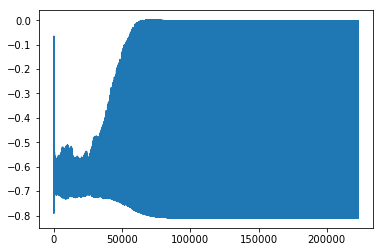

In [8]:
plt.plot(rewards)